#**Chuẩn bị môi trường làm việc**

## Bước 1: Thiết lập Google Colab

In [ ]:
# Cài đặt các thư viện cơ bản
!pip install numpy pandas matplotlib seaborn scikit-learn scipy wfdb
!pip install biosppy neurokit2 heartpy
# Cài đặt các thư viện học sâu và mô hình tạo sinh
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install pytorch-lightning
!pip install wandb # Để theo dõi thí nghiệm
# Thư viện xử lý tín hiệu sinh học chuyên biệt
!pip install pyedflib mne biosignalsnotebooks
# "# Cài đặt các thư viện cơ bản và deep learning trước\n",
#         "!pip install numpy pandas matplotlib seaborn scikit-learn scipy wfdb h5py tqdm\n",
#         "!pip install torch torchvision torchaudio\n",
#         "!pip install tensorflow\n",
#         "!pip install pytorch-lightning wandb # Để theo dõi thí nghiệm\n",
#         "\n",
#         "# Cài đặt các thư viện xử lý tín hiệu chuyên biệt (có thể gây xung đột, cài sau)\n",
#         "!pip install biosppy neurokit2 heartpy pyedflib mne\n",
#         "\n",
#         "# KHÔNG cài lại numpy/scipy ở đây nữa để tránh ghi đè phiên bản cần thiết\n",
#         "# !pip install numpy scipy # <--- DÒNG NÀY ĐÃ BỊ XÓA\n",
#         "\n",
#         "# Cài đặt biosignalsnotebooks riêng (thư viện này yêu cầu phiên bản cũ hơn)\n",
#         "# Chấp nhận cảnh báo xung đột nếu có\n",
#         "!pip install biosignalsnotebooks \n",
#         "\n",
#         "# Kiểm tra lại phiên bản numpy, scipy sau khi cài đặt\n",
#         "!pip show numpy scipy"

## Bước 2: Cài đặt các thư viện cần thiết

In [2]:
# Kiểm tra phiên bản Python và các thư viện quan trọng
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import wfdb
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.io
from sklearn.model_selection import train_test_split

# In thông tin phiên bản
print(f"wfdb version: {wfdb.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

# Kiểm tra GPU
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    device_name = torch.cuda.get_device_name(0)
    cuda_version = torch.version.cuda
    memory_allocated = torch.cuda.memory_allocated()
    memory_reserved = torch.cuda.memory_reserved()

    print(f"CUDA version: {cuda_version}")
    print(f"GPU device: {device_name}")
    print(f"Memory allocated: {memory_allocated / 1e6:.2f} MB")
    print(f"Memory reserved: {memory_reserved / 1e6:.2f} MB")
else:
    print("No GPU detected. Running on CPU.")

wfdb version: 4.2.0
pandas version: 2.2.3
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
NumPy version: 1.25.2
CUDA available: False
No GPU detected. Running on CPU.


## Bước 3: Kết nối Google Drive để lưu trữ dữ liệu và kết quả

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# Tạo thư mục làm việc
!mkdir -p /content/signal_generation

Mounted at /content/drive


##Bước 4: Thiết lập các hàm tiện ích

In [ ]:
def check_gpu_status():
    if torch.cuda.is_available():
        print(f"GPU đang sử dụng: {torch.cuda.get_device_name(0)}")
        print(f"Bộ nhớ GPU được cấp phát:{torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Bộ nhớ GPU dành riêng: {torch.cuda.memory_reserved(0)/1024**2:.2f}MB")
    else:
        print("Không có GPU khả dụng. Sử dụng CPU.")
def set_seed(seed=42):
    """Đặt giá trị seed cho tính tái lập"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Nếu sử dụng nhiều GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Đã thiết lập seed = {seed}")
# Thiết lập để tái lập kết quả
set_seed()
check_gpu_status()

#**Thu thập và chuẩn bị dữ liệu**

##Bước 1: Tải và khám phá bộ dữ liệu BMDIC

Danh sách các file BMDIC:
32256

Thông tin file mẫu BMDIC:
Tần số lấy mẫu: 1000 Hz
Số lượng kênh: 5
Tên các kênh: ['RESP,', 'PLETH,', 'I,', 'MCL,', 'II,']
Số lượng mẫu: 60001
Đơn vị: ['pm', 'NU', 'mV', 'mV', 'mV']


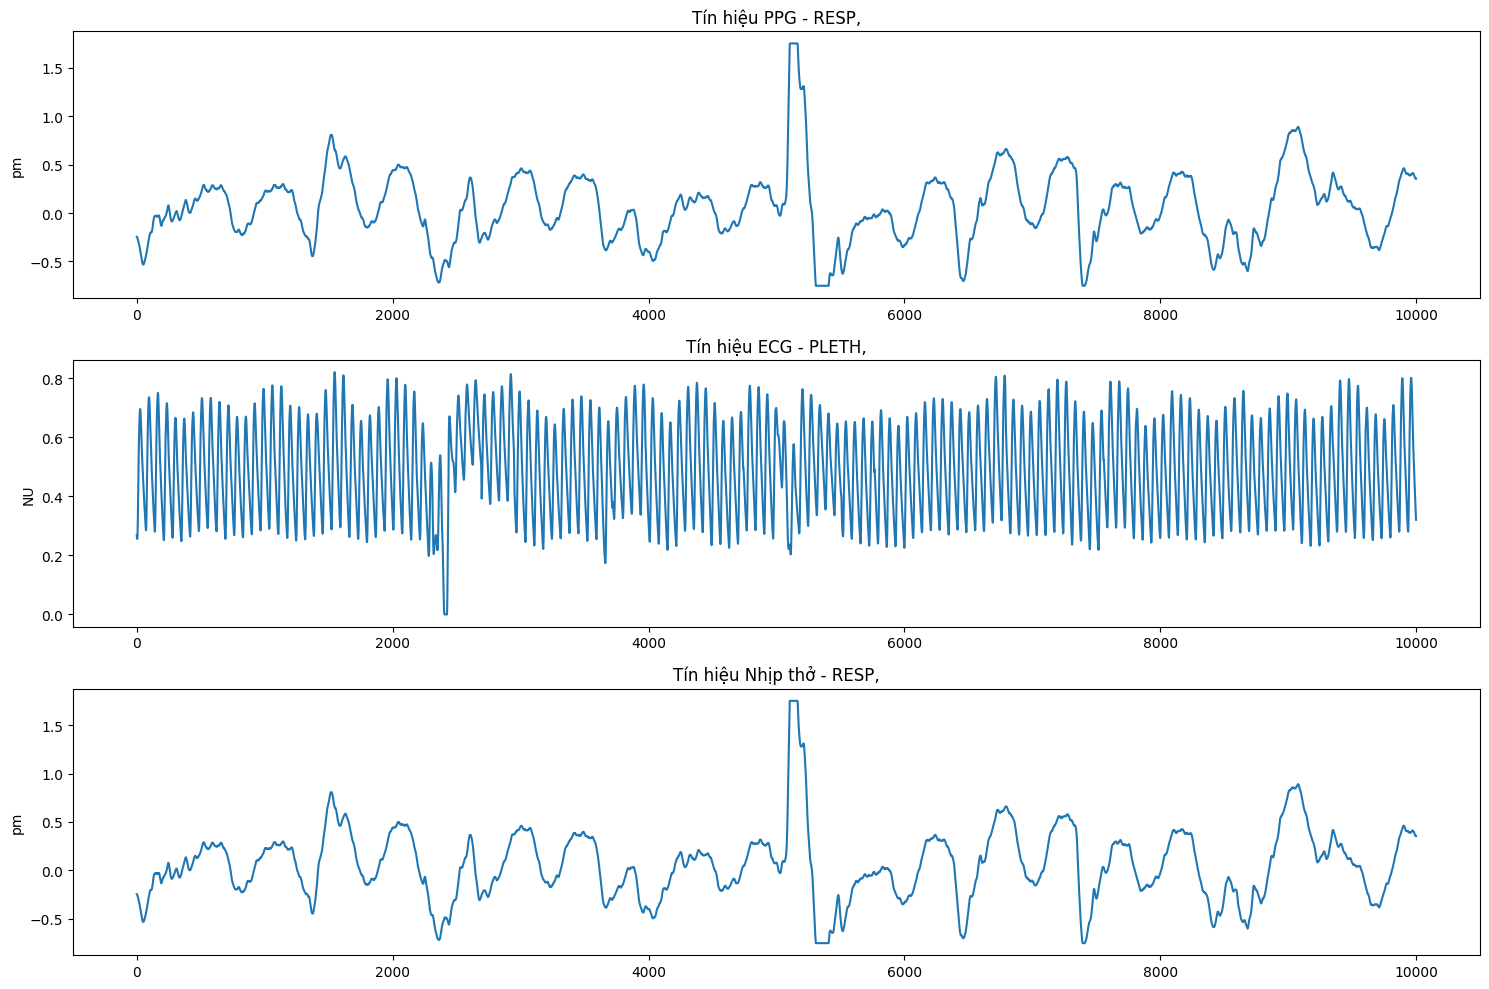

In [5]:
import wfdb
import os
import matplotlib.pyplot as plt  # Import matplotlib

bidmc_path = "/content/drive/MyDrive/bidmc-ppg-and-respiration-dataset-1.0.0"

def explore_bmdic_dataset():
    """Khám phá và hiển thị thông tin cơ bản về bộ dữ liệu BMDIC"""
    # Liệt kê các file trong thư mục dữ liệu
    print("Danh sách các file BMDIC:")
    print(os.system(bidmc_path)) # Sử dụng os.system để chạy lệnh shell

    # Đọc một file mẫu
    # Tìm file đầu tiên có định dạng hỗ trợ
    files = os.listdir(bidmc_path)
    sample_file = None
    for file in files:
        if file.endswith('.dat') or file.endswith('.hea'):
            sample_file = os.path.join(bidmc_path, os.path.splitext(file)[0])
            break

    if sample_file:
        try:
            tan_so_mau = 8;
            # Đọc dữ liệu
            record = wfdb.rdrecord(sample_file)
            print(f"\nThông tin file mẫu BMDIC:")
            print(f"Tần số lấy mẫu: {record.fs*tan_so_mau} Hz")
            print(f"Số lượng kênh: {record.n_sig}")
            print(f"Tên các kênh: {record.sig_name}")
            print(f"Số lượng mẫu: {record.sig_len}")
            print(f"Đơn vị: {record.units}")

            # Hiển thị dữ liệu mẫu
            plt.figure(figsize=(15, 10))
            # Xác định số lượng kênh cần hiển thị
            n_channels = min(3, record.n_sig)  # Hiển thị tối đa 3 kênh

            # Tìm vị trí của các kênh quan trọng
            ppg_idx = next((i for i, name in enumerate(record.sig_name) if 'ppg' in name.lower()), 0)
            ecg_idx = next((i for i, name in enumerate(record.sig_name) if 'ecg' in name.lower()), 1 % record.n_sig)
            resp_idx = next((i for i, name in enumerate(record.sig_name) if 'resp' in name.lower() or 'breath' in name.lower()), 2 % record.n_sig)

            # Hiển thị 10 giây đầu tiên
            seconds_to_show = 10
            samples_to_show = int(seconds_to_show * record.fs*tan_so_mau)

            # Hiển thị từng kênh
            plt.subplot(n_channels, 1, 1)
            plt.plot(record.p_signal[:samples_to_show, ppg_idx])
            plt.title(f"Tín hiệu PPG - {record.sig_name[ppg_idx]}")
            plt.ylabel(record.units[ppg_idx])

            plt.subplot(n_channels, 1, 2)
            plt.plot(record.p_signal[:samples_to_show, ecg_idx])
            plt.title(f"Tín hiệu ECG - {record.sig_name[ecg_idx]}")
            plt.ylabel(record.units[ecg_idx])

            if n_channels > 2:
                plt.subplot(n_channels, 1, 3)
                plt.plot(record.p_signal[:samples_to_show, resp_idx])
                plt.title(f"Tín hiệu Nhịp thở - {record.sig_name[resp_idx]}")
                plt.ylabel(record.units[resp_idx])

            plt.tight_layout()
            plt.show()
            return record

        except Exception as e:
            print(f"Lỗi khi đọc file mẫu BMDIC: {e}")
    else:
        print("Không tìm thấy file mẫu với định dạng hỗ trợ trong thư mục BMDIC")
    return None

# Khám phá dữ liệu BMDIC
bmdic_sample = explore_bmdic_dataset()

##Bước 2: Tải và khám phá bộ dữ liệu Capno IEEE

📂 Danh sách các file Capno IEEE:
  - 0031_8min.mat
  - 0149_8min.mat
  - 0029_8min.mat
  - 0009_8min.mat
  - 0311_8min.mat
  - 0331_8min.mat
  - 0030_8min.mat
  - 0333_8min.mat
  - 0038_8min.mat
  - 0104_8min.mat
  - 0312_8min.mat
  - 0147_8min.mat
  - 0330_8min.mat
  - 0122_8min.mat
  - 0028_8min.mat
  - 0035_8min.mat
  - 0332_8min.mat
  - 0313_8min.mat
  - 0309_8min.mat
  - 0328_8min.mat
  - 0150_8min.mat
  - 0121_8min.mat
  - 0023_8min.mat
  - 0125_8min.mat
  - 0134_8min.mat
  - 0103_8min.mat
  - 0148_8min.mat
  - 0032_8min.mat
  - 0127_8min.mat
  - 0329_8min.mat
  - 0142_8min.mat
  - 0015_8min.mat
  - 0370_8min.mat
  - 0018_8min.mat
  - 0123_8min.mat
  - 0105_8min.mat
  - 0133_8min.mat
  - 0325_8min.mat
  - 0115_8min.mat
  - 0016_8min.mat
  - 0322_8min.mat
  - 0128_8min.mat

📜 Thông tin file mẫu: 0031_8min.mat
🔑 Các khóa chính: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
✅ Extracted 'co2/y' data: shape (144001,), dtype float64
✅ Extracted 'ecg/y' data:

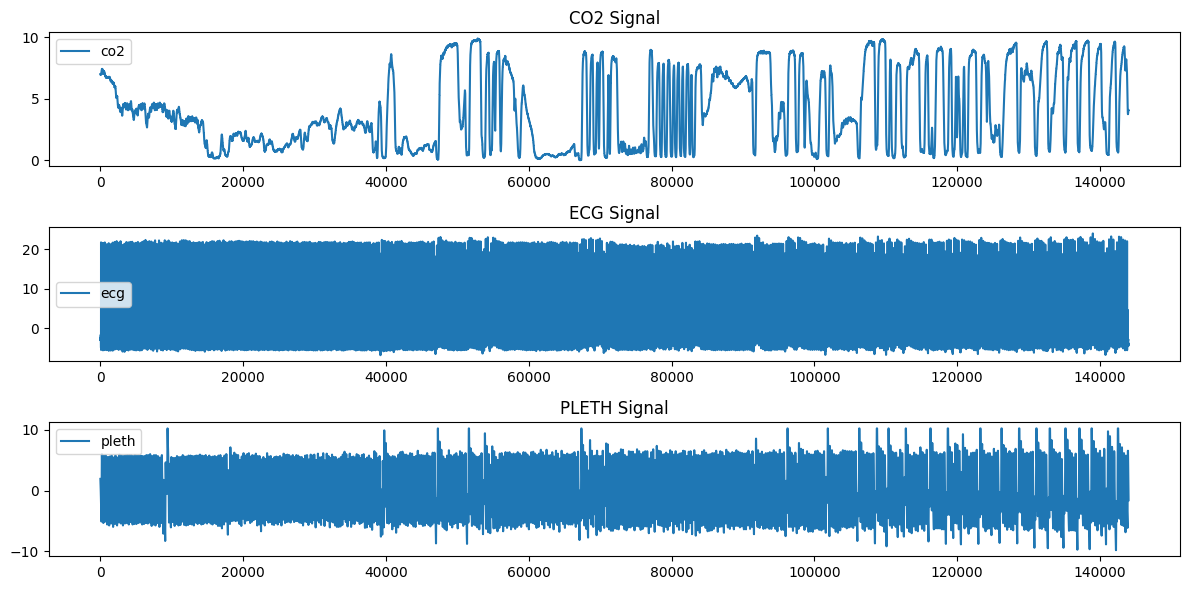

{'co2': array([7.  , 7.  , 7.  , ..., 4.1 , 4.09, 4.09]),
 'ecg': array([-2.95, -2.97, -2.99, ..., -4.15, -4.04, -4.  ]),
 'pleth': array([ 1.92,  1.89,  1.87, ..., -1.49, -1.55, -1.6 ])}

In [6]:
capno_path = "/content/drive/MyDrive/data/mat"

def explore_capno_dataset():
    """Khám phá và hiển thị thông tin cơ bản về bộ dữ liệu Capno IEEE (MATLAB v7.3 - HDF5)"""

    # Liệt kê các file trong thư mục dữ liệu
    print("📂 Danh sách các file Capno IEEE:")
    files = [f for f in os.listdir(capno_path) if f.endswith('.mat')]
    if not files:
        print("❌ Không tìm thấy file .mat nào trong thư mục!")
        return None

    for file in files:
        print(f"  - {file}")

    # Lấy file mẫu đầu tiên
    sample_file = os.path.join(capno_path, files[0])

    try:
        # Đọc file .mat sử dụng h5py
        with h5py.File(sample_file, "r") as mat_file:
            print(f"\n📜 Thông tin file mẫu: {os.path.basename(sample_file)}")
            print(f"🔑 Các khóa chính: {list(mat_file.keys())}")

            # Kiểm tra nhóm "signal"
            if "signal" not in mat_file:
                print("❌ Không tìm thấy nhóm 'signal' trong file!")
                return None

            signal_group = mat_file["signal"]
            signals = {}

            # Lặp qua các tín hiệu (co2, ecg, pleth)
            for key in signal_group.keys():
                sub_group = signal_group[key]  # Access 'co2', 'ecg', 'pleth'

                if isinstance(sub_group, h5py.Group) and "y" in sub_group:
                    data = np.array(sub_group["y"]).flatten()  # Flatten to 1D array
                    signals[key] = data
                    print(f"✅ Extracted '{key}/y' data: shape {data.shape}, dtype {data.dtype}")

            # 📊 Hiển thị tín hiệu
            if not signals:
                print("❌ Không có tín hiệu nào được trích xuất!")
                return None

            plt.figure(figsize=(12, 6))
            for i, (key, data) in enumerate(signals.items(), start=1):
                plt.subplot(len(signals), 1, i)
                plt.plot(data, label=key)
                plt.title(f"{key.upper()} Signal")
                plt.legend()

            plt.tight_layout()
            plt.show()

            return signals

    except Exception as e:
        print(f"❌ Lỗi khi đọc file Capno IEEE: {e}")
        return None
explore_capno_dataset()

##Bước 3: Tạo bộ dữ liệu kết hợp và chuẩn bị cho huấn luyện

In [7]:
import wfdb
import scipy.io
import numpy as np
import os
from tqdm import tqdm

def prepare_combined_dataset(bmdic_path, capno_path, save_path):
    """
    Kết hợp và chuẩn bị bộ dữ liệu từ cả BMDIC và Capno IEEE
    Tham số:
    - bmdic_path: Đường dẫn đến thư mục dữ liệu BMDIC
    - capno_path: Đường dẫn đến thư mục dữ liệu Capno IEEE
    - save_path: Đường dẫn lưu dữ liệu đã xử lý
    Trả về:
    - Đường dẫn đến file dữ liệu đã xử lý
    """
    # Tạo thư mục lưu trữ nếu chưa tồn tại
    os.makedirs(save_path, exist_ok=True)

    # Danh sách để lưu dữ liệu từ cả hai bộ
    ppg_segments = []
    ecg_segments = []
    resp_segments = []

    # Xử lý dữ liệu BMDIC
    print("Đang xử lý dữ liệu BMDIC...")
    bmdic_files = [f for f in os.listdir(bmdic_path)
                  if f.endswith('.dat') or f.endswith('.hea')]
    bmdic_record_names = set([os.path.splitext(f)[0] for f in bmdic_files])

    for record_name in tqdm(bmdic_record_names):
        try:
            record_path = os.path.join(bmdic_path, record_name)
            record = wfdb.rdrecord(record_path)

            # Tìm vị trí của các kênh quan trọng
            ppg_idx = next((i for i, name in enumerate(record.sig_name)
                          if 'ppg' in name.lower()), None)
            ecg_idx = next((i for i, name in enumerate(record.sig_name)
                          if 'ecg' in name.lower()), None)
            resp_idx = next((i for i, name in enumerate(record.sig_name)
                           if 'resp' in name.lower() or 'breath' in name.lower()), None)

            # Kiểm tra xem có đủ 3 kênh cần thiết không
            if ppg_idx is not None and ecg_idx is not None and resp_idx is not None:
                # Trích xuất tín hiệu
                ppg_signal = record.p_signal[:, ppg_idx]
                ecg_signal = record.p_signal[:, ecg_idx]
                resp_signal = record.p_signal[:, resp_idx]

                # Phân đoạn tín hiệu thành các cửa sổ 10 giây
                window_size = int(10 * record.fs)  # 10 giây
                stride = int(5 * record.fs)  # 5 giây (chồng lấp 50%)

                for i in range(0, len(ppg_signal) - window_size, stride):
                    ppg_window = ppg_signal[i:i+window_size]
                    ecg_window = ecg_signal[i:i+window_size]
                    resp_window = resp_signal[i:i+window_size]

                    # Kiểm tra chất lượng đoạn tín hiệu
                    if (np.count_nonzero(ppg_window) > 0.8 * window_size and
                        np.count_nonzero(ecg_window) > 0.8 * window_size and
                        np.count_nonzero(resp_window) > 0.8 * window_size):
                        # Thêm vào danh sách
                        ppg_segments.append(ppg_window)
                        ecg_segments.append(ecg_window)
                        resp_segments.append(resp_window)

        except Exception as e:
            print(f"Lỗi khi xử lý file BMDIC {record_name}: {e}")

    # Xử lý dữ liệu Capno IEEE (HDF5 format)
    print("\nĐang xử lý dữ liệu Capno IEEE...")
    if not os.path.exists(capno_path):
        print(f"Lỗi: Thư mục Capno {capno_path} không tồn tại!")
        return None

    capno_files = [f for f in os.listdir(capno_path) if f.endswith('.mat')]
    if not capno_files:
        print(f"Cảnh báo: Không tìm thấy file .mat trong {capno_path}")

    for file_name in tqdm(capno_files):
        try:
            file_path = os.path.join(capno_path, file_name)
            with h5py.File(file_path, "r") as mat_file:
                # Kiểm tra nhóm "signal"
                if "signal" not in mat_file:
                    print(f"Cảnh báo: Không tìm thấy nhóm 'signal' trong {file_name}")
                    continue

                signal_group = mat_file["signal"]
                signals = {}

                # Trích xuất các tín hiệu PPG (pleth), ECG, CO2
                for key in signal_group.keys():
                    sub_group = signal_group[key]
                    if isinstance(sub_group, h5py.Group) and "y" in sub_group:
                        data = np.array(sub_group["y"]).flatten()
                        signals[key] = data

                # Gán tín hiệu theo tên khóa
                ppg_signal = signals.get("pleth")  # PPG thường là "pleth" trong Capno
                ecg_signal = signals.get("ecg")
                co2_signal = signals.get("co2")

                if ppg_signal is None or ecg_signal is None or co2_signal is None:
                    print(f"Cảnh báo: Thiếu kênh pleth/ecg/co2 trong {file_name}")
                    continue

                # Đảm bảo các tín hiệu có cùng độ dài
                min_length = min(len(ppg_signal), len(ecg_signal), len(co2_signal))
                ppg_signal = ppg_signal[:min_length]
                ecg_signal = ecg_signal[:min_length]
                co2_signal = co2_signal[:min_length]

                # Giả sử tần số lấy mẫu là 100 Hz
                fs = 100
                window_size = int(10 * fs)
                stride = int(5 * fs)

                for i in range(0, min_length - window_size, stride):
                    ppg_window = ppg_signal[i:i+window_size]
                    ecg_window = ecg_signal[i:i+window_size]
                    co2_window = co2_signal[i:i+window_size]

                    # Kiểm tra chất lượng đoạn tín hiệu
                    if (np.count_nonzero(ppg_window) > 0.8 * window_size and
                        np.count_nonzero(ecg_window) > 0.8 * window_size and
                        np.count_nonzero(co2_window) > 0.8 * window_size):
                        ppg_segments.append(ppg_window)
                        ecg_segments.append(ecg_window)
                        resp_segments.append(co2_window)

        except Exception as e:
            print(f"Lỗi khi xử lý file Capno IEEE {file_name}: {e}")

    # Chuyển đổi các danh sách thành mảng numpy
    ppg_data = np.array(ppg_segments)
    ecg_data = np.array(ecg_segments)
    resp_data = np.array(resp_segments)

    print(f"\nTổng số phân đoạn dữ liệu: {len(ppg_segments)}")
    print(f"Kích thước dữ liệu PPG: {ppg_data.shape}")
    print(f"Kích thước dữ liệu ECG: {ecg_data.shape}")
    print(f"Kích thước dữ liệu nhịp thở: {resp_data.shape}")

    if len(ppg_segments) == 0:
        print("Cảnh báo: Không có dữ liệu nào được xử lý thành công!")
        return None

    # Lưu dữ liệu đã xử lý
    output_file = os.path.join(save_path, 'combined_dataset.npz')
    np.savez_compressed(
        output_file,
        ppg=ppg_data,
        ecg=ecg_data,
        resp=resp_data
    )
    print(f"Đã lưu dữ liệu kết hợp tại: {output_file}")
    return output_file

# Chuẩn bị bộ dữ liệu kết hợp
combined_data_path = prepare_combined_dataset(
    bidmc_path,
    capno_path,
    'content/data/processed'
)

Đang xử lý dữ liệu BMDIC...


100%|██████████| 106/106 [00:07<00:00, 15.01it/s]



Đang xử lý dữ liệu Capno IEEE...


100%|██████████| 42/42 [00:20<00:00,  2.03it/s]



Tổng số phân đoạn dữ liệu: 11979
Kích thước dữ liệu PPG: (11979, 1000)
Kích thước dữ liệu ECG: (11979, 1000)
Kích thước dữ liệu nhịp thở: (11979, 1000)
Đã lưu dữ liệu kết hợp tại: content/data/processed/combined_dataset.npz


In [8]:
# Đường dẫn đến thư mục dữ liệu thô (CẦN THAY ĐỔI CHO ĐÚNG VỚI DRIVE CỦA BẠN)
bmdic_raw_path = "/content/drive/MyDrive/bidmc-ppg-and-respiration-dataset-1.0.0" # Thay đổi nếu cần
capno_raw_path = "/content/drive/MyDrive/data/mat" # Thay đổi nếu cần
processed_data_save_path = '/content/content/data/processed'

# Tạo thư mục processed nếu chưa có
!mkdir -p {processed_data_save_path}

# Gọi hàm để tạo file dữ liệu kết hợp
combined_data_path = prepare_combined_dataset(
    bmdic_raw_path,
    capno_raw_path,
    processed_data_save_path
)

# Kiểm tra xem file đã được tạo chưa (tuỳ chọn)
if combined_data_path and os.path.exists(combined_data_path):
    print(f"Đã tạo thành công file dữ liệu kết hợp: {combined_data_path}")
else:
    print("Lỗi: Không thể tạo file dữ liệu kết hợp.")


Đang xử lý dữ liệu BMDIC...


100%|██████████| 106/106 [00:01<00:00, 102.33it/s]



Đang xử lý dữ liệu Capno IEEE...


100%|██████████| 42/42 [00:00<00:00, 57.27it/s]



Tổng số phân đoạn dữ liệu: 11979
Kích thước dữ liệu PPG: (11979, 1000)
Kích thước dữ liệu ECG: (11979, 1000)
Kích thước dữ liệu nhịp thở: (11979, 1000)
Đã lưu dữ liệu kết hợp tại: /content/content/data/processed/combined_dataset.npz
Đã tạo thành công file dữ liệu kết hợp: /content/content/data/processed/combined_dataset.npz


##Bước 4: Phân chia tập huấn luyện, xác thực và kiểm tra

In [11]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def split_dataset(data_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Phân chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu đã xử lý (.npz)
    - train_ratio, val_ratio, test_ratio: Tỷ lệ phân chia

    Trả về:
    - Đường dẫn đến các file đã phân chia
    """
    # Kiểm tra tỷ lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Tổng các tỷ lệ phải bằng 1"

    # Tạo thư mục đầu ra
    output_dir = os.path.dirname(data_path)

    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Phân chia train và temp (val + test)
    ppg_train, ppg_temp, ecg_train, ecg_temp, resp_train, resp_temp = train_test_split(
        ppg, ecg, resp, train_size=train_ratio, random_state=42
    )

    # Phân chia temp thành val và test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    ppg_val, ppg_test, ecg_val, ecg_test, resp_val, resp_test = train_test_split(
        ppg_temp, ecg_temp, resp_temp, train_size=val_ratio_adjusted, random_state=42
    )

    # In thông tin
    print("Kích thước các tập dữ liệu:")
    print(f"Tập huấn luyện: {len(ppg_train)} mẫu")
    print(f"Tập xác thực: {len(ppg_val)} mẫu")
    print(f"Tập kiểm tra: {len(ppg_test)} mẫu")

    # Lưu các tập dữ liệu
    train_path = os.path.join(output_dir, 'train_data.npz')
    val_path = os.path.join(output_dir, 'val_data.npz')
    test_path = os.path.join(output_dir, 'test_data.npz')

    np.savez_compressed(train_path, ppg=ppg_train, ecg=ecg_train, resp=resp_train)
    np.savez_compressed(val_path, ppg=ppg_val, ecg=ecg_val, resp=resp_val)
    np.savez_compressed(test_path, ppg=ppg_test, ecg=ecg_test, resp=resp_test)

    print(f"Đã lưu tập huấn luyện tại: {train_path}")
    print(f"Đã lưu tập xác thực tại: {val_path}")
    print(f"Đã lưu tập kiểm tra tại: {test_path}")

    return train_path, val_path, test_path

# Phân chia dữ liệu
train_path, val_path, test_path = split_dataset(combined_data_path)

Kích thước các tập dữ liệu:
Tập huấn luyện: 8385 mẫu
Tập xác thực: 1797 mẫu
Tập kiểm tra: 1797 mẫu
Đã lưu tập huấn luyện tại: /content/content/data/processed/train_data.npz
Đã lưu tập xác thực tại: /content/content/data/processed/val_data.npz
Đã lưu tập kiểm tra tại: /content/content/data/processed/test_data.npz


###Test file combined

In [10]:
# Đường dẫn đến file .npz
file_path = 'content/data/processed/combined_dataset.npz'

# Load file .npz
data = np.load(file_path)

# In danh sách các mảng có trong file
print("Các mảng trong file:", data.files)

# In kích thước của từng mảng
print("Kích thước dữ liệu PPG:", data['ppg'].shape)
print("Kích thước dữ liệu ECG:", data['ecg'].shape)
print("Kích thước dữ liệu RESP:", data['resp'].shape)

# Xem một số mẫu dữ liệu (nếu có)
if data['ppg'].size > 0:
    print("\nDữ liệu PPG (5 đoạn đầu tiên):")
    print(data['ppg'][:5])
    print("Dữ liệu ECG (5 đoạn đầu tiên):")
    print(data['ecg'][:5])
    print("Dữ liệu RESP (5 đoạn đầu tiên):")
    print(data['resp'][:5])
else:
    print("\nKhông có dữ liệu trong file (kích thước = 0)!")

Các mảng trong file: ['ppg', 'ecg', 'resp']
Kích thước dữ liệu PPG: (11979, 1000)
Kích thước dữ liệu ECG: (11979, 1000)
Kích thước dữ liệu RESP: (11979, 1000)

Dữ liệu PPG (5 đoạn đầu tiên):
[[ 1.92  1.89  1.87 ...  4.72  4.72  5.04]
 [ 4.93  4.88  4.77 ... -5.28 -5.31 -5.33]
 [ 5.09  5.15  5.2  ... -2.51 -2.56 -2.61]
 [-5.36 -5.39 -5.41 ...  0.43  0.37  0.32]
 [-2.67 -2.72 -2.77 ...  2.08  2.03  1.97]]
Dữ liệu ECG (5 đoạn đầu tiên):
[[-2.95 -2.97 -2.99 ... -2.44 -2.53 -2.58]
 [-2.69 -2.71 -2.76 ... -0.6  -0.53 -0.43]
 [-2.59 -2.59 -2.62 ... 21.87 20.14 14.69]
 [-0.34 -0.23 -0.11 ... -2.93 -2.93 -2.96]
 [ 7.43  0.61 -3.76 ... -2.76 -2.76 -2.74]]
Dữ liệu RESP (5 đoạn đầu tiên):
[[7.   7.   7.   ... 6.74 6.75 6.75]
 [7.22 7.22 7.21 ... 6.45 6.45 6.45]
 [6.75 6.75 6.75 ... 5.96 5.96 5.96]
 [6.46 6.46 6.46 ... 4.28 4.28 4.28]
 [5.95 5.95 5.95 ... 3.92 3.91 3.9 ]]


#**Phương pháp tiền xử lý dữ liệu**

##Bước 1: Chuẩn hóa tần số lấy mẫu

In [12]:
from scipy import signal as scipy_signal
import numpy as np
import os
from tqdm import tqdm

def standardize_sampling_rate(signal, original_fs, target_fs=250):
    """
    Chuẩn hóa tần số lấy mẫu của tín hiệu
    Tham số:
    - signal: Mảng numpy chứa tín hiệu
    - original_fs: Tần số lấy mẫu gốc (Hz)
    - target_fs: Tần số lấy mẫu mục tiêu (Hz)
    Trả về:
    - Tín hiệu đã chuẩn hóa tần số lấy mẫu
    """
    # Nếu tần số lấy mẫu đã đúng, không cần xử lý
    if original_fs == target_fs:
        return signal

    # Tính toán số lượng mẫu mới
    orig_len = len(signal)
    new_len = int(orig_len * (target_fs / original_fs))

    # Resample tín hiệu
    resampled_signal = scipy_signal.resample(signal, new_len)
    return resampled_signal

def standardize_dataset_sampling_rate(data_path, bmdic_fs=250, capno_fs=100, target_fs=250):
    """
    Chuẩn hóa tần số lấy mẫu cho toàn bộ bộ dữ liệu
    Tham số:
    - data_path: Đường dẫn đến file dữ liệu
    - bmdic_fs: Tần số lấy mẫu của dữ liệu BMDIC
    - capno_fs: Tần số lấy mẫu của dữ liệu Capno
    - target_fs: Tần số lấy mẫu mục tiêu
    Trả về:
    - Đường dẫn đến file dữ liệu đã chuẩn hóa
    """
    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Xác định xem tín hiệu có phải từ Capno hay không dựa vào độ dài
    window_size_bmdic = 10 * bmdic_fs
    window_size_capno = 10 * capno_fs

    # Chuẩn hóa từng phân đoạn
    ppg_resampled = []
    ecg_resampled = []
    resp_resampled = []

    for i in tqdm(range(len(ppg)), desc="Chuẩn hóa tần số lấy mẫu"):
        # Xác định tần số gốc dựa vào độ dài
        orig_len = len(ppg[i])
        if abs(orig_len - window_size_bmdic) < abs(orig_len - window_size_capno):
            original_fs = bmdic_fs
        else:
            original_fs = capno_fs

        # Chuẩn hóa từng tín hiệu
        ppg_resampled.append(standardize_sampling_rate(ppg[i], original_fs, target_fs))
        ecg_resampled.append(standardize_sampling_rate(ecg[i], original_fs, target_fs))
        resp_resampled.append(standardize_sampling_rate(resp[i], original_fs, target_fs))

    # Chuyển đổi thành mảng numpy
    ppg_resampled = np.array(ppg_resampled)
    ecg_resampled = np.array(ecg_resampled)
    resp_resampled = np.array(resp_resampled)

    # In thông tin
    print("Kích thước dữ liệu sau khi chuẩn hóa:")
    print(f"PPG: {ppg_resampled.shape}")
    print(f"ECG: {ecg_resampled.shape}")
    print(f"Nhịp thở: {resp_resampled.shape}")

    # Lưu dữ liệu đã chuẩn hóa
    output_dir = os.path.dirname(data_path)
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_standardized.npz'))
    np.savez_compressed(output_file, ppg=ppg_resampled, ecg=ecg_resampled, resp=resp_resampled)

    print(f"Đã lưu dữ liệu chuẩn hóa tại: {output_file}")
    return output_file

# Chuẩn hóa tần số lấy mẫu cho từng tập dữ liệu
train_std_path = standardize_dataset_sampling_rate(train_path)
val_std_path = standardize_dataset_sampling_rate(val_path)
test_std_path = standardize_dataset_sampling_rate(test_path)


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 8385/8385 [00:03<00:00, 2192.38it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (8385, 2500)
ECG: (8385, 2500)
Nhịp thở: (8385, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /content/content/data/processed/train_data_standardized.npz


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 1797/1797 [00:00<00:00, 7272.02it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /content/content/data/processed/val_data_standardized.npz


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 1797/1797 [00:00<00:00, 6808.50it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /content/content/data/processed/test_data_standardized.npz


##Bước 2: Lọc nhiễu và chuẩn hóa biên độ

In [13]:
def filter_and_normalize_signal(signal, fs, filter_type='bandpass', normalize_method='minmax'):
    """
    Lọc nhiễu và chuẩn hóa biên độ tín hiệu

    Tham số:
    - signal: Mảng numpy chứa tín hiệu
    - fs: Tần số lấy mẫu (Hz)
    - filter_type: Loại bộ lọc ('bandpass', 'lowpass', 'highpass')
    - normalize_method: Phương pháp chuẩn hóa ('minmax', 'zscore')

    Trả về:
    - Tín hiệu đã lọc và chuẩn hóa
    """
    from scipy import signal as scipy_signal
    import numpy as np

    # Lọc nhiễu
    if filter_type == 'bandpass':
        # Lọc thông dải 0.5-40 Hz (phù hợp cho cả 3 loại tín hiệu)
        b, a = scipy_signal.butter(4, [0.5, 40], fs=fs, btype='bandpass')
    elif filter_type == 'lowpass':
        # Lọc thông thấp 40 Hz
        b, a = scipy_signal.butter(4, 40, fs=fs, btype='lowpass')
    elif filter_type == 'highpass':
        # Lọc thông cao 0.5 Hz (loại bỏ trend)
        b, a = scipy_signal.butter(4, 0.5, fs=fs, btype='highpass')
    else:
        return signal

    filtered_signal = scipy_signal.filtfilt(b, a, signal)

    # Chuẩn hóa biên độ
    if normalize_method == 'minmax':
        signal_min = np.min(filtered_signal)
        signal_max = np.max(filtered_signal)
        if signal_max == signal_min:
            normalized_signal = np.zeros_like(filtered_signal)
        else:
            normalized_signal = 2 * (filtered_signal - signal_min) / (signal_max - signal_min) - 1
    elif normalize_method == 'zscore':
        signal_mean = np.mean(filtered_signal)
        signal_std = np.std(filtered_signal)
        if signal_std == 0:
            normalized_signal = np.zeros_like(filtered_signal)
        else:
            normalized_signal = (filtered_signal - signal_mean) / signal_std
    else:
        normalized_signal = filtered_signal

    return normalized_signal


def preprocess_dataset(data_path, fs=250):
    """
    Tiền xử lý toàn bộ bộ dữ liệu

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu
    - fs: Tần số lấy mẫu (Hz)

    Trả về:
    - Đường dẫn đến file dữ liệu đã tiền xử lý
    """
    import numpy as np
    import os
    from tqdm import tqdm

    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Tiền xử lý từng phân đoạn
    ppg_processed = []
    ecg_processed = []
    resp_processed = []

    for i in tqdm(range(len(ppg)), desc="Tiền xử lý tín hiệu"):
        # Xử lý tín hiệu PPG
        ppg_processed.append(filter_and_normalize_signal(ppg[i], fs, filter_type='bandpass', normalize_method='minmax'))
        # Xử lý tín hiệu ECG
        ecg_processed.append(filter_and_normalize_signal(ecg[i], fs, filter_type='bandpass', normalize_method='minmax'))
        # Xử lý tín hiệu nhịp thở
        resp_processed.append(filter_and_normalize_signal(resp[i], fs, filter_type='lowpass', normalize_method='minmax'))

    # Chuyển đổi thành mảng numpy
    ppg_processed = np.array(ppg_processed)
    ecg_processed = np.array(ecg_processed)
    resp_processed = np.array(resp_processed)

    # In thông tin
    print(f"Kích thước dữ liệu sau khi tiền xử lý:")
    print(f"PPG: {ppg_processed.shape}")
    print(f"ECG: {ecg_processed.shape}")
    print(f"Nhịp thở: {resp_processed.shape}")

    # Lưu dữ liệu đã tiền xử lý
    output_dir = os.path.dirname(data_path)
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_preprocessed.npz'))

    np.savez_compressed(output_file, ppg=ppg_processed, ecg=ecg_processed, resp=resp_processed)

    print(f"Đã lưu dữ liệu đã tiền xử lý tại: {output_file}")
    return output_file


# Tiền xử lý từng tập dữ liệu
train_prep_path = preprocess_dataset(train_std_path)
val_prep_path = preprocess_dataset(val_std_path)
test_prep_path = preprocess_dataset(test_std_path)

Tiền xử lý tín hiệu: 100%|██████████| 8385/8385 [00:10<00:00, 791.69it/s]


Kích thước dữ liệu sau khi tiền xử lý:
PPG: (8385, 2500)
ECG: (8385, 2500)
Nhịp thở: (8385, 2500)
Đã lưu dữ liệu đã tiền xử lý tại: /content/content/data/processed/train_data_standardized_preprocessed.npz


Tiền xử lý tín hiệu: 100%|██████████| 1797/1797 [00:02<00:00, 674.43it/s]


Kích thước dữ liệu sau khi tiền xử lý:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu đã tiền xử lý tại: /content/content/data/processed/val_data_standardized_preprocessed.npz


Tiền xử lý tín hiệu: 100%|██████████| 1797/1797 [00:02<00:00, 886.78it/s]


Kích thước dữ liệu sau khi tiền xử lý:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu đã tiền xử lý tại: /content/content/data/processed/test_data_standardized_preprocessed.npz


##Bước 3: Trích xuất đặc trưng

In [14]:
# import numpy as np
# from scipy import signal as scipy_signal
# import os
# from tqdm import tqdm
# import heartpy as hp
# import neurokit2 as nk

# def bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0):
#     nyquist = fs / 2
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy_signal.butter(2, [low, high], btype='band')
#     return scipy_signal.filtfilt(b, a, signal)

# def extract_features(signal, fs, signal_type, min_length=1250):
#     """
#     Trích xuất đặc trưng từ tín hiệu
#     Tham số:
#     - signal: Mảng numpy chứa tín hiệu
#     - fs: Tần số lấy mẫu (Hz)
#     - signal_type: Loại tín hiệu ('ppg', 'ecg', 'resp')
#     - min_length: Độ dài tối thiểu của tín hiệu (mẫu)
#     Trả về:
#     - Các đặc trưng đã trích xuất
#     """
#     def extract_basic_features(signal, fs):
#         """Trích xuất 16 đặc trưng cơ bản khi lỗi xảy ra"""
#         # Time domain
#         mean = np.mean(signal)
#         std = np.std(signal)
#         min_val = np.min(signal)
#         max_val = np.max(signal)
#         rms = np.sqrt(np.mean(np.square(signal)))
#         zero_crossings = np.sum(np.diff(np.signbit(signal).astype(int)) != 0)
#         zcr = zero_crossings / (len(signal) - 1)
#         p2p = max_val - min_val
#         hist, _ = np.histogram(signal, bins=10, density=True)
#         entropy = -np.sum(hist * np.log2(hist + 1e-10))

#         # Frequency domain
#         n = len(signal)
#         fft_signal = np.abs(np.fft.rfft(signal))
#         fft_freq = np.fft.rfftfreq(n, d=1/fs)
#         delta_idx = np.where((fft_freq >= 0.5) & (fft_freq < 4))[0]
#         theta_idx = np.where((fft_freq >= 4) & (fft_freq < 8))[0]
#         alpha_idx = np.where((fft_freq >= 8) & (fft_freq < 13))[0]
#         beta_idx = np.where((fft_freq >= 13) & (fft_freq < 30))[0]
#         gamma_idx = np.where((fft_freq >= 30) & (fft_freq <= 50))[0]
#         delta_power = (np.sum(fft_signal[delta_idx]**2) / len(delta_idx)
#                       if len(delta_idx) > 0 else 0)
#         theta_power = (np.sum(fft_signal[theta_idx]**2) / len(theta_idx)
#                       if len(theta_idx) > 0 else 0)
#         alpha_power = (np.sum(fft_signal[alpha_idx]**2) / len(alpha_idx)
#                       if len(alpha_idx) > 0 else 0)
#         beta_power = (np.sum(fft_signal[beta_idx]**2) / len(beta_idx)
#                      if len(beta_idx) > 0 else 0)
#         gamma_power = (np.sum(fft_signal[gamma_idx]**2) / len(gamma_idx)
#                       if len(gamma_idx) > 0 else 0)
#         mean_freq = (np.sum(fft_freq * fft_signal) / np.sum(fft_signal)
#                     if np.sum(fft_signal) > 0 else 0)
#         cum_sum = np.cumsum(fft_signal)
#         half_power = cum_sum[-1] / 2
#         median_freq_idx = np.where(cum_sum >= half_power)[0][0] if len(cum_sum) > 0 else 0
#         median_freq = fft_freq[median_freq_idx] if median_freq_idx < len(fft_freq) else 0
#         max_freq_idx = np.argmax(fft_signal)
#         max_freq = fft_freq[max_freq_idx]
#         return np.array([mean, std, min_val, max_val, rms, zcr, p2p, entropy,
#                         delta_power, theta_power, alpha_power, beta_power,
#                         gamma_power, mean_freq, median_freq, max_freq])

#     # Kiểm tra độ dài tín hiệu
#     if len(signal) < min_length:
#         print(f"Tín hiệu {signal_type} quá ngắn ({len(signal)} mẫu), dùng đặc trưng cơ bản.")
#         return extract_basic_features(signal, fs)

#     # Tiền xử lý tín hiệu
#     if signal_type == 'ppg':
#         signal = bandpass_filter(signal, fs, lowcut=0.5, highcut=8.0)
#     elif signal_type == 'ecg':
#         signal = bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0)
#     elif signal_type == 'resp':
#         signal = bandpass_filter(signal, fs, lowcut=0.1, highcut=1.0)

#     # Trích xuất đặc trưng theo loại tín hiệu
#     if signal_type == 'ppg':
#         try:
#             working_data, measures = hp.process(signal, fs, bpmmin=40, bpmmax=200)
#             bpm = measures.get('bpm', 0)
#             sdnn = measures.get('sdnn', 0)
#             rmssd = measures.get('rmssd', 0)
#             pnn50 = measures.get('pnn50', 0)
#             lf = measures.get('lf', 0)
#             hf = measures.get('hf', 0)
#             lf_hf = measures.get('lf/hf', 0)
#             return np.array([bpm, sdnn, rmssd, pnn50, lf, hf, lf_hf])
#         except Exception as e:
#             print(f"Lỗi khi trích xuất đặc trưng PPG: {e}")
#             return extract_basic_features(signal, fs)
#     elif signal_type == 'ecg':
#         try:
#             ecg_signals, ecg_info = nk.ecg_process(signal, fs)
#             ecg_features = nk.ecg_intervalrelated(ecg_signals, sampling_rate=fs)
#             return ecg_features.values.flatten()
#         except Exception as e:
#             print(f"Lỗi khi trích xuất đặc trưng ECG: {e}")
#             return extract_basic_features(signal, fs)
#     elif signal_type == 'resp':
#         try:
#             resp_signals, resp_info = nk.rsp_process(signal, fs)
#             resp_features = nk.rsp_intervalrelated(resp_signals, sampling_rate=fs)
#             return resp_features.values.flatten()
#         except Exception as e:
#             print(f"Lỗi khi trích xuất đặc trưng hô hấp: {e}")
#             return extract_basic_features(signal, fs)
#     else:
#         return extract_basic_features(signal, fs)

# def extract_features_from_dataset(data_path, fs=250, sample_count=None, min_length=1250):
#     # Đọc dữ liệu
#     data = np.load(data_path)
#     ppg = data['ppg']
#     ecg = data['ecg']
#     resp = data['resp']

#     # Giới hạn số lượng mẫu nếu cần
#     if sample_count is not None:
#         sample_count = min(sample_count, len(ppg))
#         ppg = ppg[:sample_count]
#         ecg = ecg[:sample_count]
#         resp = resp[:sample_count]

#     # Xác định kích thước đặc trưng từ 10 mẫu đầu tiên
#     ppg_feature_size = None
#     ecg_feature_size = None
#     resp_feature_size = None
#     for i in tqdm(range(min(10, len(ppg))), desc="Xác định kích thước đặc trưng"):
#         if ppg_feature_size is None:
#             ppg_feat = extract_features(ppg[i], fs, 'ppg', min_length)
#             ppg_feature_size = len(ppg_feat)
#         if ecg_feature_size is None:
#             ecg_feat = extract_features(ecg[i], fs, 'ecg', min_length)
#             ecg_feature_size = len(ecg_feat)
#         if resp_feature_size is None:
#             resp_feat = extract_features(resp[i], fs, 'resp', min_length)
#             resp_feature_size = len(resp_feat)

#     # Khởi tạo mảng đặc trưng
#     ppg_features = np.zeros((len(ppg), ppg_feature_size))
#     ecg_features = np.zeros((len(ecg), ecg_feature_size))
#     resp_features = np.zeros((len(resp), resp_feature_size))

#     # Trích xuất đặc trưng cho toàn bộ dữ liệu
#     for i in tqdm(range(len(ppg)), desc="Trích xuất đặc trưng"):
#         ppg_feat = extract_features(ppg[i], fs, 'ppg', min_length)
#         if len(ppg_feat) == ppg_feature_size:
#             ppg_features[i] = ppg_feat

#         ecg_feat = extract_features(ecg[i], fs, 'ecg', min_length)
#         if len(ecg_feat) == ecg_feature_size:
#             ecg_features[i] = ecg_feat

#         resp_feat = extract_features(resp[i], fs, 'resp', min_length)
#         if len(resp_feat) == resp_feature_size:
#             resp_features[i] = resp_feat

#     # In thông tin
#     print(f"Kích thước đặc trưng đã trích xuất:")
#     print(f"PPG: {ppg_features.shape}")
#     print(f"ECG: {ecg_features.shape}")
#     print(f"Nhịp thở: {resp_features.shape}")

#     # Lưu đặc trưng
#     output_dir = os.path.dirname(data_path)
#     output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_features.npz'))
#     np.savez_compressed(output_file, ppg=ppg, ecg=ecg, resp=resp,
#                         ppg_features=ppg_features, ecg_features=ecg_features, resp_features=resp_features)
#     print(f"Đã lưu đặc trưng tại: {output_file}")
#     return output_file

# # Chạy
# train_prep_path = "/content/content/data/processed/train_data.npz"  # Thay bằng đường dẫn thực tế
# train_features_path = extract_features_from_dataset(train_prep_path, fs=250, sample_count=1000)

##Bước 4: Chuẩn bị dữ liệu cho huấn luyện mô hình

In [15]:
# #############################################################################
# ## Bước 4: Chuẩn bị dữ liệu cho huấn luyện mô hình (ĐÃ SỬA)               ##
# #############################################################################
import numpy as np
import os
from tqdm import tqdm # Keep tqdm if you want progress bars, though it might be fast

def prepare_data_for_training(data_path):
    """
    Chuẩn bị dữ liệu đã tiền xử lý cho việc huấn luyện mô hình tạo sinh.
    Chỉ thực hiện reshape để thêm chiều kênh.

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu đã tiền xử lý (.npz)
                 (Output từ bước lọc nhiễu và chuẩn hóa biên độ)

    Trả về:
    - Đường dẫn đến file dữ liệu đã chuẩn bị cho huấn luyện
    """
    # Đọc dữ liệu đã tiền xử lý
    try:
        data = np.load(data_path)
        # Các tín hiệu này đã được chuẩn hóa tần số và lọc/chuẩn hóa biên độ
        ppg = data['ppg']
        ecg = data['ecg']
        resp = data['resp']
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file dữ liệu tại {data_path}")
        return None
    except KeyError as e:
        print(f"Lỗi: Key '{e}' không tồn tại trong file {data_path}. Kiểm tra lại file đầu vào.")
        return None

    if ppg.shape[0] == 0:
        print(f"Cảnh báo: Không có dữ liệu trong file {data_path}")
        return None

    # Lấy độ dài chuỗi từ dữ liệu (đã được chuẩn hóa ở bước trước)
    sequence_length = ppg.shape[1]
    print(f"Độ dài chuỗi được xác định từ dữ liệu: {sequence_length} mẫu")

    # Thêm chiều kênh (channels=1) cho mô hình CNN/LSTM
    # PyTorch Conv1D thường mong đợi (batch, channels, seq_len)
    ppg_input = ppg.reshape(ppg.shape[0], 1, sequence_length).astype(np.float32)
    ecg_target = ecg.reshape(ecg.shape[0], 1, sequence_length).astype(np.float32)
    resp_target = resp.reshape(resp.shape[0], 1, sequence_length).astype(np.float32)

    # In thông tin kích thước cuối cùng
    print(f"Kích thước dữ liệu huấn luyện sau khi reshape:")
    print(f"PPG (đầu vào): {ppg_input.shape}")
    print(f"ECG (đầu ra): {ecg_target.shape}")
    print(f"Nhịp thở (đầu ra): {resp_target.shape}")

    # Lưu dữ liệu đã chuẩn bị
    output_dir = os.path.dirname(data_path)
    # Đổi tên file output để rõ ràng hơn
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('_preprocessed.npz', '_training_ready.npz'))

    try:
        np.savez_compressed(
            output_file,
            ppg_input=ppg_input,
            ecg_target=ecg_target,
            resp_target=resp_target
        )
        print(f"Đã lưu dữ liệu huấn luyện tại: {output_file}")
        return output_file
    except Exception as e:
        print(f"Lỗi khi lưu file {output_file}: {e}")
        return None

# --- CHẠY CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ---
# Đường dẫn đến các file dữ liệu ĐÃ ĐƯỢC CHUẨN HÓA TẦN SỐ VÀ TIỀN XỬ LÝ BIÊN ĐỘ/LỌC NHIỄU
# Sửa tên file nếu cần dựa trên output của bước trước
train_prep_path = 'content/data/processed/train_data_standardized_preprocessed.npz'
val_prep_path = 'content/data/processed/val_data_standardized_preprocessed.npz'
test_prep_path = 'content/data/processed/test_data_standardized_preprocessed.npz'

# Tạo các file sẵn sàng cho training
train_ready_path_final = prepare_data_for_training(train_prep_path)
val_ready_path_final = prepare_data_for_training(val_prep_path)
test_ready_path_final = prepare_data_for_training(test_prep_path)

# Kiểm tra lại các đường dẫn sau khi chạy
print("\nĐường dẫn các file dữ liệu sẵn sàng cho huấn luyện:")
print(f"Train: {train_ready_path_final}")
print(f"Validation: {val_ready_path_final}")
print(f"Test: {test_ready_path_final}")

Độ dài chuỗi được xác định từ dữ liệu: 2500 mẫu
Kích thước dữ liệu huấn luyện sau khi reshape:
PPG (đầu vào): (8385, 1, 2500)
ECG (đầu ra): (8385, 1, 2500)
Nhịp thở (đầu ra): (8385, 1, 2500)
Đã lưu dữ liệu huấn luyện tại: content/data/processed/train_data_standardized_training_ready.npz
Độ dài chuỗi được xác định từ dữ liệu: 2500 mẫu
Kích thước dữ liệu huấn luyện sau khi reshape:
PPG (đầu vào): (1797, 1, 2500)
ECG (đầu ra): (1797, 1, 2500)
Nhịp thở (đầu ra): (1797, 1, 2500)
Đã lưu dữ liệu huấn luyện tại: content/data/processed/val_data_standardized_training_ready.npz
Độ dài chuỗi được xác định từ dữ liệu: 2500 mẫu
Kích thước dữ liệu huấn luyện sau khi reshape:
PPG (đầu vào): (1797, 1, 2500)
ECG (đầu ra): (1797, 1, 2500)
Nhịp thở (đầu ra): (1797, 1, 2500)
Đã lưu dữ liệu huấn luyện tại: content/data/processed/test_data_standardized_training_ready.npz

Đường dẫn các file dữ liệu sẵn sàng cho huấn luyện:
Train: content/data/processed/train_data_standardized_training_ready.npz
Validation: c

#**Xây dựng và huấn luyện mô hình**

##Bước 1: Định nghĩa các lớp Dataset và DataLoader

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class BioSignalDataset(Dataset):
    """
    Lớp Dataset cho dữ liệu tín hiệu sinh học
    """
    def __init__(self, data_path):
        # Đọc dữ liệu
        data = np.load(data_path)
        self.ppg_input = torch.tensor(data['ppg_input'], dtype=torch.float32)
        self.ecg_target = torch.tensor(data['ecg_target'], dtype=torch.float32)
        self.resp_target = torch.tensor(data['resp_target'], dtype=torch.float32)
        self.num_samples = self.ppg_input.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {
            'ppg': self.ppg_input[idx],
            'ecg': self.ecg_target[idx],
            'resp': self.resp_target[idx]
        }

def create_dataloaders(train_path, val_path, test_path, batch_size=32):
    """
    Tạo DataLoader cho tập huấn luyện, xác thực và kiểm tra
    Tham số:
    - train_path, val_path, test_path: Đường dẫn đến file dữ liệu
    - batch_size: Kích thước batch
    Trả về:
    - train_loader, val_loader, test_loader: DataLoader
    """
    # Tạo Dataset
    train_dataset = BioSignalDataset(train_path)
    val_dataset = BioSignalDataset(val_path)
    test_dataset = BioSignalDataset(test_path)
    # Tạo DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=2)

    return train_loader, val_loader, test_loader

# <<< GỌI create_dataloaders VỚI CÁC ĐƯỜNG DẪN ĐÚNG >>>
# Sử dụng các biến đã lưu đường dẫn đến file *_training.npz
train_loader, val_loader, test_loader = create_dataloaders(
    train_ready_path_final,   # <<< Đảm bảo sử dụng biến chứa đường dẫn đúng
    val_ready_path_final,     # <<< Đảm bảo sử dụng biến chứa đường dẫn đúng
    test_ready_path_final,    # <<< Đảm bảo sử dụng biến chứa đường dẫn đúng
    batch_size=32
)

print("Tạo DataLoader thành công!") # Thêm dòng in để xác nhận

Tạo DataLoader thành công!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Bước 2: Định nghĩa mô hình U-Net

In [17]:
%%writefile models.py
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(Conv => BatchNorm => ReLU) x 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
      print(x.shape)
      return self.double_conv(x)

class UNet1D(nn.Module):
    """
    Mô hình U-Net cho tín hiệu 1D
    """
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256,
                                                                 512]):
        super(UNet1D, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose1d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Reverse

        # Decoder
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape[2] != skip_connection.shape[2]:
                x = nn.functional.pad(x, [0, skip_connection.shape[2] -
                                            x.shape[2]])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

class DualUNet(nn.Module):
    """
    Mô hình kép U-Net cho tạo sinh đồng thời ECG và nhịp thở
    """
    def __init__(self, in_channels=1, ecg_channels=1, resp_channels=1):
        super(DualUNet, self).__init__()

        # Phần chung
        self.encoder = nn.Sequential(
            DoubleConv(in_channels, 64),
            nn.MaxPool1d(kernel_size=2, stride=2),
            DoubleConv(64, 128),
            nn.MaxPool1d(kernel_size=2, stride=2),
            DoubleConv(128, 256),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Nhánh ECG
        self.ecg_decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2),
            DoubleConv(128, 128),
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),
            DoubleConv(64, 64),
            nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2),
            DoubleConv(32, 32),
            nn.Conv1d(32, ecg_channels, kernel_size=1)
        )

        # Nhánh nhịp thở
        self.resp_decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2),
            DoubleConv(128, 128),
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),
            DoubleConv(64, 64),
            nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2),
            DoubleConv(32, 32),
            nn.Conv1d(32, resp_channels, kernel_size=1)
        )

    def forward(self, x):
        # x có shape (batch_size, 1, sequence_length)
        features = self.encoder(x)

        # Tạo sinh ECG và nhịp thở
        ecg = self.ecg_decoder(features)
        resp = self.resp_decoder(features)
        return ecg, resp

Writing models.py


##Bước 3: Định nghĩa mô hình GAN

In [18]:
with open("models.py", "a") as f:
    f.write("""
import torch
import torch.nn as nn

class Generator(nn.Module):
    # \"\"\"
    # Mô hình Generator cho GAN - tạo sinh ECG và nhịp thở từ PPG
    # \"\"\"
    def __init__(self, in_channels=1, latent_dim=100, out_channels=1):
        super(Generator, self).__init__()

        # Phần xử lý tín hiệu PPG
        self.ppg_encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Phần xử lý nhiễu ngẫu nhiên
        self.latent_processor = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Phần tạo sinh ECG
        self.ecg_decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()  # Chuẩn hóa đầu ra vào khoảng [-1, 1]
        )

        # Phần tạo sinh nhịp thở
        self.resp_decoder = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()  # Chuẩn hóa đầu ra vào khoảng [-1, 1]
        )

    def forward(self, ppg, noise=None):
        print(f"Generator input PPG shape: {ppg.shape}")  # 🔍 Kiểm tra đầu vào
        if noise is not None:
            print(f"Generator noise shape: {noise.shape}")  # 🔍 Kiểm tra noise

        # Mã hóa PPG
        ppg_features = self.ppg_encoder(ppg)
        print(f"PPG encoded shape: {ppg_features.shape}")  # 🔍 Kiểm tra output encoder

        # Kết hợp với nhiễu nếu có
        if noise is not None:
            latent_features = self.latent_processor(noise)
            latent_features = latent_features.unsqueeze(2).expand(-1, -1,
                                                                    ppg_features.size(2))
            features = ppg_features + latent_features
        else:
            features = ppg_features

        # Giải mã thành ECG và nhịp thở
        ecg = self.ecg_decoder(features)
        resp = self.resp_decoder(features)

        print(f"Generated ECG shape: {ecg.shape}")  # 🔍 Kiểm tra output ECG
        print(f"Generated Resp shape: {resp.shape}")  # 🔍 Kiểm tra output Resp

        return ecg, resp

class Discriminator(nn.Module):
    # \"\"\"
    # Mô hình Discriminator cho GAN - phân biệt tín hiệu thật/giả
    # \"\"\"
    def __init__(self, in_channels=3):  # 3 = PPG + ECG + Resp
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(512, 1, kernel_size=3, stride=1, padding=1),
        )


    def forward(self, ppg, ecg, resp):
        # Ghép các đầu vào lại với nhau
        x = torch.cat((ppg, ecg, resp), dim=1)
        # Áp dụng mạng
        x = self.main(x)
        # In kích thước đầu ra để debug
        print("Discriminator output shape:", x.shape)
        return x

class GeneratorLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=3, dropout=0.1,
                 output_size=1): # <<< SỬA input_size=1 và output_size=1
        super(GeneratorLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, # <<< SỬA: Chỉ có 1 đặc trưng tại mỗi time step
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )

        # Lớp đầu ra cho ECG
        self.ecg_fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size) # <<< SỬA: Output 1 giá trị tại mỗi time step
        )

        # Lớp đầu ra cho nhịp thở
        self.resp_fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size) # <<< SỬA: Output 1 giá trị tại mỗi time step
        )

    def forward(self, x):
        # Input shape: (batch_size, 1, sequence_length)
        print(f"Input shape (original): {x.shape}")

        # LSTM expects (batch_size, seq_len, input_size=1)
        x = x.permute(0, 2, 1)
        print(f"Input shape (permuted for LSTM): {x.shape}")

        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size*2)
        print(f"LSTM output shape: {lstm_out.shape}")

        ecg = self.ecg_fc(lstm_out)
        resp = self.resp_fc(lstm_out)
        # ecg/resp shape after FC: (batch_size, sequence_length, output_size=1)
        print(f"ECG raw shape after FC: {ecg.shape}")
        print(f"Resp raw shape after FC: {resp.shape}")

        # Reshape back to (batch_size, channels=1, sequence_length)
        ecg = ecg.permute(0, 2, 1)
        resp = resp.permute(0, 2, 1)

        print(f"ECG final shape: {ecg.shape}")
        print(f"Resp final shape: {resp.shape}")

        return ecg, resp
    """)

##Bước 4: Định nghĩa hàm mất mát và khởi tạo mô hình

In [19]:
import importlib
import models
importlib.reload(models)

<module 'models' from '/content/models.py'>

In [20]:
import torch
import torch.nn as nn
import importlib
import models # Đảm bảo file models.py có trong thư mục hiện tại hoặc PYTHONPATH

importlib.reload(models)
from models import DualUNet, Generator, Discriminator, GeneratorLSTM

# --- Function to initialize models ---
def initialize_models(model_type='unet', latent_dim=100, input_size_lstm=1, hidden_size_lstm=256, num_layers_lstm=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Sử dụng thiết bị: {device}")

    if model_type == 'unet':
        model = DualUNet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        return model, optimizer, criterion, device

    elif model_type == 'gan':
        generator = Generator(latent_dim=latent_dim).to(device)
        discriminator = Discriminator().to(device)
        g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        adversarial_loss = nn.BCEWithLogitsLoss()
        reconstruction_loss = nn.L1Loss()
        return generator, discriminator, g_optimizer, d_optimizer, \
               adversarial_loss, reconstruction_loss, latent_dim, device

    elif model_type == 'lstm':
        model = GeneratorLSTM(input_size=input_size_lstm,
                              hidden_size=hidden_size_lstm,
                              num_layers=num_layers_lstm).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        return model, optimizer, criterion, device
    else:
        raise ValueError(f"Loại mô hình không hỗ trợ: {model_type}")

# --- Initialize Models ---
device_global = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim_global = 100
sequence_length_global = 2500
batch_size_dummy = 1

print("--- Khởi tạo Mô hình U-Net ---")
unet_model, unet_optimizer, unet_criterion, unet_device = initialize_models('unet')

print("\n--- Khởi tạo Mô hình GAN ---")
gan_generator, gan_discriminator, g_optimizer, d_optimizer, adversarial_loss, \
reconstruction_loss, _, gan_device = initialize_models('gan', latent_dim=latent_dim_global)

print("\n--- Khởi tạo Mô hình LSTM ---")
lstm_model, lstm_optimizer, lstm_criterion, lstm_device = initialize_models('lstm', input_size_lstm=1)

# --- Kiểm tra các mô hình với kích thước đúng ---
print("\n--- Kiểm tra Shape Đầu ra Mô hình ---")

# Chuyển dummy input sang đúng thiết bị
dummy_input_ppg = torch.randn(batch_size_dummy, 1, sequence_length_global).to(unet_device)
dummy_input_ecg = torch.randn(batch_size_dummy, 1, sequence_length_global).to(unet_device)
dummy_input_resp = torch.randn(batch_size_dummy, 1, sequence_length_global).to(unet_device)
dummy_noise = torch.randn(batch_size_dummy, latent_dim_global).to(gan_device)

# Kiểm tra U-Net
try:
    unet_model.eval()
    with torch.no_grad():
        unet_ecg_out, unet_resp_out = unet_model(dummy_input_ppg)
    print(f"U-Net ECG Output Shape: {unet_ecg_out.shape}")
    print(f"U-Net Resp Output Shape: {unet_resp_out.shape}")
except Exception as e:
    print(f"Lỗi khi kiểm tra U-Net: {e}")

# Kiểm tra GAN
try:
    gan_generator.eval()
    gan_discriminator.eval()
    with torch.no_grad():
        gan_ecg, gan_resp = gan_generator(dummy_input_ppg, dummy_noise)

        # 🔥 Cắt đầu ra GAN về đúng kích thước 2500
        gan_ecg = gan_ecg[:, :, :2500]
        gan_resp = gan_resp[:, :, :2500]

        disc_out_real = gan_discriminator(dummy_input_ppg, dummy_input_ecg, dummy_input_resp)
        disc_out_fake = gan_discriminator(dummy_input_ppg, gan_ecg, gan_resp)

    print(f"\nGAN Generated ECG Shape: {gan_ecg.shape}")  # Mong đợi (1, 1, 2500)
    print(f"GAN Generated Resp Shape: {gan_resp.shape}")  # Mong đợi (1, 1, 2500)
    print(f"GAN Discriminator (Real) Output Shape: {disc_out_real.shape}")
    print(f"GAN Discriminator (Fake) Output Shape: {disc_out_fake.shape}")
except Exception as e:
    print(f"Lỗi khi kiểm tra GAN: {e}")

print("\n--- Khởi tạo Mô hình LSTM ---")
# (phần khởi tạo model, optimizer, criterion giữ nguyên)
lstm_model, lstm_optimizer, lstm_criterion, lstm_device = initialize_models('lstm', input_size_lstm=1)


print("\n--- Kiểm tra Shape Đầu ra Mô hình ---")
# ... (Phần kiểm tra U-Net, GAN giữ nguyên) ...

# Kiểm tra LSTM (ĐÃ SỬA SHAPE ĐẦU VÀO)
try:
    lstm_model.eval()
    with torch.no_grad():
        # Chuẩn bị input đúng shape (Batch, SeqLen, Features=1) cho LSTM
        # Dummy input gốc có shape (B, C=1, L=2500)
        dummy_input_ppg_lstm = dummy_input_ppg.permute(0, 2, 1).to(lstm_device) # Chuyển sang (B, L, C=1) và đưa lên device
        # <<< Hoặc >>>
        # dummy_input_ppg_lstm = dummy_input_ppg.squeeze(1).unsqueeze(-1).to(lstm_device)

        print(f"LSTM Input shape: {dummy_input_ppg_lstm.shape}") # Sẽ là (1, 2500, 1)
        lstm_ecg, lstm_resp = lstm_model(dummy_input_ppg_lstm)

    # Output của LSTM trong models.py đã permute về (B, C=1, L)
    print(f"\nLSTM ECG Output Shape: {lstm_ecg.shape}") # Mong đợi (1, 1, 2500)
    print(f"LSTM Resp Output Shape: {lstm_resp.shape}") # Mong đợi (1, 1, 2500)
except NameError:
    print("Lỗi: GeneratorLSTM class không tồn tại.")
except Exception as e:
    print(f"Lỗi khi kiểm tra LSTM: {e}")


--- Khởi tạo Mô hình U-Net ---
Sử dụng thiết bị: cpu

--- Khởi tạo Mô hình GAN ---
Sử dụng thiết bị: cpu

--- Khởi tạo Mô hình LSTM ---
Sử dụng thiết bị: cpu

--- Kiểm tra Shape Đầu ra Mô hình ---
torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
U-Net ECG Output Shape: torch.Size([1, 1, 2496])
U-Net Resp Output Shape: torch.Size([1, 1, 2496])
Generator input PPG shape: torch.Size([1, 1, 2500])
Generator noise shape: torch.Size([1, 100])
PPG encoded shape: torch.Size([1, 512, 313])
Generated ECG shape: torch.Size([1, 1, 2504])
Generated Resp shape: torch.Size([1, 1, 2504])
Discriminator output shape: torch.Size([1, 1, 313])
Discriminator output shape: torch.Size([1, 1, 313])

GAN Generated ECG Shape: torch.Size([1, 1, 2500])
GAN Generated Resp Shape: torch.Size([1, 1, 2500])
GAN Discriminator (Real) Output

##Bước 5: Định nghĩa hàm huấn luyện

In [21]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np

# --- Hàm huấn luyện U-Net ---
def train_unet(model, optimizer, criterion, train_loader, val_loader,
               num_epochs=50, device=None, save_path="models/unet_model.pth"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # Đảm bảo model trên đúng device

    # <<< SỬA LỖI: Khởi tạo list loss >>>
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            # <<< SỬA LỖI: Chuyển dữ liệu lên device >>>
            ppg = batch['ppg'].to(device)
            ecg = batch['ecg'].to(device)
            resp = batch['resp'].to(device)

            # <<< Kiểm tra shape đầu vào nếu cần >>>
            # print(f"Train U-Net - Input PPG shape: {ppg.shape}")

            optimizer.zero_grad()
            try:
                ecg_pred, resp_pred = model(ppg)

                # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau >>>
                target_len = ecg.shape[-1]
                if ecg_pred.shape[-1] != target_len:
                    ecg_pred = nn.functional.interpolate(ecg_pred, size=target_len, mode='linear', align_corners=False)
                if resp_pred.shape[-1] != target_len:
                    resp_pred = nn.functional.interpolate(resp_pred, size=target_len, mode='linear', align_corners=False)

                ecg_loss = criterion(ecg_pred, ecg)
                resp_loss = criterion(resp_pred, resp)
                loss = ecg_loss + resp_loss

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            except Exception as e:
                print(f"\nLỗi trong batch huấn luyện U-Net epoch {epoch+1}: {e}")
                # continue # Cân nhắc bỏ qua batch lỗi

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # ----- Đánh giá -----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                # <<< SỬA LỖI: Chuyển dữ liệu lên device >>>
                ppg = batch['ppg'].to(device)
                ecg = batch['ecg'].to(device)
                resp = batch['resp'].to(device)

                try:
                    ecg_pred, resp_pred = model(ppg)

                    # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau >>>
                    target_len = ecg.shape[-1]
                    if ecg_pred.shape[-1] != target_len:
                        ecg_pred = nn.functional.interpolate(ecg_pred, size=target_len, mode='linear', align_corners=False)
                    if resp_pred.shape[-1] != target_len:
                        resp_pred = nn.functional.interpolate(resp_pred, size=target_len, mode='linear', align_corners=False)

                    ecg_loss = criterion(ecg_pred, ecg)
                    resp_loss = criterion(resp_pred, resp)
                    loss = ecg_loss + resp_loss
                    val_loss += loss.item()
                except Exception as e:
                    print(f"\nLỗi trong batch validation U-Net epoch {epoch+1}: {e}")
                    # continue

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    # --- Vẽ đồ thị ---
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('U-Net Training and Validation Loss')
    plt.legend()
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/unet_training_loss.png')
    plt.show()

    return train_losses, val_losses

def train_gan(generator, discriminator, g_optimizer, d_optimizer,
              adversarial_loss, reconstruction_loss,
              latent_dim, train_loader, val_loader, num_epochs=50, device=None,
              save_path="models/gan_model.pth", lambda_rec=100):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device) # Move models to device
    discriminator.to(device)

    # <<< SỬA LỖI: Khởi tạo list loss >>>
    d_losses = []
    g_losses = []
    g_rec_loss_list = [] # For tracking reconstruction loss
    g_adv_loss_list = [] # For tracking adversarial loss
    val_losses = []
    best_val_loss = float('inf')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Xác định output shape của discriminator trước vòng lặp (cải thiện hiệu quả)
    discriminator_output_shape = None
    try:
        dummy_batch = next(iter(train_loader))
        ppg_dummy = dummy_batch['ppg'].to(device)
        ecg_dummy = dummy_batch['ecg'].to(device)
        resp_dummy = dummy_batch['resp'].to(device)
        if ppg_dummy.shape[0] > 0 and ecg_dummy.shape[0] > 0 and resp_dummy.shape[0] > 0: # Check if batch not empty
            with torch.no_grad():
                discriminator.eval()
                dummy_disc_out = discriminator(ppg_dummy, ecg_dummy, resp_dummy)
                discriminator_output_shape = dummy_disc_out.shape # (batch, 1, reduced_len)
                discriminator.train()
                print(f"Xác định Discriminator output shape: {discriminator_output_shape}")
        else:
             print("Cảnh báo: Batch dữ liệu đầu tiên trống, không thể xác định shape Discriminator.")
    except StopIteration:
        print("Lỗi: train_loader trống, không thể xác định shape Discriminator.")
        return [], [], [] # Return empty lists if loader is empty
    except Exception as e:
        print(f"Lỗi khi xác định shape Discriminator: {e}. Kiểm tra lại DataLoader và cấu trúc Discriminator.")
        # Cannot proceed without discriminator shape, return empty
        return [], [], []

    if discriminator_output_shape is None:
         print("Lỗi: Không thể xác định discriminator output shape.")
         return [], [], []


    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        d_loss_epoch = 0.0
        g_loss_epoch = 0.0
        g_rec_loss_epoch = 0.0
        g_adv_loss_epoch = 0.0
        processed_batches = 0 # Counter for average loss

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            # <<< SỬA LỖI: Chuyển dữ liệu lên device >>>
            ppg = batch['ppg'].to(device)
            ecg_real = batch['ecg'].to(device)
            resp_real = batch['resp'].to(device)

            batch_size = ppg.size(0)
            if batch_size == 0: continue # Skip empty batches

            # ----- Huấn luyện Discriminator -----
            d_optimizer.zero_grad()

            # <<< SỬA LỖI: Kích thước nhãn khớp với discriminator output >>>
            current_disc_output_shape = (batch_size, discriminator_output_shape[1], discriminator_output_shape[2])
            real_labels = torch.full(current_disc_output_shape, 1.0, dtype=torch.float32, device=device)
            fake_labels = torch.full(current_disc_output_shape, 0.0, dtype=torch.float32, device=device)

            # Phân loại dữ liệu thật
            try:
                real_output = discriminator(ppg, ecg_real, resp_real)
                # Đảm bảo shape khớp (Discriminator có thể thay đổi độ dài)
                if real_output.shape != real_labels.shape:
                     # print(f"Warning D(real): Shape mismatch! Out {real_output.shape}, Lbl {real_labels.shape}. Interpolating...")
                     real_output = nn.functional.interpolate(real_output, size=real_labels.shape[-1], mode='linear', align_corners=False)
                d_real_loss = adversarial_loss(real_output, real_labels)
                d_real_loss.backward() # Calculate gradients for real data
            except Exception as e:
                print(f"\nError in D(real) epoch {epoch+1}, batch: {e}")
                continue

            # Tạo dữ liệu giả
            noise = torch.randn(batch_size, latent_dim, device=device)
            try:
                fake_ecg, fake_resp = generator(ppg, noise)
            except Exception as e:
                 print(f"\nError in G generation epoch {epoch+1}, batch: {e}")
                 continue

            # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau TRƯỚC KHI vào Discriminator >>>
            # Giả sử input `ppg` có độ dài mong muốn
            target_len_input = ppg.shape[-1]
            if fake_ecg.shape[-1] != target_len_input:
                fake_ecg = nn.functional.interpolate(fake_ecg, size=target_len_input, mode='linear', align_corners=False)
            if fake_resp.shape[-1] != target_len_input:
                fake_resp = nn.functional.interpolate(fake_resp, size=target_len_input, mode='linear', align_corners=False)

            # Phân loại dữ liệu giả
            try:
                fake_output = discriminator(ppg, fake_ecg.detach(), fake_resp.detach()) # detach for D training
                 # Đảm bảo shape khớp
                if fake_output.shape != fake_labels.shape:
                    # print(f"Warning D(fake): Shape mismatch! Out {fake_output.shape}, Lbl {fake_labels.shape}. Interpolating...")
                    fake_output = nn.functional.interpolate(fake_output, size=fake_labels.shape[-1], mode='linear', align_corners=False)
                d_fake_loss = adversarial_loss(fake_output, fake_labels)
                d_fake_loss.backward() # Calculate gradients for fake data
                d_loss = d_real_loss + d_fake_loss # Total D loss for this batch
                d_optimizer.step() # Update D weights
            except Exception as e:
                 print(f"\nError in D(fake)/step epoch {epoch+1}, batch: {e}")
                 # If D fails, maybe skip G update for this batch too?
                 continue

            # ----- Huấn luyện Generator -----
            g_optimizer.zero_grad()

            # Tạo lại output của Discriminator cho dữ liệu giả (không detach)
            try:
                fake_output_g = discriminator(ppg, fake_ecg, fake_resp)
                 # Đảm bảo shape khớp với real_labels
                if fake_output_g.shape != real_labels.shape:
                    # print(f"Warning G(adv): Shape mismatch! Out {fake_output_g.shape}, Lbl {real_labels.shape}. Interpolating...")
                    fake_output_g = nn.functional.interpolate(fake_output_g, size=real_labels.shape[-1], mode='linear', align_corners=False)
                g_adv_loss = adversarial_loss(fake_output_g, real_labels) # G wants D to think fake is real

            except Exception as e:
                 print(f"\nError in G(adv) epoch {epoch+1}, batch: {e}")
                 continue

            # Tính loss tái tạo (so sánh với dữ liệu thật)
            # <<< SỬA LỖI: Đảm bảo shape khớp cho L1 Loss >>>
            target_len_recon = ecg_real.shape[-1]
            if fake_ecg.shape[-1] != target_len_recon:
                fake_ecg_recon = nn.functional.interpolate(fake_ecg, size=target_len_recon, mode='linear', align_corners=False)
            else:
                fake_ecg_recon = fake_ecg
            if fake_resp.shape[-1] != target_len_recon:
                fake_resp_recon = nn.functional.interpolate(fake_resp, size=target_len_recon, mode='linear', align_corners=False)
            else:
                 fake_resp_recon = fake_resp

            try:
                 g_rec_ecg_loss = reconstruction_loss(fake_ecg_recon, ecg_real)
                 g_rec_resp_loss = reconstruction_loss(fake_resp_recon, resp_real)
                 g_rec_loss = g_rec_ecg_loss + g_rec_resp_loss
            except Exception as e:
                 print(f"\nError in G reconstruction loss epoch {epoch+1}, batch: {e}")
                 continue

            # Tổng loss cho Generator
            g_loss = g_adv_loss + lambda_rec * g_rec_loss
            try:
                g_loss.backward()
                g_optimizer.step()
            except Exception as e:
                 print(f"\nError in G backward/step epoch {epoch+1}, batch: {e}")
                 g_optimizer.zero_grad() # Reset grad if step failed
                 continue

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
            g_rec_loss_epoch += g_rec_loss.item()
            g_adv_loss_epoch += g_adv_loss.item()
            processed_batches += 1

        # Tính loss trung bình cho epoch
        if processed_batches > 0:
            d_loss_epoch /= processed_batches
            g_loss_epoch /= processed_batches
            g_rec_loss_epoch /= processed_batches
            g_adv_loss_epoch /= processed_batches
        else: # Handle case where no batches were processed
             d_loss_epoch = float('nan')
             g_loss_epoch = float('nan')
             g_rec_loss_epoch = float('nan')
             g_adv_loss_epoch = float('nan')

        d_losses.append(d_loss_epoch)
        g_losses.append(g_loss_epoch)
        g_rec_loss_list.append(g_rec_loss_epoch) # Append for plotting
        g_adv_loss_list.append(g_adv_loss_epoch) # Append for plotting

        # ----- Đánh giá (chỉ trên Reconstruction Loss) -----
        generator.eval() # Đặt G ở chế độ eval
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                ppg = batch['ppg'].to(device)
                ecg_val = batch['ecg'].to(device)
                resp_val = batch['resp'].to(device)
                batch_size_val = ppg.size(0)
                if batch_size_val == 0: continue

                try:
                    # Chỉ cần tạo tín hiệu giả, không cần noise cho recon loss
                    fake_ecg_val, fake_resp_val = generator(ppg)
                except Exception as e:
                     print(f"\nLỗi trong G validation epoch {epoch+1}: {e}")
                     continue

                 # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau >>>
                target_len_val = ecg_val.shape[-1]
                if fake_ecg_val.shape[-1] != target_len_val:
                     fake_ecg_val = nn.functional.interpolate(fake_ecg_val, size=target_len_val, mode='linear', align_corners=False)
                if fake_resp_val.shape[-1] != target_len_val:
                     fake_resp_val = nn.functional.interpolate(fake_resp_val, size=target_len_val, mode='linear', align_corners=False)

                try:
                    ecg_loss_val = reconstruction_loss(fake_ecg_val, ecg_val)
                    resp_loss_val = reconstruction_loss(fake_resp_val, resp_val)
                    loss_val = ecg_loss_val + resp_loss_val
                    val_loss += loss_val.item()
                    val_batches += 1
                except Exception as e:
                    print(f"\nLỗi tính loss validation GAN epoch {epoch+1}: {e}")
                    continue

        if val_batches > 0:
             val_loss /= val_batches
        else:
             val_loss = float('nan') # Or appropriate placeholder
        val_losses.append(val_loss)


        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss_epoch:.6f}, G Loss: {g_loss_epoch:.6f} "
              f"(Adv: {g_adv_loss_epoch:.6f}, Rec: {g_rec_loss_epoch:.6f}), Val (Rec) Loss: {val_loss:.6f}")

        if not np.isnan(val_loss) and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'generator': generator.state_dict(),
                # 'discriminator': discriminator.state_dict(), # Optionally save D
            }, save_path)
            print(f"GAN Model saved to {save_path}")

    # --- Vẽ đồ thị ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Total Loss')
    plt.plot(g_adv_loss_list, label='Generator Adv Loss', alpha=0.7) # Thêm plot loss chi tiết
    plt.plot(g_rec_loss_list, label='Generator Rec Loss', alpha=0.7) # Thêm plot loss chi tiết
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss (L1)')
    plt.title('GAN Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.tight_layout()
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/gan_training_loss.png')
    plt.show()

    return d_losses, g_losses, val_losses # Return combined g_losses
# --- Hàm huấn luyện LSTM (ĐÃ SỬA) ---
def train_lstm(model, optimizer, criterion, train_loader, val_loader,
               num_epochs=50, device=None, save_path="models/lstm_model.pth"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # <<< SỬA LỖI: Khởi tạo list loss >>>
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        processed_batches = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            # <<< SỬA LỖI: Chuyển dữ liệu lên device >>>
            ppg = batch['ppg'].to(device) # Shape (B, C=1, L)
            ecg = batch['ecg'].to(device) # Shape (B, C=1, L)
            resp = batch['resp'].to(device) # Shape (B, C=1, L)

            batch_size = ppg.size(0)
            if batch_size == 0: continue

            # <<< SỬA LỖI: Chuẩn bị input đúng shape cho LSTM >>>
            # LSTM erwartet (batch, seq_len, input_size=1)
            ppg_input_lstm = ppg.permute(0, 2, 1)
            # Target vẫn là (B, C=1, L) để so khớp với output model sau permute
            ecg_target_lstm = ecg
            resp_target_lstm = resp

            # <<< Kiểm tra shape đầu vào >>>
            # print(f"Train LSTM - Input PPG shape (permuted): {ppg_input_lstm.shape}")

            optimizer.zero_grad()
            try:
                # Model's forward sẽ trả về (B, C=1, L)
                ecg_pred, resp_pred = model(ppg_input_lstm)

                # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau (dù ít có khả năng với LSTM) >>>
                target_len = ecg_target_lstm.shape[-1]
                if ecg_pred.shape[-1] != target_len:
                     ecg_pred = nn.functional.interpolate(ecg_pred, size=target_len, mode='linear', align_corners=False)
                if resp_pred.shape[-1] != target_len:
                     resp_pred = nn.functional.interpolate(resp_pred, size=target_len, mode='linear', align_corners=False)

                # <<< SỬA LỖI: So sánh với target đúng shape >>>
                ecg_loss = criterion(ecg_pred, ecg_target_lstm)
                resp_loss = criterion(resp_pred, resp_target_lstm)
                loss = ecg_loss + resp_loss

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                processed_batches += 1
            except Exception as e:
                print(f"\nLỗi trong batch huấn luyện LSTM epoch {epoch+1}: {e}")
                print(f"PPG shape input to LSTM: {ppg_input_lstm.shape}, ECG target shape: {ecg_target_lstm.shape}, Resp target shape: {resp_target_lstm.shape}")
                # continue

        if processed_batches > 0:
            train_loss /= processed_batches
        else:
             train_loss = float('nan')
        train_losses.append(train_loss)

        # ----- Đánh giá -----
        model.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                # <<< SỬA LỖI: Chuyển dữ liệu lên device và chuẩn bị shape input >>>
                ppg = batch['ppg'].to(device)
                ecg_val = batch['ecg'].to(device)
                resp_val = batch['resp'].to(device)
                batch_size_val = ppg.size(0)
                if batch_size_val == 0: continue

                ppg_input_lstm_val = ppg.permute(0, 2, 1)
                ecg_target_lstm_val = ecg_val
                resp_target_lstm_val = resp_val

                try:
                    ecg_pred, resp_pred = model(ppg_input_lstm_val)

                    # <<< SỬA LỖI: Đảm bảo độ dài chuỗi khớp nhau >>>
                    target_len = ecg_target_lstm_val.shape[-1]
                    if ecg_pred.shape[-1] != target_len:
                        ecg_pred = nn.functional.interpolate(ecg_pred, size=target_len, mode='linear', align_corners=False)
                    if resp_pred.shape[-1] != target_len:
                        resp_pred = nn.functional.interpolate(resp_pred, size=target_len, mode='linear', align_corners=False)

                    # <<< SỬA LỖI: So sánh với target đúng shape >>>
                    ecg_loss = criterion(ecg_pred, ecg_target_lstm_val)
                    resp_loss = criterion(resp_pred, resp_target_lstm_val)
                    loss = ecg_loss + resp_loss
                    val_loss += loss.item()
                    val_batches += 1
                except Exception as e:
                     print(f"\nLỗi trong batch validation LSTM epoch {epoch+1}: {e}")
                     # continue
        if val_batches > 0:
            val_loss /= val_batches
        else:
             val_loss = float('nan')
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if not np.isnan(val_loss) and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    # --- Vẽ đồ thị ---
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LSTM Training and Validation Loss')
    plt.legend()
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/lstm_training_loss.png')
    plt.show()

    return train_losses, val_losses

##Bước 6: Huấn luyện và lưu mô hình

In [ ]:
# Tạo thư mục để lưu mô hình nếu chưa tồn tại
import os
os.makedirs('models', exist_ok=True) # Thư mục 'models' sẽ nằm trong /content/

# ---- Huấn luyện mô hình U-Net ----
print("Đang huấn luyện mô hình U-Net...")
# <<< SỬA: Truyền unet_device vào hàm train >>>
# <<< LƯU Ý: unet_train_losses, unet_val_losses được trả về từ hàm train >>>
unet_train_losses, unet_val_losses = train_unet(
    model=unet_model,            # Model đã khởi tạo
    optimizer=unet_optimizer,    # Optimizer đã khởi tạo
    criterion=unet_criterion,    # Criterion đã khởi tạo
    train_loader=train_loader,   # DataLoader huấn luyện
    val_loader=val_loader,       # DataLoader xác thực
    num_epochs=30,               # Số epoch (có thể điều chỉnh)
    device=unet_device,          # <<< THÊM: Truyền device đã khởi tạo cho U-Net >>>
    save_path="models/unet_model.pth" # Đường dẫn lưu model
)
print("Hoàn thành huấn luyện U-Net.")


# ---- Huấn luyện mô hình GAN ----
print("\nĐang huấn luyện mô hình GAN...")
# <<< SỬA: Truyền gan_device và latent_dim_global >>>
# <<< LƯU Ý: gan_d_losses, gan_g_losses, gan_val_losses được trả về từ hàm train >>>
# Lưu ý: train_gan trả về 3 giá trị: d_losses, g_losses (tổng), val_losses (reconstruction)
gan_d_losses, gan_g_losses, gan_val_losses = train_gan(
    generator=gan_generator,         # Generator đã khởi tạo
    discriminator=gan_discriminator, # Discriminator đã khởi tạo
    g_optimizer=g_optimizer,         # Optimizer cho G
    d_optimizer=d_optimizer,         # Optimizer cho D
    adversarial_loss=adversarial_loss, # Hàm loss đối nghịch
    reconstruction_loss=reconstruction_loss, # Hàm loss tái tạo (L1)
    latent_dim=latent_dim_global,    # <<< SỬA: Truyền latent_dim đã định nghĩa >>>
    train_loader=train_loader,       # DataLoader huấn luyện
    val_loader=val_loader,           # DataLoader xác thực
    num_epochs=30,                   # Số epoch (có thể điều chỉnh)
    device=gan_device,               # <<< THÊM: Truyền device đã khởi tạo cho GAN >>>
    save_path="models/gan_model.pth" # Đường dẫn lưu model GAN (thường lưu generator)
)
print("Hoàn thành huấn luyện GAN.")


# ---- Huấn luyện mô hình LSTM ----
print("\nĐang huấn luyện mô hình LSTM...")
# <<< SỬA: Truyền lstm_device >>>
# <<< LƯU Ý: lstm_train_losses, lstm_val_losses được trả về từ hàm train >>>
lstm_train_losses, lstm_val_losses = train_lstm(
    model=lstm_model,            # Model LSTM đã khởi tạo
    optimizer=lstm_optimizer,    # Optimizer đã khởi tạo
    criterion=lstm_criterion,    # Criterion đã khởi tạo
    train_loader=train_loader,   # DataLoader huấn luyện
    val_loader=val_loader,       # DataLoader xác thực
    num_epochs=30,               # Số epoch (có thể điều chỉnh)
    device=lstm_device,          # <<< THÊM: Truyền device đã khởi tạo cho LSTM >>>
    save_path="models/lstm_model.pth" # Đường dẫn lưu model
)
print("Hoàn thành huấn luyện LSTM.")

Đang huấn luyện mô hình U-Net...


Epoch 1/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   0%|          | 1/263 [00:02<12:29,  2.86s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   1%|          | 2/263 [00:05<10:58,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   1%|          | 3/263 [00:07<10:02,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   2%|▏         | 4/263 [00:09<09:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   2%|▏         | 5/263 [00:11<09:53,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   2%|▏         | 6/263 [00:13<09:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   3%|▎         | 7/263 [00:15<09:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   3%|▎         | 8/263 [00:17<09:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   3%|▎         | 9/263 [00:20<09:01,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   4%|▍         | 10/263 [00:22<09:00,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   4%|▍         | 11/263 [00:24<09:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   5%|▍         | 12/263 [00:26<09:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   5%|▍         | 13/263 [00:28<08:52,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   5%|▌         | 14/263 [00:30<08:44,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   6%|▌         | 15/263 [00:32<08:37,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   6%|▌         | 16/263 [00:35<08:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   6%|▋         | 17/263 [00:37<08:53,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   7%|▋         | 18/263 [00:39<08:42,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   7%|▋         | 19/263 [00:41<08:34,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   8%|▊         | 20/263 [00:43<08:27,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   8%|▊         | 21/263 [00:45<08:20,  2.07s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   8%|▊         | 22/263 [00:47<08:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   9%|▊         | 23/263 [00:50<08:51,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:   9%|▉         | 24/263 [00:52<08:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  10%|▉         | 25/263 [00:54<08:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  10%|▉         | 26/263 [00:56<08:24,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  10%|█         | 27/263 [00:58<08:35,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  11%|█         | 28/263 [01:01<08:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  11%|█         | 29/263 [01:03<08:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  11%|█▏        | 30/263 [01:05<08:19,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  12%|█▏        | 31/263 [01:07<08:10,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  12%|█▏        | 32/263 [01:09<08:03,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  13%|█▎        | 33/263 [01:11<08:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  13%|█▎        | 34/263 [01:13<08:13,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  13%|█▎        | 35/263 [01:15<08:05,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  14%|█▎        | 36/263 [01:17<07:58,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  14%|█▍        | 37/263 [01:20<07:53,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  14%|█▍        | 38/263 [01:22<07:58,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  15%|█▍        | 39/263 [01:24<08:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  15%|█▌        | 40/263 [01:26<08:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  16%|█▌        | 41/263 [01:28<07:52,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  16%|█▌        | 42/263 [01:30<07:45,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  16%|█▋        | 43/263 [01:32<07:39,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  17%|█▋        | 44/263 [01:35<07:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  17%|█▋        | 45/263 [01:37<07:50,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  17%|█▋        | 46/263 [01:39<07:42,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  18%|█▊        | 47/263 [01:41<07:35,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  18%|█▊        | 48/263 [01:43<07:30,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  19%|█▊        | 49/263 [01:45<07:25,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  19%|█▉        | 50/263 [01:48<07:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  19%|█▉        | 51/263 [01:50<07:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  20%|█▉        | 52/263 [01:52<07:27,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  20%|██        | 53/263 [01:54<07:20,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  21%|██        | 54/263 [01:56<07:14,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  21%|██        | 55/263 [01:58<07:23,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  21%|██▏       | 56/263 [02:00<07:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  22%|██▏       | 57/263 [02:02<07:18,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  22%|██▏       | 58/263 [02:04<07:12,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  22%|██▏       | 59/263 [02:06<07:08,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  23%|██▎       | 60/263 [02:08<07:03,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  23%|██▎       | 61/263 [02:11<07:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  24%|██▎       | 62/263 [02:13<07:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  24%|██▍       | 63/263 [02:15<07:08,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  24%|██▍       | 64/263 [02:17<07:00,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  25%|██▍       | 65/263 [02:19<06:55,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  25%|██▌       | 66/263 [02:21<06:57,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  25%|██▌       | 67/263 [02:24<07:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  26%|██▌       | 68/263 [02:26<07:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  26%|██▌       | 69/263 [02:28<06:51,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  27%|██▋       | 70/263 [02:30<06:45,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  27%|██▋       | 71/263 [02:32<06:39,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  27%|██▋       | 72/263 [02:34<06:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  28%|██▊       | 73/263 [02:37<06:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  28%|██▊       | 74/263 [02:39<06:44,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  29%|██▊       | 75/263 [02:41<06:36,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  29%|██▉       | 76/263 [02:43<06:30,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  29%|██▉       | 77/263 [02:45<06:27,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  30%|██▉       | 78/263 [02:47<06:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  30%|███       | 79/263 [02:49<06:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  30%|███       | 80/263 [02:51<06:27,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  31%|███       | 81/263 [02:53<06:25,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  31%|███       | 82/263 [02:55<06:23,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  32%|███▏      | 83/263 [02:58<06:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  32%|███▏      | 84/263 [03:00<06:31,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  32%|███▏      | 85/263 [03:02<06:23,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  33%|███▎      | 86/263 [03:04<06:14,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  33%|███▎      | 87/263 [03:06<06:09,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  33%|███▎      | 88/263 [03:08<06:05,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  34%|███▍      | 89/263 [03:11<06:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  34%|███▍      | 90/263 [03:13<06:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  35%|███▍      | 91/263 [03:15<06:05,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  35%|███▍      | 92/263 [03:17<05:59,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  35%|███▌      | 93/263 [03:19<05:54,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  36%|███▌      | 94/263 [03:21<05:52,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  36%|███▌      | 95/263 [03:23<06:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  37%|███▋      | 96/263 [03:25<06:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  37%|███▋      | 97/263 [03:28<05:53,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  37%|███▋      | 98/263 [03:30<05:47,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  38%|███▊      | 99/263 [03:32<05:43,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  38%|███▊      | 100/263 [03:34<05:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  38%|███▊      | 101/263 [03:36<05:52,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  39%|███▉      | 102/263 [03:38<05:44,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  39%|███▉      | 103/263 [03:40<05:38,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  40%|███▉      | 104/263 [03:42<05:34,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  40%|███▉      | 105/263 [03:44<05:30,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  40%|████      | 106/263 [03:47<05:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  41%|████      | 107/263 [03:49<05:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  41%|████      | 108/263 [03:51<05:29,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  41%|████▏     | 109/263 [03:53<05:24,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  42%|████▏     | 110/263 [03:55<05:19,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  42%|████▏     | 111/263 [03:57<05:23,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  43%|████▎     | 112/263 [04:00<05:28,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  43%|████▎     | 113/263 [04:02<05:20,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  43%|████▎     | 114/263 [04:04<05:15,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  44%|████▎     | 115/263 [04:06<05:10,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  44%|████▍     | 116/263 [04:08<05:05,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  44%|████▍     | 117/263 [04:10<05:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  45%|████▍     | 118/263 [04:12<05:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  45%|████▌     | 119/263 [04:14<05:06,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  46%|████▌     | 120/263 [04:16<05:01,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  46%|████▌     | 121/263 [04:19<04:57,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  46%|████▋     | 122/263 [04:21<04:55,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  47%|████▋     | 123/263 [04:23<05:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  47%|████▋     | 124/263 [04:25<04:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  48%|████▊     | 125/263 [04:27<04:51,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  48%|████▊     | 126/263 [04:29<04:45,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  48%|████▊     | 127/263 [04:31<04:41,  2.07s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  49%|████▊     | 128/263 [04:33<04:47,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  49%|████▉     | 129/263 [04:36<04:49,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  49%|████▉     | 130/263 [04:38<04:42,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  50%|████▉     | 131/263 [04:40<04:37,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  50%|█████     | 132/263 [04:42<04:34,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  51%|█████     | 133/263 [04:44<04:29,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  51%|█████     | 134/263 [04:46<04:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  51%|█████▏    | 135/263 [04:48<04:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  52%|█████▏    | 136/263 [04:50<04:30,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  52%|█████▏    | 137/263 [04:52<04:25,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  52%|█████▏    | 138/263 [04:55<04:20,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  53%|█████▎    | 139/263 [04:57<04:21,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  53%|█████▎    | 140/263 [04:59<04:26,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  54%|█████▎    | 141/263 [05:01<04:21,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  54%|█████▍    | 142/263 [05:03<04:15,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  54%|█████▍    | 143/263 [05:05<04:11,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  55%|█████▍    | 144/263 [05:07<04:07,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  55%|█████▌    | 145/263 [05:10<04:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  56%|█████▌    | 146/263 [05:12<04:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  56%|█████▌    | 147/263 [05:14<04:06,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  56%|█████▋    | 148/263 [05:16<04:01,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  57%|█████▋    | 149/263 [05:18<03:57,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  57%|█████▋    | 150/263 [05:20<03:54,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  57%|█████▋    | 151/263 [05:22<04:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  58%|█████▊    | 152/263 [05:24<03:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  58%|█████▊    | 153/263 [05:26<03:53,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  59%|█████▊    | 154/263 [05:29<03:49,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  59%|█████▉    | 155/263 [05:31<03:44,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  59%|█████▉    | 156/263 [05:33<03:48,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  60%|█████▉    | 157/263 [05:35<03:48,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  60%|██████    | 158/263 [05:37<03:43,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  60%|██████    | 159/263 [05:39<03:40,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  61%|██████    | 160/263 [05:41<03:35,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  61%|██████    | 161/263 [05:43<03:32,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  62%|██████▏   | 162/263 [05:46<03:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  62%|██████▏   | 163/263 [05:48<03:34,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  62%|██████▏   | 164/263 [05:50<03:29,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  63%|██████▎   | 165/263 [05:52<03:25,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  63%|██████▎   | 166/263 [05:54<03:23,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  63%|██████▎   | 167/263 [05:56<03:24,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  64%|██████▍   | 168/263 [05:58<03:26,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  64%|██████▍   | 169/263 [06:00<03:21,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  65%|██████▍   | 170/263 [06:03<03:16,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  65%|██████▌   | 171/263 [06:05<03:13,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  65%|██████▌   | 172/263 [06:07<03:10,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  66%|██████▌   | 173/263 [06:09<03:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  66%|██████▌   | 174/263 [06:11<03:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  67%|██████▋   | 175/263 [06:13<03:08,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  67%|██████▋   | 176/263 [06:15<03:03,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  67%|██████▋   | 177/263 [06:17<03:00,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  68%|██████▊   | 178/263 [06:20<02:59,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  68%|██████▊   | 179/263 [06:22<03:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  68%|██████▊   | 180/263 [06:24<02:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  69%|██████▉   | 181/263 [06:26<02:53,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  69%|██████▉   | 182/263 [06:28<02:49,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  70%|██████▉   | 183/263 [06:30<02:46,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  70%|██████▉   | 184/263 [06:32<02:50,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  70%|███████   | 185/263 [06:35<02:48,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  71%|███████   | 186/263 [06:37<02:44,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  71%|███████   | 187/263 [06:39<02:40,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  71%|███████▏  | 188/263 [06:41<02:36,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  72%|███████▏  | 189/263 [06:43<02:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  72%|███████▏  | 190/263 [06:46<02:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  73%|███████▎  | 191/263 [06:48<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  73%|███████▎  | 192/263 [06:50<02:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  73%|███████▎  | 193/263 [06:52<02:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  74%|███████▍  | 194/263 [06:54<02:26,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  74%|███████▍  | 195/263 [06:56<02:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  75%|███████▍  | 196/263 [06:59<02:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  75%|███████▍  | 197/263 [07:01<02:21,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  75%|███████▌  | 198/263 [07:03<02:17,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  76%|███████▌  | 199/263 [07:05<02:14,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  76%|███████▌  | 200/263 [07:07<02:11,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  76%|███████▋  | 201/263 [07:09<02:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  77%|███████▋  | 202/263 [07:12<02:27,  2.42s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  77%|███████▋  | 203/263 [07:14<02:22,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  78%|███████▊  | 204/263 [07:17<02:17,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  78%|███████▊  | 205/263 [07:19<02:10,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  78%|███████▊  | 206/263 [07:21<02:12,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  79%|███████▊  | 207/263 [07:23<02:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  79%|███████▉  | 208/263 [07:25<02:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  79%|███████▉  | 209/263 [07:27<01:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  80%|███████▉  | 210/263 [07:30<01:52,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  80%|████████  | 211/263 [07:32<01:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  81%|████████  | 212/263 [07:34<01:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  81%|████████  | 213/263 [07:36<01:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  81%|████████▏ | 214/263 [07:38<01:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  82%|████████▏ | 215/263 [07:40<01:42,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  82%|████████▏ | 216/263 [07:42<01:39,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  83%|████████▎ | 217/263 [07:45<01:42,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  83%|████████▎ | 218/263 [07:47<01:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  83%|████████▎ | 219/263 [07:49<01:34,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  84%|████████▎ | 220/263 [07:51<01:31,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  84%|████████▍ | 221/263 [07:53<01:28,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  84%|████████▍ | 222/263 [07:55<01:27,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  85%|████████▍ | 223/263 [07:58<01:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  85%|████████▌ | 224/263 [08:00<01:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  86%|████████▌ | 225/263 [08:02<01:21,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  86%|████████▌ | 226/263 [08:04<01:18,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  86%|████████▋ | 227/263 [08:06<01:15,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  87%|████████▋ | 228/263 [08:09<01:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  87%|████████▋ | 229/263 [08:11<01:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  87%|████████▋ | 230/263 [08:13<01:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  88%|████████▊ | 231/263 [08:15<01:07,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  88%|████████▊ | 232/263 [08:17<01:05,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  89%|████████▊ | 233/263 [08:19<01:03,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  89%|████████▉ | 234/263 [08:21<01:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  89%|████████▉ | 235/263 [08:24<01:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  90%|████████▉ | 236/263 [08:26<00:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  90%|█████████ | 237/263 [08:28<00:55,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  90%|█████████ | 238/263 [08:30<00:52,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  91%|█████████ | 239/263 [08:32<00:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  91%|█████████▏| 240/263 [08:34<00:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  92%|█████████▏| 241/263 [08:36<00:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  92%|█████████▏| 242/263 [08:38<00:44,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  92%|█████████▏| 243/263 [08:41<00:42,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  93%|█████████▎| 244/263 [08:43<00:40,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  93%|█████████▎| 245/263 [08:45<00:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  94%|█████████▎| 246/263 [08:47<00:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  94%|█████████▍| 247/263 [08:49<00:34,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  94%|█████████▍| 248/263 [08:51<00:31,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  95%|█████████▍| 249/263 [08:53<00:29,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  95%|█████████▌| 250/263 [08:56<00:28,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  95%|█████████▌| 251/263 [08:58<00:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  96%|█████████▌| 252/263 [09:00<00:23,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  96%|█████████▌| 253/263 [09:02<00:21,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  97%|█████████▋| 254/263 [09:04<00:18,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  97%|█████████▋| 255/263 [09:06<00:16,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  97%|█████████▋| 256/263 [09:09<00:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  98%|█████████▊| 257/263 [09:11<00:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  98%|█████████▊| 258/263 [09:13<00:10,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  98%|█████████▊| 259/263 [09:15<00:08,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  99%|█████████▉| 260/263 [09:17<00:06,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Training:  99%|█████████▉| 261/263 [09:19<00:04,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 1/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:   2%|▏         | 1/57 [00:00<00:51,  1.09it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 1/30 - Validation:   4%|▎         | 2/57 [00:01<00:41,  1.32it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:   5%|▌         | 3/57 [00:02<00:37,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:   9%|▉         | 5/57 [00:03<00:33,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  11%|█         | 6/57 [00:04<00:32,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  12%|█▏        | 7/57 [00:04<00:31,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  14%|█▍        | 8/57 [00:05<00:30,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  16%|█▌        | 9/57 [00:05<00:29,  1.60it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  18%|█▊        | 10/57 [00:06<00:29,  1.61it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  19%|█▉        | 11/57 [00:07<00:28,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  21%|██        | 12/57 [00:07<00:27,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  23%|██▎       | 13/57 [00:08<00:27,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  26%|██▋       | 15/57 [00:09<00:28,  1.45it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  28%|██▊       | 16/57 [00:10<00:29,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  30%|██▉       | 17/57 [00:11<00:28,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  32%|███▏      | 18/57 [00:11<00:27,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  33%|███▎      | 19/57 [00:12<00:26,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 1/30 - Validation:  35%|███▌      | 20/57 [00:13<00:25,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  37%|███▋      | 21/57 [00:13<00:23,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  40%|████      | 23/57 [00:15<00:21,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  42%|████▏     | 24/57 [00:15<00:21,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  46%|████▌     | 26/57 [00:17<00:19,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  47%|████▋     | 27/57 [00:17<00:18,  1.61it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  49%|████▉     | 28/57 [00:18<00:17,  1.61it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  51%|█████     | 29/57 [00:18<00:17,  1.61it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:16,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:15,  1.63it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  56%|█████▌    | 32/57 [00:20<00:15,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:15,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:15,  1.49it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  61%|██████▏   | 35/57 [00:22<00:15,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:14,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:13,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  67%|██████▋   | 38/57 [00:24<00:12,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:11,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  70%|███████   | 40/57 [00:26<00:10,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  72%|███████▏  | 41/57 [00:26<00:10,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  75%|███████▌  | 43/57 [00:27<00:08,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  77%|███████▋  | 44/57 [00:28<00:08,  1.62it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.63it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  81%|████████  | 46/57 [00:29<00:06,  1.63it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  82%|████████▏ | 47/57 [00:30<00:06,  1.63it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  84%|████████▍ | 48/57 [00:30<00:05,  1.63it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  86%|████████▌ | 49/57 [00:31<00:04,  1.64it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  88%|████████▊ | 50/57 [00:32<00:04,  1.64it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  89%|████████▉ | 51/57 [00:32<00:03,  1.64it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  91%|█████████ | 52/57 [00:33<00:03,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  93%|█████████▎| 53/57 [00:34<00:02,  1.50it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 1/30 - Validation:  95%|█████████▍| 54/57 [00:34<00:02,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  96%|█████████▋| 55/57 [00:35<00:01,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 1/30 - Validation:  98%|█████████▊| 56/57 [00:36<00:00,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])


torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
Epoch [1/30], Train Loss: 0.754327, Val Loss: 0.745927
Model saved to models/unet_model.pth


Epoch 2/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   0%|          | 1/263 [00:04<18:07,  4.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   1%|          | 2/263 [00:06<12:53,  2.96s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   1%|          | 3/263 [00:08<11:07,  2.57s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   2%|▏         | 4/263 [00:10<10:55,  2.53s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   2%|▏         | 5/263 [00:12<10:12,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   2%|▏         | 6/263 [00:15<09:44,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   3%|▎         | 7/263 [00:17<09:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   3%|▎         | 8/263 [00:19<09:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   3%|▎         | 9/263 [00:21<09:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   4%|▍         | 10/263 [00:23<09:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   4%|▍         | 11/263 [00:25<09:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   5%|▍         | 12/263 [00:27<08:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   5%|▍         | 13/263 [00:29<08:48,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   5%|▌         | 14/263 [00:31<08:41,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   6%|▌         | 15/263 [00:34<09:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   6%|▌         | 16/263 [00:36<08:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   6%|▋         | 17/263 [00:38<08:47,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   7%|▋         | 18/263 [00:40<08:39,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   7%|▋         | 19/263 [00:42<08:33,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   8%|▊         | 20/263 [00:44<08:33,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   8%|▊         | 21/263 [00:47<08:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   8%|▊         | 22/263 [00:49<08:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   9%|▊         | 23/263 [00:51<08:32,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:   9%|▉         | 24/263 [00:53<08:25,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  10%|▉         | 25/263 [00:55<08:19,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  10%|▉         | 26/263 [00:57<08:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  10%|█         | 27/263 [01:00<08:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  11%|█         | 28/263 [01:02<08:22,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  11%|█         | 29/263 [01:04<08:15,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  11%|█▏        | 30/263 [01:06<08:08,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  12%|█▏        | 31/263 [01:08<08:02,  2.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  12%|█▏        | 32/263 [01:10<08:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  13%|█▎        | 33/263 [01:12<08:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  13%|█▎        | 34/263 [01:14<08:10,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  13%|█▎        | 35/263 [01:16<08:01,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  14%|█▎        | 36/263 [01:19<07:56,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  14%|█▍        | 37/263 [01:21<08:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  14%|█▍        | 38/263 [01:23<08:17,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  15%|█▍        | 39/263 [01:25<08:07,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  15%|█▌        | 40/263 [01:27<07:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  16%|█▌        | 41/263 [01:29<07:50,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  16%|█▌        | 42/263 [01:31<07:45,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  16%|█▋        | 43/263 [01:34<08:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  17%|█▋        | 44/263 [01:36<07:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  17%|█▋        | 45/263 [01:38<07:45,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  17%|█▋        | 46/263 [01:40<07:38,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  18%|█▊        | 47/263 [01:42<07:32,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  18%|█▊        | 48/263 [01:44<07:35,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  19%|█▊        | 49/263 [01:47<07:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  19%|█▉        | 50/263 [01:49<07:40,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  19%|█▉        | 51/263 [01:51<07:32,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  20%|█▉        | 52/263 [01:53<07:25,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  20%|██        | 53/263 [01:55<07:21,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  21%|██        | 54/263 [01:57<07:38,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  21%|██        | 55/263 [02:00<07:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  21%|██▏       | 56/263 [02:02<07:22,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  22%|██▏       | 57/263 [02:04<07:15,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  22%|██▏       | 58/263 [02:06<07:10,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  22%|██▏       | 59/263 [02:08<07:06,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  23%|██▎       | 60/263 [02:10<07:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  23%|██▎       | 61/263 [02:12<07:18,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  24%|██▎       | 62/263 [02:14<07:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  24%|██▍       | 63/263 [02:17<07:05,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  24%|██▍       | 64/263 [02:19<06:59,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  25%|██▍       | 65/263 [02:21<07:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  25%|██▌       | 66/263 [02:23<07:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  25%|██▌       | 67/263 [02:25<07:01,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  26%|██▌       | 68/263 [02:27<06:55,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  26%|██▌       | 69/263 [02:29<06:49,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  27%|██▋       | 70/263 [02:31<06:44,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  27%|██▋       | 71/263 [02:34<07:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  27%|██▋       | 72/263 [02:36<06:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  28%|██▊       | 73/263 [02:38<06:44,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  28%|██▊       | 74/263 [02:40<06:39,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  29%|██▊       | 75/263 [02:42<06:35,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  29%|██▉       | 76/263 [02:44<06:40,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  29%|██▉       | 77/263 [02:47<06:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  30%|██▉       | 78/263 [02:49<06:37,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  30%|███       | 79/263 [02:51<06:30,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  30%|███       | 80/263 [02:53<06:25,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  31%|███       | 81/263 [02:55<06:21,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  31%|███       | 82/263 [02:57<06:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  32%|███▏      | 83/263 [02:59<06:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  32%|███▏      | 84/263 [03:02<06:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  32%|███▏      | 85/263 [03:04<06:19,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  33%|███▎      | 86/263 [03:06<06:12,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  33%|███▎      | 87/263 [03:08<06:11,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  33%|███▎      | 88/263 [03:10<06:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  34%|███▍      | 89/263 [03:12<06:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  34%|███▍      | 90/263 [03:14<06:08,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  35%|███▍      | 91/263 [03:16<06:02,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  35%|███▍      | 92/263 [03:18<05:59,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  35%|███▌      | 93/263 [03:21<06:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  36%|███▌      | 94/263 [03:23<06:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  36%|███▌      | 95/263 [03:25<06:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  37%|███▋      | 96/263 [03:27<05:54,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  37%|███▋      | 97/263 [03:29<05:49,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  37%|███▋      | 98/263 [03:31<05:46,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  38%|███▊      | 99/263 [03:34<06:00,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  38%|███▊      | 100/263 [03:36<05:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  38%|███▊      | 101/263 [03:38<05:44,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  39%|███▉      | 102/263 [03:40<05:40,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  39%|███▉      | 103/263 [03:42<05:35,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  40%|███▉      | 104/263 [03:44<05:42,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  40%|███▉      | 105/263 [03:47<05:43,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  40%|████      | 106/263 [03:49<05:35,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  41%|████      | 107/263 [03:51<05:29,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  41%|████      | 108/263 [03:53<05:24,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  41%|████▏     | 109/263 [03:55<05:21,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  42%|████▏     | 110/263 [03:57<05:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  42%|████▏     | 111/263 [03:59<05:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  43%|████▎     | 112/263 [04:01<05:23,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  43%|████▎     | 113/263 [04:03<05:17,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  43%|████▎     | 114/263 [04:06<05:12,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  44%|████▎     | 115/263 [04:08<05:14,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  44%|████▍     | 116/263 [04:10<05:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  44%|████▍     | 117/263 [04:12<05:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  45%|████▍     | 118/263 [04:14<05:09,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  45%|████▌     | 119/263 [04:16<05:03,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  46%|████▌     | 120/263 [04:18<04:59,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  46%|████▌     | 121/263 [04:21<05:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  46%|████▋     | 122/263 [04:23<05:05,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  47%|████▋     | 123/263 [04:25<04:58,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  47%|████▋     | 124/263 [04:27<04:54,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  48%|████▊     | 125/263 [04:29<04:50,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  48%|████▊     | 126/263 [04:31<04:48,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  48%|████▊     | 127/263 [04:34<04:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  49%|████▊     | 128/263 [04:36<04:50,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  49%|████▉     | 129/263 [04:38<04:45,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  49%|████▉     | 130/263 [04:40<04:41,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  50%|████▉     | 131/263 [04:42<04:37,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  50%|█████     | 132/263 [04:44<04:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  51%|█████     | 133/263 [04:46<04:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  51%|█████     | 134/263 [04:48<04:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  51%|█████▏    | 135/263 [04:51<04:31,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  52%|█████▏    | 136/263 [04:53<04:27,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  52%|█████▏    | 137/263 [04:55<04:23,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  52%|█████▏    | 138/263 [04:57<04:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  53%|█████▎    | 139/263 [04:59<04:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  53%|█████▎    | 140/263 [05:01<04:22,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  54%|█████▎    | 141/263 [05:03<04:17,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  54%|█████▍    | 142/263 [05:05<04:13,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  54%|█████▍    | 143/263 [05:08<04:16,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  55%|█████▍    | 144/263 [05:10<04:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  55%|█████▌    | 145/263 [05:12<04:14,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  56%|█████▌    | 146/263 [05:14<04:09,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  56%|█████▌    | 147/263 [05:16<04:04,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  56%|█████▋    | 148/263 [05:18<04:00,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  57%|█████▋    | 149/263 [05:21<04:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  57%|█████▋    | 150/263 [05:23<04:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  57%|█████▋    | 151/263 [05:25<03:58,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  58%|█████▊    | 152/263 [05:27<03:53,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  58%|█████▊    | 153/263 [05:29<03:50,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  59%|█████▊    | 154/263 [05:31<03:51,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  59%|█████▉    | 155/263 [05:33<03:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  59%|█████▉    | 156/263 [05:35<03:50,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  60%|█████▉    | 157/263 [05:38<03:45,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  60%|██████    | 158/263 [05:40<03:42,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  60%|██████    | 159/263 [05:42<03:38,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  61%|██████    | 160/263 [05:44<03:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  61%|██████    | 161/263 [05:46<03:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  62%|██████▏   | 162/263 [05:48<03:36,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  62%|██████▏   | 163/263 [05:50<03:31,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  62%|██████▏   | 164/263 [05:52<03:28,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  63%|██████▎   | 165/263 [05:55<03:25,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  63%|██████▎   | 166/263 [05:57<03:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  63%|██████▎   | 167/263 [05:59<03:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  64%|██████▍   | 168/263 [06:01<03:22,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  64%|██████▍   | 169/263 [06:03<03:18,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  65%|██████▍   | 170/263 [06:05<03:15,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  65%|██████▌   | 171/263 [06:08<03:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  65%|██████▌   | 172/263 [06:10<03:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  66%|██████▌   | 173/263 [06:12<03:13,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  66%|██████▌   | 174/263 [06:14<03:09,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  67%|██████▋   | 175/263 [06:16<03:05,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  67%|██████▋   | 176/263 [06:18<03:02,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  67%|██████▋   | 177/263 [06:21<03:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  68%|██████▊   | 178/263 [06:23<03:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  68%|██████▊   | 179/263 [06:25<02:59,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  68%|██████▊   | 180/263 [06:27<02:55,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  69%|██████▉   | 181/263 [06:29<02:52,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  69%|██████▉   | 182/263 [06:31<02:53,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  70%|██████▉   | 183/263 [06:33<02:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  70%|██████▉   | 184/263 [06:35<02:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  70%|███████   | 185/263 [06:37<02:46,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  71%|███████   | 186/263 [06:40<02:43,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  71%|███████   | 187/263 [06:42<02:39,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  71%|███████▏  | 188/263 [06:44<02:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  72%|███████▏  | 189/263 [06:46<02:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  72%|███████▏  | 190/263 [06:48<02:37,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  73%|███████▎  | 191/263 [06:50<02:33,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  73%|███████▎  | 192/263 [06:52<02:29,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  73%|███████▎  | 193/263 [06:55<02:28,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  74%|███████▍  | 194/263 [06:57<02:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  74%|███████▍  | 195/263 [06:59<02:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  75%|███████▍  | 196/263 [07:01<02:22,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  75%|███████▍  | 197/263 [07:03<02:19,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  75%|███████▌  | 198/263 [07:05<02:16,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  76%|███████▌  | 199/263 [07:08<02:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  76%|███████▌  | 200/263 [07:10<02:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  76%|███████▋  | 201/263 [07:12<02:13,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  77%|███████▋  | 202/263 [07:14<02:09,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  77%|███████▋  | 203/263 [07:16<02:06,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  78%|███████▊  | 204/263 [07:18<02:03,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  78%|███████▊  | 205/263 [07:21<02:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  78%|███████▊  | 206/263 [07:24<02:22,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  79%|███████▊  | 207/263 [07:26<02:15,  2.43s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  79%|███████▉  | 208/263 [07:28<02:07,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  79%|███████▉  | 209/263 [07:30<02:01,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  80%|███████▉  | 210/263 [07:33<02:03,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  80%|████████  | 211/263 [07:35<01:57,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  81%|████████  | 212/263 [07:37<01:54,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  81%|████████  | 213/263 [07:39<01:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  81%|████████▏ | 214/263 [07:41<01:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  82%|████████▏ | 215/263 [07:43<01:46,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  82%|████████▏ | 216/263 [07:46<01:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  83%|████████▎ | 217/263 [07:48<01:39,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  83%|████████▎ | 218/263 [07:51<01:50,  2.45s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  83%|████████▎ | 219/263 [07:54<01:55,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  84%|████████▎ | 220/263 [07:56<01:51,  2.58s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  84%|████████▍ | 221/263 [07:58<01:42,  2.44s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  84%|████████▍ | 222/263 [08:01<01:35,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  85%|████████▍ | 223/263 [08:03<01:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  85%|████████▌ | 224/263 [08:05<01:25,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  86%|████████▌ | 225/263 [08:07<01:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  86%|████████▌ | 226/263 [08:09<01:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  86%|████████▋ | 227/263 [08:11<01:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  87%|████████▋ | 228/263 [08:13<01:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  87%|████████▋ | 229/263 [08:15<01:12,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  87%|████████▋ | 230/263 [08:18<01:10,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  88%|████████▊ | 231/263 [08:20<01:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  88%|████████▊ | 232/263 [08:22<01:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  89%|████████▊ | 233/263 [08:24<01:04,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  89%|████████▉ | 234/263 [08:26<01:01,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  89%|████████▉ | 235/263 [08:28<00:58,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  90%|████████▉ | 236/263 [08:30<00:56,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  90%|█████████ | 237/263 [08:33<00:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  90%|█████████ | 238/263 [08:35<00:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  91%|█████████ | 239/263 [08:37<00:50,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  91%|█████████▏| 240/263 [08:39<00:48,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  92%|█████████▏| 241/263 [08:41<00:46,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  92%|█████████▏| 242/263 [08:43<00:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  92%|█████████▏| 243/263 [08:46<00:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  93%|█████████▎| 244/263 [08:48<00:40,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  93%|█████████▎| 245/263 [08:50<00:38,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  94%|█████████▎| 246/263 [08:52<00:35,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  94%|█████████▍| 247/263 [08:54<00:33,  2.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  94%|█████████▍| 248/263 [08:56<00:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  95%|█████████▍| 249/263 [08:59<00:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  95%|█████████▌| 250/263 [09:01<00:29,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  95%|█████████▌| 251/263 [09:03<00:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  96%|█████████▌| 252/263 [09:05<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  96%|█████████▌| 253/263 [09:08<00:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  97%|█████████▋| 254/263 [09:10<00:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  97%|█████████▋| 255/263 [09:12<00:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  97%|█████████▋| 256/263 [09:14<00:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  98%|█████████▊| 257/263 [09:16<00:12,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  98%|█████████▊| 258/263 [09:18<00:10,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  98%|█████████▊| 259/263 [09:21<00:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  99%|█████████▉| 260/263 [09:23<00:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Training:  99%|█████████▉| 261/263 [09:25<00:04,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 2/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:   2%|▏         | 1/57 [00:00<00:43,  1.28it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:   4%|▎         | 2/57 [00:01<00:38,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:   5%|▌         | 3/57 [00:02<00:35,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:   7%|▋         | 4/57 [00:02<00:34,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:   9%|▉         | 5/57 [00:03<00:33,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  11%|█         | 6/57 [00:04<00:34,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  12%|█▏        | 7/57 [00:04<00:36,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  14%|█▍        | 8/57 [00:05<00:34,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  16%|█▌        | 9/57 [00:06<00:32,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  18%|█▊        | 10/57 [00:06<00:31,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  21%|██        | 12/57 [00:08<00:28,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  23%|██▎       | 13/57 [00:08<00:27,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  26%|██▋       | 15/57 [00:09<00:26,  1.59it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  28%|██▊       | 16/57 [00:10<00:25,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  30%|██▉       | 17/57 [00:11<00:24,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  32%|███▏      | 18/57 [00:11<00:24,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  33%|███▎      | 19/57 [00:12<00:23,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  35%|███▌      | 20/57 [00:13<00:23,  1.60it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  37%|███▋      | 21/57 [00:13<00:22,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  39%|███▊      | 22/57 [00:14<00:21,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  40%|████      | 23/57 [00:14<00:21,  1.58it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  42%|████▏     | 24/57 [00:15<00:21,  1.51it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  44%|████▍     | 25/57 [00:16<00:22,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  46%|████▌     | 26/57 [00:17<00:21,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  47%|████▋     | 27/57 [00:17<00:20,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  49%|████▉     | 28/57 [00:18<00:19,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:17,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:16,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:15,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:14,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  61%|██████▏   | 35/57 [00:22<00:13,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:13,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  67%|██████▋   | 38/57 [00:24<00:12,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:11,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  70%|███████   | 40/57 [00:26<00:10,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  72%|███████▏  | 41/57 [00:26<00:10,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.60it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  75%|███████▌  | 43/57 [00:27<00:09,  1.53it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  77%|███████▋  | 44/57 [00:28<00:08,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 2/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:08,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  82%|████████▏ | 47/57 [00:30<00:06,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:05,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  86%|████████▌ | 49/57 [00:31<00:05,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  88%|████████▊ | 50/57 [00:32<00:04,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  89%|████████▉ | 51/57 [00:33<00:03,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  91%|█████████ | 52/57 [00:33<00:03,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 2/30 - Validation:  93%|█████████▎| 53/57 [00:34<00:02,  1.58it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation:  96%|█████████▋| 55/57 [00:35<00:01,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 2/30 - Validation: 100%|██████████| 57/57 [00:36<00:00,  2.12it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [2/30], Train Loss: 0.743501, Val Loss: 0.747637


Epoch 3/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   0%|          | 1/263 [00:03<16:54,  3.87s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   1%|          | 2/263 [00:06<12:48,  2.94s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   1%|          | 3/263 [00:08<11:05,  2.56s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   2%|▏         | 4/263 [00:10<10:16,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   2%|▏         | 5/263 [00:12<09:49,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   2%|▏         | 6/263 [00:14<09:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   3%|▎         | 7/263 [00:17<09:49,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   3%|▎         | 8/263 [00:19<09:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   3%|▎         | 9/263 [00:21<09:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   4%|▍         | 10/263 [00:23<09:02,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   4%|▍         | 11/263 [00:25<08:54,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   5%|▍         | 12/263 [00:27<09:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   5%|▍         | 13/263 [00:29<09:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   5%|▌         | 14/263 [00:32<09:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   6%|▌         | 15/263 [00:34<08:52,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   6%|▌         | 16/263 [00:36<08:50,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   6%|▋         | 17/263 [00:38<08:47,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   7%|▋         | 18/263 [00:40<09:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   7%|▋         | 19/263 [00:43<08:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   8%|▊         | 20/263 [00:45<08:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   8%|▊         | 21/263 [00:47<08:38,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   8%|▊         | 22/263 [00:49<08:31,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   9%|▊         | 23/263 [00:51<08:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:   9%|▉         | 24/263 [00:53<08:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  10%|▉         | 25/263 [00:55<08:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  10%|▉         | 26/263 [00:57<08:29,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  10%|█         | 27/263 [01:00<08:23,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  11%|█         | 28/263 [01:02<08:18,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  11%|█         | 29/263 [01:04<08:38,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  11%|█▏        | 30/263 [01:06<08:30,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  12%|█▏        | 31/263 [01:08<08:21,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  12%|█▏        | 32/263 [01:10<08:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  13%|█▎        | 33/263 [01:13<08:09,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  13%|█▎        | 34/263 [01:15<08:09,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  13%|█▎        | 35/263 [01:17<08:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  14%|█▎        | 36/263 [01:19<08:13,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  14%|█▍        | 37/263 [01:21<08:05,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  14%|█▍        | 38/263 [01:23<07:58,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  15%|█▍        | 39/263 [01:25<07:53,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  15%|█▌        | 40/263 [01:28<08:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  16%|█▌        | 41/263 [01:30<08:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  16%|█▌        | 42/263 [01:32<07:55,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  16%|█▋        | 43/263 [01:34<07:47,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  17%|█▋        | 44/263 [01:36<07:42,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  17%|█▋        | 45/263 [01:38<07:40,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  17%|█▋        | 46/263 [01:41<08:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  18%|█▊        | 47/263 [01:44<09:04,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  18%|█▊        | 48/263 [01:48<10:05,  2.81s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  19%|█▊        | 49/263 [01:50<09:57,  2.79s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  19%|█▉        | 50/263 [01:54<10:58,  3.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  19%|█▉        | 51/263 [01:57<10:26,  2.96s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  20%|█▉        | 52/263 [01:59<09:27,  2.69s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  20%|██        | 53/263 [02:01<08:47,  2.51s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  21%|██        | 54/263 [02:03<08:17,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  21%|██        | 55/263 [02:05<08:21,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  21%|██▏       | 56/263 [02:08<08:00,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  22%|██▏       | 57/263 [02:10<07:45,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  22%|██▏       | 58/263 [02:12<07:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  22%|██▏       | 59/263 [02:14<07:21,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  23%|██▎       | 60/263 [02:16<07:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  23%|██▎       | 61/263 [02:18<07:27,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  24%|██▎       | 62/263 [02:20<07:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  24%|██▍       | 63/263 [02:22<07:08,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  24%|██▍       | 64/263 [02:25<07:02,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  25%|██▍       | 65/263 [02:27<06:57,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  25%|██▌       | 66/263 [02:29<07:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  25%|██▌       | 67/263 [02:31<07:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  26%|██▌       | 68/263 [02:33<06:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  26%|██▌       | 69/263 [02:35<06:54,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  27%|██▋       | 70/263 [02:37<06:50,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  27%|██▋       | 71/263 [02:40<06:54,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  27%|██▋       | 72/263 [02:42<07:00,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  28%|██▊       | 73/263 [02:44<06:50,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  28%|██▊       | 74/263 [02:46<06:43,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  29%|██▊       | 75/263 [02:48<06:38,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  29%|██▉       | 76/263 [02:50<06:34,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  29%|██▉       | 77/263 [02:53<06:52,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  30%|██▉       | 78/263 [02:55<06:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  30%|███       | 79/263 [02:57<06:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  30%|███       | 80/263 [02:59<06:29,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  31%|███       | 81/263 [03:01<06:24,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  31%|███       | 82/263 [03:03<06:27,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  32%|███▏      | 83/263 [03:06<06:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  32%|███▏      | 84/263 [03:08<06:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  32%|███▏      | 85/263 [03:10<06:21,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  33%|███▎      | 86/263 [03:12<06:16,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  33%|███▎      | 87/263 [03:14<06:11,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  33%|███▎      | 88/263 [03:16<06:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  34%|███▍      | 89/263 [03:19<06:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  34%|███▍      | 90/263 [03:21<06:12,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  35%|███▍      | 91/263 [03:23<06:06,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  35%|███▍      | 92/263 [03:25<06:02,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  35%|███▌      | 93/263 [03:27<06:03,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  36%|███▌      | 94/263 [03:29<06:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  36%|███▌      | 95/263 [03:31<06:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  37%|███▋      | 96/263 [03:34<05:58,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  37%|███▋      | 97/263 [03:36<05:52,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  37%|███▋      | 98/263 [03:38<05:49,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  38%|███▊      | 99/263 [03:40<06:02,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  38%|███▊      | 100/263 [03:42<05:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  38%|███▊      | 101/263 [03:44<05:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  39%|███▉      | 102/263 [03:46<05:44,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  39%|███▉      | 103/263 [03:48<05:38,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  40%|███▉      | 104/263 [03:51<05:36,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  40%|███▉      | 105/263 [03:53<05:49,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  40%|████      | 106/263 [03:55<05:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  41%|████      | 107/263 [03:57<05:34,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  41%|████      | 108/263 [03:59<05:28,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  41%|████▏     | 109/263 [04:01<05:25,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  42%|████▏     | 110/263 [04:04<05:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  42%|████▏     | 111/263 [04:06<05:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  43%|████▎     | 112/263 [04:08<05:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  43%|████▎     | 113/263 [04:10<05:20,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  43%|████▎     | 114/263 [04:12<05:15,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  44%|████▎     | 115/263 [04:14<05:11,  2.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  44%|████▍     | 116/263 [04:17<05:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  44%|████▍     | 117/263 [04:19<05:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  45%|████▍     | 118/263 [04:21<05:10,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  45%|████▌     | 119/263 [04:23<05:05,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  46%|████▌     | 120/263 [04:25<05:02,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  46%|████▌     | 121/263 [04:27<05:08,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  46%|████▋     | 122/263 [04:30<05:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  47%|████▋     | 123/263 [04:32<05:01,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  47%|████▋     | 124/263 [04:34<04:55,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  48%|████▊     | 125/263 [04:36<04:50,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  48%|████▊     | 126/263 [04:38<04:49,  2.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  48%|████▊     | 127/263 [04:40<05:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  49%|████▊     | 128/263 [04:42<04:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  49%|████▉     | 129/263 [04:44<04:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  49%|████▉     | 130/263 [04:47<04:43,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  50%|████▉     | 131/263 [04:49<04:39,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  50%|█████     | 132/263 [04:52<05:34,  2.56s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  51%|█████     | 133/263 [04:55<05:46,  2.67s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  51%|█████     | 134/263 [04:58<05:44,  2.67s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  51%|█████▏    | 135/263 [05:01<05:55,  2.78s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  52%|█████▏    | 136/263 [05:03<05:46,  2.73s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  52%|█████▏    | 137/263 [05:06<05:28,  2.60s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  52%|█████▏    | 138/263 [05:08<05:06,  2.45s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  53%|█████▎    | 139/263 [05:10<04:51,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  53%|█████▎    | 140/263 [05:12<04:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  54%|█████▎    | 141/263 [05:14<04:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  54%|█████▍    | 142/263 [05:17<04:38,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  54%|█████▍    | 143/263 [05:19<04:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  55%|█████▍    | 144/263 [05:21<04:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  55%|█████▌    | 145/263 [05:23<04:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  56%|█████▌    | 146/263 [05:25<04:13,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  56%|█████▌    | 147/263 [05:29<04:54,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  56%|█████▋    | 148/263 [05:32<05:10,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  57%|█████▋    | 149/263 [05:34<05:10,  2.72s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  57%|█████▋    | 150/263 [05:37<05:07,  2.72s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  57%|█████▋    | 151/263 [05:40<05:01,  2.69s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  58%|█████▊    | 152/263 [05:42<04:48,  2.60s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  58%|█████▊    | 153/263 [05:44<04:30,  2.46s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  59%|█████▊    | 154/263 [05:46<04:15,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  59%|█████▉    | 155/263 [05:48<04:05,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  59%|█████▉    | 156/263 [05:51<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  60%|█████▉    | 157/263 [05:53<04:02,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  60%|██████    | 158/263 [05:55<03:55,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  60%|██████    | 159/263 [05:57<03:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  61%|██████    | 160/263 [05:59<03:42,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  61%|██████    | 161/263 [06:01<03:37,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  62%|██████▏   | 162/263 [06:03<03:35,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  62%|██████▏   | 163/263 [06:06<03:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  62%|██████▏   | 164/263 [06:08<03:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  63%|██████▎   | 165/263 [06:10<03:31,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  63%|██████▎   | 166/263 [06:12<03:27,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  63%|██████▎   | 167/263 [06:14<03:23,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  64%|██████▍   | 168/263 [06:17<03:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  64%|██████▍   | 169/263 [06:19<03:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  65%|██████▍   | 170/263 [06:21<03:21,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  65%|██████▌   | 171/263 [06:23<03:16,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  65%|██████▌   | 172/263 [06:25<03:13,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  66%|██████▌   | 173/263 [06:27<03:11,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  66%|██████▌   | 174/263 [06:30<03:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  67%|██████▋   | 175/263 [06:32<03:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  67%|██████▋   | 176/263 [06:34<03:05,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  67%|██████▋   | 177/263 [06:36<03:02,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  68%|██████▊   | 178/263 [06:38<02:59,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  68%|██████▊   | 179/263 [06:40<03:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  68%|██████▊   | 180/263 [06:43<03:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  69%|██████▉   | 181/263 [06:45<02:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  69%|██████▉   | 182/263 [06:47<02:52,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  70%|██████▉   | 183/263 [06:49<02:49,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  70%|██████▉   | 184/263 [06:51<02:48,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  70%|███████   | 185/263 [06:53<02:52,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  71%|███████   | 186/263 [06:56<02:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  71%|███████   | 187/263 [06:58<02:44,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  71%|███████▏  | 188/263 [07:00<02:41,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  72%|███████▏  | 189/263 [07:02<02:38,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  72%|███████▏  | 190/263 [07:04<02:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  73%|███████▎  | 191/263 [07:06<02:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  73%|███████▎  | 192/263 [07:09<02:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  73%|███████▎  | 193/263 [07:11<02:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  74%|███████▍  | 194/263 [07:13<02:27,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  74%|███████▍  | 195/263 [07:15<02:25,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  75%|███████▍  | 196/263 [07:17<02:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  75%|███████▍  | 197/263 [07:19<02:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  75%|███████▌  | 198/263 [07:21<02:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  76%|███████▌  | 199/263 [07:24<02:17,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  76%|███████▌  | 200/263 [07:26<02:14,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  76%|███████▋  | 201/263 [07:29<02:32,  2.45s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  77%|███████▋  | 202/263 [07:33<03:01,  2.98s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  77%|███████▋  | 203/263 [07:35<02:43,  2.72s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  78%|███████▊  | 204/263 [07:37<02:29,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  78%|███████▊  | 205/263 [07:39<02:20,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  78%|███████▊  | 206/263 [07:42<02:12,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  79%|███████▊  | 207/263 [07:44<02:13,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  79%|███████▉  | 208/263 [07:46<02:06,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  79%|███████▉  | 209/263 [07:48<02:00,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  80%|███████▉  | 210/263 [07:50<01:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  80%|████████  | 211/263 [07:53<01:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  81%|████████  | 212/263 [07:55<01:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  81%|████████  | 213/263 [07:57<01:53,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  81%|████████▏ | 214/263 [07:59<01:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  82%|████████▏ | 215/263 [08:02<01:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  82%|████████▏ | 216/263 [08:04<01:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  83%|████████▎ | 217/263 [08:06<01:38,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  83%|████████▎ | 218/263 [08:08<01:41,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  83%|████████▎ | 219/263 [08:10<01:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  84%|████████▎ | 220/263 [08:12<01:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  84%|████████▍ | 221/263 [08:15<01:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  84%|████████▍ | 222/263 [08:17<01:27,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  85%|████████▍ | 223/263 [08:19<01:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  85%|████████▌ | 224/263 [08:21<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  86%|████████▌ | 225/263 [08:23<01:22,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  86%|████████▌ | 226/263 [08:26<01:27,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  86%|████████▋ | 227/263 [08:29<01:29,  2.48s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  87%|████████▋ | 228/263 [08:33<01:40,  2.88s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  87%|████████▋ | 229/263 [08:35<01:33,  2.74s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  87%|████████▋ | 230/263 [08:37<01:24,  2.57s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  88%|████████▊ | 231/263 [08:40<01:27,  2.73s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  88%|████████▊ | 232/263 [08:43<01:27,  2.82s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  89%|████████▊ | 233/263 [08:46<01:26,  2.89s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  89%|████████▉ | 234/263 [08:49<01:22,  2.84s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  89%|████████▉ | 235/263 [08:52<01:17,  2.78s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  90%|████████▉ | 236/263 [08:55<01:14,  2.74s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  90%|█████████ | 237/263 [08:58<01:20,  3.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  90%|█████████ | 238/263 [09:01<01:16,  3.07s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  91%|█████████ | 239/263 [09:04<01:07,  2.82s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  91%|█████████▏| 240/263 [09:06<01:00,  2.62s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  92%|█████████▏| 241/263 [09:08<00:57,  2.61s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  92%|█████████▏| 242/263 [09:11<00:53,  2.55s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  92%|█████████▏| 243/263 [09:13<00:48,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  93%|█████████▎| 244/263 [09:15<00:44,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  93%|█████████▎| 245/263 [09:17<00:40,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  94%|█████████▎| 246/263 [09:19<00:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  94%|█████████▍| 247/263 [09:22<00:36,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  94%|█████████▍| 248/263 [09:24<00:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  95%|█████████▍| 249/263 [09:26<00:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  95%|█████████▌| 250/263 [09:28<00:28,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  95%|█████████▌| 251/263 [09:30<00:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  96%|█████████▌| 252/263 [09:32<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  96%|█████████▌| 253/263 [09:35<00:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  97%|█████████▋| 254/263 [09:37<00:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  97%|█████████▋| 255/263 [09:39<00:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  97%|█████████▋| 256/263 [09:41<00:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  98%|█████████▊| 257/263 [09:43<00:12,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  98%|█████████▊| 258/263 [09:46<00:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  98%|█████████▊| 259/263 [09:48<00:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  99%|█████████▉| 260/263 [09:51<00:06,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training:  99%|█████████▉| 261/263 [09:54<00:05,  2.57s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Training: 100%|█████████▉| 262/263 [09:57<00:02,  2.68s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 3/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:   2%|▏         | 1/57 [00:01<01:26,  1.55s/it]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:   4%|▎         | 2/57 [00:02<01:01,  1.12s/it]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:   5%|▌         | 3/57 [00:03<00:52,  1.03it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:   7%|▋         | 4/57 [00:03<00:47,  1.12it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:   9%|▉         | 5/57 [00:04<00:42,  1.22it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  11%|█         | 6/57 [00:05<00:38,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  12%|█▏        | 7/57 [00:05<00:35,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  14%|█▍        | 8/57 [00:06<00:33,  1.46it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  16%|█▌        | 9/57 [00:07<00:32,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  18%|█▊        | 10/57 [00:07<00:30,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  19%|█▉        | 11/57 [00:08<00:29,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  21%|██        | 12/57 [00:09<00:29,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  23%|██▎       | 13/57 [00:09<00:28,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  25%|██▍       | 14/57 [00:10<00:27,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  28%|██▊       | 16/57 [00:11<00:26,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  30%|██▉       | 17/57 [00:12<00:27,  1.43it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  32%|███▏      | 18/57 [00:13<00:28,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  33%|███▎      | 19/57 [00:13<00:27,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  35%|███▌      | 20/57 [00:14<00:25,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  37%|███▋      | 21/57 [00:15<00:24,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  39%|███▊      | 22/57 [00:15<00:23,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  40%|████      | 23/57 [00:16<00:22,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  42%|████▏     | 24/57 [00:17<00:21,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  44%|████▍     | 25/57 [00:17<00:21,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  46%|████▌     | 26/57 [00:18<00:20,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  47%|████▋     | 27/57 [00:19<00:19,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  49%|████▉     | 28/57 [00:19<00:18,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  51%|█████     | 29/57 [00:20<00:18,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:17,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:16,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:15,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:14,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:15,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:14,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:14,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:13,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  68%|██████▊   | 39/57 [00:27<00:12,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:10,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:09,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:08,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:07,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:06,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 3/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.51it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 3/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:02,  1.46it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 3/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
Epoch [3/30], Train Loss: 0.743323, Val Loss: 0.748361


Epoch 4/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   0%|          | 1/263 [00:03<14:09,  3.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   1%|          | 2/263 [00:05<11:20,  2.61s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   1%|          | 3/263 [00:07<10:18,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   2%|▏         | 4/263 [00:09<10:00,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   2%|▏         | 5/263 [00:12<10:06,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   2%|▏         | 6/263 [00:14<09:43,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   3%|▎         | 7/263 [00:16<09:27,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   3%|▎         | 8/263 [00:18<09:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   3%|▎         | 9/263 [00:20<09:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   4%|▍         | 10/263 [00:23<09:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   4%|▍         | 11/263 [00:25<10:03,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   5%|▍         | 12/263 [00:28<10:26,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   5%|▍         | 13/263 [00:31<10:39,  2.56s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   5%|▌         | 14/263 [00:33<10:28,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   6%|▌         | 15/263 [00:36<10:20,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   6%|▌         | 16/263 [00:38<09:51,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   6%|▋         | 17/263 [00:40<09:30,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   7%|▋         | 18/263 [00:42<09:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   7%|▋         | 19/263 [00:44<09:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   8%|▊         | 20/263 [00:47<09:24,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   8%|▊         | 21/263 [00:49<09:08,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   8%|▊         | 22/263 [00:51<08:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   9%|▊         | 23/263 [00:53<08:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:   9%|▉         | 24/263 [00:55<08:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  10%|▉         | 25/263 [00:58<08:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  10%|▉         | 26/263 [01:00<08:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  10%|█         | 27/263 [01:02<08:45,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  11%|█         | 28/263 [01:04<08:49,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  11%|█         | 29/263 [01:07<08:58,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  11%|█▏        | 30/263 [01:09<08:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  12%|█▏        | 31/263 [01:11<08:58,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  12%|█▏        | 32/263 [01:14<08:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  13%|█▎        | 33/263 [01:16<08:29,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  13%|█▎        | 34/263 [01:18<08:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  13%|█▎        | 35/263 [01:22<10:06,  2.66s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  14%|█▎        | 36/263 [01:25<11:22,  3.01s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  14%|█▍        | 37/263 [01:28<10:58,  2.92s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  14%|█▍        | 38/263 [01:31<10:43,  2.86s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  15%|█▍        | 39/263 [01:33<10:21,  2.78s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  15%|█▌        | 40/263 [01:36<10:01,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  16%|█▌        | 41/263 [01:38<09:20,  2.53s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  16%|█▌        | 42/263 [01:40<08:51,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  16%|█▋        | 43/263 [01:42<08:32,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  17%|█▋        | 44/263 [01:44<08:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  17%|█▋        | 45/263 [01:48<09:39,  2.66s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  17%|█▋        | 46/263 [01:51<09:45,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  18%|█▊        | 47/263 [01:54<09:54,  2.75s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  18%|█▊        | 48/263 [01:56<09:48,  2.74s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  19%|█▊        | 49/263 [02:00<10:21,  2.91s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  19%|█▉        | 50/263 [02:03<10:39,  3.00s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  19%|█▉        | 51/263 [02:05<10:01,  2.84s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  20%|█▉        | 52/263 [02:07<09:13,  2.62s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  20%|██        | 53/263 [02:10<08:39,  2.47s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  21%|██        | 54/263 [02:12<08:35,  2.47s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  21%|██        | 55/263 [02:14<08:19,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  21%|██▏       | 56/263 [02:16<07:57,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  22%|██▏       | 57/263 [02:19<07:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  22%|██▏       | 58/263 [02:21<07:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  22%|██▏       | 59/263 [02:23<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  23%|██▎       | 60/263 [02:25<07:44,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  23%|██▎       | 61/263 [02:28<08:10,  2.43s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  24%|██▎       | 62/263 [02:31<08:24,  2.51s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  24%|██▍       | 63/263 [02:34<08:39,  2.60s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  24%|██▍       | 64/263 [02:37<09:37,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  25%|██▍       | 65/263 [02:40<09:32,  2.89s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  25%|██▌       | 66/263 [02:43<09:24,  2.86s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  25%|██▌       | 67/263 [02:46<09:27,  2.89s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  26%|██▌       | 68/263 [02:49<09:16,  2.85s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  26%|██▌       | 69/263 [02:51<08:40,  2.68s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  27%|██▋       | 70/263 [02:53<08:05,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  27%|██▋       | 71/263 [02:55<07:41,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  27%|██▋       | 72/263 [02:57<07:21,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  28%|██▊       | 73/263 [02:59<07:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  28%|██▊       | 74/263 [03:02<07:22,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  29%|██▊       | 75/263 [03:04<07:07,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  29%|██▉       | 76/263 [03:06<06:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  29%|██▉       | 77/263 [03:08<06:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  30%|██▉       | 78/263 [03:10<06:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  30%|███       | 79/263 [03:13<06:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  30%|███       | 80/263 [03:15<07:06,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  31%|███       | 81/263 [03:18<07:30,  2.48s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  31%|███       | 82/263 [03:21<07:43,  2.56s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  32%|███▏      | 83/263 [03:24<07:49,  2.61s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  32%|███▏      | 84/263 [03:26<07:51,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  32%|███▏      | 85/263 [03:28<07:21,  2.48s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  33%|███▎      | 86/263 [03:31<07:00,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  33%|███▎      | 87/263 [03:33<06:46,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  33%|███▎      | 88/263 [03:35<06:40,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  34%|███▍      | 89/263 [03:37<06:48,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  34%|███▍      | 90/263 [03:40<06:38,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  35%|███▍      | 91/263 [03:42<06:28,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  35%|███▍      | 92/263 [03:44<06:46,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  35%|███▌      | 93/263 [03:47<06:56,  2.45s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  36%|███▌      | 94/263 [03:51<07:50,  2.79s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  36%|███▌      | 95/263 [03:53<07:33,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  37%|███▋      | 96/263 [03:55<07:02,  2.53s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  37%|███▋      | 97/263 [03:57<06:38,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  37%|███▋      | 98/263 [03:59<06:22,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  38%|███▊      | 99/263 [04:02<06:27,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  38%|███▊      | 100/263 [04:04<06:19,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  38%|███▊      | 101/263 [04:06<06:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  39%|███▉      | 102/263 [04:08<05:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  39%|███▉      | 103/263 [04:11<05:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  40%|███▉      | 104/263 [04:13<05:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  40%|███▉      | 105/263 [04:15<06:05,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  40%|████      | 106/263 [04:18<06:13,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  41%|████      | 107/263 [04:21<06:28,  2.49s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  41%|████      | 108/263 [04:23<06:37,  2.57s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  41%|████▏     | 109/263 [04:27<07:24,  2.89s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  42%|████▏     | 110/263 [04:30<07:12,  2.83s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  42%|████▏     | 111/263 [04:32<06:37,  2.62s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  43%|████▎     | 112/263 [04:34<06:12,  2.47s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  43%|████▎     | 113/263 [04:36<05:55,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  43%|████▎     | 114/263 [04:38<05:52,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  44%|████▎     | 115/263 [04:41<05:46,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  44%|████▍     | 116/263 [04:43<05:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  44%|████▍     | 117/263 [04:45<05:25,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  45%|████▍     | 118/263 [04:47<05:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  45%|████▌     | 119/263 [04:49<05:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  46%|████▌     | 120/263 [04:52<05:25,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  46%|████▌     | 121/263 [04:54<05:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  46%|████▋     | 122/263 [04:56<05:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  47%|████▋     | 123/263 [04:58<05:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  47%|████▋     | 124/263 [05:00<05:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  48%|████▊     | 125/263 [05:03<05:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  48%|████▊     | 126/263 [05:05<05:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  48%|████▊     | 127/263 [05:07<05:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  49%|████▊     | 128/263 [05:09<04:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  49%|████▉     | 129/263 [05:11<04:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  49%|████▉     | 130/263 [05:16<06:25,  2.89s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  50%|████▉     | 131/263 [05:19<06:36,  3.00s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  50%|█████     | 132/263 [05:22<06:41,  3.07s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  51%|█████     | 133/263 [05:25<06:26,  2.97s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  51%|█████     | 134/263 [05:29<06:51,  3.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  51%|█████▏    | 135/263 [05:32<06:43,  3.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  52%|█████▏    | 136/263 [05:35<06:28,  3.06s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  52%|█████▏    | 137/263 [05:37<06:02,  2.88s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  52%|█████▏    | 138/263 [05:40<05:41,  2.73s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  53%|█████▎    | 139/263 [05:42<05:30,  2.66s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  53%|█████▎    | 140/263 [05:45<05:27,  2.66s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  54%|█████▎    | 141/263 [05:47<05:20,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  54%|█████▍    | 142/263 [05:50<05:15,  2.61s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  54%|█████▍    | 143/263 [05:54<05:53,  2.95s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  55%|█████▍    | 144/263 [05:56<05:44,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  55%|█████▌    | 145/263 [05:59<05:30,  2.80s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  56%|█████▌    | 146/263 [06:01<05:07,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  56%|█████▌    | 147/263 [06:03<04:49,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  56%|█████▋    | 148/263 [06:06<04:47,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  57%|█████▋    | 149/263 [06:08<04:33,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  57%|█████▋    | 150/263 [06:10<04:24,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  57%|█████▋    | 151/263 [06:13<04:44,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  58%|█████▊    | 152/263 [06:16<05:06,  2.77s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  58%|█████▊    | 153/263 [06:21<05:50,  3.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  59%|█████▊    | 154/263 [06:24<05:39,  3.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  59%|█████▉    | 155/263 [06:26<05:24,  3.01s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  59%|█████▉    | 156/263 [06:30<05:43,  3.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  60%|█████▉    | 157/263 [06:33<05:33,  3.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  60%|██████    | 158/263 [06:36<05:16,  3.01s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  60%|██████    | 159/263 [06:38<05:03,  2.92s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  61%|██████    | 160/263 [06:41<04:59,  2.91s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  61%|██████    | 161/263 [06:45<05:14,  3.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  62%|██████▏   | 162/263 [06:47<04:58,  2.96s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  62%|██████▏   | 163/263 [06:50<04:50,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  62%|██████▏   | 164/263 [06:53<04:35,  2.79s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  63%|██████▎   | 165/263 [06:55<04:24,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  63%|██████▎   | 166/263 [06:58<04:15,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  63%|██████▎   | 167/263 [07:00<04:13,  2.64s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  64%|██████▍   | 168/263 [07:05<05:09,  3.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  64%|██████▍   | 169/263 [07:09<05:23,  3.44s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  65%|██████▍   | 170/263 [07:12<04:58,  3.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  65%|██████▌   | 171/263 [07:14<04:45,  3.10s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  65%|██████▌   | 172/263 [07:17<04:15,  2.81s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  66%|██████▌   | 173/263 [07:19<03:55,  2.62s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  66%|██████▌   | 174/263 [07:21<03:49,  2.58s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  67%|██████▋   | 175/263 [07:23<03:35,  2.44s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  67%|██████▋   | 176/263 [07:26<03:24,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  67%|██████▋   | 177/263 [07:28<03:16,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  68%|██████▊   | 178/263 [07:31<03:34,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  68%|██████▊   | 179/263 [07:35<04:24,  3.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  68%|██████▊   | 180/263 [07:39<04:22,  3.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  69%|██████▉   | 181/263 [07:41<04:07,  3.02s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  69%|██████▉   | 182/263 [07:44<04:03,  3.01s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  70%|██████▉   | 183/263 [07:48<04:11,  3.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  70%|██████▉   | 184/263 [07:50<03:56,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  70%|███████   | 185/263 [07:54<04:03,  3.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  71%|███████   | 186/263 [07:56<03:49,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  71%|███████   | 187/263 [08:00<03:59,  3.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  71%|███████▏  | 188/263 [08:03<03:58,  3.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  72%|███████▏  | 189/263 [08:06<03:56,  3.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  72%|███████▏  | 190/263 [08:09<03:42,  3.05s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  73%|███████▎  | 191/263 [08:13<03:54,  3.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  73%|███████▎  | 192/263 [08:15<03:37,  3.06s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  73%|███████▎  | 193/263 [08:18<03:28,  2.98s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  74%|███████▍  | 194/263 [08:21<03:21,  2.92s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  74%|███████▍  | 195/263 [08:25<03:35,  3.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  75%|███████▍  | 196/263 [08:27<03:14,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  75%|███████▍  | 197/263 [08:30<03:04,  2.79s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  75%|███████▌  | 198/263 [08:32<03:03,  2.82s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  76%|███████▌  | 199/263 [08:36<03:11,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  76%|███████▌  | 200/263 [08:39<03:11,  3.04s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  76%|███████▋  | 201/263 [08:42<02:58,  2.88s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  77%|███████▋  | 202/263 [08:44<02:53,  2.84s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  77%|███████▋  | 203/263 [08:47<02:47,  2.79s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  78%|███████▊  | 204/263 [08:50<02:52,  2.93s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  78%|███████▊  | 205/263 [08:53<02:45,  2.85s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  78%|███████▊  | 206/263 [08:56<02:39,  2.80s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  79%|███████▊  | 207/263 [08:58<02:32,  2.72s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  79%|███████▉  | 208/263 [09:02<02:48,  3.06s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  79%|███████▉  | 209/263 [09:05<02:41,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  80%|███████▉  | 210/263 [09:07<02:32,  2.88s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  80%|████████  | 211/263 [09:10<02:22,  2.74s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  81%|████████  | 212/263 [09:13<02:21,  2.78s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  81%|████████  | 213/263 [09:16<02:31,  3.03s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  81%|████████▏ | 214/263 [09:19<02:22,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  82%|████████▏ | 215/263 [09:21<02:12,  2.76s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  82%|████████▏ | 216/263 [09:25<02:20,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  83%|████████▎ | 217/263 [09:29<02:30,  3.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  83%|████████▎ | 218/263 [09:31<02:19,  3.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  83%|████████▎ | 219/263 [09:34<02:11,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  84%|████████▎ | 220/263 [09:37<02:05,  2.91s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  84%|████████▍ | 221/263 [09:41<02:12,  3.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  84%|████████▍ | 222/263 [09:43<02:01,  2.96s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  85%|████████▍ | 223/263 [09:46<01:54,  2.87s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  85%|████████▌ | 224/263 [09:48<01:49,  2.81s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  86%|████████▌ | 225/263 [09:52<01:51,  2.94s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  86%|████████▌ | 226/263 [09:55<01:51,  3.01s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  86%|████████▋ | 227/263 [09:57<01:43,  2.87s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  87%|████████▋ | 228/263 [10:00<01:38,  2.81s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  87%|████████▋ | 229/263 [10:03<01:33,  2.75s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  87%|████████▋ | 230/263 [10:06<01:40,  3.05s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  88%|████████▊ | 231/263 [10:09<01:32,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  88%|████████▊ | 232/263 [10:13<01:37,  3.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  89%|████████▊ | 233/263 [10:16<01:32,  3.09s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  89%|████████▉ | 234/263 [10:20<01:36,  3.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  89%|████████▉ | 235/263 [10:22<01:27,  3.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  90%|████████▉ | 236/263 [10:24<01:15,  2.81s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  90%|█████████ | 237/263 [10:26<01:07,  2.60s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  90%|█████████ | 238/263 [10:29<01:01,  2.46s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  91%|█████████ | 239/263 [10:31<00:59,  2.47s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  91%|█████████▏| 240/263 [10:33<00:54,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  92%|█████████▏| 241/263 [10:35<00:50,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  92%|█████████▏| 242/263 [10:37<00:46,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  92%|█████████▏| 243/263 [10:40<00:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  93%|█████████▎| 244/263 [10:42<00:42,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  93%|█████████▎| 245/263 [10:44<00:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  94%|█████████▎| 246/263 [10:46<00:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  94%|█████████▍| 247/263 [10:48<00:35,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  94%|█████████▍| 248/263 [10:50<00:32,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  95%|█████████▍| 249/263 [10:53<00:30,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  95%|█████████▌| 250/263 [10:55<00:29,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  95%|█████████▌| 251/263 [10:57<00:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  96%|█████████▌| 252/263 [10:59<00:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  96%|█████████▌| 253/263 [11:01<00:21,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  97%|█████████▋| 254/263 [11:04<00:19,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  97%|█████████▋| 255/263 [11:06<00:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  97%|█████████▋| 256/263 [11:08<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  98%|█████████▊| 257/263 [11:10<00:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  98%|█████████▊| 258/263 [11:12<00:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  98%|█████████▊| 259/263 [11:14<00:08,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  99%|█████████▉| 260/263 [11:17<00:06,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Training:  99%|█████████▉| 261/263 [11:19<00:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 4/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:   2%|▏         | 1/57 [00:00<00:43,  1.29it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:   4%|▎         | 2/57 [00:01<00:38,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:   5%|▌         | 3/57 [00:02<00:35,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:   7%|▋         | 4/57 [00:02<00:34,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:   9%|▉         | 5/57 [00:03<00:33,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  11%|█         | 6/57 [00:03<00:32,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  12%|█▏        | 7/57 [00:04<00:31,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  14%|█▍        | 8/57 [00:05<00:30,  1.58it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  16%|█▌        | 9/57 [00:05<00:30,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  18%|█▊        | 10/57 [00:06<00:29,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  19%|█▉        | 11/57 [00:07<00:29,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  21%|██        | 12/57 [00:07<00:30,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  23%|██▎       | 13/57 [00:08<00:31,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  25%|██▍       | 14/57 [00:09<00:29,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  26%|██▋       | 15/57 [00:09<00:28,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  28%|██▊       | 16/57 [00:10<00:26,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  32%|███▏      | 18/57 [00:11<00:25,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  35%|███▌      | 20/57 [00:13<00:23,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  37%|███▋      | 21/57 [00:13<00:22,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  40%|████      | 23/57 [00:14<00:21,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  42%|████▏     | 24/57 [00:15<00:20,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  46%|████▌     | 26/57 [00:16<00:19,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  47%|████▋     | 27/57 [00:17<00:18,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  49%|████▉     | 28/57 [00:18<00:18,  1.60it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  51%|█████     | 29/57 [00:18<00:17,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:17,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:17,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  56%|█████▌    | 32/57 [00:20<00:17,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:16,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:15,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  61%|██████▏   | 35/57 [00:22<00:14,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:13,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  67%|██████▋   | 38/57 [00:24<00:12,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:11,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  70%|███████   | 40/57 [00:26<00:11,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  72%|███████▏  | 41/57 [00:26<00:10,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  75%|███████▌  | 43/57 [00:27<00:09,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  77%|███████▋  | 44/57 [00:28<00:08,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  81%|████████  | 46/57 [00:29<00:07,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  82%|████████▏ | 47/57 [00:30<00:06,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:06,  1.49it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  86%|████████▌ | 49/57 [00:32<00:05,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  88%|████████▊ | 50/57 [00:32<00:04,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 4/30 - Validation:  89%|████████▉ | 51/57 [00:33<00:04,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  91%|█████████ | 52/57 [00:34<00:03,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  93%|█████████▎| 53/57 [00:34<00:02,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 4/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 4/30 - Validation:  96%|█████████▋| 55/57 [00:35<00:01,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
Epoch [4/30], Train Loss: 0.741406, Val Loss: 0.743758
Model saved to models/unet_model.pth


Epoch 5/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   0%|          | 1/263 [00:02<11:30,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   1%|          | 2/263 [00:04<10:12,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   1%|          | 3/263 [00:07<10:11,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   2%|▏         | 4/263 [00:09<09:55,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   2%|▏         | 5/263 [00:11<09:39,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   2%|▏         | 6/263 [00:13<09:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   3%|▎         | 7/263 [00:15<09:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   3%|▎         | 8/263 [00:17<09:09,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   3%|▎         | 9/263 [00:20<09:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   4%|▍         | 10/263 [00:22<09:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   4%|▍         | 11/263 [00:24<09:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   5%|▍         | 12/263 [00:26<09:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   5%|▍         | 13/263 [00:28<08:53,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   5%|▌         | 14/263 [00:31<09:14,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   6%|▌         | 15/263 [00:33<09:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   6%|▌         | 16/263 [00:35<09:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   6%|▋         | 17/263 [00:37<08:53,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   7%|▋         | 18/263 [00:39<08:48,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   7%|▋         | 19/263 [00:41<08:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   8%|▊         | 20/263 [00:44<09:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   8%|▊         | 21/263 [00:46<08:53,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   8%|▊         | 22/263 [00:48<08:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   9%|▊         | 23/263 [00:50<08:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:   9%|▉         | 24/263 [00:52<08:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  10%|▉         | 25/263 [00:55<08:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  10%|▉         | 26/263 [00:57<08:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  10%|█         | 27/263 [00:59<08:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  11%|█         | 28/263 [01:01<08:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  11%|█         | 29/263 [01:03<08:23,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  11%|█▏        | 30/263 [01:06<08:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  12%|█▏        | 31/263 [01:08<08:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  12%|█▏        | 32/263 [01:10<08:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  13%|█▎        | 33/263 [01:12<08:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  13%|█▎        | 34/263 [01:14<08:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  13%|█▎        | 35/263 [01:16<08:07,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  14%|█▎        | 36/263 [01:19<08:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  14%|█▍        | 37/263 [01:21<08:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  14%|█▍        | 38/263 [01:23<08:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  15%|█▍        | 39/263 [01:25<08:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  15%|█▌        | 40/263 [01:27<07:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  16%|█▌        | 41/263 [01:30<08:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  16%|█▌        | 42/263 [01:32<08:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  16%|█▋        | 43/263 [01:34<08:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  17%|█▋        | 44/263 [01:36<07:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  17%|█▋        | 45/263 [01:38<07:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  17%|█▋        | 46/263 [01:40<07:44,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  18%|█▊        | 47/263 [01:43<08:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  18%|█▊        | 48/263 [01:45<07:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  19%|█▊        | 49/263 [01:47<07:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  19%|█▉        | 50/263 [01:49<07:36,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  19%|█▉        | 51/263 [01:51<07:32,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  20%|█▉        | 52/263 [01:54<07:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  20%|██        | 53/263 [01:56<07:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  21%|██        | 54/263 [01:58<07:35,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  21%|██        | 55/263 [02:00<07:28,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  21%|██▏       | 56/263 [02:02<07:23,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  22%|██▏       | 57/263 [02:04<07:19,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  22%|██▏       | 58/263 [02:07<07:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  22%|██▏       | 59/263 [02:09<07:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  23%|██▎       | 60/263 [02:11<07:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  23%|██▎       | 61/263 [02:13<07:12,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  24%|██▎       | 62/263 [02:15<07:08,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  24%|██▍       | 63/263 [02:18<07:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  24%|██▍       | 64/263 [02:20<07:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  25%|██▍       | 65/263 [02:22<07:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  25%|██▌       | 66/263 [02:24<07:03,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  25%|██▌       | 67/263 [02:26<06:59,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  26%|██▌       | 68/263 [02:28<06:57,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  26%|██▌       | 69/263 [02:31<07:13,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  27%|██▋       | 70/263 [02:33<07:03,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  27%|██▋       | 71/263 [02:35<06:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  27%|██▋       | 72/263 [02:37<06:50,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  28%|██▊       | 73/263 [02:39<06:46,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  28%|██▊       | 74/263 [02:42<07:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  29%|██▊       | 75/263 [02:44<06:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  29%|██▉       | 76/263 [02:46<06:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  29%|██▉       | 77/263 [02:48<06:38,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  30%|██▉       | 78/263 [02:50<06:34,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  30%|███       | 79/263 [02:52<06:38,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  30%|███       | 80/263 [02:55<06:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  31%|███       | 81/263 [02:57<06:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  31%|███       | 82/263 [02:59<06:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  32%|███▏      | 83/263 [03:01<06:25,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  32%|███▏      | 84/263 [03:03<06:20,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  32%|███▏      | 85/263 [03:05<06:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  33%|███▎      | 86/263 [03:07<06:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  33%|███▎      | 87/263 [03:10<06:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  33%|███▎      | 88/263 [03:12<06:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  34%|███▍      | 89/263 [03:14<06:10,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  34%|███▍      | 90/263 [03:16<06:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  35%|███▍      | 91/263 [03:18<06:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  35%|███▍      | 92/263 [03:20<06:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  35%|███▌      | 93/263 [03:23<06:05,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  36%|███▌      | 94/263 [03:25<06:01,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  36%|███▌      | 95/263 [03:27<05:56,  2.12s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  37%|███▋      | 96/263 [03:29<06:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  37%|███▋      | 97/263 [03:31<06:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  37%|███▋      | 98/263 [03:33<05:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  38%|███▊      | 99/263 [03:36<05:53,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  38%|███▊      | 100/263 [03:38<05:48,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  38%|███▊      | 101/263 [03:40<05:58,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  39%|███▉      | 102/263 [03:42<05:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  39%|███▉      | 103/263 [03:44<05:47,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  40%|███▉      | 104/263 [03:46<05:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  40%|███▉      | 105/263 [03:49<05:38,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  40%|████      | 106/263 [03:51<05:37,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  41%|████      | 107/263 [03:53<05:48,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  41%|████      | 108/263 [03:55<05:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  41%|████▏     | 109/263 [03:57<05:33,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  42%|████▏     | 110/263 [03:59<05:29,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  42%|████▏     | 111/263 [04:02<05:24,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  43%|████▎     | 112/263 [04:04<05:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  43%|████▎     | 113/263 [04:06<05:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  43%|████▎     | 114/263 [04:08<05:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  44%|████▎     | 115/263 [04:10<05:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  44%|████▍     | 116/263 [04:12<05:15,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  44%|████▍     | 117/263 [04:15<05:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  45%|████▍     | 118/263 [04:17<05:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  45%|████▌     | 119/263 [04:19<05:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  46%|████▌     | 120/263 [04:21<05:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  46%|████▌     | 121/263 [04:23<05:04,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  46%|████▋     | 122/263 [04:25<05:00,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  47%|████▋     | 123/263 [04:28<05:13,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  47%|████▋     | 124/263 [04:30<05:07,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  48%|████▊     | 125/263 [04:32<05:01,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  48%|████▊     | 126/263 [04:34<04:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  48%|████▊     | 127/263 [04:36<04:52,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  49%|████▊     | 128/263 [04:39<04:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  49%|████▉     | 129/263 [04:41<04:56,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  49%|████▉     | 130/263 [04:43<04:50,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  50%|████▉     | 131/263 [04:45<04:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  50%|█████     | 132/263 [04:47<04:40,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  51%|█████     | 133/263 [04:49<04:37,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  51%|█████     | 134/263 [04:52<04:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  51%|█████▏    | 135/263 [04:54<04:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  52%|█████▏    | 136/263 [04:56<04:34,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  52%|█████▏    | 137/263 [04:58<04:30,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  52%|█████▏    | 138/263 [05:00<04:26,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  53%|█████▎    | 139/263 [05:03<04:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  53%|█████▎    | 140/263 [05:05<04:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  54%|█████▎    | 141/263 [05:07<04:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  54%|█████▍    | 142/263 [05:09<04:21,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  54%|█████▍    | 143/263 [05:11<04:17,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  55%|█████▍    | 144/263 [05:13<04:16,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  55%|█████▌    | 145/263 [05:16<04:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  56%|█████▌    | 146/263 [05:18<04:16,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  56%|█████▌    | 147/263 [05:20<04:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  56%|█████▋    | 148/263 [05:22<04:06,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  57%|█████▋    | 149/263 [05:24<04:02,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  57%|█████▋    | 150/263 [05:27<04:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  57%|█████▋    | 151/263 [05:29<04:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  58%|█████▊    | 152/263 [05:31<04:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  58%|█████▊    | 153/263 [05:33<03:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  59%|█████▊    | 154/263 [05:35<03:53,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  59%|█████▉    | 155/263 [05:37<03:56,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  59%|█████▉    | 156/263 [05:40<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  60%|█████▉    | 157/263 [05:42<03:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  60%|██████    | 158/263 [05:44<03:46,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  60%|██████    | 159/263 [05:46<03:42,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  61%|██████    | 160/263 [05:48<03:39,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  61%|██████    | 161/263 [05:51<03:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  62%|██████▏   | 162/263 [05:53<03:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  62%|██████▏   | 163/263 [05:55<03:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  62%|██████▏   | 164/263 [05:57<03:32,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  63%|██████▎   | 165/263 [05:59<03:29,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  63%|██████▎   | 166/263 [06:01<03:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  63%|██████▎   | 167/263 [06:04<03:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  64%|██████▍   | 168/263 [06:06<03:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  64%|██████▍   | 169/263 [06:08<03:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  65%|██████▍   | 170/263 [06:10<03:20,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  65%|██████▌   | 171/263 [06:12<03:17,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  65%|██████▌   | 172/263 [06:15<03:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  66%|██████▌   | 173/263 [06:17<03:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  66%|██████▌   | 174/263 [06:19<03:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  67%|██████▋   | 175/263 [06:21<03:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  67%|██████▋   | 176/263 [06:23<03:07,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  67%|██████▋   | 177/263 [06:25<03:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  68%|██████▊   | 178/263 [06:28<03:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  68%|██████▊   | 179/263 [06:30<03:02,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  68%|██████▊   | 180/263 [06:32<02:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  69%|██████▉   | 181/263 [06:34<02:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  69%|██████▉   | 182/263 [06:36<02:54,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  70%|██████▉   | 183/263 [06:39<02:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  70%|██████▉   | 184/263 [06:41<02:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  70%|███████   | 185/263 [06:44<03:16,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  71%|███████   | 186/263 [06:47<03:21,  2.62s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  71%|███████   | 187/263 [06:50<03:21,  2.65s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  71%|███████▏  | 188/263 [06:52<03:09,  2.52s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  72%|███████▏  | 189/263 [06:54<02:57,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  72%|███████▏  | 190/263 [06:56<02:48,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  73%|███████▎  | 191/263 [06:58<02:45,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  73%|███████▎  | 192/263 [07:00<02:40,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  73%|███████▎  | 193/263 [07:03<02:41,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  74%|███████▍  | 194/263 [07:05<02:35,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  74%|███████▍  | 195/263 [07:07<02:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  75%|███████▍  | 196/263 [07:09<02:25,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  75%|███████▍  | 197/263 [07:11<02:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  75%|███████▌  | 198/263 [07:14<02:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  76%|███████▌  | 199/263 [07:16<02:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  76%|███████▌  | 200/263 [07:18<02:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  76%|███████▋  | 201/263 [07:20<02:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  77%|███████▋  | 202/263 [07:22<02:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  77%|███████▋  | 203/263 [07:24<02:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  78%|███████▊  | 204/263 [07:27<02:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  78%|███████▊  | 205/263 [07:29<02:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  78%|███████▊  | 206/263 [07:31<02:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  79%|███████▊  | 207/263 [07:33<02:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  79%|███████▉  | 208/263 [07:35<01:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  79%|███████▉  | 209/263 [07:38<02:02,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  80%|███████▉  | 210/263 [07:40<01:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  80%|████████  | 211/263 [07:42<01:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  81%|████████  | 212/263 [07:44<01:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  81%|████████  | 213/263 [07:46<01:46,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  81%|████████▏ | 214/263 [07:49<01:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  82%|████████▏ | 215/263 [07:51<01:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  82%|████████▏ | 216/263 [07:53<01:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  83%|████████▎ | 217/263 [07:55<01:40,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  83%|████████▎ | 218/263 [07:57<01:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  83%|████████▎ | 219/263 [07:59<01:34,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  84%|████████▎ | 220/263 [08:02<01:36,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  84%|████████▍ | 221/263 [08:04<01:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  84%|████████▍ | 222/263 [08:06<01:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  85%|████████▍ | 223/263 [08:08<01:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  85%|████████▌ | 224/263 [08:11<01:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  86%|████████▌ | 225/263 [08:13<01:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  86%|████████▌ | 226/263 [08:15<01:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  86%|████████▋ | 227/263 [08:17<01:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  87%|████████▋ | 228/263 [08:19<01:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  87%|████████▋ | 229/263 [08:22<01:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  87%|████████▋ | 230/263 [08:24<01:11,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  88%|████████▊ | 231/263 [08:26<01:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  88%|████████▊ | 232/263 [08:28<01:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  89%|████████▊ | 233/263 [08:30<01:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  89%|████████▉ | 234/263 [08:33<01:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  89%|████████▉ | 235/263 [08:35<01:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  90%|████████▉ | 236/263 [08:37<01:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  90%|█████████ | 237/263 [08:39<00:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  90%|█████████ | 238/263 [08:41<00:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  91%|█████████ | 239/263 [08:43<00:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  91%|█████████▏| 240/263 [08:46<00:49,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  92%|█████████▏| 241/263 [08:48<00:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  92%|█████████▏| 242/263 [08:50<00:46,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  92%|█████████▏| 243/263 [08:52<00:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  93%|█████████▎| 244/263 [08:54<00:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  93%|█████████▎| 245/263 [08:57<00:38,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  94%|█████████▎| 246/263 [08:59<00:36,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  94%|█████████▍| 247/263 [09:01<00:35,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  94%|█████████▍| 248/263 [09:03<00:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  95%|█████████▍| 249/263 [09:05<00:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  95%|█████████▌| 250/263 [09:07<00:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  95%|█████████▌| 251/263 [09:10<00:25,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  96%|█████████▌| 252/263 [09:12<00:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  96%|█████████▌| 253/263 [09:14<00:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  97%|█████████▋| 254/263 [09:16<00:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  97%|█████████▋| 255/263 [09:18<00:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  97%|█████████▋| 256/263 [09:21<00:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  98%|█████████▊| 257/263 [09:23<00:12,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  98%|█████████▊| 258/263 [09:25<00:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  98%|█████████▊| 259/263 [09:27<00:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  99%|█████████▉| 260/263 [09:29<00:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Training:  99%|█████████▉| 261/263 [09:31<00:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 5/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:   2%|▏         | 1/57 [00:00<00:48,  1.17it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:   4%|▎         | 2/57 [00:01<00:45,  1.21it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:   5%|▌         | 3/57 [00:02<00:43,  1.25it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:   7%|▋         | 4/57 [00:03<00:40,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:   9%|▉         | 5/57 [00:03<00:37,  1.40it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  11%|█         | 6/57 [00:04<00:34,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  12%|█▏        | 7/57 [00:05<00:33,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  14%|█▍        | 8/57 [00:05<00:32,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  16%|█▌        | 9/57 [00:06<00:31,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  19%|█▉        | 11/57 [00:07<00:29,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  21%|██        | 12/57 [00:08<00:28,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  23%|██▎       | 13/57 [00:08<00:27,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  26%|██▋       | 15/57 [00:10<00:26,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  28%|██▊       | 16/57 [00:10<00:26,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  32%|███▏      | 18/57 [00:12<00:24,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  33%|███▎      | 19/57 [00:12<00:23,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.52it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  37%|███▋      | 21/57 [00:14<00:24,  1.47it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  39%|███▊      | 22/57 [00:14<00:24,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  40%|████      | 23/57 [00:15<00:23,  1.47it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  46%|████▌     | 26/57 [00:17<00:19,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  47%|████▋     | 27/57 [00:17<00:19,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  49%|████▉     | 28/57 [00:18<00:18,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  51%|█████     | 29/57 [00:19<00:17,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:16,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:16,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:15,  1.58it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:15,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:14,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 5/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:13,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:13,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  67%|██████▋   | 38/57 [00:24<00:12,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:12,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  70%|███████   | 40/57 [00:26<00:11,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:11,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:10,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:09,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  82%|████████▏ | 47/57 [00:30<00:06,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:05,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  86%|████████▌ | 49/57 [00:32<00:05,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  88%|████████▊ | 50/57 [00:32<00:04,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  89%|████████▉ | 51/57 [00:33<00:03,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  91%|█████████ | 52/57 [00:34<00:03,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  93%|█████████▎| 53/57 [00:34<00:02,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.58it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 5/30 - Validation:  96%|█████████▋| 55/57 [00:36<00:01,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 5/30 - Validation: 100%|██████████| 57/57 [00:36<00:00,  2.07it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [5/30], Train Loss: 0.740464, Val Loss: 0.742823
Model saved to models/unet_model.pth


Epoch 6/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   0%|          | 1/263 [00:02<12:52,  2.95s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   1%|          | 2/263 [00:05<10:42,  2.46s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   1%|          | 3/263 [00:07<09:58,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   2%|▏         | 4/263 [00:09<09:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   2%|▏         | 5/263 [00:11<09:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   2%|▏         | 6/263 [00:13<09:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   3%|▎         | 7/263 [00:16<09:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   3%|▎         | 8/263 [00:18<09:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   3%|▎         | 9/263 [00:20<09:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   4%|▍         | 10/263 [00:22<09:08,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   4%|▍         | 11/263 [00:24<09:21,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   5%|▍         | 12/263 [00:27<09:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   5%|▍         | 13/263 [00:29<09:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   5%|▌         | 14/263 [00:31<09:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   6%|▌         | 15/263 [00:33<08:55,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   6%|▌         | 16/263 [00:35<08:49,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   6%|▋         | 17/263 [00:38<09:15,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   7%|▋         | 18/263 [00:40<09:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   7%|▋         | 19/263 [00:42<08:50,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   8%|▊         | 20/263 [00:44<08:44,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   8%|▊         | 21/263 [00:46<08:39,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   8%|▊         | 22/263 [00:48<08:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   9%|▊         | 23/263 [00:51<08:54,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:   9%|▉         | 24/263 [00:53<08:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  10%|▉         | 25/263 [00:55<08:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  10%|▉         | 26/263 [00:57<08:29,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  10%|█         | 27/263 [00:59<08:25,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  11%|█         | 28/263 [01:02<08:49,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  11%|█         | 29/263 [01:04<08:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  11%|█▏        | 30/263 [01:06<08:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  12%|█▏        | 31/263 [01:08<08:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  12%|█▏        | 32/263 [01:10<08:16,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  13%|█▎        | 33/263 [01:13<08:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  13%|█▎        | 34/263 [01:15<08:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  13%|█▎        | 35/263 [01:17<08:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  14%|█▎        | 36/263 [01:19<08:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  14%|█▍        | 37/263 [01:21<08:04,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  14%|█▍        | 38/263 [01:23<08:05,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  15%|█▍        | 39/263 [01:26<08:19,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  15%|█▌        | 40/263 [01:28<08:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  16%|█▌        | 41/263 [01:30<08:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  16%|█▌        | 42/263 [01:32<07:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  16%|█▋        | 43/263 [01:34<07:53,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  17%|█▋        | 44/263 [01:37<08:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  17%|█▋        | 45/263 [01:39<08:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  17%|█▋        | 46/263 [01:41<07:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  18%|█▊        | 47/263 [01:43<07:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  18%|█▊        | 48/263 [01:45<07:39,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  19%|█▊        | 49/263 [01:47<07:42,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  19%|█▉        | 50/263 [01:50<07:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  19%|█▉        | 51/263 [01:52<07:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  20%|█▉        | 52/263 [01:54<07:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  20%|██        | 53/263 [01:56<07:33,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  21%|██        | 54/263 [01:58<07:28,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  21%|██        | 55/263 [02:01<07:49,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  21%|██▏       | 56/263 [02:03<07:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  22%|██▏       | 57/263 [02:05<07:31,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  22%|██▏       | 58/263 [02:07<07:24,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  22%|██▏       | 59/263 [02:09<07:18,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  23%|██▎       | 60/263 [02:11<07:23,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  23%|██▎       | 61/263 [02:14<07:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  24%|██▎       | 62/263 [02:16<07:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  24%|██▍       | 63/263 [02:18<07:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  24%|██▍       | 64/263 [02:20<07:07,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  25%|██▍       | 65/263 [02:22<07:01,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  25%|██▌       | 66/263 [02:25<07:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  25%|██▌       | 67/263 [02:27<07:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  26%|██▌       | 68/263 [02:29<07:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  26%|██▌       | 69/263 [02:31<06:57,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  27%|██▋       | 70/263 [02:33<06:51,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  27%|██▋       | 71/263 [02:35<07:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  27%|██▋       | 72/263 [02:38<07:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  28%|██▊       | 73/263 [02:40<06:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  28%|██▊       | 74/263 [02:42<06:51,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  29%|██▊       | 75/263 [02:44<06:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  29%|██▉       | 76/263 [02:46<06:40,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  29%|██▉       | 77/263 [02:49<06:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  30%|██▉       | 78/263 [02:51<06:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  30%|███       | 79/263 [02:53<06:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  30%|███       | 80/263 [02:55<06:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  31%|███       | 81/263 [02:57<06:31,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  31%|███       | 82/263 [03:00<06:41,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  32%|███▏      | 83/263 [03:02<06:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  32%|███▏      | 84/263 [03:04<06:29,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  32%|███▏      | 85/263 [03:06<06:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  33%|███▎      | 86/263 [03:08<06:18,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  33%|███▎      | 87/263 [03:10<06:16,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  33%|███▎      | 88/263 [03:13<06:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  34%|███▍      | 89/263 [03:15<06:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  34%|███▍      | 90/263 [03:17<06:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  35%|███▍      | 91/263 [03:19<06:10,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  35%|███▍      | 92/263 [03:21<06:05,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  35%|███▌      | 93/263 [03:23<06:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  36%|███▌      | 94/263 [03:26<06:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  36%|███▌      | 95/263 [03:28<06:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  37%|███▋      | 96/263 [03:30<06:02,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  37%|███▋      | 97/263 [03:32<05:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  37%|███▋      | 98/263 [03:34<05:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  38%|███▊      | 99/263 [03:37<06:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  38%|███▊      | 100/263 [03:39<05:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  38%|███▊      | 101/263 [03:41<05:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  39%|███▉      | 102/263 [03:43<05:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  39%|███▉      | 103/263 [03:45<05:42,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  40%|███▉      | 104/263 [03:48<05:55,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  40%|███▉      | 105/263 [03:50<05:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  40%|████      | 106/263 [03:52<05:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  41%|████      | 107/263 [03:54<05:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  41%|████      | 108/263 [03:56<05:33,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  41%|████▏     | 109/263 [03:58<05:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  42%|████▏     | 110/263 [04:01<05:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  42%|████▏     | 111/263 [04:03<05:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  43%|████▎     | 112/263 [04:05<05:30,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  43%|████▎     | 113/263 [04:07<05:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  43%|████▎     | 114/263 [04:09<05:19,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  44%|████▎     | 115/263 [04:12<05:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  44%|████▍     | 116/263 [04:14<05:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  44%|████▍     | 117/263 [04:16<05:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  45%|████▍     | 118/263 [04:18<05:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  45%|████▌     | 119/263 [04:20<05:09,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  46%|████▌     | 120/263 [04:23<05:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  46%|████▌     | 121/263 [04:25<05:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  46%|████▋     | 122/263 [04:27<05:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  47%|████▋     | 123/263 [04:29<05:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  47%|████▋     | 124/263 [04:31<05:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  48%|████▊     | 125/263 [04:33<04:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  48%|████▊     | 126/263 [04:36<05:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  48%|████▊     | 127/263 [04:38<04:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  49%|████▊     | 128/263 [04:40<04:53,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  49%|████▉     | 129/263 [04:42<04:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  49%|████▉     | 130/263 [04:44<04:44,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  50%|████▉     | 131/263 [04:47<04:54,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  50%|█████     | 132/263 [04:49<04:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  51%|█████     | 133/263 [04:51<04:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  51%|█████     | 134/263 [04:53<04:40,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  51%|█████▏    | 135/263 [04:55<04:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  52%|█████▏    | 136/263 [04:57<04:31,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  52%|█████▏    | 137/263 [05:00<04:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  52%|█████▏    | 138/263 [05:02<04:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  53%|█████▎    | 139/263 [05:04<04:29,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  53%|█████▎    | 140/263 [05:06<04:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  54%|█████▎    | 141/263 [05:08<04:22,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  54%|█████▍    | 142/263 [05:11<04:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  54%|█████▍    | 143/263 [05:13<04:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  55%|█████▍    | 144/263 [05:15<04:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  55%|█████▌    | 145/263 [05:17<04:13,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  56%|█████▌    | 146/263 [05:19<04:10,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  56%|█████▌    | 147/263 [05:21<04:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  56%|█████▋    | 148/263 [05:24<04:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  57%|█████▋    | 149/263 [05:26<04:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  57%|█████▋    | 150/263 [05:28<04:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  57%|█████▋    | 151/263 [05:30<04:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  58%|█████▊    | 152/263 [05:32<03:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  58%|█████▊    | 153/263 [05:35<04:08,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  59%|█████▊    | 154/263 [05:37<04:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  59%|█████▉    | 155/263 [05:39<03:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  59%|█████▉    | 156/263 [05:41<03:52,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  60%|█████▉    | 157/263 [05:43<03:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  60%|██████    | 158/263 [05:46<03:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  60%|██████    | 159/263 [05:48<03:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  61%|██████    | 160/263 [05:50<03:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  61%|██████    | 161/263 [05:52<03:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  62%|██████▏   | 162/263 [05:54<03:37,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  62%|██████▏   | 163/263 [05:56<03:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  62%|██████▏   | 164/263 [05:59<03:43,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  63%|██████▎   | 165/263 [06:01<03:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  63%|██████▎   | 166/263 [06:03<03:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  63%|██████▎   | 167/263 [06:05<03:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  64%|██████▍   | 168/263 [06:07<03:24,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  64%|██████▍   | 169/263 [06:10<03:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  65%|██████▍   | 170/263 [06:12<03:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  65%|██████▌   | 171/263 [06:14<03:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  65%|██████▌   | 172/263 [06:16<03:16,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  66%|██████▌   | 173/263 [06:18<03:12,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  66%|██████▌   | 174/263 [06:20<03:09,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  67%|██████▋   | 175/263 [06:23<03:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  67%|██████▋   | 176/263 [06:25<03:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  67%|██████▋   | 177/263 [06:27<03:07,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  68%|██████▊   | 178/263 [06:29<03:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  68%|██████▊   | 179/263 [06:31<03:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  68%|██████▊   | 180/263 [06:34<03:03,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  69%|██████▉   | 181/263 [06:36<03:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  69%|██████▉   | 182/263 [06:38<02:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  70%|██████▉   | 183/263 [06:40<02:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  70%|██████▉   | 184/263 [06:42<02:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  70%|███████   | 185/263 [06:44<02:47,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  71%|███████   | 186/263 [06:47<02:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  71%|███████   | 187/263 [06:49<02:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  71%|███████▏  | 188/263 [06:51<02:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  72%|███████▏  | 189/263 [06:53<02:38,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  72%|███████▏  | 190/263 [06:55<02:36,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  73%|███████▎  | 191/263 [06:58<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  73%|███████▎  | 192/263 [07:00<02:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  73%|███████▎  | 193/263 [07:02<02:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  74%|███████▍  | 194/263 [07:04<02:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  74%|███████▍  | 195/263 [07:06<02:26,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  75%|███████▍  | 196/263 [07:08<02:25,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  75%|███████▍  | 197/263 [07:11<02:27,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  75%|███████▌  | 198/263 [07:13<02:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  76%|███████▌  | 199/263 [07:15<02:19,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  76%|███████▌  | 200/263 [07:17<02:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  76%|███████▋  | 201/263 [07:19<02:12,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  77%|███████▋  | 202/263 [07:22<02:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  77%|███████▋  | 203/263 [07:24<02:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  78%|███████▊  | 204/263 [07:26<02:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  78%|███████▊  | 205/263 [07:28<02:05,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  78%|███████▊  | 206/263 [07:30<02:02,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  79%|███████▊  | 207/263 [07:32<02:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  79%|███████▉  | 208/263 [07:35<02:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  79%|███████▉  | 209/263 [07:37<01:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  80%|███████▉  | 210/263 [07:39<01:54,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  80%|████████  | 211/263 [07:41<01:51,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  81%|████████  | 212/263 [07:43<01:49,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  81%|████████  | 213/263 [07:46<01:52,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  81%|████████▏ | 214/263 [07:48<01:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  82%|████████▏ | 215/263 [07:50<01:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  82%|████████▏ | 216/263 [07:52<01:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  83%|████████▎ | 217/263 [07:54<01:38,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  83%|████████▎ | 218/263 [07:56<01:38,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  83%|████████▎ | 219/263 [07:59<01:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  84%|████████▎ | 220/263 [08:01<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  84%|████████▍ | 221/263 [08:03<01:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  84%|████████▍ | 222/263 [08:05<01:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  85%|████████▍ | 223/263 [08:07<01:25,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  85%|████████▌ | 224/263 [08:10<01:27,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  86%|████████▌ | 225/263 [08:12<01:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  86%|████████▌ | 226/263 [08:14<01:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  86%|████████▋ | 227/263 [08:16<01:17,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  87%|████████▋ | 228/263 [08:18<01:14,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  87%|████████▋ | 229/263 [08:20<01:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  87%|████████▋ | 230/263 [08:23<01:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  88%|████████▊ | 231/263 [08:25<01:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  88%|████████▊ | 232/263 [08:27<01:06,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  89%|████████▊ | 233/263 [08:29<01:04,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  89%|████████▉ | 234/263 [08:31<01:02,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  89%|████████▉ | 235/263 [08:34<01:02,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  90%|████████▉ | 236/263 [08:36<00:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  90%|█████████ | 237/263 [08:38<00:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  90%|█████████ | 238/263 [08:40<00:53,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  91%|█████████ | 239/263 [08:42<00:51,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  91%|█████████▏| 240/263 [08:44<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  92%|█████████▏| 241/263 [08:47<00:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  92%|█████████▏| 242/263 [08:49<00:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  92%|█████████▏| 243/263 [08:51<00:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  93%|█████████▎| 244/263 [08:53<00:40,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  93%|█████████▎| 245/263 [08:55<00:38,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  94%|█████████▎| 246/263 [08:58<00:38,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  94%|█████████▍| 247/263 [09:00<00:35,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  94%|█████████▍| 248/263 [09:02<00:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  95%|█████████▍| 249/263 [09:04<00:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  95%|█████████▌| 250/263 [09:06<00:27,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  95%|█████████▌| 251/263 [09:09<00:26,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  96%|█████████▌| 252/263 [09:11<00:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  96%|█████████▌| 253/263 [09:13<00:21,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  97%|█████████▋| 254/263 [09:15<00:19,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  97%|█████████▋| 255/263 [09:17<00:17,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  97%|█████████▋| 256/263 [09:19<00:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  98%|█████████▊| 257/263 [09:22<00:13,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  98%|█████████▊| 258/263 [09:24<00:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  98%|█████████▊| 259/263 [09:26<00:08,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  99%|█████████▉| 260/263 [09:28<00:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training:  99%|█████████▉| 261/263 [09:30<00:04,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Training: 100%|██████████| 263/263 [09:33<00:00,  1.62s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 6/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:   2%|▏         | 1/57 [00:00<00:44,  1.25it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:   5%|▌         | 3/57 [00:02<00:37,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:   9%|▉         | 5/57 [00:03<00:33,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  14%|█▍        | 8/57 [00:05<00:31,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  16%|█▌        | 9/57 [00:05<00:30,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  18%|█▊        | 10/57 [00:06<00:29,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:  19%|█▉        | 11/57 [00:07<00:29,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  21%|██        | 12/57 [00:07<00:28,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:  26%|██▋       | 15/57 [00:09<00:26,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  28%|██▊       | 16/57 [00:10<00:27,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  30%|██▉       | 17/57 [00:11<00:27,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  32%|███▏      | 18/57 [00:11<00:27,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  33%|███▎      | 19/57 [00:12<00:25,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  37%|███▋      | 21/57 [00:13<00:23,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  40%|████      | 23/57 [00:15<00:21,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  42%|████▏     | 24/57 [00:15<00:21,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  46%|████▌     | 26/57 [00:17<00:19,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  47%|████▋     | 27/57 [00:17<00:18,  1.58it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  49%|████▉     | 28/57 [00:18<00:18,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 6/30 - Validation:  51%|█████     | 29/57 [00:18<00:17,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:17,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:16,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  56%|█████▌    | 32/57 [00:20<00:15,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:15,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:15,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  61%|██████▏   | 35/57 [00:22<00:15,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:14,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:13,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  67%|██████▋   | 38/57 [00:24<00:12,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:11,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  70%|███████   | 40/57 [00:26<00:11,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  72%|███████▏  | 41/57 [00:26<00:10,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:08,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  77%|███████▋  | 44/57 [00:28<00:08,  1.58it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  81%|████████  | 46/57 [00:30<00:06,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  82%|████████▏ | 47/57 [00:30<00:06,  1.58it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:05,  1.59it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  86%|████████▌ | 49/57 [00:31<00:05,  1.59it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  88%|████████▊ | 50/57 [00:32<00:04,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  89%|████████▉ | 51/57 [00:33<00:03,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  91%|█████████ | 52/57 [00:33<00:03,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  93%|█████████▎| 53/57 [00:34<00:02,  1.49it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:02,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 6/30 - Validation:  96%|█████████▋| 55/57 [00:36<00:01,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 6/30 - Validation: 100%|██████████| 57/57 [00:36<00:00,  1.91it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [6/30], Train Loss: 0.738381, Val Loss: 0.742212
Model saved to models/unet_model.pth


Epoch 7/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   0%|          | 1/263 [00:02<11:14,  2.57s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   1%|          | 2/263 [00:04<10:04,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   1%|          | 3/263 [00:06<09:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   2%|▏         | 4/263 [00:08<09:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   2%|▏         | 5/263 [00:11<09:48,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   2%|▏         | 6/263 [00:13<09:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   3%|▎         | 7/263 [00:15<09:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   3%|▎         | 8/263 [00:17<09:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   3%|▎         | 9/263 [00:19<09:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   4%|▍         | 10/263 [00:22<09:28,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   4%|▍         | 11/263 [00:24<09:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   5%|▍         | 12/263 [00:26<09:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   5%|▍         | 13/263 [00:28<09:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   5%|▌         | 14/263 [00:30<08:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   6%|▌         | 15/263 [00:33<08:54,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   6%|▌         | 16/263 [00:35<09:10,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   6%|▋         | 17/263 [00:37<08:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   7%|▋         | 18/263 [00:39<08:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   7%|▋         | 19/263 [00:41<08:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   8%|▊         | 20/263 [00:43<08:41,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   8%|▊         | 21/263 [00:46<08:59,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   8%|▊         | 22/263 [00:48<08:51,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   9%|▊         | 23/263 [00:50<08:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:   9%|▉         | 24/263 [00:52<08:37,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  10%|▉         | 25/263 [00:54<08:31,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  10%|▉         | 26/263 [00:57<08:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  10%|█         | 27/263 [00:59<08:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  11%|█         | 28/263 [01:01<08:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  11%|█         | 29/263 [01:03<08:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  11%|█▏        | 30/263 [01:05<08:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  12%|█▏        | 31/263 [01:07<08:16,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  12%|█▏        | 32/263 [01:10<08:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  13%|█▎        | 33/263 [01:12<08:30,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  13%|█▎        | 34/263 [01:14<08:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  13%|█▎        | 35/263 [01:16<08:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  14%|█▎        | 36/263 [01:18<08:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  14%|█▍        | 37/263 [01:21<08:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  14%|█▍        | 38/263 [01:23<08:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  15%|█▍        | 39/263 [01:25<08:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  15%|█▌        | 40/263 [01:27<08:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  16%|█▌        | 41/263 [01:29<07:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  16%|█▌        | 42/263 [01:32<07:53,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  16%|█▋        | 43/263 [01:34<08:15,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  17%|█▋        | 44/263 [01:36<08:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  17%|█▋        | 45/263 [01:38<07:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  17%|█▋        | 46/263 [01:40<07:48,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  18%|█▊        | 47/263 [01:43<07:42,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  18%|█▊        | 48/263 [01:45<07:58,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  19%|█▊        | 49/263 [01:47<07:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  19%|█▉        | 50/263 [01:49<07:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  19%|█▉        | 51/263 [01:51<07:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  20%|█▉        | 52/263 [01:54<07:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  20%|██        | 53/263 [01:56<07:32,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  21%|██        | 54/263 [01:58<07:52,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  21%|██        | 55/263 [02:00<07:41,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  21%|██▏       | 56/263 [02:02<07:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  22%|██▏       | 57/263 [02:05<07:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  22%|██▏       | 58/263 [02:07<07:20,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  22%|██▏       | 59/263 [02:09<07:35,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  23%|██▎       | 60/263 [02:11<07:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  23%|██▎       | 61/263 [02:13<07:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  24%|██▎       | 62/263 [02:16<07:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  24%|██▍       | 63/263 [02:18<07:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  24%|██▍       | 64/263 [02:20<07:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  25%|██▍       | 65/263 [02:22<07:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  25%|██▌       | 66/263 [02:24<07:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  25%|██▌       | 67/263 [02:27<07:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  26%|██▌       | 68/263 [02:29<07:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  26%|██▌       | 69/263 [02:31<06:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  27%|██▋       | 70/263 [02:33<07:13,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  27%|██▋       | 71/263 [02:35<07:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  27%|██▋       | 72/263 [02:37<06:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  28%|██▊       | 73/263 [02:40<06:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  28%|██▊       | 74/263 [02:42<06:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  29%|██▊       | 75/263 [02:44<06:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  29%|██▉       | 76/263 [02:46<06:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  29%|██▉       | 77/263 [02:48<06:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  30%|██▉       | 78/263 [02:51<06:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  30%|███       | 79/263 [02:53<06:37,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  30%|███       | 80/263 [02:55<06:31,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  31%|███       | 81/263 [02:57<06:48,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  31%|███       | 82/263 [02:59<06:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  32%|███▏      | 83/263 [03:02<06:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  32%|███▏      | 84/263 [03:04<06:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  32%|███▏      | 85/263 [03:06<06:22,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  33%|███▎      | 86/263 [03:08<06:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  33%|███▎      | 87/263 [03:10<06:30,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  33%|███▎      | 88/263 [03:12<06:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  34%|███▍      | 89/263 [03:15<06:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  34%|███▍      | 90/263 [03:17<06:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  35%|███▍      | 91/263 [03:19<06:09,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  35%|███▍      | 92/263 [03:21<06:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  35%|███▌      | 93/263 [03:23<06:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  36%|███▌      | 94/263 [03:26<06:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  36%|███▌      | 95/263 [03:28<06:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  37%|███▋      | 96/263 [03:30<05:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  37%|███▋      | 97/263 [03:32<06:07,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  37%|███▋      | 98/263 [03:34<06:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  38%|███▊      | 99/263 [03:36<05:57,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  38%|███▊      | 100/263 [03:39<05:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  38%|███▊      | 101/263 [03:41<05:46,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  39%|███▉      | 102/263 [03:43<05:43,  2.13s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  39%|███▉      | 103/263 [03:45<05:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  40%|███▉      | 104/263 [03:47<05:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  40%|███▉      | 105/263 [03:49<05:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  40%|████      | 106/263 [03:52<05:37,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  41%|████      | 107/263 [03:54<05:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  41%|████      | 108/263 [03:56<05:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  41%|████▏     | 109/263 [03:58<05:42,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  42%|████▏     | 110/263 [04:00<05:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  42%|████▏     | 111/263 [04:03<05:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  43%|████▎     | 112/263 [04:05<05:23,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  43%|████▎     | 113/263 [04:07<05:23,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  43%|████▎     | 114/263 [04:09<05:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  44%|████▎     | 115/263 [04:11<05:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  44%|████▍     | 116/263 [04:14<05:19,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  44%|████▍     | 117/263 [04:16<05:14,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  45%|████▍     | 118/263 [04:18<05:09,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  45%|████▌     | 119/263 [04:20<05:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  46%|████▌     | 120/263 [04:22<05:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  46%|████▌     | 121/263 [04:24<05:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  46%|████▋     | 122/263 [04:27<05:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  47%|████▋     | 123/263 [04:29<05:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  47%|████▋     | 124/263 [04:31<05:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  48%|████▊     | 125/263 [04:33<05:07,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  48%|████▊     | 126/263 [04:35<05:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  48%|████▊     | 127/263 [04:38<04:54,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  49%|████▊     | 128/263 [04:40<04:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  49%|████▉     | 129/263 [04:42<04:47,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  49%|████▉     | 130/263 [04:44<05:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  50%|████▉     | 131/263 [04:46<04:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  50%|█████     | 132/263 [04:49<04:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  51%|█████     | 133/263 [04:51<04:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  51%|█████     | 134/263 [04:53<04:38,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  51%|█████▏    | 135/263 [04:55<04:43,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  52%|█████▏    | 136/263 [04:57<04:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  52%|█████▏    | 137/263 [05:00<04:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  52%|█████▏    | 138/263 [05:02<04:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  53%|█████▎    | 139/263 [05:04<04:26,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  53%|█████▎    | 140/263 [05:06<04:23,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  54%|█████▎    | 141/263 [05:08<04:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  54%|█████▍    | 142/263 [05:11<04:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  54%|█████▍    | 143/263 [05:13<04:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  55%|█████▍    | 144/263 [05:15<04:17,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  55%|█████▌    | 145/263 [05:17<04:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  56%|█████▌    | 146/263 [05:19<04:21,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  56%|█████▌    | 147/263 [05:21<04:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  56%|█████▋    | 148/263 [05:24<04:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  57%|█████▋    | 149/263 [05:26<04:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  57%|█████▋    | 150/263 [05:28<04:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  57%|█████▋    | 151/263 [05:30<04:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  58%|█████▊    | 152/263 [05:33<04:09,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  58%|█████▊    | 153/263 [05:35<04:02,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  59%|█████▊    | 154/263 [05:37<03:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  59%|█████▉    | 155/263 [05:39<03:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  59%|█████▉    | 156/263 [05:41<03:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  60%|█████▉    | 157/263 [05:44<04:00,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  60%|██████    | 158/263 [05:46<03:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  60%|██████    | 159/263 [05:48<03:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  61%|██████    | 160/263 [05:50<03:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  61%|██████    | 161/263 [05:52<03:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  62%|██████▏   | 162/263 [05:54<03:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  62%|██████▏   | 163/263 [05:57<03:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  62%|██████▏   | 164/263 [05:59<03:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  63%|██████▎   | 165/263 [06:01<03:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  63%|██████▎   | 166/263 [06:03<03:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  63%|██████▎   | 167/263 [06:05<03:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  64%|██████▍   | 168/263 [06:08<03:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  64%|██████▍   | 169/263 [06:10<03:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  65%|██████▍   | 170/263 [06:12<03:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  65%|██████▌   | 171/263 [06:14<03:19,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  65%|██████▌   | 172/263 [06:16<03:16,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  66%|██████▌   | 173/263 [06:19<03:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  66%|██████▌   | 174/263 [06:21<03:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  67%|██████▋   | 175/263 [06:23<03:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  67%|██████▋   | 176/263 [06:25<03:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  67%|██████▋   | 177/263 [06:27<03:05,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  68%|██████▊   | 178/263 [06:29<03:02,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  68%|██████▊   | 179/263 [06:32<03:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  68%|██████▊   | 180/263 [06:34<03:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  69%|██████▉   | 181/263 [06:36<02:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  69%|██████▉   | 182/263 [06:38<02:54,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  70%|██████▉   | 183/263 [06:40<02:51,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  70%|██████▉   | 184/263 [06:43<03:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  70%|███████   | 185/263 [06:45<02:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  71%|███████   | 186/263 [06:47<02:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  71%|███████   | 187/263 [06:49<02:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  71%|███████▏  | 188/263 [06:51<02:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  72%|███████▏  | 189/263 [06:54<02:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  72%|███████▏  | 190/263 [06:56<02:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  73%|███████▎  | 191/263 [06:58<02:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  73%|███████▎  | 192/263 [07:00<02:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  73%|███████▎  | 193/263 [07:02<02:31,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  74%|███████▍  | 194/263 [07:04<02:28,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  74%|███████▍  | 195/263 [07:07<02:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  75%|███████▍  | 196/263 [07:09<02:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  75%|███████▍  | 197/263 [07:11<02:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  75%|███████▌  | 198/263 [07:13<02:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  76%|███████▌  | 199/263 [07:15<02:17,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  76%|███████▌  | 200/263 [07:18<02:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  76%|███████▋  | 201/263 [07:20<02:18,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  77%|███████▋  | 202/263 [07:22<02:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  77%|███████▋  | 203/263 [07:24<02:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  78%|███████▊  | 204/263 [07:26<02:07,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  78%|███████▊  | 205/263 [07:29<02:04,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  78%|███████▊  | 206/263 [07:31<02:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  79%|███████▊  | 207/263 [07:33<02:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  79%|███████▉  | 208/263 [07:35<01:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  79%|███████▉  | 209/263 [07:37<01:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  80%|███████▉  | 210/263 [07:40<01:53,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  80%|████████  | 211/263 [07:42<01:55,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  81%|████████  | 212/263 [07:44<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  81%|████████  | 213/263 [07:46<01:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  81%|████████▏ | 214/263 [07:48<01:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  82%|████████▏ | 215/263 [07:51<01:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  82%|████████▏ | 216/263 [07:53<01:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  83%|████████▎ | 217/263 [07:55<01:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  83%|████████▎ | 218/263 [07:57<01:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  83%|████████▎ | 219/263 [07:59<01:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  84%|████████▎ | 220/263 [08:02<01:33,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  84%|████████▍ | 221/263 [08:04<01:30,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  84%|████████▍ | 222/263 [08:06<01:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  85%|████████▍ | 223/263 [08:08<01:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  85%|████████▌ | 224/263 [08:10<01:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  86%|████████▌ | 225/263 [08:13<01:22,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  86%|████████▌ | 226/263 [08:15<01:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  86%|████████▋ | 227/263 [08:17<01:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  87%|████████▋ | 228/263 [08:19<01:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  87%|████████▋ | 229/263 [08:21<01:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  87%|████████▋ | 230/263 [08:24<01:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  88%|████████▊ | 231/263 [08:26<01:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  88%|████████▊ | 232/263 [08:28<01:06,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  89%|████████▊ | 233/263 [08:30<01:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  89%|████████▉ | 234/263 [08:32<01:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  89%|████████▉ | 235/263 [08:35<01:01,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  90%|████████▉ | 236/263 [08:37<00:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  90%|█████████ | 237/263 [08:39<00:55,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  90%|█████████ | 238/263 [08:41<00:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  91%|█████████ | 239/263 [08:43<00:53,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  91%|█████████▏| 240/263 [08:46<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  92%|█████████▏| 241/263 [08:48<00:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  92%|█████████▏| 242/263 [08:50<00:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  92%|█████████▏| 243/263 [08:52<00:42,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  93%|█████████▎| 244/263 [08:54<00:42,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  93%|█████████▎| 245/263 [08:57<00:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  94%|█████████▎| 246/263 [08:59<00:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  94%|█████████▍| 247/263 [09:01<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  94%|█████████▍| 248/263 [09:03<00:32,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  95%|█████████▍| 249/263 [09:05<00:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  95%|█████████▌| 250/263 [09:08<00:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  95%|█████████▌| 251/263 [09:10<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  96%|█████████▌| 252/263 [09:12<00:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  96%|█████████▌| 253/263 [09:14<00:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  97%|█████████▋| 254/263 [09:16<00:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  97%|█████████▋| 255/263 [09:19<00:18,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  97%|█████████▋| 256/263 [09:21<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  98%|█████████▊| 257/263 [09:23<00:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  98%|█████████▊| 258/263 [09:25<00:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  98%|█████████▊| 259/263 [09:27<00:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  99%|█████████▉| 260/263 [09:30<00:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Training:  99%|█████████▉| 261/263 [09:32<00:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 7/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:   2%|▏         | 1/57 [00:00<00:45,  1.23it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:   5%|▌         | 3/57 [00:02<00:36,  1.47it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:   9%|▉         | 5/57 [00:03<00:34,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  14%|█▍        | 8/57 [00:05<00:31,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  16%|█▌        | 9/57 [00:05<00:30,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  18%|█▊        | 10/57 [00:06<00:32,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  19%|█▉        | 11/57 [00:07<00:33,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  21%|██        | 12/57 [00:08<00:32,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  23%|██▎       | 13/57 [00:08<00:30,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  25%|██▍       | 14/57 [00:09<00:29,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  28%|██▊       | 16/57 [00:10<00:27,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  33%|███▎      | 19/57 [00:12<00:25,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  40%|████      | 23/57 [00:15<00:21,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  46%|████▌     | 26/57 [00:17<00:20,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  47%|████▋     | 27/57 [00:17<00:19,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  49%|████▉     | 28/57 [00:18<00:20,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  51%|█████     | 29/57 [00:19<00:20,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:19,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:18,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:17,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:15,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.57it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  70%|███████   | 40/57 [00:26<00:10,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:08,  1.59it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:06,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  86%|████████▌ | 49/57 [00:32<00:05,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:04,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 7/30 - Validation:  91%|█████████ | 52/57 [00:34<00:03,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 7/30 - Validation:  96%|█████████▋| 55/57 [00:36<00:01,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 7/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.05it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [7/30], Train Loss: 0.737156, Val Loss: 0.748033


Epoch 8/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   0%|          | 1/263 [00:02<11:18,  2.59s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   1%|          | 2/263 [00:04<10:02,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   1%|          | 3/263 [00:07<10:25,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   2%|▏         | 4/263 [00:09<09:53,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   2%|▏         | 5/263 [00:11<09:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   2%|▏         | 6/263 [00:13<09:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   3%|▎         | 7/263 [00:15<09:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   3%|▎         | 8/263 [00:18<09:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   3%|▎         | 9/263 [00:20<09:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   4%|▍         | 10/263 [00:22<09:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   4%|▍         | 11/263 [00:24<09:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   5%|▍         | 12/263 [00:26<09:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   5%|▍         | 13/263 [00:28<08:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   5%|▌         | 14/263 [00:31<09:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   6%|▌         | 15/263 [00:33<09:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   6%|▌         | 16/263 [00:35<08:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   6%|▋         | 17/263 [00:37<08:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   7%|▋         | 18/263 [00:39<08:46,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   7%|▋         | 19/263 [00:42<09:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   8%|▊         | 20/263 [00:44<09:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   8%|▊         | 21/263 [00:46<08:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   8%|▊         | 22/263 [00:48<08:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   9%|▊         | 23/263 [00:50<08:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:   9%|▉         | 24/263 [00:53<08:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  10%|▉         | 25/263 [00:55<08:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  10%|▉         | 26/263 [00:57<08:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  10%|█         | 27/263 [00:59<08:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  11%|█         | 28/263 [01:01<08:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  11%|█         | 29/263 [01:03<08:23,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  11%|█▏        | 30/263 [01:06<08:45,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  12%|█▏        | 31/263 [01:08<08:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  12%|█▏        | 32/263 [01:10<08:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  13%|█▎        | 33/263 [01:12<08:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  13%|█▎        | 34/263 [01:14<08:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  13%|█▎        | 35/263 [01:17<08:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  14%|█▎        | 36/263 [01:19<08:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  14%|█▍        | 37/263 [01:21<08:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  14%|█▍        | 38/263 [01:23<08:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  15%|█▍        | 39/263 [01:25<08:02,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  15%|█▌        | 40/263 [01:28<07:58,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  16%|█▌        | 41/263 [01:30<08:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  16%|█▌        | 42/263 [01:32<08:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  16%|█▋        | 43/263 [01:34<07:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  17%|█▋        | 44/263 [01:36<07:51,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  17%|█▋        | 45/263 [01:38<07:49,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  17%|█▋        | 46/263 [01:41<08:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  18%|█▊        | 47/263 [01:43<08:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  18%|█▊        | 48/263 [01:45<07:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  19%|█▊        | 49/263 [01:47<07:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  19%|█▉        | 50/263 [01:50<07:40,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  19%|█▉        | 51/263 [01:52<07:34,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  20%|█▉        | 52/263 [01:54<07:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  20%|██        | 53/263 [01:56<07:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  21%|██        | 54/263 [01:58<07:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  21%|██        | 55/263 [02:01<07:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  21%|██▏       | 56/263 [02:03<07:26,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  22%|██▏       | 57/263 [02:05<07:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  22%|██▏       | 58/263 [02:07<07:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  22%|██▏       | 59/263 [02:09<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  23%|██▎       | 60/263 [02:11<07:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  23%|██▎       | 61/263 [02:14<07:16,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  24%|██▎       | 62/263 [02:16<07:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  24%|██▍       | 63/263 [02:18<07:30,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  24%|██▍       | 64/263 [02:20<07:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  25%|██▍       | 65/263 [02:22<07:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  25%|██▌       | 66/263 [02:25<07:05,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  25%|██▌       | 67/263 [02:27<07:01,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  26%|██▌       | 68/263 [02:29<07:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  26%|██▌       | 69/263 [02:31<07:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  27%|██▋       | 70/263 [02:33<07:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  27%|██▋       | 71/263 [02:36<06:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  27%|██▋       | 72/263 [02:38<06:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  28%|██▊       | 73/263 [02:40<06:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  28%|██▊       | 74/263 [02:42<07:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  29%|██▊       | 75/263 [02:44<06:56,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  29%|██▉       | 76/263 [02:47<06:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  29%|██▉       | 77/263 [02:49<06:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  30%|██▉       | 78/263 [02:51<06:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  30%|███       | 79/263 [02:53<06:56,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  30%|███       | 80/263 [02:56<06:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  31%|███       | 81/263 [02:58<06:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  31%|███       | 82/263 [03:00<06:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  32%|███▏      | 83/263 [03:02<06:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  32%|███▏      | 84/263 [03:04<06:36,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  32%|███▏      | 85/263 [03:07<06:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  33%|███▎      | 86/263 [03:09<06:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  33%|███▎      | 87/263 [03:11<06:23,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  33%|███▎      | 88/263 [03:13<06:18,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  34%|███▍      | 89/263 [03:15<06:14,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  34%|███▍      | 90/263 [03:18<06:31,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  35%|███▍      | 91/263 [03:20<06:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  35%|███▍      | 92/263 [03:22<06:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  35%|███▌      | 93/263 [03:24<06:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  36%|███▌      | 94/263 [03:26<06:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  36%|███▌      | 95/263 [03:28<06:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  37%|███▋      | 96/263 [03:31<06:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  37%|███▋      | 97/263 [03:33<06:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  37%|███▋      | 98/263 [03:35<05:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  38%|███▊      | 99/263 [03:37<05:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  38%|███▊      | 100/263 [03:39<05:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  38%|███▊      | 101/263 [03:42<06:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  39%|███▉      | 102/263 [03:44<05:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  39%|███▉      | 103/263 [03:46<05:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  40%|███▉      | 104/263 [03:48<05:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  40%|███▉      | 105/263 [03:50<05:40,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  40%|████      | 106/263 [03:53<05:52,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  41%|████      | 107/263 [03:55<05:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  41%|████      | 108/263 [03:57<05:39,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  41%|████▏     | 109/263 [03:59<05:33,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  42%|████▏     | 110/263 [04:01<05:28,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  42%|████▏     | 111/263 [04:03<05:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  43%|████▎     | 112/263 [04:06<05:37,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  43%|████▎     | 113/263 [04:08<05:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  43%|████▎     | 114/263 [04:10<05:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  44%|████▎     | 115/263 [04:12<05:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  44%|████▍     | 116/263 [04:14<05:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  44%|████▍     | 117/263 [04:17<05:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  45%|████▍     | 118/263 [04:19<05:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  45%|████▌     | 119/263 [04:21<05:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  46%|████▌     | 120/263 [04:23<05:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  46%|████▌     | 121/263 [04:25<05:03,  2.14s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  46%|████▋     | 122/263 [04:27<05:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  47%|████▋     | 123/263 [04:30<05:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  47%|████▋     | 124/263 [04:32<05:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  48%|████▊     | 125/263 [04:34<05:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  48%|████▊     | 126/263 [04:36<04:55,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  48%|████▊     | 127/263 [04:38<04:52,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  49%|████▊     | 128/263 [04:41<05:03,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  49%|████▉     | 129/263 [04:43<04:55,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  49%|████▉     | 130/263 [04:45<04:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  50%|████▉     | 131/263 [04:47<04:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  50%|█████     | 132/263 [04:49<04:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  51%|█████     | 133/263 [04:52<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  51%|█████     | 134/263 [04:54<04:48,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  51%|█████▏    | 135/263 [04:56<04:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  52%|█████▏    | 136/263 [04:58<04:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  52%|█████▏    | 137/263 [05:00<04:32,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  52%|█████▏    | 138/263 [05:03<04:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  53%|█████▎    | 139/263 [05:05<04:41,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  53%|█████▎    | 140/263 [05:07<04:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  54%|█████▎    | 141/263 [05:09<04:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  54%|█████▍    | 142/263 [05:11<04:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  54%|█████▍    | 143/263 [05:14<04:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  55%|█████▍    | 144/263 [05:16<04:31,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  55%|█████▌    | 145/263 [05:18<04:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  56%|█████▌    | 146/263 [05:20<04:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  56%|█████▌    | 147/263 [05:22<04:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  56%|█████▋    | 148/263 [05:25<04:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  57%|█████▋    | 149/263 [05:27<04:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  57%|█████▋    | 150/263 [05:29<04:14,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  57%|█████▋    | 151/263 [05:31<04:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  58%|█████▊    | 152/263 [05:34<04:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  58%|█████▊    | 153/263 [05:36<03:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  59%|█████▊    | 154/263 [05:38<03:55,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  59%|█████▉    | 155/263 [05:40<04:04,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  59%|█████▉    | 156/263 [05:42<03:59,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  60%|█████▉    | 157/263 [05:45<03:54,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  60%|██████    | 158/263 [05:47<03:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  60%|██████    | 159/263 [05:49<03:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  61%|██████    | 160/263 [05:51<03:51,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  61%|██████    | 161/263 [05:54<03:51,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  62%|██████▏   | 162/263 [05:56<03:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  62%|██████▏   | 163/263 [05:58<03:41,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  62%|██████▏   | 164/263 [06:00<03:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  63%|██████▎   | 165/263 [06:02<03:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  63%|██████▎   | 166/263 [06:05<03:42,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  63%|██████▎   | 167/263 [06:07<03:35,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  64%|██████▍   | 168/263 [06:09<03:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  64%|██████▍   | 169/263 [06:11<03:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  65%|██████▍   | 170/263 [06:14<03:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  65%|██████▌   | 171/263 [06:16<03:31,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  65%|██████▌   | 172/263 [06:18<03:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  66%|██████▌   | 173/263 [06:20<03:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  66%|██████▌   | 174/263 [06:23<03:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  67%|██████▋   | 175/263 [06:25<03:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  67%|██████▋   | 176/263 [06:27<03:15,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  67%|██████▋   | 177/263 [06:29<03:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  68%|██████▊   | 178/263 [06:31<03:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  68%|██████▊   | 179/263 [06:34<03:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  68%|██████▊   | 180/263 [06:36<03:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  69%|██████▉   | 181/263 [06:38<02:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  69%|██████▉   | 182/263 [06:40<03:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  70%|██████▉   | 183/263 [06:43<02:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  70%|██████▉   | 184/263 [06:45<02:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  70%|███████   | 185/263 [06:47<02:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  71%|███████   | 186/263 [06:49<02:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  71%|███████   | 187/263 [06:51<02:52,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  71%|███████▏  | 188/263 [06:54<02:48,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  72%|███████▏  | 189/263 [06:56<02:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  72%|███████▏  | 190/263 [06:58<02:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  73%|███████▎  | 191/263 [07:00<02:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  73%|███████▎  | 192/263 [07:02<02:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  73%|███████▎  | 193/263 [07:05<02:38,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  74%|███████▍  | 194/263 [07:07<02:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  74%|███████▍  | 195/263 [07:09<02:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  75%|███████▍  | 196/263 [07:11<02:25,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  75%|███████▍  | 197/263 [07:13<02:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  75%|███████▌  | 198/263 [07:16<02:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  76%|███████▌  | 199/263 [07:18<02:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  76%|███████▌  | 200/263 [07:20<02:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  76%|███████▋  | 201/263 [07:22<02:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  77%|███████▋  | 202/263 [07:24<02:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  77%|███████▋  | 203/263 [07:27<02:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  78%|███████▊  | 204/263 [07:29<02:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  78%|███████▊  | 205/263 [07:31<02:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  78%|███████▊  | 206/263 [07:33<02:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  79%|███████▊  | 207/263 [07:35<02:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  79%|███████▉  | 208/263 [07:37<01:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  79%|███████▉  | 209/263 [07:40<02:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  80%|███████▉  | 210/263 [07:42<01:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  80%|████████  | 211/263 [07:44<01:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  81%|████████  | 212/263 [07:46<01:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  81%|████████  | 213/263 [07:48<01:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  81%|████████▏ | 214/263 [07:51<01:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  82%|████████▏ | 215/263 [07:53<01:46,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  82%|████████▏ | 216/263 [07:55<01:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  83%|████████▎ | 217/263 [07:57<01:39,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  83%|████████▎ | 218/263 [07:59<01:36,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  83%|████████▎ | 219/263 [08:01<01:34,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  84%|████████▎ | 220/263 [08:04<01:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  84%|████████▍ | 221/263 [08:06<01:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  84%|████████▍ | 222/263 [08:08<01:29,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  85%|████████▍ | 223/263 [08:10<01:26,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  85%|████████▌ | 224/263 [08:12<01:23,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  86%|████████▌ | 225/263 [08:15<01:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  86%|████████▌ | 226/263 [08:17<01:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  86%|████████▋ | 227/263 [08:19<01:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  87%|████████▋ | 228/263 [08:21<01:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  87%|████████▋ | 229/263 [08:23<01:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  87%|████████▋ | 230/263 [08:26<01:11,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  88%|████████▊ | 231/263 [08:28<01:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  88%|████████▊ | 232/263 [08:30<01:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  89%|████████▊ | 233/263 [08:32<01:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  89%|████████▉ | 234/263 [08:34<01:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  89%|████████▉ | 235/263 [08:36<01:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  90%|████████▉ | 236/263 [08:39<01:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  90%|█████████ | 237/263 [08:41<00:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  90%|█████████ | 238/263 [08:43<00:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  91%|█████████ | 239/263 [08:45<00:52,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  91%|█████████▏| 240/263 [08:48<00:49,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  92%|█████████▏| 241/263 [08:50<00:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  92%|█████████▏| 242/263 [08:52<00:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  92%|█████████▏| 243/263 [08:54<00:44,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  93%|█████████▎| 244/263 [08:56<00:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  93%|█████████▎| 245/263 [08:59<00:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  94%|█████████▎| 246/263 [09:01<00:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  94%|█████████▍| 247/263 [09:03<00:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  94%|█████████▍| 248/263 [09:05<00:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  95%|█████████▍| 249/263 [09:08<00:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  95%|█████████▌| 250/263 [09:10<00:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  95%|█████████▌| 251/263 [09:12<00:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  96%|█████████▌| 252/263 [09:14<00:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  96%|█████████▌| 253/263 [09:16<00:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  97%|█████████▋| 254/263 [09:19<00:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  97%|█████████▋| 255/263 [09:21<00:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  97%|█████████▋| 256/263 [09:23<00:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  98%|█████████▊| 257/263 [09:25<00:12,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  98%|█████████▊| 258/263 [09:27<00:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  98%|█████████▊| 259/263 [09:30<00:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  99%|█████████▉| 260/263 [09:32<00:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Training:  99%|█████████▉| 261/263 [09:34<00:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 8/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:   2%|▏         | 1/57 [00:00<00:47,  1.19it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:   4%|▎         | 2/57 [00:01<00:44,  1.25it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:   5%|▌         | 3/57 [00:02<00:42,  1.26it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:   7%|▋         | 4/57 [00:03<00:40,  1.31it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:   9%|▉         | 5/57 [00:03<00:37,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  11%|█         | 6/57 [00:04<00:35,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  12%|█▏        | 7/57 [00:05<00:33,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  14%|█▍        | 8/57 [00:05<00:32,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  16%|█▌        | 9/57 [00:06<00:30,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  19%|█▉        | 11/57 [00:07<00:29,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  21%|██        | 12/57 [00:08<00:29,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  26%|██▋       | 15/57 [00:10<00:26,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  28%|██▊       | 16/57 [00:10<00:26,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  32%|███▏      | 18/57 [00:12<00:24,  1.58it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.49it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  37%|███▋      | 21/57 [00:14<00:25,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  39%|███▊      | 22/57 [00:14<00:25,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  40%|████      | 23/57 [00:15<00:23,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  42%|████▏     | 24/57 [00:16<00:22,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  44%|████▍     | 25/57 [00:16<00:21,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  46%|████▌     | 26/57 [00:17<00:20,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  47%|████▋     | 27/57 [00:18<00:19,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  49%|████▉     | 28/57 [00:18<00:18,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  51%|█████     | 29/57 [00:19<00:17,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:17,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:16,  1.57it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:15,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  58%|█████▊    | 33/57 [00:21<00:15,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:14,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.57it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:13,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  70%|███████   | 40/57 [00:26<00:12,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:11,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:09,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:07,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 8/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:05,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  86%|████████▌ | 49/57 [00:32<00:05,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  89%|████████▉ | 51/57 [00:33<00:03,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  91%|█████████ | 52/57 [00:34<00:03,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 8/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  96%|█████████▋| 55/57 [00:36<00:01,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 8/30 - Validation:  98%|█████████▊| 56/57 [00:37<00:00,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])


torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
Epoch [8/30], Train Loss: 0.736182, Val Loss: 0.739065
Model saved to models/unet_model.pth


Epoch 9/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   0%|          | 1/263 [00:02<13:03,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   1%|          | 2/263 [00:05<10:51,  2.50s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   1%|          | 3/263 [00:07<10:15,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   2%|▏         | 4/263 [00:09<09:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   2%|▏         | 5/263 [00:11<09:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   2%|▏         | 6/263 [00:14<09:53,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   3%|▎         | 7/263 [00:16<09:35,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   3%|▎         | 8/263 [00:18<09:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   3%|▎         | 9/263 [00:20<09:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   4%|▍         | 10/263 [00:22<09:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   4%|▍         | 11/263 [00:24<09:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   5%|▍         | 12/263 [00:27<09:28,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   5%|▍         | 13/263 [00:29<09:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   5%|▌         | 14/263 [00:31<09:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   6%|▌         | 15/263 [00:33<09:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   6%|▌         | 16/263 [00:35<09:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   6%|▋         | 17/263 [00:38<09:17,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   7%|▋         | 18/263 [00:40<09:03,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   7%|▋         | 19/263 [00:42<08:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   8%|▊         | 20/263 [00:44<08:47,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   8%|▊         | 21/263 [00:46<08:40,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   8%|▊         | 22/263 [00:49<09:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   9%|▊         | 23/263 [00:51<08:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:   9%|▉         | 24/263 [00:53<08:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  10%|▉         | 25/263 [00:55<08:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  10%|▉         | 26/263 [00:57<08:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  10%|█         | 27/263 [01:00<08:40,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  11%|█         | 28/263 [01:02<08:51,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  11%|█         | 29/263 [01:04<08:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  11%|█▏        | 30/263 [01:06<08:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  12%|█▏        | 31/263 [01:09<08:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  12%|█▏        | 32/263 [01:11<08:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  13%|█▎        | 33/263 [01:13<08:42,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  13%|█▎        | 34/263 [01:15<08:30,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  13%|█▎        | 35/263 [01:17<08:20,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  14%|█▎        | 36/263 [01:20<08:13,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  14%|█▍        | 37/263 [01:22<08:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  14%|█▍        | 38/263 [01:24<08:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  15%|█▍        | 39/263 [01:26<08:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  15%|█▌        | 40/263 [01:29<08:14,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  16%|█▌        | 41/263 [01:31<08:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  16%|█▌        | 42/263 [01:33<08:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  16%|█▋        | 43/263 [01:35<08:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  17%|█▋        | 44/263 [01:38<08:19,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  17%|█▋        | 45/263 [01:40<08:06,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  17%|█▋        | 46/263 [01:42<07:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  18%|█▊        | 47/263 [01:44<07:51,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  18%|█▊        | 48/263 [01:46<07:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  19%|█▊        | 49/263 [01:49<08:05,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  19%|█▉        | 50/263 [01:51<07:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  19%|█▉        | 51/263 [01:53<07:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  20%|█▉        | 52/263 [01:55<07:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  20%|██        | 53/263 [01:57<07:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  21%|██        | 54/263 [02:00<07:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  21%|██        | 55/263 [02:02<07:52,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  21%|██▏       | 56/263 [02:04<07:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  22%|██▏       | 57/263 [02:06<07:35,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  22%|██▏       | 58/263 [02:08<07:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  22%|██▏       | 59/263 [02:11<07:23,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  23%|██▎       | 60/263 [02:13<07:41,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  23%|██▎       | 61/263 [02:15<07:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  24%|██▎       | 62/263 [02:17<07:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  24%|██▍       | 63/263 [02:19<07:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  24%|██▍       | 64/263 [02:22<07:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  25%|██▍       | 65/263 [02:24<07:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  25%|██▌       | 66/263 [02:26<07:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  25%|██▌       | 67/263 [02:28<07:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  26%|██▌       | 68/263 [02:30<07:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  26%|██▌       | 69/263 [02:33<07:00,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  27%|██▋       | 70/263 [02:35<06:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  27%|██▋       | 71/263 [02:37<07:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  27%|██▋       | 72/263 [02:39<07:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  28%|██▊       | 73/263 [02:42<06:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  28%|██▊       | 74/263 [02:44<06:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  29%|██▊       | 75/263 [02:46<06:47,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  29%|██▉       | 76/263 [02:48<07:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  29%|██▉       | 77/263 [02:50<06:55,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  30%|██▉       | 78/263 [02:53<06:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  30%|███       | 79/263 [02:55<06:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  30%|███       | 80/263 [02:57<06:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  31%|███       | 81/263 [02:59<06:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  31%|███       | 82/263 [03:01<06:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  32%|███▏      | 83/263 [03:04<06:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  32%|███▏      | 84/263 [03:06<06:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  32%|███▏      | 85/263 [03:08<06:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  33%|███▎      | 86/263 [03:10<06:20,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  33%|███▎      | 87/263 [03:12<06:36,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  33%|███▎      | 88/263 [03:15<06:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  34%|███▍      | 89/263 [03:17<06:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  34%|███▍      | 90/263 [03:19<06:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  35%|███▍      | 91/263 [03:21<06:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  35%|███▍      | 92/263 [03:23<06:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  35%|███▌      | 93/263 [03:26<06:21,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  36%|███▌      | 94/263 [03:28<06:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  36%|███▌      | 95/263 [03:30<06:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  37%|███▋      | 96/263 [03:32<06:02,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  37%|███▋      | 97/263 [03:34<05:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  37%|███▋      | 98/263 [03:37<06:14,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  38%|███▊      | 99/263 [03:39<06:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  38%|███▊      | 100/263 [03:41<05:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  38%|███▊      | 101/263 [03:43<05:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  39%|███▉      | 102/263 [03:45<05:47,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  39%|███▉      | 103/263 [03:47<05:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  40%|███▉      | 104/263 [03:50<05:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  40%|███▉      | 105/263 [03:52<05:49,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  40%|████      | 106/263 [03:54<05:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  41%|████      | 107/263 [03:56<05:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  41%|████      | 108/263 [03:58<05:35,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  41%|████▏     | 109/263 [04:01<05:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  42%|████▏     | 110/263 [04:03<05:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  42%|████▏     | 111/263 [04:05<05:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  43%|████▎     | 112/263 [04:07<05:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  43%|████▎     | 113/263 [04:09<05:23,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  43%|████▎     | 114/263 [04:12<05:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  44%|████▎     | 115/263 [04:14<05:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  44%|████▍     | 116/263 [04:16<05:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  44%|████▍     | 117/263 [04:18<05:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  45%|████▍     | 118/263 [04:20<05:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  45%|████▌     | 119/263 [04:23<05:11,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  46%|████▌     | 120/263 [04:25<05:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  46%|████▌     | 121/263 [04:27<05:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  46%|████▋     | 122/263 [04:29<05:07,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  47%|████▋     | 123/263 [04:31<05:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  47%|████▋     | 124/263 [04:33<04:59,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  48%|████▊     | 125/263 [04:36<05:10,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  48%|████▊     | 126/263 [04:38<05:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  48%|████▊     | 127/263 [04:40<04:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  49%|████▊     | 128/263 [04:42<04:53,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  49%|████▉     | 129/263 [04:45<04:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  49%|████▉     | 130/263 [04:47<04:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  50%|████▉     | 131/263 [04:49<04:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  50%|█████     | 132/263 [04:51<04:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  51%|█████     | 133/263 [04:54<04:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  51%|█████     | 134/263 [04:56<04:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  51%|█████▏    | 135/263 [04:58<04:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  52%|█████▏    | 136/263 [05:00<04:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  52%|█████▏    | 137/263 [05:02<04:41,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  52%|█████▏    | 138/263 [05:05<04:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  53%|█████▎    | 139/263 [05:07<04:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  53%|█████▎    | 140/263 [05:09<04:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  54%|█████▎    | 141/263 [05:11<04:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  54%|█████▍    | 142/263 [05:13<04:30,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  54%|█████▍    | 143/263 [05:16<04:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  55%|█████▍    | 144/263 [05:18<04:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  55%|█████▌    | 145/263 [05:20<04:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  56%|█████▌    | 146/263 [05:22<04:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  56%|█████▌    | 147/263 [05:25<04:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  56%|█████▋    | 148/263 [05:27<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  57%|█████▋    | 149/263 [05:29<04:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  57%|█████▋    | 150/263 [05:31<04:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  57%|█████▋    | 151/263 [05:33<04:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  58%|█████▊    | 152/263 [05:36<04:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  58%|█████▊    | 153/263 [05:38<04:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  59%|█████▊    | 154/263 [05:40<04:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  59%|█████▉    | 155/263 [05:42<03:56,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  59%|█████▉    | 156/263 [05:44<03:52,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  60%|█████▉    | 157/263 [05:46<03:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  60%|██████    | 158/263 [05:49<03:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  60%|██████    | 159/263 [05:51<03:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  61%|██████    | 160/263 [05:53<03:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  61%|██████    | 161/263 [05:55<03:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  62%|██████▏   | 162/263 [05:57<03:38,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  62%|██████▏   | 163/263 [06:00<03:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  62%|██████▏   | 164/263 [06:02<03:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  63%|██████▎   | 165/263 [06:04<03:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  63%|██████▎   | 166/263 [06:06<03:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  63%|██████▎   | 167/263 [06:08<03:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  64%|██████▍   | 168/263 [06:11<03:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  64%|██████▍   | 169/263 [06:13<03:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  65%|██████▍   | 170/263 [06:15<03:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  65%|██████▌   | 171/263 [06:17<03:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  65%|██████▌   | 172/263 [06:19<03:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  66%|██████▌   | 173/263 [06:22<03:13,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  66%|██████▌   | 174/263 [06:24<03:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  67%|██████▋   | 175/263 [06:26<03:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  67%|██████▋   | 176/263 [06:28<03:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  67%|██████▋   | 177/263 [06:30<03:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  68%|██████▊   | 178/263 [06:33<03:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  68%|██████▊   | 179/263 [06:35<03:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  68%|██████▊   | 180/263 [06:37<03:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  69%|██████▉   | 181/263 [06:39<03:00,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  69%|██████▉   | 182/263 [06:42<02:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  70%|██████▉   | 183/263 [06:44<02:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  70%|██████▉   | 184/263 [06:46<02:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  70%|███████   | 185/263 [06:48<02:56,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  71%|███████   | 186/263 [06:50<02:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  71%|███████   | 187/263 [06:53<02:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  71%|███████▏  | 188/263 [06:55<02:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  72%|███████▏  | 189/263 [06:57<02:39,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  72%|███████▏  | 190/263 [06:59<02:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  73%|███████▎  | 191/263 [07:01<02:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  73%|███████▎  | 192/263 [07:04<02:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  73%|███████▎  | 193/263 [07:06<02:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  74%|███████▍  | 194/263 [07:08<02:29,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  74%|███████▍  | 195/263 [07:10<02:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  75%|███████▍  | 196/263 [07:12<02:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  75%|███████▍  | 197/263 [07:15<02:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  75%|███████▌  | 198/263 [07:17<02:22,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  76%|███████▌  | 199/263 [07:19<02:18,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  76%|███████▌  | 200/263 [07:21<02:15,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  76%|███████▋  | 201/263 [07:24<02:20,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  77%|███████▋  | 202/263 [07:26<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  77%|███████▋  | 203/263 [07:28<02:11,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  78%|███████▊  | 204/263 [07:30<02:08,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  78%|███████▊  | 205/263 [07:32<02:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  78%|███████▊  | 206/263 [07:34<02:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  79%|███████▊  | 207/263 [07:37<02:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  79%|███████▉  | 208/263 [07:39<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  79%|███████▉  | 209/263 [07:41<01:57,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  80%|███████▉  | 210/263 [07:43<01:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  80%|████████  | 211/263 [07:45<01:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  81%|████████  | 212/263 [07:48<01:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  81%|████████  | 213/263 [07:50<01:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  81%|████████▏ | 214/263 [07:52<01:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  82%|████████▏ | 215/263 [07:54<01:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  82%|████████▏ | 216/263 [07:56<01:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  83%|████████▎ | 217/263 [07:59<01:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  83%|████████▎ | 218/263 [08:01<01:41,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  83%|████████▎ | 219/263 [08:03<01:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  84%|████████▎ | 220/263 [08:05<01:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  84%|████████▍ | 221/263 [08:07<01:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  84%|████████▍ | 222/263 [08:10<01:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  85%|████████▍ | 223/263 [08:12<01:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  85%|████████▌ | 224/263 [08:14<01:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  86%|████████▌ | 225/263 [08:16<01:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  86%|████████▌ | 226/263 [08:18<01:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  86%|████████▋ | 227/263 [08:21<01:17,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  87%|████████▋ | 228/263 [08:23<01:19,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  87%|████████▋ | 229/263 [08:25<01:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  87%|████████▋ | 230/263 [08:27<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  88%|████████▊ | 231/263 [08:29<01:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  88%|████████▊ | 232/263 [08:32<01:06,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  89%|████████▊ | 233/263 [08:34<01:06,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  89%|████████▉ | 234/263 [08:36<01:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  89%|████████▉ | 235/263 [08:38<01:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  90%|████████▉ | 236/263 [08:41<00:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  90%|█████████ | 237/263 [08:43<00:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  90%|█████████ | 238/263 [08:45<00:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  91%|█████████ | 239/263 [08:47<00:54,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  91%|█████████▏| 240/263 [08:49<00:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  92%|█████████▏| 241/263 [08:52<00:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  92%|█████████▏| 242/263 [08:54<00:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  92%|█████████▏| 243/263 [08:56<00:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  93%|█████████▎| 244/263 [08:58<00:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  93%|█████████▎| 245/263 [09:00<00:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  94%|█████████▎| 246/263 [09:03<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  94%|█████████▍| 247/263 [09:05<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  94%|█████████▍| 248/263 [09:07<00:32,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  95%|█████████▍| 249/263 [09:09<00:30,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  95%|█████████▌| 250/263 [09:11<00:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  95%|█████████▌| 251/263 [09:14<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  96%|█████████▌| 252/263 [09:16<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  96%|█████████▌| 253/263 [09:18<00:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  97%|█████████▋| 254/263 [09:20<00:19,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  97%|█████████▋| 255/263 [09:22<00:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  97%|█████████▋| 256/263 [09:25<00:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  98%|█████████▊| 257/263 [09:27<00:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  98%|█████████▊| 258/263 [09:29<00:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  98%|█████████▊| 259/263 [09:31<00:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  99%|█████████▉| 260/263 [09:33<00:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Training:  99%|█████████▉| 261/263 [09:36<00:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 9/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:   2%|▏         | 1/57 [00:00<00:46,  1.21it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:   5%|▌         | 3/57 [00:02<00:37,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:   9%|▉         | 5/57 [00:03<00:34,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  14%|█▍        | 8/57 [00:05<00:31,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  16%|█▌        | 9/57 [00:05<00:30,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  19%|█▉        | 11/57 [00:07<00:31,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  21%|██        | 12/57 [00:08<00:31,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  23%|██▎       | 13/57 [00:08<00:31,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  25%|██▍       | 14/57 [00:09<00:30,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  28%|██▊       | 16/57 [00:10<00:27,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.57it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  35%|███▌      | 20/57 [00:13<00:23,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  37%|███▋      | 21/57 [00:13<00:22,  1.57it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  40%|████      | 23/57 [00:15<00:21,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  42%|████▏     | 24/57 [00:15<00:20,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.58it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  46%|████▌     | 26/57 [00:17<00:19,  1.58it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  47%|████▋     | 27/57 [00:17<00:19,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  49%|████▉     | 28/57 [00:18<00:18,  1.57it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  53%|█████▎    | 30/57 [00:19<00:19,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:18,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:17,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.45it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:15,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  63%|██████▎   | 36/57 [00:23<00:13,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:13,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  68%|██████▊   | 39/57 [00:25<00:11,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  70%|███████   | 40/57 [00:26<00:11,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  74%|███████▎  | 42/57 [00:27<00:09,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:09,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  79%|███████▉  | 45/57 [00:29<00:07,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 9/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  84%|████████▍ | 48/57 [00:31<00:06,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  86%|████████▌ | 49/57 [00:32<00:05,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:05,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:04,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  91%|█████████ | 52/57 [00:34<00:03,  1.48it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation:  95%|█████████▍| 54/57 [00:35<00:01,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 9/30 - Validation:  96%|█████████▋| 55/57 [00:36<00:01,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 9/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.06it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [9/30], Train Loss: 0.733550, Val Loss: 0.736866
Model saved to models/unet_model.pth


Epoch 10/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   0%|          | 1/263 [00:02<11:22,  2.61s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   1%|          | 2/263 [00:04<10:06,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   1%|          | 3/263 [00:07<10:13,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   2%|▏         | 4/263 [00:09<10:02,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   2%|▏         | 5/263 [00:11<09:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   2%|▏         | 6/263 [00:13<09:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   3%|▎         | 7/263 [00:15<09:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   3%|▎         | 8/263 [00:17<09:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   3%|▎         | 9/263 [00:20<09:38,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   4%|▍         | 10/263 [00:22<09:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   4%|▍         | 11/263 [00:24<09:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   5%|▍         | 12/263 [00:26<09:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   5%|▍         | 13/263 [00:28<08:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   5%|▌         | 14/263 [00:31<09:23,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   6%|▌         | 15/263 [00:33<09:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   6%|▌         | 16/263 [00:35<09:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   6%|▋         | 17/263 [00:37<08:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   7%|▋         | 18/263 [00:39<08:49,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   7%|▋         | 19/263 [00:42<08:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   8%|▊         | 20/263 [00:44<09:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   8%|▊         | 21/263 [00:46<08:56,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   8%|▊         | 22/263 [00:48<08:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   9%|▊         | 23/263 [00:51<08:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:   9%|▉         | 24/263 [00:53<08:34,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  10%|▉         | 25/263 [00:55<08:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  10%|▉         | 26/263 [00:57<08:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  10%|█         | 27/263 [00:59<08:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  11%|█         | 28/263 [01:02<08:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  11%|█         | 29/263 [01:04<08:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  11%|█▏        | 30/263 [01:06<08:39,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  12%|█▏        | 31/263 [01:08<08:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  12%|█▏        | 32/263 [01:10<08:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  13%|█▎        | 33/263 [01:13<08:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  13%|█▎        | 34/263 [01:15<08:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  13%|█▎        | 35/263 [01:17<08:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  14%|█▎        | 36/263 [01:20<08:55,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  14%|█▍        | 37/263 [01:22<08:47,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  14%|█▍        | 38/263 [01:24<08:31,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  15%|█▍        | 39/263 [01:26<08:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  15%|█▌        | 40/263 [01:28<08:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  16%|█▌        | 41/263 [01:31<08:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  16%|█▌        | 42/263 [01:33<08:14,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  16%|█▋        | 43/263 [01:35<08:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  17%|█▋        | 44/263 [01:37<07:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  17%|█▋        | 45/263 [01:39<07:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  17%|█▋        | 46/263 [01:42<07:56,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  18%|█▊        | 47/263 [01:44<08:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  18%|█▊        | 48/263 [01:46<07:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  19%|█▊        | 49/263 [01:48<07:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  19%|█▉        | 50/263 [01:50<07:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  19%|█▉        | 51/263 [01:52<07:35,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  20%|█▉        | 52/263 [01:55<07:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  20%|██        | 53/263 [01:57<07:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  21%|██        | 54/263 [01:59<07:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  21%|██        | 55/263 [02:01<07:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  21%|██▏       | 56/263 [02:03<07:25,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  22%|██▏       | 57/263 [02:06<07:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  22%|██▏       | 58/263 [02:08<07:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  22%|██▏       | 59/263 [02:10<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  23%|██▎       | 60/263 [02:12<07:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  23%|██▎       | 61/263 [02:14<07:14,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  24%|██▎       | 62/263 [02:16<07:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  24%|██▍       | 63/263 [02:19<07:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  24%|██▍       | 64/263 [02:21<07:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  25%|██▍       | 65/263 [02:23<07:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  25%|██▌       | 66/263 [02:25<07:06,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  25%|██▌       | 67/263 [02:27<07:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  26%|██▌       | 68/263 [02:30<07:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  26%|██▌       | 69/263 [02:32<07:13,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  27%|██▋       | 70/263 [02:34<07:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  27%|██▋       | 71/263 [02:36<06:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  27%|██▋       | 72/263 [02:38<06:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  28%|██▊       | 73/263 [02:41<06:48,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  28%|██▊       | 74/263 [02:43<07:06,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  29%|██▊       | 75/263 [02:45<06:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  29%|██▉       | 76/263 [02:47<06:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  29%|██▉       | 77/263 [02:50<06:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  30%|██▉       | 78/263 [02:52<06:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  30%|███       | 79/263 [02:54<06:54,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  30%|███       | 80/263 [02:56<06:48,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  31%|███       | 81/263 [02:58<06:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  31%|███       | 82/263 [03:01<06:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  32%|███▏      | 83/263 [03:03<06:27,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  32%|███▏      | 84/263 [03:05<06:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  32%|███▏      | 85/263 [03:07<06:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  33%|███▎      | 86/263 [03:09<06:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  33%|███▎      | 87/263 [03:12<06:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  33%|███▎      | 88/263 [03:14<06:18,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  34%|███▍      | 89/263 [03:16<06:14,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  34%|███▍      | 90/263 [03:18<06:31,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  35%|███▍      | 91/263 [03:20<06:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  35%|███▍      | 92/263 [03:23<06:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  35%|███▌      | 93/263 [03:25<06:08,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  36%|███▌      | 94/263 [03:27<06:03,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  36%|███▌      | 95/263 [03:29<06:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  37%|███▋      | 96/263 [03:31<06:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  37%|███▋      | 97/263 [03:34<06:07,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  37%|███▋      | 98/263 [03:36<06:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  38%|███▊      | 99/263 [03:38<05:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  38%|███▊      | 100/263 [03:40<05:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  38%|███▊      | 101/263 [03:42<06:07,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  39%|███▉      | 102/263 [03:45<05:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  39%|███▉      | 103/263 [03:47<05:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  40%|███▉      | 104/263 [03:49<05:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  40%|███▉      | 105/263 [03:51<05:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  40%|████      | 106/263 [03:53<05:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  41%|████      | 107/263 [03:56<05:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  41%|████      | 108/263 [03:58<05:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  41%|████▏     | 109/263 [04:00<05:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  42%|████▏     | 110/263 [04:02<05:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  42%|████▏     | 111/263 [04:04<05:27,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  43%|████▎     | 112/263 [04:07<05:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  43%|████▎     | 113/263 [04:09<05:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  43%|████▎     | 114/263 [04:11<05:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  44%|████▎     | 115/263 [04:13<05:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  44%|████▍     | 116/263 [04:15<05:16,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  44%|████▍     | 117/263 [04:18<05:27,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  45%|████▍     | 118/263 [04:20<05:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  45%|████▌     | 119/263 [04:22<05:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  46%|████▌     | 120/263 [04:24<05:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  46%|████▌     | 121/263 [04:26<05:07,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  46%|████▋     | 122/263 [04:28<05:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  47%|████▋     | 123/263 [04:31<05:14,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  47%|████▋     | 124/263 [04:33<05:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  48%|████▊     | 125/263 [04:35<05:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  48%|████▊     | 126/263 [04:37<04:56,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  48%|████▊     | 127/263 [04:39<04:52,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  49%|████▊     | 128/263 [04:42<05:05,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  49%|████▉     | 129/263 [04:44<04:58,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  49%|████▉     | 130/263 [04:46<04:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  50%|████▉     | 131/263 [04:48<04:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  50%|█████     | 132/263 [04:50<04:43,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  51%|█████     | 133/263 [04:53<04:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  51%|█████     | 134/263 [04:55<04:51,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  51%|█████▏    | 135/263 [04:57<04:44,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  52%|█████▏    | 136/263 [04:59<04:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  52%|█████▏    | 137/263 [05:01<04:33,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  52%|█████▏    | 138/263 [05:04<04:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  53%|█████▎    | 139/263 [05:06<04:41,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  53%|█████▎    | 140/263 [05:08<04:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  54%|█████▎    | 141/263 [05:10<04:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  54%|█████▍    | 142/263 [05:12<04:23,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  54%|█████▍    | 143/263 [05:15<04:18,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  55%|█████▍    | 144/263 [05:17<04:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  55%|█████▌    | 145/263 [05:19<04:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  56%|█████▌    | 146/263 [05:21<04:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  56%|█████▌    | 147/263 [05:23<04:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  56%|█████▋    | 148/263 [05:26<04:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  57%|█████▋    | 149/263 [05:28<04:05,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  57%|█████▋    | 150/263 [05:30<04:15,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  57%|█████▋    | 151/263 [05:32<04:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  58%|█████▊    | 152/263 [05:34<04:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  58%|█████▊    | 153/263 [05:37<03:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  59%|█████▊    | 154/263 [05:39<03:54,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  59%|█████▉    | 155/263 [05:41<04:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  59%|█████▉    | 156/263 [05:43<03:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  60%|█████▉    | 157/263 [05:46<03:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  60%|██████    | 158/263 [05:48<03:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  60%|██████    | 159/263 [05:50<03:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  61%|██████    | 160/263 [05:52<03:43,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  61%|██████    | 161/263 [05:54<03:50,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  62%|██████▏   | 162/263 [05:57<03:45,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  62%|██████▏   | 163/263 [05:59<03:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  62%|██████▏   | 164/263 [06:01<03:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  63%|██████▎   | 165/263 [06:03<03:31,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  63%|██████▎   | 166/263 [06:05<03:37,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  63%|██████▎   | 167/263 [06:08<03:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  64%|██████▍   | 168/263 [06:10<03:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  64%|██████▍   | 169/263 [06:12<03:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  65%|██████▍   | 170/263 [06:14<03:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  65%|██████▌   | 171/263 [06:16<03:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  65%|██████▌   | 172/263 [06:19<03:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  66%|██████▌   | 173/263 [06:21<03:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  66%|██████▌   | 174/263 [06:23<03:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  67%|██████▋   | 175/263 [06:25<03:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  67%|██████▋   | 176/263 [06:27<03:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  67%|██████▋   | 177/263 [06:30<03:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  68%|██████▊   | 178/263 [06:32<03:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  68%|██████▊   | 179/263 [06:34<03:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  68%|██████▊   | 180/263 [06:36<03:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  69%|██████▉   | 181/263 [06:38<02:57,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  69%|██████▉   | 182/263 [06:41<03:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  70%|██████▉   | 183/263 [06:43<02:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  70%|██████▉   | 184/263 [06:45<02:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  70%|███████   | 185/263 [06:47<02:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  71%|███████   | 186/263 [06:49<02:46,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  71%|███████   | 187/263 [06:51<02:43,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  71%|███████▏  | 188/263 [06:54<02:49,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  72%|███████▏  | 189/263 [06:56<02:44,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  72%|███████▏  | 190/263 [06:58<02:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  73%|███████▎  | 191/263 [07:00<02:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  73%|███████▎  | 192/263 [07:02<02:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  73%|███████▎  | 193/263 [07:05<02:36,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  74%|███████▍  | 194/263 [07:07<02:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  74%|███████▍  | 195/263 [07:09<02:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  75%|███████▍  | 196/263 [07:11<02:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  75%|███████▍  | 197/263 [07:13<02:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  75%|███████▌  | 198/263 [07:16<02:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  76%|███████▌  | 199/263 [07:18<02:25,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  76%|███████▌  | 200/263 [07:20<02:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  76%|███████▋  | 201/263 [07:22<02:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  77%|███████▋  | 202/263 [07:24<02:12,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  77%|███████▋  | 203/263 [07:27<02:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  78%|███████▊  | 204/263 [07:29<02:13,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  78%|███████▊  | 205/263 [07:31<02:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  78%|███████▊  | 206/263 [07:33<02:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  79%|███████▊  | 207/263 [07:36<02:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  79%|███████▉  | 208/263 [07:38<01:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  79%|███████▉  | 209/263 [07:40<01:57,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  80%|███████▉  | 210/263 [07:42<01:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  80%|████████  | 211/263 [07:44<01:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  81%|████████  | 212/263 [07:47<01:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  81%|████████  | 213/263 [07:49<01:48,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  81%|████████▏ | 214/263 [07:51<01:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  82%|████████▏ | 215/263 [07:53<01:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  82%|████████▏ | 216/263 [07:55<01:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  83%|████████▎ | 217/263 [07:58<01:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  83%|████████▎ | 218/263 [08:00<01:37,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  83%|████████▎ | 219/263 [08:02<01:34,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  84%|████████▎ | 220/263 [08:04<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  84%|████████▍ | 221/263 [08:06<01:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  84%|████████▍ | 222/263 [08:09<01:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  85%|████████▍ | 223/263 [08:11<01:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  85%|████████▌ | 224/263 [08:13<01:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  86%|████████▌ | 225/263 [08:15<01:22,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  86%|████████▌ | 226/263 [08:18<01:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  86%|████████▋ | 227/263 [08:20<01:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  87%|████████▋ | 228/263 [08:22<01:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  87%|████████▋ | 229/263 [08:24<01:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  87%|████████▋ | 230/263 [08:26<01:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  88%|████████▊ | 231/263 [08:28<01:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  88%|████████▊ | 232/263 [08:31<01:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  89%|████████▊ | 233/263 [08:33<01:06,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  89%|████████▉ | 234/263 [08:35<01:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  89%|████████▉ | 235/263 [08:37<01:00,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  90%|████████▉ | 236/263 [08:39<00:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  90%|█████████ | 237/263 [08:42<00:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  90%|█████████ | 238/263 [08:44<00:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  91%|█████████ | 239/263 [08:46<00:52,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  91%|█████████▏| 240/263 [08:48<00:49,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  92%|█████████▏| 241/263 [08:50<00:47,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  92%|█████████▏| 242/263 [08:53<00:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  92%|█████████▏| 243/263 [08:55<00:44,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  93%|█████████▎| 244/263 [08:57<00:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  93%|█████████▎| 245/263 [08:59<00:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  94%|█████████▎| 246/263 [09:01<00:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  94%|█████████▍| 247/263 [09:03<00:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  94%|█████████▍| 248/263 [09:06<00:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  95%|█████████▍| 249/263 [09:08<00:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  95%|█████████▌| 250/263 [09:10<00:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  95%|█████████▌| 251/263 [09:12<00:26,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  96%|█████████▌| 252/263 [09:14<00:23,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  96%|█████████▌| 253/263 [09:17<00:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  97%|█████████▋| 254/263 [09:19<00:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  97%|█████████▋| 255/263 [09:21<00:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  97%|█████████▋| 256/263 [09:23<00:15,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  98%|█████████▊| 257/263 [09:25<00:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  98%|█████████▊| 258/263 [09:28<00:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  98%|█████████▊| 259/263 [09:30<00:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  99%|█████████▉| 260/263 [09:32<00:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training:  99%|█████████▉| 261/263 [09:34<00:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Training: 100%|██████████| 263/263 [09:37<00:00,  1.55s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 10/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:   2%|▏         | 1/57 [00:00<00:45,  1.24it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:   5%|▌         | 3/57 [00:02<00:37,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:   7%|▋         | 4/57 [00:02<00:37,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:   9%|▉         | 5/57 [00:03<00:38,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.33it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  12%|█▏        | 7/57 [00:05<00:35,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  14%|█▍        | 8/57 [00:05<00:33,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  16%|█▌        | 9/57 [00:06<00:32,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  18%|█▊        | 10/57 [00:07<00:31,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  21%|██        | 12/57 [00:08<00:29,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  28%|██▊       | 16/57 [00:10<00:26,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:  39%|███▊      | 22/57 [00:14<00:23,  1.47it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:  40%|████      | 23/57 [00:15<00:24,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 10/30 - Validation:  42%|████▏     | 24/57 [00:16<00:24,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  44%|████▍     | 25/57 [00:17<00:22,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  46%|████▌     | 26/57 [00:17<00:21,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  47%|████▋     | 27/57 [00:18<00:20,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:17,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:13,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:11,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:10,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:09,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:08,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:01,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 10/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 10/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.02it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [10/30], Train Loss: 0.731399, Val Loss: 0.735149
Model saved to models/unet_model.pth


Epoch 11/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   0%|          | 1/263 [00:03<13:17,  3.05s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   1%|          | 2/263 [00:05<11:02,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   1%|          | 3/263 [00:07<10:08,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   2%|▏         | 4/263 [00:09<09:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   2%|▏         | 5/263 [00:11<09:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   2%|▏         | 6/263 [00:13<09:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   3%|▎         | 7/263 [00:16<09:42,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   3%|▎         | 8/263 [00:18<09:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   3%|▎         | 9/263 [00:20<09:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   4%|▍         | 10/263 [00:22<09:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   4%|▍         | 11/263 [00:24<09:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   5%|▍         | 12/263 [00:27<09:29,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   5%|▍         | 13/263 [00:29<09:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   5%|▌         | 14/263 [00:31<09:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   6%|▌         | 15/263 [00:33<08:59,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   6%|▌         | 16/263 [00:35<08:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   6%|▋         | 17/263 [00:38<09:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   7%|▋         | 18/263 [00:40<09:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   7%|▋         | 19/263 [00:42<09:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   8%|▊         | 20/263 [00:44<08:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   8%|▊         | 21/263 [00:46<08:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   8%|▊         | 22/263 [00:49<08:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   9%|▊         | 23/263 [00:51<09:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:   9%|▉         | 24/263 [00:53<08:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  10%|▉         | 25/263 [00:55<08:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  10%|▉         | 26/263 [00:57<08:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  10%|█         | 27/263 [01:00<08:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  11%|█         | 28/263 [01:02<08:54,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  11%|█         | 29/263 [01:04<08:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  11%|█▏        | 30/263 [01:06<08:35,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  12%|█▏        | 31/263 [01:09<08:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  12%|█▏        | 32/263 [01:11<08:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  13%|█▎        | 33/263 [01:13<08:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  13%|█▎        | 34/263 [01:15<08:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  13%|█▎        | 35/263 [01:17<08:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  14%|█▎        | 36/263 [01:20<08:16,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  14%|█▍        | 37/263 [01:22<08:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  14%|█▍        | 38/263 [01:24<08:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  15%|█▍        | 39/263 [01:26<08:31,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  15%|█▌        | 40/263 [01:29<08:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  16%|█▌        | 41/263 [01:31<08:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  16%|█▌        | 42/263 [01:33<08:02,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  16%|█▋        | 43/263 [01:35<07:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  17%|█▋        | 44/263 [01:37<08:15,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  17%|█▋        | 45/263 [01:40<08:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  17%|█▋        | 46/263 [01:42<07:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  18%|█▊        | 47/263 [01:44<07:50,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  18%|█▊        | 48/263 [01:46<07:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  19%|█▊        | 49/263 [01:48<07:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  19%|█▉        | 50/263 [01:51<08:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  19%|█▉        | 51/263 [01:53<07:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  20%|█▉        | 52/263 [01:55<07:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  20%|██        | 53/263 [01:57<07:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  21%|██        | 54/263 [01:59<07:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  21%|██        | 55/263 [02:02<07:57,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  21%|██▏       | 56/263 [02:04<07:46,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  22%|██▏       | 57/263 [02:06<07:36,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  22%|██▏       | 58/263 [02:08<07:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  22%|██▏       | 59/263 [02:10<07:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  23%|██▎       | 60/263 [02:13<07:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  23%|██▎       | 61/263 [02:15<07:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  24%|██▎       | 62/263 [02:17<07:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  24%|██▍       | 63/263 [02:19<07:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  24%|██▍       | 64/263 [02:22<07:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  25%|██▍       | 65/263 [02:24<07:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  25%|██▌       | 66/263 [02:26<07:29,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  25%|██▌       | 67/263 [02:28<07:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  26%|██▌       | 68/263 [02:31<07:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  26%|██▌       | 69/263 [02:33<07:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  27%|██▋       | 70/263 [02:35<07:01,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  27%|██▋       | 71/263 [02:37<07:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  27%|██▋       | 72/263 [02:40<07:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  28%|██▊       | 73/263 [02:42<06:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  28%|██▊       | 74/263 [02:44<06:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  29%|██▊       | 75/263 [02:46<06:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  29%|██▉       | 76/263 [02:48<06:54,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  29%|██▉       | 77/263 [02:51<07:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  30%|██▉       | 78/263 [02:53<06:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  30%|███       | 79/263 [02:55<06:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  30%|███       | 80/263 [02:57<06:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  31%|███       | 81/263 [02:59<06:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  31%|███       | 82/263 [03:02<06:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  32%|███▏      | 83/263 [03:04<06:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  32%|███▏      | 84/263 [03:06<06:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  32%|███▏      | 85/263 [03:08<06:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  33%|███▎      | 86/263 [03:10<06:24,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  33%|███▎      | 87/263 [03:13<06:35,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  33%|███▎      | 88/263 [03:15<06:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  34%|███▍      | 89/263 [03:17<06:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  34%|███▍      | 90/263 [03:19<06:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  35%|███▍      | 91/263 [03:21<06:11,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  35%|███▍      | 92/263 [03:24<06:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  35%|███▌      | 93/263 [03:26<06:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  36%|███▌      | 94/263 [03:28<06:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  36%|███▌      | 95/263 [03:30<06:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  37%|███▋      | 96/263 [03:32<06:02,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  37%|███▋      | 97/263 [03:35<05:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  37%|███▋      | 98/263 [03:37<06:12,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  38%|███▊      | 99/263 [03:39<06:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  38%|███▊      | 100/263 [03:41<05:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  38%|███▊      | 101/263 [03:43<05:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  39%|███▉      | 102/263 [03:46<05:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  39%|███▉      | 103/263 [03:48<05:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  40%|███▉      | 104/263 [03:50<05:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  40%|███▉      | 105/263 [03:52<05:49,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  40%|████      | 106/263 [03:54<05:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  41%|████      | 107/263 [03:57<05:37,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  41%|████      | 108/263 [03:59<05:33,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  41%|████▏     | 109/263 [04:01<05:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  42%|████▏     | 110/263 [04:03<05:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  42%|████▏     | 111/263 [04:06<05:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  43%|████▎     | 112/263 [04:08<05:28,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  43%|████▎     | 113/263 [04:10<05:25,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  43%|████▎     | 114/263 [04:12<05:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  44%|████▎     | 115/263 [04:14<05:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  44%|████▍     | 116/263 [04:17<05:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  44%|████▍     | 117/263 [04:19<05:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  45%|████▍     | 118/263 [04:21<05:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  45%|████▌     | 119/263 [04:23<05:11,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  46%|████▌     | 120/263 [04:26<05:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  46%|████▌     | 121/263 [04:28<05:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  46%|████▋     | 122/263 [04:30<05:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  47%|████▋     | 123/263 [04:32<05:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  47%|████▋     | 124/263 [04:34<05:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  48%|████▊     | 125/263 [04:37<05:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  48%|████▊     | 126/263 [04:39<05:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  48%|████▊     | 127/263 [04:41<05:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  49%|████▊     | 128/263 [04:43<04:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  49%|████▉     | 129/263 [04:45<04:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  49%|████▉     | 130/263 [04:47<04:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  50%|████▉     | 131/263 [04:50<04:57,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  50%|█████     | 132/263 [04:52<04:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  51%|█████     | 133/263 [04:54<04:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  51%|█████     | 134/263 [04:56<04:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  51%|█████▏    | 135/263 [04:58<04:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  52%|█████▏    | 136/263 [05:01<04:50,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  52%|█████▏    | 137/263 [05:03<04:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  52%|█████▏    | 138/263 [05:05<04:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  53%|█████▎    | 139/263 [05:07<04:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  53%|█████▎    | 140/263 [05:10<04:28,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  54%|█████▎    | 141/263 [05:12<04:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  54%|█████▍    | 142/263 [05:14<04:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  54%|█████▍    | 143/263 [05:16<04:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  55%|█████▍    | 144/263 [05:18<04:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  55%|█████▌    | 145/263 [05:21<04:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  56%|█████▌    | 146/263 [05:23<04:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  56%|█████▌    | 147/263 [05:25<04:24,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  56%|█████▋    | 148/263 [05:27<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  57%|█████▋    | 149/263 [05:30<04:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  57%|█████▋    | 150/263 [05:32<04:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  57%|█████▋    | 151/263 [05:34<04:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  58%|█████▊    | 152/263 [05:36<04:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  58%|█████▊    | 153/263 [05:39<04:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  59%|█████▊    | 154/263 [05:41<04:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  59%|█████▉    | 155/263 [05:43<03:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  59%|█████▉    | 156/263 [05:45<03:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  60%|█████▉    | 157/263 [05:47<03:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  60%|██████    | 158/263 [05:50<03:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  60%|██████    | 159/263 [05:52<03:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  61%|██████    | 160/263 [05:54<03:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  61%|██████    | 161/263 [05:56<03:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  62%|██████▏   | 162/263 [05:58<03:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  62%|██████▏   | 163/263 [06:01<03:48,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  62%|██████▏   | 164/263 [06:03<03:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  63%|██████▎   | 165/263 [06:05<03:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  63%|██████▎   | 166/263 [06:07<03:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  63%|██████▎   | 167/263 [06:09<03:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  64%|██████▍   | 168/263 [06:12<03:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  64%|██████▍   | 169/263 [06:14<03:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  65%|██████▍   | 170/263 [06:16<03:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  65%|██████▌   | 171/263 [06:18<03:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  65%|██████▌   | 172/263 [06:20<03:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  66%|██████▌   | 173/263 [06:23<03:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  66%|██████▌   | 174/263 [06:25<03:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  67%|██████▋   | 175/263 [06:27<03:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  67%|██████▋   | 176/263 [06:29<03:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  67%|██████▋   | 177/263 [06:31<03:07,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  68%|██████▊   | 178/263 [06:34<03:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  68%|██████▊   | 179/263 [06:36<03:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  68%|██████▊   | 180/263 [06:38<03:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  69%|██████▉   | 181/263 [06:40<03:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  69%|██████▉   | 182/263 [06:43<02:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  70%|██████▉   | 183/263 [06:45<02:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  70%|██████▉   | 184/263 [06:47<02:52,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  70%|███████   | 185/263 [06:49<02:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  71%|███████   | 186/263 [06:51<02:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  71%|███████   | 187/263 [06:54<02:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  71%|███████▏  | 188/263 [06:56<02:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  72%|███████▏  | 189/263 [06:58<02:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  72%|███████▏  | 190/263 [07:00<02:46,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  73%|███████▎  | 191/263 [07:03<02:41,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  73%|███████▎  | 192/263 [07:05<02:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  73%|███████▎  | 193/263 [07:07<02:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  74%|███████▍  | 194/263 [07:09<02:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  74%|███████▍  | 195/263 [07:11<02:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  75%|███████▍  | 196/263 [07:14<02:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  75%|███████▍  | 197/263 [07:16<02:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  75%|███████▌  | 198/263 [07:18<02:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  76%|███████▌  | 199/263 [07:20<02:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  76%|███████▌  | 200/263 [07:22<02:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  76%|███████▋  | 201/263 [07:25<02:21,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  77%|███████▋  | 202/263 [07:27<02:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  77%|███████▋  | 203/263 [07:29<02:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  78%|███████▊  | 204/263 [07:31<02:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  78%|███████▊  | 205/263 [07:33<02:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  78%|███████▊  | 206/263 [07:36<02:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  79%|███████▊  | 207/263 [07:38<02:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  79%|███████▉  | 208/263 [07:40<02:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  79%|███████▉  | 209/263 [07:42<01:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  80%|███████▉  | 210/263 [07:44<01:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  80%|████████  | 211/263 [07:47<01:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  81%|████████  | 212/263 [07:49<01:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  81%|████████  | 213/263 [07:51<01:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  81%|████████▏ | 214/263 [07:53<01:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  82%|████████▏ | 215/263 [07:55<01:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  82%|████████▏ | 216/263 [07:58<01:41,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  83%|████████▎ | 217/263 [08:00<01:44,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  83%|████████▎ | 218/263 [08:02<01:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  83%|████████▎ | 219/263 [08:04<01:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  84%|████████▎ | 220/263 [08:07<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  84%|████████▍ | 221/263 [08:09<01:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  84%|████████▍ | 222/263 [08:11<01:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  85%|████████▍ | 223/263 [08:13<01:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  85%|████████▌ | 224/263 [08:16<01:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  86%|████████▌ | 225/263 [08:18<01:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  86%|████████▌ | 226/263 [08:20<01:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  86%|████████▋ | 227/263 [08:22<01:18,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  87%|████████▋ | 228/263 [08:25<01:19,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  87%|████████▋ | 229/263 [08:27<01:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  87%|████████▋ | 230/263 [08:29<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  88%|████████▊ | 231/263 [08:31<01:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  88%|████████▊ | 232/263 [08:33<01:07,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  89%|████████▊ | 233/263 [08:35<01:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  89%|████████▉ | 234/263 [08:38<01:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  89%|████████▉ | 235/263 [08:40<01:02,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  90%|████████▉ | 236/263 [08:42<00:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  90%|█████████ | 237/263 [08:44<00:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  90%|█████████ | 238/263 [08:46<00:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  91%|█████████ | 239/263 [08:49<00:54,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  91%|█████████▏| 240/263 [08:51<00:51,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  92%|█████████▏| 241/263 [08:53<00:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  92%|█████████▏| 242/263 [08:55<00:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  92%|█████████▏| 243/263 [08:57<00:43,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  93%|█████████▎| 244/263 [09:00<00:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  93%|█████████▎| 245/263 [09:02<00:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  94%|█████████▎| 246/263 [09:04<00:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  94%|█████████▍| 247/263 [09:06<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  94%|█████████▍| 248/263 [09:09<00:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  95%|█████████▍| 249/263 [09:11<00:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  95%|█████████▌| 250/263 [09:13<00:29,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  95%|█████████▌| 251/263 [09:15<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  96%|█████████▌| 252/263 [09:17<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  96%|█████████▌| 253/263 [09:20<00:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  97%|█████████▋| 254/263 [09:22<00:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  97%|█████████▋| 255/263 [09:24<00:18,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  97%|█████████▋| 256/263 [09:26<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  98%|█████████▊| 257/263 [09:28<00:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  98%|█████████▊| 258/263 [09:31<00:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  98%|█████████▊| 259/263 [09:33<00:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  99%|█████████▉| 260/263 [09:35<00:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Training:  99%|█████████▉| 261/263 [09:37<00:04,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 11/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:   2%|▏         | 1/57 [00:00<00:45,  1.23it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:   5%|▌         | 3/57 [00:02<00:36,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:   9%|▉         | 5/57 [00:03<00:34,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  14%|█▍        | 8/57 [00:05<00:32,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  16%|█▌        | 9/57 [00:06<00:31,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  18%|█▊        | 10/57 [00:06<00:32,  1.45it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  19%|█▉        | 11/57 [00:07<00:33,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  21%|██        | 12/57 [00:08<00:33,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  23%|██▎       | 13/57 [00:09<00:31,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  25%|██▍       | 14/57 [00:09<00:29,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  28%|██▊       | 16/57 [00:10<00:27,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  32%|███▏      | 18/57 [00:12<00:26,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  33%|███▎      | 19/57 [00:12<00:25,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  40%|████      | 23/57 [00:15<00:22,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  46%|████▌     | 26/57 [00:17<00:19,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  47%|████▋     | 27/57 [00:18<00:19,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  49%|████▉     | 28/57 [00:18<00:19,  1.48it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  51%|█████     | 29/57 [00:19<00:19,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:19,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:18,  1.40it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:17,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:13,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 11/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  70%|███████   | 40/57 [00:26<00:11,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:09,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  75%|███████▌  | 43/57 [00:28<00:09,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:07,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  81%|████████  | 46/57 [00:30<00:07,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:06,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:04,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:02,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 11/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 11/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.00it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [11/30], Train Loss: 0.729919, Val Loss: 0.733295
Model saved to models/unet_model.pth


Epoch 12/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   0%|          | 1/263 [00:02<11:33,  2.65s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   1%|          | 2/263 [00:04<10:13,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   1%|          | 3/263 [00:07<10:31,  2.43s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   2%|▏         | 4/263 [00:09<10:03,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   2%|▏         | 5/263 [00:11<09:42,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   2%|▏         | 6/263 [00:13<09:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   3%|▎         | 7/263 [00:15<09:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   3%|▎         | 8/263 [00:18<09:41,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   3%|▎         | 9/263 [00:20<09:38,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   4%|▍         | 10/263 [00:22<09:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   4%|▍         | 11/263 [00:24<09:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   5%|▍         | 12/263 [00:27<09:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   5%|▍         | 13/263 [00:29<09:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   5%|▌         | 14/263 [00:31<09:26,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   6%|▌         | 15/263 [00:33<09:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   6%|▌         | 16/263 [00:35<09:02,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   6%|▋         | 17/263 [00:38<08:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   7%|▋         | 18/263 [00:40<08:48,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   7%|▋         | 19/263 [00:42<09:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   8%|▊         | 20/263 [00:44<09:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   8%|▊         | 21/263 [00:47<08:53,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   8%|▊         | 22/263 [00:49<08:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   9%|▊         | 23/263 [00:51<08:38,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:   9%|▉         | 24/263 [00:53<08:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  10%|▉         | 25/263 [00:55<08:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  10%|▉         | 26/263 [00:58<08:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  10%|█         | 27/263 [01:00<08:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  11%|█         | 28/263 [01:02<08:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  11%|█         | 29/263 [01:04<08:22,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  11%|█▏        | 30/263 [01:06<08:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  12%|█▏        | 31/263 [01:09<08:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  12%|█▏        | 32/263 [01:11<08:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  13%|█▎        | 33/263 [01:13<08:19,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  13%|█▎        | 34/263 [01:15<08:14,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  13%|█▎        | 35/263 [01:17<08:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  14%|█▎        | 36/263 [01:20<08:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  14%|█▍        | 37/263 [01:22<08:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  14%|█▍        | 38/263 [01:24<08:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  15%|█▍        | 39/263 [01:26<08:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  15%|█▌        | 40/263 [01:28<08:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  16%|█▌        | 41/263 [01:31<08:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  16%|█▌        | 42/263 [01:33<08:09,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  16%|█▋        | 43/263 [01:35<08:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  17%|█▋        | 44/263 [01:37<07:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  17%|█▋        | 45/263 [01:39<07:49,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  17%|█▋        | 46/263 [01:42<08:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  18%|█▊        | 47/263 [01:44<08:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  18%|█▊        | 48/263 [01:46<07:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  19%|█▊        | 49/263 [01:48<07:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  19%|█▉        | 50/263 [01:50<07:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  19%|█▉        | 51/263 [01:52<07:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  20%|█▉        | 52/263 [01:55<07:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  20%|██        | 53/263 [01:57<07:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  21%|██        | 54/263 [01:59<07:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  21%|██        | 55/263 [02:01<07:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  21%|██▏       | 56/263 [02:03<07:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  22%|██▏       | 57/263 [02:06<07:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  22%|██▏       | 58/263 [02:08<07:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  22%|██▏       | 59/263 [02:10<07:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  23%|██▎       | 60/263 [02:12<07:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  23%|██▎       | 61/263 [02:14<07:16,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  24%|██▎       | 62/263 [02:17<07:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  24%|██▍       | 63/263 [02:19<07:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  24%|██▍       | 64/263 [02:21<07:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  25%|██▍       | 65/263 [02:23<07:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  25%|██▌       | 66/263 [02:25<07:07,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  25%|██▌       | 67/263 [02:28<07:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  26%|██▌       | 68/263 [02:30<07:21,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  26%|██▌       | 69/263 [02:32<07:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  27%|██▋       | 70/263 [02:34<07:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  27%|██▋       | 71/263 [02:36<06:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  27%|██▋       | 72/263 [02:39<06:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  28%|██▊       | 73/263 [02:41<07:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  28%|██▊       | 74/263 [02:43<07:01,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  29%|██▊       | 75/263 [02:45<06:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  29%|██▉       | 76/263 [02:47<06:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  29%|██▉       | 77/263 [02:50<06:43,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  30%|██▉       | 78/263 [02:52<06:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  30%|███       | 79/263 [02:54<06:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  30%|███       | 80/263 [02:56<06:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  31%|███       | 81/263 [02:59<06:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  31%|███       | 82/263 [03:01<06:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  32%|███▏      | 83/263 [03:03<06:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  32%|███▏      | 84/263 [03:05<06:47,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  32%|███▏      | 85/263 [03:08<06:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  33%|███▎      | 86/263 [03:10<06:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  33%|███▎      | 87/263 [03:12<06:25,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  33%|███▎      | 88/263 [03:14<06:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  34%|███▍      | 89/263 [03:16<06:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  34%|███▍      | 90/263 [03:19<06:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  35%|███▍      | 91/263 [03:21<06:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  35%|███▍      | 92/263 [03:23<06:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  35%|███▌      | 93/263 [03:25<06:09,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  36%|███▌      | 94/263 [03:27<06:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  36%|███▌      | 95/263 [03:30<06:19,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  37%|███▋      | 96/263 [03:32<06:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  37%|███▋      | 97/263 [03:34<06:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  37%|███▋      | 98/263 [03:36<05:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  38%|███▊      | 99/263 [03:38<05:53,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  38%|███▊      | 100/263 [03:40<06:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  38%|███▊      | 101/263 [03:43<06:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  39%|███▉      | 102/263 [03:45<05:56,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  39%|███▉      | 103/263 [03:47<05:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  40%|███▉      | 104/263 [03:49<05:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  40%|███▉      | 105/263 [03:51<05:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  40%|████      | 106/263 [03:54<05:55,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  41%|████      | 107/263 [03:56<05:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  41%|████      | 108/263 [03:58<05:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  41%|████▏     | 109/263 [04:00<05:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  42%|████▏     | 110/263 [04:02<05:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  42%|████▏     | 111/263 [04:05<05:42,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  43%|████▎     | 112/263 [04:07<05:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  43%|████▎     | 113/263 [04:09<05:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  43%|████▎     | 114/263 [04:11<05:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  44%|████▎     | 115/263 [04:13<05:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  44%|████▍     | 116/263 [04:16<05:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  44%|████▍     | 117/263 [04:18<05:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  45%|████▍     | 118/263 [04:20<05:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  45%|████▌     | 119/263 [04:22<05:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  46%|████▌     | 120/263 [04:24<05:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  46%|████▌     | 121/263 [04:27<05:07,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  46%|████▋     | 122/263 [04:29<05:21,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  47%|████▋     | 123/263 [04:31<05:13,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  47%|████▋     | 124/263 [04:33<05:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  48%|████▊     | 125/263 [04:36<05:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  48%|████▊     | 126/263 [04:38<04:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  48%|████▊     | 127/263 [04:40<04:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  49%|████▊     | 128/263 [04:42<05:04,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  49%|████▉     | 129/263 [04:45<04:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  49%|████▉     | 130/263 [04:47<04:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  50%|████▉     | 131/263 [04:49<04:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  50%|█████     | 132/263 [04:51<04:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  51%|█████     | 133/263 [04:53<04:55,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  51%|█████     | 134/263 [04:56<04:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  51%|█████▏    | 135/263 [04:58<04:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  52%|█████▏    | 136/263 [05:00<04:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  52%|█████▏    | 137/263 [05:02<04:32,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  52%|█████▏    | 138/263 [05:04<04:38,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  53%|█████▎    | 139/263 [05:07<04:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  53%|█████▎    | 140/263 [05:09<04:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  54%|█████▎    | 141/263 [05:11<04:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  54%|█████▍    | 142/263 [05:13<04:22,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  54%|█████▍    | 143/263 [05:15<04:19,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  55%|█████▍    | 144/263 [05:18<04:29,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  55%|█████▌    | 145/263 [05:20<04:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  56%|█████▌    | 146/263 [05:22<04:16,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  56%|█████▌    | 147/263 [05:24<04:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  56%|█████▋    | 148/263 [05:26<04:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  57%|█████▋    | 149/263 [05:29<04:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  57%|█████▋    | 150/263 [05:31<04:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  57%|█████▋    | 151/263 [05:33<04:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  58%|█████▊    | 152/263 [05:35<04:02,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  58%|█████▊    | 153/263 [05:37<03:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  59%|█████▊    | 154/263 [05:39<03:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  59%|█████▉    | 155/263 [05:42<04:02,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  59%|█████▉    | 156/263 [05:44<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  60%|█████▉    | 157/263 [05:46<03:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  60%|██████    | 158/263 [05:48<03:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  60%|██████    | 159/263 [05:50<03:45,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  61%|██████    | 160/263 [05:53<03:53,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  61%|██████    | 161/263 [05:55<03:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  62%|██████▏   | 162/263 [05:57<03:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  62%|██████▏   | 163/263 [05:59<03:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  62%|██████▏   | 164/263 [06:01<03:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  63%|██████▎   | 165/263 [06:04<03:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  63%|██████▎   | 166/263 [06:06<03:38,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  63%|██████▎   | 167/263 [06:08<03:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  64%|██████▍   | 168/263 [06:10<03:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  64%|██████▍   | 169/263 [06:13<03:23,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  65%|██████▍   | 170/263 [06:15<03:20,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  65%|██████▌   | 171/263 [06:17<03:29,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  65%|██████▌   | 172/263 [06:19<03:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  66%|██████▌   | 173/263 [06:21<03:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  66%|██████▌   | 174/263 [06:24<03:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  67%|██████▋   | 175/263 [06:26<03:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  67%|██████▋   | 176/263 [06:28<03:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  67%|██████▋   | 177/263 [06:30<03:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  68%|██████▊   | 178/263 [06:32<03:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  68%|██████▊   | 179/263 [06:35<03:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  68%|██████▊   | 180/263 [06:37<02:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  69%|██████▉   | 181/263 [06:39<02:56,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  69%|██████▉   | 182/263 [06:41<03:03,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  70%|██████▉   | 183/263 [06:43<02:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  70%|██████▉   | 184/263 [06:46<02:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  70%|███████   | 185/263 [06:48<02:49,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  71%|███████   | 186/263 [06:50<02:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  71%|███████   | 187/263 [06:52<02:50,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  71%|███████▏  | 188/263 [06:55<02:48,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  72%|███████▏  | 189/263 [06:57<02:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  72%|███████▏  | 190/263 [06:59<02:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  73%|███████▎  | 191/263 [07:01<02:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  73%|███████▎  | 192/263 [07:03<02:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  73%|███████▎  | 193/263 [07:06<02:37,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  74%|███████▍  | 194/263 [07:08<02:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  74%|███████▍  | 195/263 [07:10<02:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  75%|███████▍  | 196/263 [07:12<02:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  75%|███████▍  | 197/263 [07:14<02:21,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  75%|███████▌  | 198/263 [07:17<02:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  76%|███████▌  | 199/263 [07:19<02:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  76%|███████▌  | 200/263 [07:21<02:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  76%|███████▋  | 201/263 [07:23<02:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  77%|███████▋  | 202/263 [07:25<02:11,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  77%|███████▋  | 203/263 [07:27<02:11,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  78%|███████▊  | 204/263 [07:30<02:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  78%|███████▊  | 205/263 [07:32<02:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  78%|███████▊  | 206/263 [07:34<02:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  79%|███████▊  | 207/263 [07:36<02:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  79%|███████▉  | 208/263 [07:38<01:58,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  79%|███████▉  | 209/263 [07:41<02:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  80%|███████▉  | 210/263 [07:43<01:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  80%|████████  | 211/263 [07:45<01:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  81%|████████  | 212/263 [07:47<01:51,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  81%|████████  | 213/263 [07:49<01:48,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  81%|████████▏ | 214/263 [07:52<01:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  82%|████████▏ | 215/263 [07:54<01:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  82%|████████▏ | 216/263 [07:56<01:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  83%|████████▎ | 217/263 [07:58<01:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  83%|████████▎ | 218/263 [08:00<01:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  83%|████████▎ | 219/263 [08:02<01:35,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  84%|████████▎ | 220/263 [08:05<01:37,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  84%|████████▍ | 221/263 [08:07<01:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  84%|████████▍ | 222/263 [08:09<01:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  85%|████████▍ | 223/263 [08:11<01:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  85%|████████▌ | 224/263 [08:14<01:24,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  86%|████████▌ | 225/263 [08:16<01:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  86%|████████▌ | 226/263 [08:18<01:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  86%|████████▋ | 227/263 [08:20<01:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  87%|████████▋ | 228/263 [08:22<01:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  87%|████████▋ | 229/263 [08:25<01:13,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  87%|████████▋ | 230/263 [08:27<01:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  88%|████████▊ | 231/263 [08:29<01:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  88%|████████▊ | 232/263 [08:31<01:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  89%|████████▊ | 233/263 [08:33<01:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  89%|████████▉ | 234/263 [08:36<01:02,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  89%|████████▉ | 235/263 [08:38<01:00,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  90%|████████▉ | 236/263 [08:40<01:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  90%|█████████ | 237/263 [08:42<00:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  90%|█████████ | 238/263 [08:45<00:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  91%|█████████ | 239/263 [08:47<00:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  91%|█████████▏| 240/263 [08:49<00:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  92%|█████████▏| 241/263 [08:51<00:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  92%|█████████▏| 242/263 [08:53<00:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  92%|█████████▏| 243/263 [08:56<00:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  93%|█████████▎| 244/263 [08:58<00:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  93%|█████████▎| 245/263 [09:00<00:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  94%|█████████▎| 246/263 [09:02<00:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  94%|█████████▍| 247/263 [09:04<00:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  94%|█████████▍| 248/263 [09:07<00:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  95%|█████████▍| 249/263 [09:09<00:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  95%|█████████▌| 250/263 [09:11<00:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  95%|█████████▌| 251/263 [09:13<00:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  96%|█████████▌| 252/263 [09:15<00:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  96%|█████████▌| 253/263 [09:18<00:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  97%|█████████▋| 254/263 [09:20<00:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  97%|█████████▋| 255/263 [09:22<00:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  97%|█████████▋| 256/263 [09:24<00:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  98%|█████████▊| 257/263 [09:26<00:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  98%|█████████▊| 258/263 [09:29<00:11,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  98%|█████████▊| 259/263 [09:31<00:08,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  99%|█████████▉| 260/263 [09:33<00:06,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training:  99%|█████████▉| 261/263 [09:35<00:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Training: 100%|██████████| 263/263 [09:37<00:00,  1.54s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 12/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:   2%|▏         | 1/57 [00:00<00:45,  1.23it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:   4%|▎         | 2/57 [00:01<00:43,  1.27it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:   5%|▌         | 3/57 [00:02<00:41,  1.29it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:   7%|▋         | 4/57 [00:03<00:40,  1.30it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:   9%|▉         | 5/57 [00:03<00:37,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  11%|█         | 6/57 [00:04<00:35,  1.44it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  12%|█▏        | 7/57 [00:05<00:33,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  14%|█▍        | 8/57 [00:05<00:32,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  16%|█▌        | 9/57 [00:06<00:31,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  21%|██        | 12/57 [00:08<00:29,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  25%|██▍       | 14/57 [00:09<00:27,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  28%|██▊       | 16/57 [00:10<00:26,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  37%|███▋      | 21/57 [00:14<00:25,  1.43it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  39%|███▊      | 22/57 [00:15<00:25,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  40%|████      | 23/57 [00:15<00:24,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  42%|████▏     | 24/57 [00:16<00:23,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  44%|████▍     | 25/57 [00:17<00:22,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  46%|████▌     | 26/57 [00:17<00:21,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  47%|████▋     | 27/57 [00:18<00:20,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:18,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  60%|█████▉    | 34/57 [00:22<00:14,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.56it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  65%|██████▍   | 37/57 [00:24<00:12,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  70%|███████   | 40/57 [00:27<00:12,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:11,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:08,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 12/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:01,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 12/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 12/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.03it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [12/30], Train Loss: 0.728109, Val Loss: 0.732630
Model saved to models/unet_model.pth


Epoch 13/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   0%|          | 1/263 [00:03<13:34,  3.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   1%|          | 2/263 [00:05<11:04,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   1%|          | 3/263 [00:07<10:14,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   2%|▏         | 4/263 [00:09<09:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   2%|▏         | 5/263 [00:11<09:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   2%|▏         | 6/263 [00:14<09:58,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   3%|▎         | 7/263 [00:16<09:42,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   3%|▎         | 8/263 [00:18<09:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   3%|▎         | 9/263 [00:20<09:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   4%|▍         | 10/263 [00:22<09:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   4%|▍         | 11/263 [00:25<09:25,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   5%|▍         | 12/263 [00:27<09:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   5%|▍         | 13/263 [00:29<09:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   5%|▌         | 14/263 [00:31<09:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   6%|▌         | 15/263 [00:33<09:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   6%|▌         | 16/263 [00:36<09:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   6%|▋         | 17/263 [00:38<09:21,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   7%|▋         | 18/263 [00:40<09:09,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   7%|▋         | 19/263 [00:42<08:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   8%|▊         | 20/263 [00:45<08:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   8%|▊         | 21/263 [00:47<08:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   8%|▊         | 22/263 [00:49<09:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   9%|▊         | 23/263 [00:51<08:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:   9%|▉         | 24/263 [00:54<08:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  10%|▉         | 25/263 [00:56<08:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  10%|▉         | 26/263 [00:58<08:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  10%|█         | 27/263 [01:00<08:42,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  11%|█         | 28/263 [01:03<08:50,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  11%|█         | 29/263 [01:05<08:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  11%|█▏        | 30/263 [01:07<08:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  12%|█▏        | 31/263 [01:09<08:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  12%|█▏        | 32/263 [01:11<08:20,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  13%|█▎        | 33/263 [01:14<08:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  13%|█▎        | 34/263 [01:16<08:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  13%|█▎        | 35/263 [01:18<08:21,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  14%|█▎        | 36/263 [01:20<08:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  14%|█▍        | 37/263 [01:22<08:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  14%|█▍        | 38/263 [01:24<08:21,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  15%|█▍        | 39/263 [01:27<08:21,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  15%|█▌        | 40/263 [01:29<08:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  16%|█▌        | 41/263 [01:31<08:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  16%|█▌        | 42/263 [01:33<08:02,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  16%|█▋        | 43/263 [01:35<08:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  17%|█▋        | 44/263 [01:38<08:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  17%|█▋        | 45/263 [01:40<08:06,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  17%|█▋        | 46/263 [01:42<07:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  18%|█▊        | 47/263 [01:44<07:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  18%|█▊        | 48/263 [01:46<07:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  19%|█▊        | 49/263 [01:49<08:10,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  19%|█▉        | 50/263 [01:51<07:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  19%|█▉        | 51/263 [01:53<07:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  20%|█▉        | 52/263 [01:55<07:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  20%|██        | 53/263 [01:58<07:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  21%|██        | 54/263 [02:00<07:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  21%|██        | 55/263 [02:02<07:50,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  21%|██▏       | 56/263 [02:04<07:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  22%|██▏       | 57/263 [02:07<07:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  22%|██▏       | 58/263 [02:09<07:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  22%|██▏       | 59/263 [02:11<07:22,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  23%|██▎       | 60/263 [02:13<07:42,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  23%|██▎       | 61/263 [02:15<07:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  24%|██▎       | 62/263 [02:18<07:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  24%|██▍       | 63/263 [02:20<07:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  24%|██▍       | 64/263 [02:22<07:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  25%|██▍       | 65/263 [02:24<07:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  25%|██▌       | 66/263 [02:27<07:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  25%|██▌       | 67/263 [02:29<07:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  26%|██▌       | 68/263 [02:31<07:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  26%|██▌       | 69/263 [02:33<07:02,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  27%|██▋       | 70/263 [02:35<06:57,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  27%|██▋       | 71/263 [02:38<07:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  27%|██▋       | 72/263 [02:40<07:06,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  28%|██▊       | 73/263 [02:42<07:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  28%|██▊       | 74/263 [02:44<06:55,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  29%|██▊       | 75/263 [02:46<06:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  29%|██▉       | 76/263 [02:49<07:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  29%|██▉       | 77/263 [02:51<06:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  30%|██▉       | 78/263 [02:53<06:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  30%|███       | 79/263 [02:55<06:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  30%|███       | 80/263 [02:57<06:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  31%|███       | 81/263 [03:00<06:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  31%|███       | 82/263 [03:02<06:51,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  32%|███▏      | 83/263 [03:04<06:41,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  32%|███▏      | 84/263 [03:06<06:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  32%|███▏      | 85/263 [03:08<06:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  33%|███▎      | 86/263 [03:11<06:23,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  33%|███▎      | 87/263 [03:13<06:40,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  33%|███▎      | 88/263 [03:15<06:30,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  34%|███▍      | 89/263 [03:17<06:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  34%|███▍      | 90/263 [03:20<06:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  35%|███▍      | 91/263 [03:22<06:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  35%|███▍      | 92/263 [03:24<06:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  35%|███▌      | 93/263 [03:26<06:23,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  36%|███▌      | 94/263 [03:29<06:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  36%|███▌      | 95/263 [03:31<06:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  37%|███▋      | 96/263 [03:33<06:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  37%|███▋      | 97/263 [03:35<05:58,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  37%|███▋      | 98/263 [03:38<06:17,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  38%|███▊      | 99/263 [03:40<06:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  38%|███▊      | 100/263 [03:42<06:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  38%|███▊      | 101/263 [03:44<05:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  39%|███▉      | 102/263 [03:46<05:50,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  39%|███▉      | 103/263 [03:49<06:02,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  40%|███▉      | 104/263 [03:51<05:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  40%|███▉      | 105/263 [03:53<05:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  40%|████      | 106/263 [03:55<05:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  41%|████      | 107/263 [03:57<05:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  41%|████      | 108/263 [03:59<05:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  41%|████▏     | 109/263 [04:02<05:50,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  42%|████▏     | 110/263 [04:04<05:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  42%|████▏     | 111/263 [04:06<05:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  43%|████▎     | 112/263 [04:08<05:30,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  43%|████▎     | 113/263 [04:10<05:26,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  43%|████▎     | 114/263 [04:13<05:40,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  44%|████▎     | 115/263 [04:15<05:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  44%|████▍     | 116/263 [04:17<05:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  44%|████▍     | 117/263 [04:19<05:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  45%|████▍     | 118/263 [04:22<05:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  45%|████▌     | 119/263 [04:24<05:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  46%|████▌     | 120/263 [04:26<05:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  46%|████▌     | 121/263 [04:28<05:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  46%|████▋     | 122/263 [04:30<05:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  47%|████▋     | 123/263 [04:33<05:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  47%|████▋     | 124/263 [04:35<04:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  48%|████▊     | 125/263 [04:37<05:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  48%|████▊     | 126/263 [04:39<05:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  48%|████▊     | 127/263 [04:42<05:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  49%|████▊     | 128/263 [04:44<04:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  49%|████▉     | 129/263 [04:46<04:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  49%|████▉     | 130/263 [04:48<05:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  50%|████▉     | 131/263 [04:51<04:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  50%|█████     | 132/263 [04:53<04:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  51%|█████     | 133/263 [04:55<04:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  51%|█████     | 134/263 [04:57<04:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  51%|█████▏    | 135/263 [04:59<04:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  52%|█████▏    | 136/263 [05:02<04:48,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  52%|█████▏    | 137/263 [05:04<04:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  52%|█████▏    | 138/263 [05:06<04:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  53%|█████▎    | 139/263 [05:08<04:31,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  53%|█████▎    | 140/263 [05:10<04:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  54%|█████▎    | 141/263 [05:13<04:39,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  54%|█████▍    | 142/263 [05:15<04:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  54%|█████▍    | 143/263 [05:17<04:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  55%|█████▍    | 144/263 [05:19<04:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  55%|█████▌    | 145/263 [05:21<04:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  56%|█████▌    | 146/263 [05:24<04:21,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  56%|█████▌    | 147/263 [05:26<04:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  56%|█████▋    | 148/263 [05:28<04:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  57%|█████▋    | 149/263 [05:30<04:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  57%|█████▋    | 150/263 [05:32<04:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  57%|█████▋    | 151/263 [05:35<04:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  58%|█████▊    | 152/263 [05:37<04:13,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  58%|█████▊    | 153/263 [05:39<04:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  59%|█████▊    | 154/263 [05:41<04:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  59%|█████▉    | 155/263 [05:44<03:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  59%|█████▉    | 156/263 [05:46<03:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  60%|█████▉    | 157/263 [05:48<04:00,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  60%|██████    | 158/263 [05:50<03:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  60%|██████    | 159/263 [05:53<03:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  61%|██████    | 160/263 [05:55<03:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  61%|██████    | 161/263 [05:57<03:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  62%|██████▏   | 162/263 [05:59<03:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  62%|██████▏   | 163/263 [06:01<03:46,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  62%|██████▏   | 164/263 [06:04<03:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  63%|██████▎   | 165/263 [06:06<03:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  63%|██████▎   | 166/263 [06:08<03:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  63%|██████▎   | 167/263 [06:10<03:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  64%|██████▍   | 168/263 [06:13<03:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  64%|██████▍   | 169/263 [06:15<03:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  65%|██████▍   | 170/263 [06:17<03:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  65%|██████▌   | 171/263 [06:19<03:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  65%|██████▌   | 172/263 [06:21<03:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  66%|██████▌   | 173/263 [06:23<03:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  66%|██████▌   | 174/263 [06:26<03:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  67%|██████▋   | 175/263 [06:28<03:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  67%|██████▋   | 176/263 [06:30<03:15,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  67%|██████▋   | 177/263 [06:32<03:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  68%|██████▊   | 178/263 [06:35<03:06,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  68%|██████▊   | 179/263 [06:37<03:13,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  68%|██████▊   | 180/263 [06:39<03:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  69%|██████▉   | 181/263 [06:41<03:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  69%|██████▉   | 182/263 [06:43<02:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  70%|██████▉   | 183/263 [06:46<02:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  70%|██████▉   | 184/263 [06:48<02:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  70%|███████   | 185/263 [06:50<02:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  71%|███████   | 186/263 [06:52<02:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  71%|███████   | 187/263 [06:55<02:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  71%|███████▏  | 188/263 [06:57<02:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  72%|███████▏  | 189/263 [06:59<02:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  72%|███████▏  | 190/263 [07:01<02:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  73%|███████▎  | 191/263 [07:04<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  73%|███████▎  | 192/263 [07:06<02:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  73%|███████▎  | 193/263 [07:08<02:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  74%|███████▍  | 194/263 [07:10<02:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  74%|███████▍  | 195/263 [07:12<02:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  75%|███████▍  | 196/263 [07:15<02:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  75%|███████▍  | 197/263 [07:17<02:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  75%|███████▌  | 198/263 [07:19<02:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  76%|███████▌  | 199/263 [07:21<02:18,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  76%|███████▌  | 200/263 [07:23<02:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  76%|███████▋  | 201/263 [07:26<02:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  77%|███████▋  | 202/263 [07:28<02:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  77%|███████▋  | 203/263 [07:30<02:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  78%|███████▊  | 204/263 [07:32<02:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  78%|███████▊  | 205/263 [07:34<02:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  78%|███████▊  | 206/263 [07:37<02:10,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  79%|███████▊  | 207/263 [07:39<02:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  79%|███████▉  | 208/263 [07:41<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  79%|███████▉  | 209/263 [07:43<01:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  80%|███████▉  | 210/263 [07:45<01:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  80%|████████  | 211/263 [07:48<01:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  81%|████████  | 212/263 [07:50<01:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  81%|████████  | 213/263 [07:52<01:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  81%|████████▏ | 214/263 [07:54<01:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  82%|████████▏ | 215/263 [07:57<01:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  82%|████████▏ | 216/263 [07:59<01:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  83%|████████▎ | 217/263 [08:01<01:45,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  83%|████████▎ | 218/263 [08:03<01:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  83%|████████▎ | 219/263 [08:06<01:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  84%|████████▎ | 220/263 [08:08<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  84%|████████▍ | 221/263 [08:10<01:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  84%|████████▍ | 222/263 [08:12<01:33,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  85%|████████▍ | 223/263 [08:15<01:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  85%|████████▌ | 224/263 [08:17<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  86%|████████▌ | 225/263 [08:19<01:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  86%|████████▌ | 226/263 [08:21<01:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  86%|████████▋ | 227/263 [08:23<01:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  87%|████████▋ | 228/263 [08:26<01:19,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  87%|████████▋ | 229/263 [08:28<01:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  87%|████████▋ | 230/263 [08:30<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  88%|████████▊ | 231/263 [08:32<01:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  88%|████████▊ | 232/263 [08:34<01:07,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  89%|████████▊ | 233/263 [08:37<01:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  89%|████████▉ | 234/263 [08:39<01:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  89%|████████▉ | 235/263 [08:41<01:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  90%|████████▉ | 236/263 [08:43<00:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  90%|█████████ | 237/263 [08:45<00:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  90%|█████████ | 238/263 [08:48<00:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  91%|█████████ | 239/263 [08:50<00:53,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  91%|█████████▏| 240/263 [08:52<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  92%|█████████▏| 241/263 [08:54<00:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  92%|█████████▏| 242/263 [08:56<00:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  92%|█████████▏| 243/263 [08:59<00:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  93%|█████████▎| 244/263 [09:01<00:43,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  93%|█████████▎| 245/263 [09:03<00:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  94%|█████████▎| 246/263 [09:05<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  94%|█████████▍| 247/263 [09:08<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  94%|█████████▍| 248/263 [09:10<00:32,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  95%|█████████▍| 249/263 [09:12<00:31,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  95%|█████████▌| 250/263 [09:14<00:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  95%|█████████▌| 251/263 [09:17<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  96%|█████████▌| 252/263 [09:19<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  96%|█████████▌| 253/263 [09:21<00:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  97%|█████████▋| 254/263 [09:23<00:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  97%|█████████▋| 255/263 [09:25<00:18,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  97%|█████████▋| 256/263 [09:28<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  98%|█████████▊| 257/263 [09:30<00:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  98%|█████████▊| 258/263 [09:32<00:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  98%|█████████▊| 259/263 [09:34<00:08,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  99%|█████████▉| 260/263 [09:37<00:06,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training:  99%|█████████▉| 261/263 [09:39<00:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Training: 100%|██████████| 263/263 [09:41<00:00,  1.58s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 13/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:   2%|▏         | 1/57 [00:00<00:48,  1.15it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:   4%|▎         | 2/57 [00:01<00:40,  1.35it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:   5%|▌         | 3/57 [00:02<00:38,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:   7%|▋         | 4/57 [00:02<00:36,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:   9%|▉         | 5/57 [00:03<00:34,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  14%|█▍        | 8/57 [00:05<00:34,  1.43it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  16%|█▌        | 9/57 [00:06<00:35,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  18%|█▊        | 10/57 [00:07<00:34,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  19%|█▉        | 11/57 [00:07<00:33,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  21%|██        | 12/57 [00:08<00:31,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  23%|██▎       | 13/57 [00:09<00:30,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.49it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  33%|███▎      | 19/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  39%|███▊      | 22/57 [00:14<00:22,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  40%|████      | 23/57 [00:15<00:21,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  44%|████▍     | 25/57 [00:16<00:20,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  46%|████▌     | 26/57 [00:17<00:20,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  47%|████▋     | 27/57 [00:18<00:21,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  49%|████▉     | 28/57 [00:19<00:21,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  51%|█████     | 29/57 [00:19<00:20,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:19,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:09,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:08,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  81%|████████  | 46/57 [00:31<00:08,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:07,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:06,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.44it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 13/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:01,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 13/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 13/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  2.05it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [13/30], Train Loss: 0.725754, Val Loss: 0.732384
Model saved to models/unet_model.pth


Epoch 14/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   0%|          | 1/263 [00:02<11:39,  2.67s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   1%|          | 2/263 [00:05<10:55,  2.51s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   1%|          | 3/263 [00:07<10:24,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   2%|▏         | 4/263 [00:09<09:56,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   2%|▏         | 5/263 [00:11<09:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   2%|▏         | 6/263 [00:13<09:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   3%|▎         | 7/263 [00:15<09:20,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   3%|▎         | 8/263 [00:18<09:44,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   3%|▎         | 9/263 [00:20<09:30,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   4%|▍         | 10/263 [00:22<09:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   4%|▍         | 11/263 [00:24<09:11,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   5%|▍         | 12/263 [00:26<09:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   5%|▍         | 13/263 [00:29<09:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   5%|▌         | 14/263 [00:31<09:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   6%|▌         | 15/263 [00:33<09:09,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   6%|▌         | 16/263 [00:35<09:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   6%|▋         | 17/263 [00:38<08:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   7%|▋         | 18/263 [00:40<08:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   7%|▋         | 19/263 [00:42<09:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   8%|▊         | 20/263 [00:44<09:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   8%|▊         | 21/263 [00:47<08:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   8%|▊         | 22/263 [00:49<08:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   9%|▊         | 23/263 [00:51<08:41,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:   9%|▉         | 24/263 [00:53<09:06,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  10%|▉         | 25/263 [00:56<08:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  10%|▉         | 26/263 [00:58<08:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  10%|█         | 27/263 [01:00<08:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  11%|█         | 28/263 [01:02<08:30,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  11%|█         | 29/263 [01:04<08:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  11%|█▏        | 30/263 [01:07<08:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  12%|█▏        | 31/263 [01:09<08:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  12%|█▏        | 32/263 [01:11<08:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  13%|█▎        | 33/263 [01:13<08:18,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  13%|█▎        | 34/263 [01:15<08:15,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  13%|█▎        | 35/263 [01:18<08:37,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  14%|█▎        | 36/263 [01:20<08:30,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  14%|█▍        | 37/263 [01:22<08:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  14%|█▍        | 38/263 [01:24<08:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  15%|█▍        | 39/263 [01:26<08:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  15%|█▌        | 40/263 [01:29<08:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  16%|█▌        | 41/263 [01:31<08:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  16%|█▌        | 42/263 [01:33<08:09,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  16%|█▋        | 43/263 [01:35<08:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  17%|█▋        | 44/263 [01:37<07:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  17%|█▋        | 45/263 [01:40<07:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  17%|█▋        | 46/263 [01:42<08:13,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  18%|█▊        | 47/263 [01:44<08:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  18%|█▊        | 48/263 [01:46<07:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  19%|█▊        | 49/263 [01:48<07:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  19%|█▉        | 50/263 [01:51<07:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  19%|█▉        | 51/263 [01:53<08:04,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  20%|█▉        | 52/263 [01:55<07:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  20%|██        | 53/263 [01:57<07:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  21%|██        | 54/263 [02:00<07:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  21%|██        | 55/263 [02:02<07:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  21%|██▏       | 56/263 [02:04<07:41,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  22%|██▏       | 57/263 [02:06<07:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  22%|██▏       | 58/263 [02:08<07:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  22%|██▏       | 59/263 [02:11<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  23%|██▎       | 60/263 [02:13<07:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  23%|██▎       | 61/263 [02:15<07:18,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  24%|██▎       | 62/263 [02:17<07:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  24%|██▍       | 63/263 [02:20<07:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  24%|██▍       | 64/263 [02:22<07:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  25%|██▍       | 65/263 [02:24<07:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  25%|██▌       | 66/263 [02:26<07:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  25%|██▌       | 67/263 [02:28<07:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  26%|██▌       | 68/263 [02:31<07:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  26%|██▌       | 69/263 [02:33<07:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  27%|██▋       | 70/263 [02:35<07:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  27%|██▋       | 71/263 [02:37<06:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  27%|██▋       | 72/263 [02:39<06:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  28%|██▊       | 73/263 [02:42<07:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  28%|██▊       | 74/263 [02:44<07:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  29%|██▊       | 75/263 [02:46<06:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  29%|██▉       | 76/263 [02:48<06:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  29%|██▉       | 77/263 [02:50<06:43,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  30%|██▉       | 78/263 [02:53<06:59,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  30%|███       | 79/263 [02:55<06:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  30%|███       | 80/263 [02:57<06:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  31%|███       | 81/263 [02:59<06:38,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  31%|███       | 82/263 [03:01<06:33,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  32%|███▏      | 83/263 [03:04<06:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  32%|███▏      | 84/263 [03:06<06:47,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  32%|███▏      | 85/263 [03:08<06:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  33%|███▎      | 86/263 [03:10<06:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  33%|███▎      | 87/263 [03:13<06:25,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  33%|███▎      | 88/263 [03:15<06:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  34%|███▍      | 89/263 [03:17<06:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  34%|███▍      | 90/263 [03:19<06:26,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  35%|███▍      | 91/263 [03:21<06:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  35%|███▍      | 92/263 [03:24<06:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  35%|███▌      | 93/263 [03:26<06:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  36%|███▌      | 94/263 [03:28<06:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  36%|███▌      | 95/263 [03:30<06:19,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  37%|███▋      | 96/263 [03:33<06:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  37%|███▋      | 97/263 [03:35<06:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  37%|███▋      | 98/263 [03:37<05:58,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  38%|███▊      | 99/263 [03:39<05:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  38%|███▊      | 100/263 [03:42<06:11,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  38%|███▊      | 101/263 [03:44<06:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  39%|███▉      | 102/263 [03:46<05:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  39%|███▉      | 103/263 [03:48<05:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  40%|███▉      | 104/263 [03:50<05:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  40%|███▉      | 105/263 [03:53<06:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  40%|████      | 106/263 [03:55<05:52,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  41%|████      | 107/263 [03:57<05:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  41%|████      | 108/263 [03:59<05:39,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  41%|████▏     | 109/263 [04:01<05:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  42%|████▏     | 110/263 [04:04<05:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  42%|████▏     | 111/263 [04:06<05:42,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  43%|████▎     | 112/263 [04:08<05:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  43%|████▎     | 113/263 [04:11<05:51,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  43%|████▎     | 114/263 [04:13<05:42,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  44%|████▎     | 115/263 [04:15<05:38,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  44%|████▍     | 116/263 [04:18<05:41,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  44%|████▍     | 117/263 [04:20<05:31,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  45%|████▍     | 118/263 [04:22<05:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  45%|████▌     | 119/263 [04:24<05:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  46%|████▌     | 120/263 [04:26<05:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  46%|████▌     | 121/263 [04:29<05:26,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  46%|████▋     | 122/263 [04:31<05:17,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  47%|████▋     | 123/263 [04:33<05:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  47%|████▋     | 124/263 [04:35<05:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  48%|████▊     | 125/263 [04:37<05:00,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  48%|████▊     | 126/263 [04:40<05:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  48%|████▊     | 127/263 [04:42<05:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  49%|████▊     | 128/263 [04:44<04:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  49%|████▉     | 129/263 [04:46<04:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  49%|████▉     | 130/263 [04:48<04:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  50%|████▉     | 131/263 [04:50<04:45,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  50%|█████     | 132/263 [04:53<04:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  51%|█████     | 133/263 [04:55<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  51%|█████     | 134/263 [04:57<04:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  51%|█████▏    | 135/263 [04:59<04:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  52%|█████▏    | 136/263 [05:02<04:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  52%|█████▏    | 137/263 [05:04<04:48,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  52%|█████▏    | 138/263 [05:06<04:45,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  53%|█████▎    | 139/263 [05:09<04:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  53%|█████▎    | 140/263 [05:11<04:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  54%|█████▎    | 141/263 [05:13<04:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  54%|█████▍    | 142/263 [05:15<04:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  54%|█████▍    | 143/263 [05:18<04:34,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  55%|█████▍    | 144/263 [05:20<04:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  55%|█████▌    | 145/263 [05:22<04:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  56%|█████▌    | 146/263 [05:24<04:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  56%|█████▌    | 147/263 [05:26<04:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  56%|█████▋    | 148/263 [05:29<04:23,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  57%|█████▋    | 149/263 [05:31<04:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  57%|█████▋    | 150/263 [05:33<04:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  57%|█████▋    | 151/263 [05:35<04:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  58%|█████▊    | 152/263 [05:37<04:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  58%|█████▊    | 153/263 [05:40<04:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  59%|█████▊    | 154/263 [05:42<04:05,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  59%|█████▉    | 155/263 [05:44<03:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  59%|█████▉    | 156/263 [05:46<03:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  60%|█████▉    | 157/263 [05:48<03:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  60%|██████    | 158/263 [05:51<03:48,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  60%|██████    | 159/263 [05:53<03:56,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  61%|██████    | 160/263 [05:55<03:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  61%|██████    | 161/263 [05:57<03:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  62%|██████▏   | 162/263 [06:00<03:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  62%|██████▏   | 163/263 [06:02<03:39,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  62%|██████▏   | 164/263 [06:04<03:46,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  63%|██████▎   | 165/263 [06:06<03:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  63%|██████▎   | 166/263 [06:09<03:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  63%|██████▎   | 167/263 [06:11<03:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  64%|██████▍   | 168/263 [06:13<03:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  64%|██████▍   | 169/263 [06:15<03:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  65%|██████▍   | 170/263 [06:18<03:31,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  65%|██████▌   | 171/263 [06:20<03:25,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  65%|██████▌   | 172/263 [06:22<03:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  66%|██████▌   | 173/263 [06:24<03:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  66%|██████▌   | 174/263 [06:26<03:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  67%|██████▋   | 175/263 [06:29<03:21,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  67%|██████▋   | 176/263 [06:31<03:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  67%|██████▋   | 177/263 [06:33<03:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  68%|██████▊   | 178/263 [06:35<03:06,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  68%|██████▊   | 179/263 [06:37<03:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  68%|██████▊   | 180/263 [06:40<03:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  69%|██████▉   | 181/263 [06:42<03:04,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  69%|██████▉   | 182/263 [06:44<02:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  70%|██████▉   | 183/263 [06:46<02:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  70%|██████▉   | 184/263 [06:48<02:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  70%|███████   | 185/263 [06:51<02:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  71%|███████   | 186/263 [06:53<02:55,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  71%|███████   | 187/263 [06:55<02:50,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  71%|███████▏  | 188/263 [06:57<02:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  72%|███████▏  | 189/263 [07:00<02:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  72%|███████▏  | 190/263 [07:02<02:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  73%|███████▎  | 191/263 [07:04<02:42,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  73%|███████▎  | 192/263 [07:06<02:39,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  73%|███████▎  | 193/263 [07:09<02:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  74%|███████▍  | 194/263 [07:11<02:30,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  74%|███████▍  | 195/263 [07:13<02:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  75%|███████▍  | 196/263 [07:15<02:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  75%|███████▍  | 197/263 [07:17<02:29,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  75%|███████▌  | 198/263 [07:20<02:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  76%|███████▌  | 199/263 [07:22<02:20,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  76%|███████▌  | 200/263 [07:24<02:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  76%|███████▋  | 201/263 [07:26<02:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  77%|███████▋  | 202/263 [07:29<02:19,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  77%|███████▋  | 203/263 [07:31<02:14,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  78%|███████▊  | 204/263 [07:33<02:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  78%|███████▊  | 205/263 [07:35<02:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  78%|███████▊  | 206/263 [07:37<02:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  79%|███████▊  | 207/263 [07:40<02:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  79%|███████▉  | 208/263 [07:42<02:04,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  79%|███████▉  | 209/263 [07:44<02:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  80%|███████▉  | 210/263 [07:46<01:56,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  80%|████████  | 211/263 [07:48<01:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  81%|████████  | 212/263 [07:50<01:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  81%|████████  | 213/263 [07:53<01:53,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  81%|████████▏ | 214/263 [07:55<01:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  82%|████████▏ | 215/263 [07:57<01:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  82%|████████▏ | 216/263 [07:59<01:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  83%|████████▎ | 217/263 [08:02<01:40,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  83%|████████▎ | 218/263 [08:04<01:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  83%|████████▎ | 219/263 [08:06<01:38,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  84%|████████▎ | 220/263 [08:08<01:35,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  84%|████████▍ | 221/263 [08:10<01:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  84%|████████▍ | 222/263 [08:13<01:29,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  85%|████████▍ | 223/263 [08:15<01:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  85%|████████▌ | 224/263 [08:17<01:28,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  86%|████████▌ | 225/263 [08:19<01:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  86%|████████▌ | 226/263 [08:22<01:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  86%|████████▋ | 227/263 [08:24<01:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  87%|████████▋ | 228/263 [08:26<01:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  87%|████████▋ | 229/263 [08:29<01:18,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  87%|████████▋ | 230/263 [08:31<01:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  88%|████████▊ | 231/263 [08:33<01:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  88%|████████▊ | 232/263 [08:35<01:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  89%|████████▊ | 233/263 [08:37<01:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  89%|████████▉ | 234/263 [08:39<01:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  89%|████████▉ | 235/263 [08:42<01:03,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  90%|████████▉ | 236/263 [08:44<00:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  90%|█████████ | 237/263 [08:46<00:56,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  90%|█████████ | 238/263 [08:48<00:54,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  91%|█████████ | 239/263 [08:50<00:51,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  91%|█████████▏| 240/263 [08:53<00:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  92%|█████████▏| 241/263 [08:55<00:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  92%|█████████▏| 242/263 [08:57<00:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  92%|█████████▏| 243/263 [08:59<00:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  93%|█████████▎| 244/263 [09:01<00:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  93%|█████████▎| 245/263 [09:04<00:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  94%|█████████▎| 246/263 [09:06<00:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  94%|█████████▍| 247/263 [09:08<00:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  94%|█████████▍| 248/263 [09:10<00:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  95%|█████████▍| 249/263 [09:12<00:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  95%|█████████▌| 250/263 [09:15<00:28,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  95%|█████████▌| 251/263 [09:17<00:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  96%|█████████▌| 252/263 [09:19<00:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  96%|█████████▌| 253/263 [09:21<00:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  97%|█████████▋| 254/263 [09:24<00:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  97%|█████████▋| 255/263 [09:26<00:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  97%|█████████▋| 256/263 [09:28<00:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  98%|█████████▊| 257/263 [09:30<00:13,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  98%|█████████▊| 258/263 [09:33<00:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  98%|█████████▊| 259/263 [09:35<00:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  99%|█████████▉| 260/263 [09:37<00:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training:  99%|█████████▉| 261/263 [09:39<00:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Training: 100%|██████████| 263/263 [09:42<00:00,  1.62s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 14/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:   2%|▏         | 1/57 [00:00<00:48,  1.17it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:   4%|▎         | 2/57 [00:01<00:40,  1.36it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:   5%|▌         | 3/57 [00:02<00:38,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:   7%|▋         | 4/57 [00:02<00:36,  1.47it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:   9%|▉         | 5/57 [00:03<00:35,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  12%|█▏        | 7/57 [00:04<00:33,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  14%|█▍        | 8/57 [00:05<00:31,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  16%|█▌        | 9/57 [00:06<00:31,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  19%|█▉        | 11/57 [00:07<00:29,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  21%|██        | 12/57 [00:07<00:28,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  25%|██▍       | 14/57 [00:09<00:29,  1.45it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  26%|██▋       | 15/57 [00:10<00:30,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  28%|██▊       | 16/57 [00:11<00:30,  1.34it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  30%|██▉       | 17/57 [00:11<00:29,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  32%|███▏      | 18/57 [00:12<00:27,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  33%|███▎      | 19/57 [00:13<00:26,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  35%|███▌      | 20/57 [00:13<00:25,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  37%|███▋      | 21/57 [00:14<00:24,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  39%|███▊      | 22/57 [00:15<00:23,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  40%|████      | 23/57 [00:15<00:22,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  44%|████▍     | 25/57 [00:17<00:21,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  46%|████▌     | 26/57 [00:17<00:20,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  47%|████▋     | 27/57 [00:18<00:19,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  49%|████▉     | 28/57 [00:18<00:19,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:17,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:17,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:17,  1.47it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:17,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:16,  1.38it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:16,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:15,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:13,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:07,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:04,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 14/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:02,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 14/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 14/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  1.94it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [14/30], Train Loss: 0.723988, Val Loss: 0.727853
Model saved to models/unet_model.pth


Epoch 15/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   0%|          | 1/263 [00:02<11:47,  2.70s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   1%|          | 2/263 [00:04<10:21,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   1%|          | 3/263 [00:06<09:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   2%|▏         | 4/263 [00:09<10:12,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   2%|▏         | 5/263 [00:11<09:56,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   2%|▏         | 6/263 [00:13<09:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   3%|▎         | 7/263 [00:16<09:27,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   3%|▎         | 8/263 [00:18<09:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   3%|▎         | 9/263 [00:20<09:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   4%|▍         | 10/263 [00:22<09:41,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   4%|▍         | 11/263 [00:25<09:27,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   5%|▍         | 12/263 [00:27<09:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   5%|▍         | 13/263 [00:29<09:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   5%|▌         | 14/263 [00:31<09:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   6%|▌         | 15/263 [00:34<09:29,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   6%|▌         | 16/263 [00:36<09:17,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   6%|▋         | 17/263 [00:38<09:07,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   7%|▋         | 18/263 [00:40<08:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   7%|▋         | 19/263 [00:42<08:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   8%|▊         | 20/263 [00:45<09:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   8%|▊         | 21/263 [00:47<09:06,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   8%|▊         | 22/263 [00:49<08:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   9%|▊         | 23/263 [00:51<08:52,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:   9%|▉         | 24/263 [00:53<08:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  10%|▉         | 25/263 [00:56<08:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  10%|▉         | 26/263 [00:58<09:03,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  10%|█         | 27/263 [01:00<08:51,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  11%|█         | 28/263 [01:02<08:43,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  11%|█         | 29/263 [01:05<08:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  11%|█▏        | 30/263 [01:07<08:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  12%|█▏        | 31/263 [01:09<08:52,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  12%|█▏        | 32/263 [01:11<08:43,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  13%|█▎        | 33/263 [01:14<08:32,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  13%|█▎        | 34/263 [01:16<08:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  13%|█▎        | 35/263 [01:18<08:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  14%|█▎        | 36/263 [01:20<08:25,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  14%|█▍        | 37/263 [01:23<08:33,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  14%|█▍        | 38/263 [01:25<08:21,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  15%|█▍        | 39/263 [01:27<08:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  15%|█▌        | 40/263 [01:29<08:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  16%|█▌        | 41/263 [01:31<08:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  16%|█▌        | 42/263 [01:34<08:25,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  16%|█▋        | 43/263 [01:36<08:13,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  17%|█▋        | 44/263 [01:38<08:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  17%|█▋        | 45/263 [01:40<07:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  17%|█▋        | 46/263 [01:42<07:51,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  18%|█▊        | 47/263 [01:45<08:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  18%|█▊        | 48/263 [01:47<08:04,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  19%|█▊        | 49/263 [01:49<07:55,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  19%|█▉        | 50/263 [01:51<07:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  19%|█▉        | 51/263 [01:53<07:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  20%|█▉        | 52/263 [01:55<07:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  20%|██        | 53/263 [01:58<07:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  21%|██        | 54/263 [02:00<07:48,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  21%|██        | 55/263 [02:02<07:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  21%|██▏       | 56/263 [02:04<07:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  22%|██▏       | 57/263 [02:07<07:27,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  22%|██▏       | 58/263 [02:09<07:46,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  22%|██▏       | 59/263 [02:11<07:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  23%|██▎       | 60/263 [02:13<07:30,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  23%|██▎       | 61/263 [02:16<07:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  24%|██▎       | 62/263 [02:18<07:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  24%|██▍       | 63/263 [02:20<07:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  24%|██▍       | 64/263 [02:22<07:32,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  25%|██▍       | 65/263 [02:25<07:21,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  25%|██▌       | 66/263 [02:27<07:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  25%|██▌       | 67/263 [02:29<07:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  26%|██▌       | 68/263 [02:31<07:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  26%|██▌       | 69/263 [02:34<07:22,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  27%|██▋       | 70/263 [02:36<07:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  27%|██▋       | 71/263 [02:38<07:06,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  27%|██▋       | 72/263 [02:40<07:00,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  28%|██▊       | 73/263 [02:42<06:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  28%|██▊       | 74/263 [02:45<07:05,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  29%|██▊       | 75/263 [02:47<07:02,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  29%|██▉       | 76/263 [02:49<06:55,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  29%|██▉       | 77/263 [02:51<06:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  30%|██▉       | 78/263 [02:53<06:44,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  30%|███       | 79/263 [02:55<06:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  30%|███       | 80/263 [02:58<06:54,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  31%|███       | 81/263 [03:00<06:45,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  31%|███       | 82/263 [03:02<06:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  32%|███▏      | 83/263 [03:04<06:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  32%|███▏      | 84/263 [03:06<06:29,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  32%|███▏      | 85/263 [03:09<06:46,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  33%|███▎      | 86/263 [03:11<06:36,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  33%|███▎      | 87/263 [03:13<06:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  33%|███▎      | 88/263 [03:15<06:22,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  34%|███▍      | 89/263 [03:18<06:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  34%|███▍      | 90/263 [03:20<06:29,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  35%|███▍      | 91/263 [03:22<06:27,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  35%|███▍      | 92/263 [03:24<06:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  35%|███▌      | 93/263 [03:27<06:11,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  36%|███▌      | 94/263 [03:29<06:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  36%|███▌      | 95/263 [03:31<06:03,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  37%|███▋      | 96/263 [03:33<06:18,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  37%|███▋      | 97/263 [03:35<06:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  37%|███▋      | 98/263 [03:38<06:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  38%|███▊      | 99/263 [03:40<05:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  38%|███▊      | 100/263 [03:42<05:52,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  38%|███▊      | 101/263 [03:44<06:04,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  39%|███▉      | 102/263 [03:46<06:00,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  39%|███▉      | 103/263 [03:49<05:53,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  40%|███▉      | 104/263 [03:51<05:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  40%|███▉      | 105/263 [03:53<05:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  40%|████      | 106/263 [03:55<05:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  41%|████      | 107/263 [03:58<05:52,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  41%|████      | 108/263 [04:00<05:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  41%|████▏     | 109/263 [04:02<05:40,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  42%|████▏     | 110/263 [04:04<05:35,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  42%|████▏     | 111/263 [04:06<05:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  43%|████▎     | 112/263 [04:09<05:46,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  43%|████▎     | 113/263 [04:11<05:37,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  43%|████▎     | 114/263 [04:13<05:30,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  44%|████▎     | 115/263 [04:15<05:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  44%|████▍     | 116/263 [04:17<05:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  44%|████▍     | 117/263 [04:20<05:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  45%|████▍     | 118/263 [04:22<05:25,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  45%|████▌     | 119/263 [04:24<05:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  46%|████▌     | 120/263 [04:26<05:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  46%|████▌     | 121/263 [04:28<05:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  46%|████▋     | 122/263 [04:31<05:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  47%|████▋     | 123/263 [04:33<05:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  47%|████▋     | 124/263 [04:35<05:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  48%|████▊     | 125/263 [04:37<05:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  48%|████▊     | 126/263 [04:40<04:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  48%|████▊     | 127/263 [04:42<04:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  49%|████▊     | 128/263 [04:44<05:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  49%|████▉     | 129/263 [04:46<04:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  49%|████▉     | 130/263 [04:48<04:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  50%|████▉     | 131/263 [04:51<04:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  50%|█████     | 132/263 [04:53<04:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  51%|█████     | 133/263 [04:55<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  51%|█████     | 134/263 [04:57<04:50,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  51%|█████▏    | 135/263 [05:00<04:45,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  52%|█████▏    | 136/263 [05:02<04:40,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  52%|█████▏    | 137/263 [05:04<04:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  52%|█████▏    | 138/263 [05:06<04:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  53%|█████▎    | 139/263 [05:09<04:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  53%|█████▎    | 140/263 [05:11<04:37,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  54%|█████▎    | 141/263 [05:13<04:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  54%|█████▍    | 142/263 [05:15<04:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  54%|█████▍    | 143/263 [05:17<04:22,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  55%|█████▍    | 144/263 [05:20<04:33,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  55%|█████▌    | 145/263 [05:22<04:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  56%|█████▌    | 146/263 [05:24<04:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  56%|█████▌    | 147/263 [05:26<04:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  56%|█████▋    | 148/263 [05:28<04:11,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  57%|█████▋    | 149/263 [05:31<04:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  57%|█████▋    | 150/263 [05:33<04:18,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  57%|█████▋    | 151/263 [05:35<04:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  58%|█████▊    | 152/263 [05:37<04:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  58%|█████▊    | 153/263 [05:40<04:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  59%|█████▊    | 154/263 [05:42<03:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  59%|█████▉    | 155/263 [05:44<04:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  59%|█████▉    | 156/263 [05:46<03:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  60%|█████▉    | 157/263 [05:49<03:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  60%|██████    | 158/263 [05:51<03:58,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  60%|██████    | 159/263 [05:53<04:02,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  61%|██████    | 160/263 [05:56<04:05,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  61%|██████    | 161/263 [05:58<03:55,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  62%|██████▏   | 162/263 [06:00<03:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  62%|██████▏   | 163/263 [06:02<03:43,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  62%|██████▏   | 164/263 [06:05<03:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  63%|██████▎   | 165/263 [06:07<03:41,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  63%|██████▎   | 166/263 [06:09<03:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  63%|██████▎   | 167/263 [06:11<03:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  64%|██████▍   | 168/263 [06:13<03:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  64%|██████▍   | 169/263 [06:16<03:26,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  65%|██████▍   | 170/263 [06:18<03:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  65%|██████▌   | 171/263 [06:20<03:29,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  65%|██████▌   | 172/263 [06:22<03:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  66%|██████▌   | 173/263 [06:25<03:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  66%|██████▌   | 174/263 [06:27<03:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  67%|██████▋   | 175/263 [06:29<03:10,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  67%|██████▋   | 176/263 [06:31<03:17,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  67%|██████▋   | 177/263 [06:34<03:12,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  68%|██████▊   | 178/263 [06:36<03:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  68%|██████▊   | 179/263 [06:38<03:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  68%|██████▊   | 180/263 [06:40<02:59,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  69%|██████▉   | 181/263 [06:42<03:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  69%|██████▉   | 182/263 [06:45<03:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  70%|██████▉   | 183/263 [06:47<02:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  70%|██████▉   | 184/263 [06:49<02:55,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  70%|███████   | 185/263 [06:51<02:51,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  71%|███████   | 186/263 [06:53<02:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  71%|███████   | 187/263 [06:56<02:53,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  71%|███████▏  | 188/263 [06:58<02:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  72%|███████▏  | 189/263 [07:00<02:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  72%|███████▏  | 190/263 [07:02<02:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  73%|███████▎  | 191/263 [07:04<02:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  73%|███████▎  | 192/263 [07:07<02:41,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  73%|███████▎  | 193/263 [07:09<02:36,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  74%|███████▍  | 194/263 [07:11<02:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  74%|███████▍  | 195/263 [07:13<02:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  75%|███████▍  | 196/263 [07:16<02:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  75%|███████▍  | 197/263 [07:18<02:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  75%|███████▌  | 198/263 [07:20<02:26,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  76%|███████▌  | 199/263 [07:22<02:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  76%|███████▌  | 200/263 [07:24<02:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  76%|███████▋  | 201/263 [07:27<02:14,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  77%|███████▋  | 202/263 [07:29<02:11,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  77%|███████▋  | 203/263 [07:31<02:15,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  78%|███████▊  | 204/263 [07:33<02:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  78%|███████▊  | 205/263 [07:36<02:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  78%|███████▊  | 206/263 [07:38<02:04,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  79%|███████▊  | 207/263 [07:40<02:01,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  79%|███████▉  | 208/263 [07:42<02:03,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  79%|███████▉  | 209/263 [07:44<02:01,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  80%|███████▉  | 210/263 [07:47<01:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  80%|████████  | 211/263 [07:49<01:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  81%|████████  | 212/263 [07:51<01:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  81%|████████  | 213/263 [07:53<01:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  81%|████████▏ | 214/263 [07:56<01:51,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  82%|████████▏ | 215/263 [07:58<01:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  82%|████████▏ | 216/263 [08:00<01:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  83%|████████▎ | 217/263 [08:02<01:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  83%|████████▎ | 218/263 [08:04<01:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  83%|████████▎ | 219/263 [08:07<01:40,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  84%|████████▎ | 220/263 [08:09<01:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  84%|████████▍ | 221/263 [08:11<01:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  84%|████████▍ | 222/263 [08:13<01:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  85%|████████▍ | 223/263 [08:15<01:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  85%|████████▌ | 224/263 [08:18<01:28,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  86%|████████▌ | 225/263 [08:20<01:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  86%|████████▌ | 226/263 [08:22<01:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  86%|████████▋ | 227/263 [08:24<01:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  87%|████████▋ | 228/263 [08:26<01:16,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  87%|████████▋ | 229/263 [08:29<01:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  87%|████████▋ | 230/263 [08:31<01:15,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  88%|████████▊ | 231/263 [08:33<01:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  88%|████████▊ | 232/263 [08:35<01:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  89%|████████▊ | 233/263 [08:38<01:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  89%|████████▉ | 234/263 [08:40<01:03,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  89%|████████▉ | 235/263 [08:42<01:04,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  90%|████████▉ | 236/263 [08:45<01:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  90%|█████████ | 237/263 [08:47<00:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  90%|█████████ | 238/263 [08:49<00:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  91%|█████████ | 239/263 [08:51<00:52,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  91%|█████████▏| 240/263 [08:53<00:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  92%|█████████▏| 241/263 [08:56<00:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  92%|█████████▏| 242/263 [08:58<00:46,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  92%|█████████▏| 243/263 [09:00<00:43,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  93%|█████████▎| 244/263 [09:02<00:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  93%|█████████▎| 245/263 [09:04<00:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  94%|█████████▎| 246/263 [09:07<00:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  94%|█████████▍| 247/263 [09:09<00:35,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  94%|█████████▍| 248/263 [09:11<00:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  95%|█████████▍| 249/263 [09:13<00:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  95%|█████████▌| 250/263 [09:15<00:28,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  95%|█████████▌| 251/263 [09:18<00:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  96%|█████████▌| 252/263 [09:20<00:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  96%|█████████▌| 253/263 [09:22<00:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  97%|█████████▋| 254/263 [09:24<00:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  97%|█████████▋| 255/263 [09:26<00:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  97%|█████████▋| 256/263 [09:29<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  98%|█████████▊| 257/263 [09:31<00:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  98%|█████████▊| 258/263 [09:33<00:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  98%|█████████▊| 259/263 [09:35<00:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  99%|█████████▉| 260/263 [09:37<00:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training:  99%|█████████▉| 261/263 [09:40<00:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Training: 100%|██████████| 263/263 [09:42<00:00,  1.62s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 15/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:   2%|▏         | 1/57 [00:00<00:47,  1.19it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:   4%|▎         | 2/57 [00:01<00:39,  1.38it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:   5%|▌         | 3/57 [00:02<00:36,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:   7%|▋         | 4/57 [00:02<00:35,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:   9%|▉         | 5/57 [00:03<00:34,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  11%|█         | 6/57 [00:04<00:33,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  12%|█▏        | 7/57 [00:04<00:32,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  14%|█▍        | 8/57 [00:05<00:32,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  16%|█▌        | 9/57 [00:06<00:31,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  18%|█▊        | 10/57 [00:06<00:30,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  21%|██        | 12/57 [00:07<00:29,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  23%|██▎       | 13/57 [00:08<00:28,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.45it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  28%|██▊       | 16/57 [00:10<00:30,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  30%|██▉       | 17/57 [00:11<00:29,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  32%|███▏      | 18/57 [00:12<00:28,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  33%|███▎      | 19/57 [00:13<00:26,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  35%|███▌      | 20/57 [00:13<00:25,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  37%|███▋      | 21/57 [00:14<00:24,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  39%|███▊      | 22/57 [00:14<00:23,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  40%|████      | 23/57 [00:15<00:22,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  42%|████▏     | 24/57 [00:16<00:21,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  44%|████▍     | 25/57 [00:16<00:21,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  46%|████▌     | 26/57 [00:17<00:20,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  47%|████▋     | 27/57 [00:18<00:19,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  49%|████▉     | 28/57 [00:18<00:19,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  51%|█████     | 29/57 [00:19<00:18,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:17,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  54%|█████▍    | 31/57 [00:20<00:17,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.43it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:16,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:16,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:15,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:14,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:13,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  77%|███████▋  | 44/57 [00:29<00:08,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:07,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:04,  1.46it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 15/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:02,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 15/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 15/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  1.92it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [15/30], Train Loss: 0.723471, Val Loss: 0.728304


Epoch 16/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   0%|          | 1/263 [00:02<11:30,  2.63s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   1%|          | 2/263 [00:04<10:12,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   1%|          | 3/263 [00:06<09:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   2%|▏         | 4/263 [00:09<09:55,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   2%|▏         | 5/263 [00:11<09:52,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   2%|▏         | 6/263 [00:13<09:36,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   3%|▎         | 7/263 [00:15<09:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   3%|▎         | 8/263 [00:17<09:15,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   3%|▎         | 9/263 [00:20<09:09,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   4%|▍         | 10/263 [00:22<09:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   4%|▍         | 11/263 [00:24<09:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   5%|▍         | 12/263 [00:26<09:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   5%|▍         | 13/263 [00:29<09:06,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   5%|▌         | 14/263 [00:31<08:59,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   6%|▌         | 15/263 [00:33<09:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   6%|▌         | 16/263 [00:35<09:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   6%|▋         | 17/263 [00:37<09:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   7%|▋         | 18/263 [00:40<08:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   7%|▋         | 19/263 [00:42<08:49,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   8%|▊         | 20/263 [00:44<08:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   8%|▊         | 21/263 [00:46<09:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   8%|▊         | 22/263 [00:48<08:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   9%|▊         | 23/263 [00:51<08:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:   9%|▉         | 24/263 [00:53<08:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  10%|▉         | 25/263 [00:55<08:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  10%|▉         | 26/263 [00:57<08:59,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  10%|█         | 27/263 [01:00<08:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  11%|█         | 28/263 [01:02<08:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  11%|█         | 29/263 [01:04<08:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  11%|█▏        | 30/263 [01:06<08:22,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  12%|█▏        | 31/263 [01:08<08:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  12%|█▏        | 32/263 [01:11<08:37,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  13%|█▎        | 33/263 [01:13<08:29,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  13%|█▎        | 34/263 [01:15<08:22,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  13%|█▎        | 35/263 [01:17<08:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  14%|█▎        | 36/263 [01:19<08:08,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  14%|█▍        | 37/263 [01:22<08:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  14%|█▍        | 38/263 [01:24<08:18,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  15%|█▍        | 39/263 [01:26<08:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  15%|█▌        | 40/263 [01:28<08:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  16%|█▌        | 41/263 [01:30<08:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  16%|█▌        | 42/263 [01:33<08:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  16%|█▋        | 43/263 [01:35<08:10,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  17%|█▋        | 44/263 [01:37<08:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  17%|█▋        | 45/263 [01:39<07:54,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  17%|█▋        | 46/263 [01:41<07:50,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  18%|█▊        | 47/263 [01:43<07:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  18%|█▊        | 48/263 [01:46<08:05,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  19%|█▊        | 49/263 [01:48<07:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  19%|█▉        | 50/263 [01:50<07:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  19%|█▉        | 51/263 [01:52<07:41,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  20%|█▉        | 52/263 [01:54<07:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  20%|██        | 53/263 [01:57<07:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  21%|██        | 54/263 [01:59<07:45,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  21%|██        | 55/263 [02:01<07:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  21%|██▏       | 56/263 [02:03<07:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  22%|██▏       | 57/263 [02:05<07:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  22%|██▏       | 58/263 [02:08<07:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  22%|██▏       | 59/263 [02:10<07:37,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  23%|██▎       | 60/263 [02:12<07:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  23%|██▎       | 61/263 [02:14<07:22,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  24%|██▎       | 62/263 [02:16<07:16,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  24%|██▍       | 63/263 [02:19<07:12,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  24%|██▍       | 64/263 [02:21<07:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  25%|██▍       | 65/263 [02:23<07:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  25%|██▌       | 66/263 [02:25<07:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  25%|██▌       | 67/263 [02:28<07:06,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  26%|██▌       | 68/263 [02:30<07:01,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  26%|██▌       | 69/263 [02:32<07:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  27%|██▋       | 70/263 [02:34<07:10,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  27%|██▋       | 71/263 [02:36<07:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  27%|██▋       | 72/263 [02:39<06:57,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  28%|██▊       | 73/263 [02:41<06:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  28%|██▊       | 74/263 [02:43<06:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  29%|██▊       | 75/263 [02:45<07:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  29%|██▉       | 76/263 [02:48<06:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  29%|██▉       | 77/263 [02:50<06:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  30%|██▉       | 78/263 [02:52<06:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  30%|███       | 79/263 [02:54<06:39,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  30%|███       | 80/263 [02:56<06:56,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  31%|███       | 81/263 [02:59<06:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  31%|███       | 82/263 [03:01<06:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  32%|███▏      | 83/263 [03:03<06:32,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  32%|███▏      | 84/263 [03:05<06:27,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  32%|███▏      | 85/263 [03:07<06:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  33%|███▎      | 86/263 [03:10<06:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  33%|███▎      | 87/263 [03:12<06:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  33%|███▎      | 88/263 [03:14<06:22,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  34%|███▍      | 89/263 [03:16<06:17,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  34%|███▍      | 90/263 [03:18<06:12,  2.15s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  35%|███▍      | 91/263 [03:21<06:28,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  35%|███▍      | 92/263 [03:23<06:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  35%|███▌      | 93/263 [03:25<06:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  36%|███▌      | 94/263 [03:27<06:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  36%|███▌      | 95/263 [03:29<06:04,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  37%|███▋      | 96/263 [03:32<06:16,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  37%|███▋      | 97/263 [03:34<06:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  37%|███▋      | 98/263 [03:36<06:05,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  38%|███▊      | 99/263 [03:38<05:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  38%|███▊      | 100/263 [03:40<05:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  38%|███▊      | 101/263 [03:43<05:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  39%|███▉      | 102/263 [03:45<06:05,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  39%|███▉      | 103/263 [03:47<05:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  40%|███▉      | 104/263 [03:49<05:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  40%|███▉      | 105/263 [03:51<05:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  40%|████      | 106/263 [03:54<05:40,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  41%|████      | 107/263 [03:56<05:54,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  41%|████      | 108/263 [03:58<05:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  41%|████▏     | 109/263 [04:00<05:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  42%|████▏     | 110/263 [04:03<05:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  42%|████▏     | 111/263 [04:05<05:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  43%|████▎     | 112/263 [04:07<05:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  43%|████▎     | 113/263 [04:09<05:37,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  43%|████▎     | 114/263 [04:12<05:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  44%|████▎     | 115/263 [04:14<05:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  44%|████▍     | 116/263 [04:16<05:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  44%|████▍     | 117/263 [04:18<05:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  45%|████▍     | 118/263 [04:20<05:28,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  45%|████▌     | 119/263 [04:23<05:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  46%|████▌     | 120/263 [04:25<05:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  46%|████▌     | 121/263 [04:27<05:14,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  46%|████▋     | 122/263 [04:29<05:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  47%|████▋     | 123/263 [04:32<05:20,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  47%|████▋     | 124/263 [04:34<05:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  48%|████▊     | 125/263 [04:36<05:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  48%|████▊     | 126/263 [04:38<04:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  48%|████▊     | 127/263 [04:40<04:55,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  49%|████▊     | 128/263 [04:43<05:02,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  49%|████▉     | 129/263 [04:45<05:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  49%|████▉     | 130/263 [04:47<04:55,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  50%|████▉     | 131/263 [04:49<04:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  50%|█████     | 132/263 [04:51<04:46,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  51%|█████     | 133/263 [04:54<04:42,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  51%|█████     | 134/263 [04:56<04:53,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  51%|█████▏    | 135/263 [04:58<04:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  52%|█████▏    | 136/263 [05:00<04:41,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  52%|█████▏    | 137/263 [05:03<04:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  52%|█████▏    | 138/263 [05:05<04:31,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  53%|█████▎    | 139/263 [05:07<04:40,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  53%|█████▎    | 140/263 [05:09<04:35,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  54%|█████▎    | 141/263 [05:11<04:29,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  54%|█████▍    | 142/263 [05:14<04:25,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  54%|█████▍    | 143/263 [05:16<04:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  55%|█████▍    | 144/263 [05:18<04:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  55%|█████▌    | 145/263 [05:20<04:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  56%|█████▌    | 146/263 [05:23<04:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  56%|█████▌    | 147/263 [05:25<04:15,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  56%|█████▋    | 148/263 [05:27<04:10,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  57%|█████▋    | 149/263 [05:29<04:07,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  57%|█████▋    | 150/263 [05:31<04:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  57%|█████▋    | 151/263 [05:34<04:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  58%|█████▊    | 152/263 [05:36<04:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  58%|█████▊    | 153/263 [05:38<04:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  59%|█████▊    | 154/263 [05:40<03:56,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  59%|█████▉    | 155/263 [05:42<04:01,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  59%|█████▉    | 156/263 [05:45<03:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  60%|█████▉    | 157/263 [05:47<03:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  60%|██████    | 158/263 [05:49<03:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  60%|██████    | 159/263 [05:51<03:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  61%|██████    | 160/263 [05:53<03:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  61%|██████    | 161/263 [05:56<03:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  62%|██████▏   | 162/263 [05:58<03:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  62%|██████▏   | 163/263 [06:00<03:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  62%|██████▏   | 164/263 [06:02<03:36,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  63%|██████▎   | 165/263 [06:04<03:31,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  63%|██████▎   | 166/263 [06:07<03:39,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  63%|██████▎   | 167/263 [06:09<03:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  64%|██████▍   | 168/263 [06:11<03:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  64%|██████▍   | 169/263 [06:13<03:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  65%|██████▍   | 170/263 [06:15<03:21,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  65%|██████▌   | 171/263 [06:18<03:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  65%|██████▌   | 172/263 [06:20<03:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  66%|██████▌   | 173/263 [06:22<03:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  66%|██████▌   | 174/263 [06:24<03:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  67%|██████▋   | 175/263 [06:26<03:11,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  67%|██████▋   | 176/263 [06:29<03:08,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  67%|██████▋   | 177/263 [06:31<03:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  68%|██████▊   | 178/263 [06:33<03:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  68%|██████▊   | 179/263 [06:35<03:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  68%|██████▊   | 180/263 [06:37<03:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  69%|██████▉   | 181/263 [06:40<02:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  69%|██████▉   | 182/263 [06:42<03:03,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  70%|██████▉   | 183/263 [06:44<03:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  70%|██████▉   | 184/263 [06:46<02:55,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  70%|███████   | 185/263 [06:49<02:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  71%|███████   | 186/263 [06:51<02:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  71%|███████   | 187/263 [06:53<02:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  71%|███████▏  | 188/263 [06:55<02:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  72%|███████▏  | 189/263 [06:58<02:44,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  72%|███████▏  | 190/263 [07:00<02:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  73%|███████▎  | 191/263 [07:02<02:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  73%|███████▎  | 192/263 [07:04<02:33,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  73%|███████▎  | 193/263 [07:06<02:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  74%|███████▍  | 194/263 [07:09<02:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  74%|███████▍  | 195/263 [07:11<02:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  75%|███████▍  | 196/263 [07:13<02:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  75%|███████▍  | 197/263 [07:15<02:23,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  75%|███████▌  | 198/263 [07:17<02:25,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  76%|███████▌  | 199/263 [07:20<02:23,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  76%|███████▌  | 200/263 [07:22<02:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  76%|███████▋  | 201/263 [07:24<02:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  77%|███████▋  | 202/263 [07:26<02:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  77%|███████▋  | 203/263 [07:28<02:11,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  78%|███████▊  | 204/263 [07:31<02:13,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  78%|███████▊  | 205/263 [07:33<02:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  78%|███████▊  | 206/263 [07:35<02:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  79%|███████▊  | 207/263 [07:37<02:01,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  79%|███████▉  | 208/263 [07:39<01:59,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  79%|███████▉  | 209/263 [07:42<02:02,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  80%|███████▉  | 210/263 [07:44<01:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  80%|████████  | 211/263 [07:46<01:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  81%|████████  | 212/263 [07:48<01:51,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  81%|████████  | 213/263 [07:50<01:48,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  81%|████████▏ | 214/263 [07:53<01:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  82%|████████▏ | 215/263 [07:55<01:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  82%|████████▏ | 216/263 [07:57<01:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  83%|████████▎ | 217/263 [07:59<01:40,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  83%|████████▎ | 218/263 [08:01<01:37,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  83%|████████▎ | 219/263 [08:04<01:35,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  84%|████████▎ | 220/263 [08:06<01:37,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  84%|████████▍ | 221/263 [08:08<01:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  84%|████████▍ | 222/263 [08:10<01:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  85%|████████▍ | 223/263 [08:12<01:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  85%|████████▌ | 224/263 [08:15<01:24,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  86%|████████▌ | 225/263 [08:17<01:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  86%|████████▌ | 226/263 [08:19<01:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  86%|████████▋ | 227/263 [08:21<01:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  87%|████████▋ | 228/263 [08:24<01:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  87%|████████▋ | 229/263 [08:26<01:13,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  87%|████████▋ | 230/263 [08:28<01:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  88%|████████▊ | 231/263 [08:30<01:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  88%|████████▊ | 232/263 [08:32<01:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  89%|████████▊ | 233/263 [08:35<01:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  89%|████████▉ | 234/263 [08:37<01:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  89%|████████▉ | 235/263 [08:39<01:00,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  90%|████████▉ | 236/263 [08:41<01:01,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  90%|█████████ | 237/263 [08:44<00:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  90%|█████████ | 238/263 [08:46<00:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  91%|█████████ | 239/263 [08:48<00:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  91%|█████████▏| 240/263 [08:50<00:50,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  92%|█████████▏| 241/263 [08:52<00:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  92%|█████████▏| 242/263 [08:55<00:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  92%|█████████▏| 243/263 [08:57<00:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  93%|█████████▎| 244/263 [08:59<00:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  93%|█████████▎| 245/263 [09:01<00:39,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  94%|█████████▎| 246/263 [09:03<00:36,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  94%|█████████▍| 247/263 [09:06<00:36,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  94%|█████████▍| 248/263 [09:08<00:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  95%|█████████▍| 249/263 [09:10<00:30,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  95%|█████████▌| 250/263 [09:12<00:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  95%|█████████▌| 251/263 [09:14<00:25,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  96%|█████████▌| 252/263 [09:17<00:24,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  96%|█████████▌| 253/263 [09:19<00:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  97%|█████████▋| 254/263 [09:21<00:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  97%|█████████▋| 255/263 [09:23<00:17,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  97%|█████████▋| 256/263 [09:25<00:15,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  98%|█████████▊| 257/263 [09:27<00:13,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  98%|█████████▊| 258/263 [09:30<00:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  98%|█████████▊| 259/263 [09:32<00:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  99%|█████████▉| 260/263 [09:34<00:06,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training:  99%|█████████▉| 261/263 [09:36<00:04,  2.16s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Training: 100%|██████████| 263/263 [09:38<00:00,  1.54s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 16/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:   2%|▏         | 1/57 [00:00<00:52,  1.07it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:   4%|▎         | 2/57 [00:01<00:45,  1.22it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:   5%|▌         | 3/57 [00:02<00:43,  1.25it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:   7%|▋         | 4/57 [00:03<00:41,  1.28it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:   9%|▉         | 5/57 [00:03<00:37,  1.38it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  11%|█         | 6/57 [00:04<00:36,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  12%|█▏        | 7/57 [00:05<00:34,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  14%|█▍        | 8/57 [00:05<00:33,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  16%|█▌        | 9/57 [00:06<00:32,  1.49it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  18%|█▊        | 10/57 [00:07<00:31,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  21%|██        | 12/57 [00:08<00:29,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  23%|██▎       | 13/57 [00:09<00:29,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  33%|███▎      | 19/57 [00:13<00:25,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  35%|███▌      | 20/57 [00:13<00:25,  1.42it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  37%|███▋      | 21/57 [00:14<00:26,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  39%|███▊      | 22/57 [00:15<00:26,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  40%|████      | 23/57 [00:16<00:24,  1.38it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  42%|████▏     | 24/57 [00:16<00:23,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  44%|████▍     | 25/57 [00:17<00:21,  1.46it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  46%|████▌     | 26/57 [00:18<00:20,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  47%|████▋     | 27/57 [00:18<00:19,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  51%|█████     | 29/57 [00:20<00:18,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:17,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:16,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.55it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:14,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.57it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:12,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.48it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.40it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  70%|███████   | 40/57 [00:27<00:12,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:11,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 16/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:08,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:07,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  82%|████████▏ | 47/57 [00:31<00:06,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  88%|████████▊ | 50/57 [00:33<00:04,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.56it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  93%|█████████▎| 53/57 [00:35<00:02,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:01,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 16/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.56it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 16/30 - Validation: 100%|██████████| 57/57 [00:37<00:00,  2.02it/s]

torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [16/30], Train Loss: 0.720224, Val Loss: 0.727042
Model saved to models/unet_model.pth


Epoch 17/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   0%|          | 1/263 [00:03<13:24,  3.07s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   1%|          | 2/263 [00:05<11:01,  2.53s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   1%|          | 3/263 [00:07<10:17,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   2%|▏         | 4/263 [00:09<09:51,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   2%|▏         | 5/263 [00:11<09:38,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   2%|▏         | 6/263 [00:14<10:01,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   3%|▎         | 7/263 [00:16<09:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   3%|▎         | 8/263 [00:18<09:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   3%|▎         | 9/263 [00:20<09:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   4%|▍         | 10/263 [00:22<09:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   4%|▍         | 11/263 [00:25<09:30,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   5%|▍         | 12/263 [00:27<09:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   5%|▍         | 13/263 [00:29<09:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   5%|▌         | 14/263 [00:31<09:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   6%|▌         | 15/263 [00:33<09:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   6%|▌         | 16/263 [00:36<08:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   6%|▋         | 17/263 [00:38<09:15,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   7%|▋         | 18/263 [00:40<09:03,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   7%|▋         | 19/263 [00:42<08:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   8%|▊         | 20/263 [00:44<08:48,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   8%|▊         | 21/263 [00:47<08:44,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   8%|▊         | 22/263 [00:49<09:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   9%|▊         | 23/263 [00:51<08:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:   9%|▉         | 24/263 [00:53<08:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  10%|▉         | 25/263 [00:56<08:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  10%|▉         | 26/263 [00:58<08:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  10%|█         | 27/263 [01:00<08:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  11%|█         | 28/263 [01:02<08:52,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  11%|█         | 29/263 [01:05<08:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  11%|█▏        | 30/263 [01:07<08:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  12%|█▏        | 31/263 [01:09<08:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  12%|█▏        | 32/263 [01:11<08:23,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  13%|█▎        | 33/263 [01:14<08:46,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  13%|█▎        | 34/263 [01:16<08:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  13%|█▎        | 35/263 [01:18<08:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  14%|█▎        | 36/263 [01:20<08:20,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  14%|█▍        | 37/263 [01:22<08:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  14%|█▍        | 38/263 [01:25<08:37,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  15%|█▍        | 39/263 [01:27<08:29,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  15%|█▌        | 40/263 [01:29<08:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  16%|█▌        | 41/263 [01:31<08:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  16%|█▌        | 42/263 [01:33<08:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  16%|█▋        | 43/263 [01:36<08:19,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  17%|█▋        | 44/263 [01:38<08:20,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  17%|█▋        | 45/263 [01:40<08:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  17%|█▋        | 46/263 [01:43<08:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  18%|█▊        | 47/263 [01:45<07:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  18%|█▊        | 48/263 [01:47<07:47,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  19%|█▊        | 49/263 [01:49<08:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  19%|█▉        | 50/263 [01:51<07:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  19%|█▉        | 51/263 [01:54<07:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  20%|█▉        | 52/263 [01:56<07:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  20%|██        | 53/263 [01:58<07:36,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  21%|██        | 54/263 [02:00<07:52,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  21%|██        | 55/263 [02:03<07:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  21%|██▏       | 56/263 [02:05<07:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  22%|██▏       | 57/263 [02:07<07:31,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  22%|██▏       | 58/263 [02:09<07:27,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  22%|██▏       | 59/263 [02:11<07:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  23%|██▎       | 60/263 [02:14<07:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  23%|██▎       | 61/263 [02:16<07:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  24%|██▎       | 62/263 [02:18<07:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  24%|██▍       | 63/263 [02:20<07:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  24%|██▍       | 64/263 [02:22<07:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  25%|██▍       | 65/263 [02:25<07:33,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  25%|██▌       | 66/263 [02:27<07:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  25%|██▌       | 67/263 [02:29<07:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  26%|██▌       | 68/263 [02:31<07:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  26%|██▌       | 69/263 [02:34<07:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  27%|██▋       | 70/263 [02:36<07:16,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  27%|██▋       | 71/263 [02:38<07:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  27%|██▋       | 72/263 [02:40<07:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  28%|██▊       | 73/263 [02:42<06:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  28%|██▊       | 74/263 [02:45<06:52,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  29%|██▊       | 75/263 [02:47<06:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  29%|██▉       | 76/263 [02:49<07:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  29%|██▉       | 77/263 [02:51<06:55,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  30%|██▉       | 78/263 [02:54<06:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  30%|███       | 79/263 [02:56<06:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  30%|███       | 80/263 [02:58<06:39,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  31%|███       | 81/263 [03:00<06:57,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  31%|███       | 82/263 [03:03<06:45,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  32%|███▏      | 83/263 [03:05<06:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  32%|███▏      | 84/263 [03:07<06:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  32%|███▏      | 85/263 [03:09<06:29,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  33%|███▎      | 86/263 [03:11<06:39,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  33%|███▎      | 87/263 [03:14<06:38,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  33%|███▎      | 88/263 [03:16<06:30,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  34%|███▍      | 89/263 [03:18<06:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  34%|███▍      | 90/263 [03:20<06:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  35%|███▍      | 91/263 [03:22<06:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  35%|███▍      | 92/263 [03:25<06:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  35%|███▌      | 93/263 [03:27<06:18,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  36%|███▌      | 94/263 [03:29<06:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  36%|███▌      | 95/263 [03:31<06:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  37%|███▋      | 96/263 [03:33<06:03,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  37%|███▋      | 97/263 [03:36<06:17,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  37%|███▋      | 98/263 [03:38<06:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  38%|███▊      | 99/263 [03:40<06:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  38%|███▊      | 100/263 [03:42<05:57,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  38%|███▊      | 101/263 [03:45<05:53,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  39%|███▉      | 102/263 [03:47<05:58,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  39%|███▉      | 103/263 [03:49<06:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  40%|███▉      | 104/263 [03:51<05:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  40%|███▉      | 105/263 [03:53<05:47,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  40%|████      | 106/263 [03:56<05:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  41%|████      | 107/263 [03:58<05:38,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  41%|████      | 108/263 [04:00<05:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  41%|████▏     | 109/263 [04:02<05:44,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  42%|████▏     | 110/263 [04:05<05:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  42%|████▏     | 111/263 [04:07<05:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  43%|████▎     | 112/263 [04:09<05:28,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  43%|████▎     | 113/263 [04:11<05:38,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  43%|████▎     | 114/263 [04:13<05:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  44%|████▎     | 115/263 [04:16<05:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  44%|████▍     | 116/263 [04:18<05:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  44%|████▍     | 117/263 [04:20<05:18,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  45%|████▍     | 118/263 [04:22<05:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  45%|████▌     | 119/263 [04:25<05:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  46%|████▌     | 120/263 [04:27<05:19,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  46%|████▌     | 121/263 [04:29<05:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  46%|████▋     | 122/263 [04:31<05:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  47%|████▋     | 123/263 [04:33<05:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  47%|████▋     | 124/263 [04:36<05:18,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  48%|████▊     | 125/263 [04:38<05:10,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  48%|████▊     | 126/263 [04:40<05:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  48%|████▊     | 127/263 [04:42<04:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  49%|████▊     | 128/263 [04:44<04:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  49%|████▉     | 129/263 [04:47<05:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  49%|████▉     | 130/263 [04:49<05:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  50%|████▉     | 131/263 [04:51<04:54,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  50%|█████     | 132/263 [04:53<04:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  51%|█████     | 133/263 [04:56<04:43,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  51%|█████     | 134/263 [04:58<04:41,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  51%|█████▏    | 135/263 [05:00<04:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  52%|█████▏    | 136/263 [05:02<04:43,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  52%|█████▏    | 137/263 [05:04<04:38,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  52%|█████▏    | 138/263 [05:07<04:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  53%|█████▎    | 139/263 [05:09<04:31,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  53%|█████▎    | 140/263 [05:11<04:40,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  54%|█████▎    | 141/263 [05:14<04:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  54%|█████▍    | 142/263 [05:16<04:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  54%|█████▍    | 143/263 [05:18<04:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  55%|█████▍    | 144/263 [05:20<04:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  55%|█████▌    | 145/263 [05:23<04:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  56%|█████▌    | 146/263 [05:25<04:27,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  56%|█████▌    | 147/263 [05:27<04:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  56%|█████▋    | 148/263 [05:29<04:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  57%|█████▋    | 149/263 [05:31<04:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  57%|█████▋    | 150/263 [05:33<04:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  57%|█████▋    | 151/263 [05:36<04:15,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  58%|█████▊    | 152/263 [05:38<04:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  58%|█████▊    | 153/263 [05:40<04:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  59%|█████▊    | 154/263 [05:42<03:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  59%|█████▉    | 155/263 [05:44<03:54,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  59%|█████▉    | 156/263 [05:47<04:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  60%|█████▉    | 157/263 [05:49<03:57,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  60%|██████    | 158/263 [05:51<03:52,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  60%|██████    | 159/263 [05:53<03:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  61%|██████    | 160/263 [05:56<03:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  61%|██████    | 161/263 [05:58<03:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  62%|██████▏   | 162/263 [06:00<03:50,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  62%|██████▏   | 163/263 [06:03<03:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  62%|██████▏   | 164/263 [06:05<03:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  63%|██████▎   | 165/263 [06:07<03:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  63%|██████▎   | 166/263 [06:09<03:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  63%|██████▎   | 167/263 [06:12<03:42,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  64%|██████▍   | 168/263 [06:14<03:35,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  64%|██████▍   | 169/263 [06:16<03:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  65%|██████▍   | 170/263 [06:18<03:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  65%|██████▌   | 171/263 [06:20<03:21,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  65%|██████▌   | 172/263 [06:23<03:28,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  66%|██████▌   | 173/263 [06:25<03:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  66%|██████▌   | 174/263 [06:27<03:18,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  67%|██████▋   | 175/263 [06:29<03:14,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  67%|██████▋   | 176/263 [06:31<03:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  67%|██████▋   | 177/263 [06:34<03:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  68%|██████▊   | 178/263 [06:36<03:13,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  68%|██████▊   | 179/263 [06:38<03:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  68%|██████▊   | 180/263 [06:40<03:03,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  69%|██████▉   | 181/263 [06:42<02:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  69%|██████▉   | 182/263 [06:45<02:55,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  70%|██████▉   | 183/263 [06:47<03:02,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  70%|██████▉   | 184/263 [06:49<02:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  70%|███████   | 185/263 [06:51<02:52,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  71%|███████   | 186/263 [06:54<02:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  71%|███████   | 187/263 [06:56<02:45,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  71%|███████▏  | 188/263 [06:58<02:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  72%|███████▏  | 189/263 [07:00<02:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  72%|███████▏  | 190/263 [07:03<02:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  73%|███████▎  | 191/263 [07:05<02:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  73%|███████▎  | 192/263 [07:07<02:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  73%|███████▎  | 193/263 [07:09<02:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  74%|███████▍  | 194/263 [07:12<02:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  74%|███████▍  | 195/263 [07:14<02:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  75%|███████▍  | 196/263 [07:16<02:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  75%|███████▍  | 197/263 [07:18<02:23,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  75%|███████▌  | 198/263 [07:20<02:20,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  76%|███████▌  | 199/263 [07:23<02:25,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  76%|███████▌  | 200/263 [07:25<02:21,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  76%|███████▋  | 201/263 [07:27<02:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  77%|███████▋  | 202/263 [07:29<02:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  77%|███████▋  | 203/263 [07:31<02:10,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  78%|███████▊  | 204/263 [07:33<02:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  78%|███████▊  | 205/263 [07:36<02:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  78%|███████▊  | 206/263 [07:38<02:06,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  79%|███████▊  | 207/263 [07:40<02:03,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  79%|███████▉  | 208/263 [07:42<01:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  79%|███████▉  | 209/263 [07:44<01:57,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  80%|███████▉  | 210/263 [07:47<02:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  80%|████████  | 211/263 [07:49<01:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  81%|████████  | 212/263 [07:51<01:52,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  81%|████████  | 213/263 [07:53<01:49,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  81%|████████▏ | 214/263 [07:56<01:46,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  82%|████████▏ | 215/263 [07:58<01:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  82%|████████▏ | 216/263 [08:00<01:45,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  83%|████████▎ | 217/263 [08:02<01:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  83%|████████▎ | 218/263 [08:04<01:38,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  83%|████████▎ | 219/263 [08:07<01:35,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  84%|████████▎ | 220/263 [08:09<01:33,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  84%|████████▍ | 221/263 [08:11<01:34,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  84%|████████▍ | 222/263 [08:13<01:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  85%|████████▍ | 223/263 [08:15<01:27,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  85%|████████▌ | 224/263 [08:18<01:24,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  86%|████████▌ | 225/263 [08:20<01:22,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  86%|████████▌ | 226/263 [08:22<01:24,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  86%|████████▋ | 227/263 [08:24<01:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  87%|████████▋ | 228/263 [08:27<01:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  87%|████████▋ | 229/263 [08:29<01:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  87%|████████▋ | 230/263 [08:31<01:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  88%|████████▊ | 231/263 [08:33<01:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  88%|████████▊ | 232/263 [08:36<01:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  89%|████████▊ | 233/263 [08:38<01:07,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  89%|████████▉ | 234/263 [08:40<01:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  89%|████████▉ | 235/263 [08:42<01:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  90%|████████▉ | 236/263 [08:44<00:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  90%|█████████ | 237/263 [08:47<00:59,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  90%|█████████ | 238/263 [08:49<00:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  91%|█████████ | 239/263 [08:51<00:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  91%|█████████▏| 240/263 [08:53<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  92%|█████████▏| 241/263 [08:55<00:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  92%|█████████▏| 242/263 [08:58<00:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  92%|█████████▏| 243/263 [09:00<00:45,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  93%|█████████▎| 244/263 [09:02<00:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  93%|█████████▎| 245/263 [09:04<00:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  94%|█████████▎| 246/263 [09:07<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  94%|█████████▍| 247/263 [09:09<00:35,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  94%|█████████▍| 248/263 [09:11<00:34,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  95%|█████████▍| 249/263 [09:14<00:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  95%|█████████▌| 250/263 [09:16<00:29,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  95%|█████████▌| 251/263 [09:18<00:26,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  96%|█████████▌| 252/263 [09:20<00:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  96%|█████████▌| 253/263 [09:23<00:23,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  97%|█████████▋| 254/263 [09:25<00:20,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  97%|█████████▋| 255/263 [09:27<00:17,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  97%|█████████▋| 256/263 [09:29<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  98%|█████████▊| 257/263 [09:31<00:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  98%|█████████▊| 258/263 [09:34<00:11,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  98%|█████████▊| 259/263 [09:36<00:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  99%|█████████▉| 260/263 [09:38<00:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training:  99%|█████████▉| 261/263 [09:40<00:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Training: 100%|██████████| 263/263 [09:43<00:00,  1.57s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 17/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:   2%|▏         | 1/57 [00:00<00:46,  1.21it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:   4%|▎         | 2/57 [00:01<00:40,  1.36it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:   5%|▌         | 3/57 [00:02<00:40,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:   7%|▋         | 4/57 [00:03<00:41,  1.29it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:   9%|▉         | 5/57 [00:03<00:40,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  11%|█         | 6/57 [00:04<00:37,  1.35it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  12%|█▏        | 7/57 [00:05<00:35,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  14%|█▍        | 8/57 [00:05<00:34,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  16%|█▌        | 9/57 [00:06<00:32,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  18%|█▊        | 10/57 [00:07<00:31,  1.49it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  19%|█▉        | 11/57 [00:07<00:30,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  21%|██        | 12/57 [00:08<00:29,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  23%|██▎       | 13/57 [00:09<00:28,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  28%|██▊       | 16/57 [00:11<00:26,  1.55it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.55it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  33%|███▎      | 19/57 [00:12<00:24,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  37%|███▋      | 21/57 [00:14<00:24,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  39%|███▊      | 22/57 [00:15<00:24,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  40%|████      | 23/57 [00:15<00:24,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  42%|████▏     | 24/57 [00:16<00:24,  1.33it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  44%|████▍     | 25/57 [00:17<00:23,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  46%|████▌     | 26/57 [00:18<00:21,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  47%|████▋     | 27/57 [00:18<00:20,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  51%|█████     | 29/57 [00:20<00:18,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:18,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  56%|█████▌    | 32/57 [00:21<00:16,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:14,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  61%|██████▏   | 35/57 [00:23<00:14,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.54it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.54it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  67%|██████▋   | 38/57 [00:25<00:12,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.46it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:11,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:11,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:10,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:09,  1.42it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  79%|███████▉  | 45/57 [00:30<00:08,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:06,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  84%|████████▍ | 48/57 [00:32<00:05,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  89%|████████▉ | 51/57 [00:34<00:03,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 17/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation:  95%|█████████▍| 54/57 [00:36<00:01,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 17/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 17/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  2.03it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [17/30], Train Loss: 0.719790, Val Loss: 0.729254


Epoch 18/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   0%|          | 1/263 [00:03<13:35,  3.11s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   1%|          | 2/263 [00:05<11:04,  2.55s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   1%|          | 3/263 [00:07<10:15,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   2%|▏         | 4/263 [00:09<09:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   2%|▏         | 5/263 [00:11<09:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   2%|▏         | 6/263 [00:14<09:54,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   3%|▎         | 7/263 [00:16<09:44,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   3%|▎         | 8/263 [00:18<09:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   3%|▎         | 9/263 [00:20<09:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   4%|▍         | 10/263 [00:22<09:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   4%|▍         | 11/263 [00:25<09:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   5%|▍         | 12/263 [00:27<09:33,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   5%|▍         | 13/263 [00:29<09:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   5%|▌         | 14/263 [00:31<09:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   6%|▌         | 15/263 [00:33<09:03,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   6%|▌         | 16/263 [00:36<08:57,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   6%|▋         | 17/263 [00:38<09:20,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   7%|▋         | 18/263 [00:40<09:07,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   7%|▋         | 19/263 [00:42<08:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   8%|▊         | 20/263 [00:45<08:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   8%|▊         | 21/263 [00:47<08:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   8%|▊         | 22/263 [00:49<09:00,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   9%|▊         | 23/263 [00:51<09:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:   9%|▉         | 24/263 [00:54<08:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  10%|▉         | 25/263 [00:56<08:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  10%|▉         | 26/263 [00:58<08:37,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  10%|█         | 27/263 [01:00<08:35,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  11%|█         | 28/263 [01:03<08:58,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  11%|█         | 29/263 [01:05<08:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  11%|█▏        | 30/263 [01:07<08:36,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  12%|█▏        | 31/263 [01:09<08:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  12%|█▏        | 32/263 [01:11<08:22,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  13%|█▎        | 33/263 [01:14<08:43,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  13%|█▎        | 34/263 [01:16<08:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  13%|█▎        | 35/263 [01:18<08:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  14%|█▎        | 36/263 [01:20<08:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  14%|█▍        | 37/263 [01:22<08:12,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  14%|█▍        | 38/263 [01:25<08:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  15%|█▍        | 39/263 [01:27<08:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  15%|█▌        | 40/263 [01:29<08:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  16%|█▌        | 41/263 [01:31<08:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  16%|█▌        | 42/263 [01:33<08:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  16%|█▋        | 43/263 [01:36<08:00,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  17%|█▋        | 44/263 [01:38<08:22,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  17%|█▋        | 45/263 [01:40<08:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  17%|█▋        | 46/263 [01:42<08:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  18%|█▊        | 47/263 [01:45<07:56,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  18%|█▊        | 48/263 [01:47<07:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  19%|█▊        | 49/263 [01:49<08:06,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  19%|█▉        | 50/263 [01:51<08:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  19%|█▉        | 51/263 [01:54<07:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  20%|█▉        | 52/263 [01:56<07:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  20%|██        | 53/263 [01:58<07:38,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  21%|██        | 54/263 [02:00<07:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  21%|██        | 55/263 [02:03<07:55,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  21%|██▏       | 56/263 [02:05<07:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  22%|██▏       | 57/263 [02:07<07:36,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  22%|██▏       | 58/263 [02:09<07:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  22%|██▏       | 59/263 [02:11<07:25,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  23%|██▎       | 60/263 [02:14<07:45,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  23%|██▎       | 61/263 [02:16<07:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  24%|██▎       | 62/263 [02:18<07:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  24%|██▍       | 63/263 [02:20<07:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  24%|██▍       | 64/263 [02:22<07:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  25%|██▍       | 65/263 [02:25<07:26,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  25%|██▌       | 66/263 [02:27<07:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  25%|██▌       | 67/263 [02:29<07:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  26%|██▌       | 68/263 [02:31<07:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  26%|██▌       | 69/263 [02:34<07:03,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  27%|██▋       | 70/263 [02:36<07:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  27%|██▋       | 71/263 [02:38<07:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  27%|██▋       | 72/263 [02:40<07:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  28%|██▊       | 73/263 [02:43<07:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  28%|██▊       | 74/263 [02:45<06:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  29%|██▊       | 75/263 [02:47<06:49,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  29%|██▉       | 76/263 [02:49<07:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  29%|██▉       | 77/263 [02:52<06:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  30%|██▉       | 78/263 [02:54<07:04,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  30%|███       | 79/263 [02:56<06:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  30%|███       | 80/263 [02:58<06:53,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  31%|███       | 81/263 [03:01<07:01,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  31%|███       | 82/263 [03:03<06:55,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  32%|███▏      | 83/263 [03:05<06:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  32%|███▏      | 84/263 [03:07<06:36,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  32%|███▏      | 85/263 [03:09<06:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  33%|███▎      | 86/263 [03:12<06:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  33%|███▎      | 87/263 [03:14<06:40,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  33%|███▎      | 88/263 [03:16<06:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  34%|███▍      | 89/263 [03:18<06:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  34%|███▍      | 90/263 [03:21<06:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  35%|███▍      | 91/263 [03:23<06:14,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  35%|███▍      | 92/263 [03:25<06:30,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  35%|███▌      | 93/263 [03:27<06:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  36%|███▌      | 94/263 [03:30<06:14,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  36%|███▌      | 95/263 [03:32<06:08,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  37%|███▋      | 96/263 [03:34<06:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  37%|███▋      | 97/263 [03:36<06:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  37%|███▋      | 98/263 [03:39<06:12,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  38%|███▊      | 99/263 [03:41<06:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  38%|███▊      | 100/263 [03:43<06:00,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  38%|███▊      | 101/263 [03:45<05:54,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  39%|███▉      | 102/263 [03:47<05:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  39%|███▉      | 103/263 [03:50<06:05,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  40%|███▉      | 104/263 [03:52<05:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  40%|███▉      | 105/263 [03:54<05:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  40%|████      | 106/263 [03:56<05:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  41%|████      | 107/263 [03:58<05:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  41%|████      | 108/263 [04:01<05:56,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  41%|████▏     | 109/263 [04:03<05:50,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  42%|████▏     | 110/263 [04:05<05:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  42%|████▏     | 111/263 [04:07<05:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  43%|████▎     | 112/263 [04:10<05:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  43%|████▎     | 113/263 [04:12<05:43,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  43%|████▎     | 114/263 [04:14<05:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  44%|████▎     | 115/263 [04:17<05:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  44%|████▍     | 116/263 [04:19<05:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  44%|████▍     | 117/263 [04:21<05:21,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  45%|████▍     | 118/263 [04:23<05:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  45%|████▌     | 119/263 [04:26<05:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  46%|████▌     | 120/263 [04:28<05:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  46%|████▌     | 121/263 [04:30<05:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  46%|████▋     | 122/263 [04:32<05:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  47%|████▋     | 123/263 [04:34<05:05,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  47%|████▋     | 124/263 [04:37<05:21,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  48%|████▊     | 125/263 [04:39<05:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  48%|████▊     | 126/263 [04:41<05:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  48%|████▊     | 127/263 [04:43<04:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  49%|████▊     | 128/263 [04:45<04:55,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  49%|████▉     | 129/263 [04:48<05:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  49%|████▉     | 130/263 [04:50<05:02,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  50%|████▉     | 131/263 [04:52<04:54,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  50%|█████     | 132/263 [04:54<04:49,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  51%|█████     | 133/263 [04:57<04:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  51%|█████     | 134/263 [04:59<04:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  51%|█████▏    | 135/263 [05:01<04:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  52%|█████▏    | 136/263 [05:03<04:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  52%|█████▏    | 137/263 [05:06<04:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  52%|█████▏    | 138/263 [05:08<04:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  53%|█████▎    | 139/263 [05:10<04:30,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  53%|█████▎    | 140/263 [05:12<04:41,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  54%|█████▎    | 141/263 [05:15<04:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  54%|█████▍    | 142/263 [05:17<04:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  54%|█████▍    | 143/263 [05:19<04:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  55%|█████▍    | 144/263 [05:21<04:19,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  55%|█████▌    | 145/263 [05:23<04:24,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  56%|█████▌    | 146/263 [05:26<04:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  56%|█████▌    | 147/263 [05:28<04:18,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  56%|█████▋    | 148/263 [05:30<04:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  57%|█████▋    | 149/263 [05:32<04:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  57%|█████▋    | 150/263 [05:34<04:05,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  57%|█████▋    | 151/263 [05:37<04:14,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  58%|█████▊    | 152/263 [05:39<04:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  58%|█████▊    | 153/263 [05:41<04:02,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  59%|█████▊    | 154/263 [05:43<03:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  59%|█████▉    | 155/263 [05:45<03:54,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  59%|█████▉    | 156/263 [05:48<04:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  60%|█████▉    | 157/263 [05:50<03:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  60%|██████    | 158/263 [05:52<03:52,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  60%|██████    | 159/263 [05:54<03:48,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  61%|██████    | 160/263 [05:57<03:44,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  61%|██████    | 161/263 [05:59<03:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  62%|██████▏   | 162/263 [06:01<03:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  62%|██████▏   | 163/263 [06:03<03:44,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  62%|██████▏   | 164/263 [06:06<03:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  63%|██████▎   | 165/263 [06:08<03:35,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  63%|██████▎   | 166/263 [06:10<03:31,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  63%|██████▎   | 167/263 [06:12<03:39,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  64%|██████▍   | 168/263 [06:15<03:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  64%|██████▍   | 169/263 [06:17<03:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  65%|██████▍   | 170/263 [06:19<03:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  65%|██████▌   | 171/263 [06:21<03:20,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  65%|██████▌   | 172/263 [06:23<03:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  66%|██████▌   | 173/263 [06:26<03:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  66%|██████▌   | 174/263 [06:28<03:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  67%|██████▋   | 175/263 [06:30<03:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  67%|██████▋   | 176/263 [06:32<03:09,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  67%|██████▋   | 177/263 [06:34<03:06,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  68%|██████▊   | 178/263 [06:37<03:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  68%|██████▊   | 179/263 [06:39<03:07,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  68%|██████▊   | 180/263 [06:41<03:02,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  69%|██████▉   | 181/263 [06:43<02:59,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  69%|██████▉   | 182/263 [06:45<02:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  70%|██████▉   | 183/263 [06:48<03:02,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  70%|██████▉   | 184/263 [06:50<02:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  70%|███████   | 185/263 [06:52<02:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  71%|███████   | 186/263 [06:54<02:49,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  71%|███████   | 187/263 [06:56<02:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  71%|███████▏  | 188/263 [06:59<02:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  72%|███████▏  | 189/263 [07:01<02:48,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  72%|███████▏  | 190/263 [07:03<02:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  73%|███████▎  | 191/263 [07:06<02:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  73%|███████▎  | 192/263 [07:08<02:35,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  73%|███████▎  | 193/263 [07:10<02:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  74%|███████▍  | 194/263 [07:12<02:37,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  74%|███████▍  | 195/263 [07:14<02:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  75%|███████▍  | 196/263 [07:17<02:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  75%|███████▍  | 197/263 [07:19<02:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  75%|███████▌  | 198/263 [07:21<02:21,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  76%|███████▌  | 199/263 [07:23<02:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  76%|███████▌  | 200/263 [07:26<02:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  76%|███████▋  | 201/263 [07:28<02:18,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  77%|███████▋  | 202/263 [07:30<02:14,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  77%|███████▋  | 203/263 [07:32<02:11,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  78%|███████▊  | 204/263 [07:34<02:08,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  78%|███████▊  | 205/263 [07:37<02:12,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  78%|███████▊  | 206/263 [07:39<02:08,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  79%|███████▊  | 207/263 [07:41<02:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  79%|███████▉  | 208/263 [07:43<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  79%|███████▉  | 209/263 [07:45<01:58,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  80%|███████▉  | 210/263 [07:48<02:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  80%|████████  | 211/263 [07:50<01:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  81%|████████  | 212/263 [07:52<01:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  81%|████████  | 213/263 [07:54<01:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  81%|████████▏ | 214/263 [07:57<01:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  82%|████████▏ | 215/263 [07:59<01:47,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  82%|████████▏ | 216/263 [08:01<01:48,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  83%|████████▎ | 217/263 [08:04<01:43,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  83%|████████▎ | 218/263 [08:06<01:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  83%|████████▎ | 219/263 [08:08<01:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  84%|████████▎ | 220/263 [08:10<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  84%|████████▍ | 221/263 [08:13<01:36,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  84%|████████▍ | 222/263 [08:15<01:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  85%|████████▍ | 223/263 [08:17<01:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  85%|████████▌ | 224/263 [08:19<01:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  86%|████████▌ | 225/263 [08:21<01:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  86%|████████▌ | 226/263 [08:24<01:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  86%|████████▋ | 227/263 [08:26<01:21,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  87%|████████▋ | 228/263 [08:28<01:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  87%|████████▋ | 229/263 [08:30<01:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  87%|████████▋ | 230/263 [08:32<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  88%|████████▊ | 231/263 [08:35<01:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  88%|████████▊ | 232/263 [08:37<01:10,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  89%|████████▊ | 233/263 [08:39<01:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  89%|████████▉ | 234/263 [08:41<01:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  89%|████████▉ | 235/263 [08:44<01:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  90%|████████▉ | 236/263 [08:46<00:58,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  90%|█████████ | 237/263 [08:48<00:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  90%|█████████ | 238/263 [08:50<00:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  91%|█████████ | 239/263 [08:53<00:53,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  91%|█████████▏| 240/263 [08:55<00:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  92%|█████████▏| 241/263 [08:57<00:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  92%|█████████▏| 242/263 [08:59<00:46,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  92%|█████████▏| 243/263 [09:01<00:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  93%|█████████▎| 244/263 [09:04<00:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  93%|█████████▎| 245/263 [09:06<00:39,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  94%|█████████▎| 246/263 [09:08<00:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  94%|█████████▍| 247/263 [09:10<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  94%|█████████▍| 248/263 [09:13<00:34,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  95%|█████████▍| 249/263 [09:15<00:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  95%|█████████▌| 250/263 [09:17<00:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  95%|█████████▌| 251/263 [09:19<00:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  96%|█████████▌| 252/263 [09:21<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  96%|█████████▌| 253/263 [09:24<00:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  97%|█████████▋| 254/263 [09:26<00:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  97%|█████████▋| 255/263 [09:28<00:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  97%|█████████▋| 256/263 [09:30<00:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  98%|█████████▊| 257/263 [09:32<00:13,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  98%|█████████▊| 258/263 [09:35<00:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  98%|█████████▊| 259/263 [09:37<00:09,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  99%|█████████▉| 260/263 [09:39<00:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training:  99%|█████████▉| 261/263 [09:41<00:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Training: 100%|██████████| 263/263 [09:44<00:00,  1.57s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 18/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:   2%|▏         | 1/57 [00:00<00:48,  1.15it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:   4%|▎         | 2/57 [00:01<00:41,  1.32it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:   5%|▌         | 3/57 [00:02<00:38,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:   7%|▋         | 4/57 [00:02<00:38,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:   9%|▉         | 5/57 [00:03<00:38,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.34it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  12%|█▏        | 7/57 [00:05<00:38,  1.30it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  14%|█▍        | 8/57 [00:05<00:35,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.41it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  19%|█▉        | 11/57 [00:07<00:31,  1.48it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  23%|██▎       | 13/57 [00:09<00:29,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  28%|██▊       | 16/57 [00:11<00:26,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  30%|██▉       | 17/57 [00:11<00:25,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  33%|███▎      | 19/57 [00:13<00:24,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  39%|███▊      | 22/57 [00:15<00:22,  1.53it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  40%|████      | 23/57 [00:15<00:23,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  42%|████▏     | 24/57 [00:16<00:23,  1.38it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  44%|████▍     | 25/57 [00:17<00:23,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  46%|████▌     | 26/57 [00:18<00:23,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  47%|████▋     | 27/57 [00:18<00:21,  1.40it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  49%|████▉     | 28/57 [00:19<00:20,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:18,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:14,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:12,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  72%|███████▏  | 41/57 [00:27<00:10,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  74%|███████▎  | 42/57 [00:28<00:10,  1.45it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:10,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 18/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:09,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:08,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  81%|████████  | 46/57 [00:31<00:07,  1.39it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:06,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:04,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation:  95%|█████████▍| 54/57 [00:37<00:02,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 18/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 18/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  1.98it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [18/30], Train Loss: 0.716887, Val Loss: 0.720516
Model saved to models/unet_model.pth


Epoch 19/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   0%|          | 1/263 [00:02<12:47,  2.93s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   1%|          | 2/263 [00:05<11:14,  2.59s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   1%|          | 3/263 [00:07<10:25,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   2%|▏         | 4/263 [00:09<09:57,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   2%|▏         | 5/263 [00:11<09:42,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   2%|▏         | 6/263 [00:13<09:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   3%|▎         | 7/263 [00:16<09:54,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   3%|▎         | 8/263 [00:18<09:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   3%|▎         | 9/263 [00:20<09:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   4%|▍         | 10/263 [00:22<09:19,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   4%|▍         | 11/263 [00:25<09:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   5%|▍         | 12/263 [00:27<09:37,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   5%|▍         | 13/263 [00:29<09:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   5%|▌         | 14/263 [00:31<09:14,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   6%|▌         | 15/263 [00:34<09:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   6%|▌         | 16/263 [00:36<09:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   6%|▋         | 17/263 [00:38<09:17,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   7%|▋         | 18/263 [00:41<09:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   7%|▋         | 19/263 [00:43<09:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   8%|▊         | 20/263 [00:45<08:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   8%|▊         | 21/263 [00:47<08:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   8%|▊         | 22/263 [00:49<08:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   9%|▊         | 23/263 [00:52<09:11,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:   9%|▉         | 24/263 [00:54<08:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  10%|▉         | 25/263 [00:56<08:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  10%|▉         | 26/263 [00:58<08:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  10%|█         | 27/263 [01:00<08:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  11%|█         | 28/263 [01:03<08:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  11%|█         | 29/263 [01:05<08:49,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  11%|█▏        | 30/263 [01:07<08:39,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  12%|█▏        | 31/263 [01:09<08:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  12%|█▏        | 32/263 [01:12<08:25,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  13%|█▎        | 33/263 [01:14<08:38,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  13%|█▎        | 34/263 [01:16<08:42,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  13%|█▎        | 35/263 [01:18<08:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  14%|█▎        | 36/263 [01:21<08:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  14%|█▍        | 37/263 [01:23<08:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  14%|█▍        | 38/263 [01:25<08:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  15%|█▍        | 39/263 [01:28<08:36,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  15%|█▌        | 40/263 [01:30<08:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  16%|█▌        | 41/263 [01:32<08:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  16%|█▌        | 42/263 [01:34<08:09,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  16%|█▋        | 43/263 [01:36<08:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  17%|█▋        | 44/263 [01:39<08:27,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  17%|█▋        | 45/263 [01:41<08:16,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  17%|█▋        | 46/263 [01:43<08:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  18%|█▊        | 47/263 [01:45<07:58,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  18%|█▊        | 48/263 [01:47<07:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  19%|█▊        | 49/263 [01:50<07:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  19%|█▉        | 50/263 [01:52<08:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  19%|█▉        | 51/263 [01:54<07:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  20%|█▉        | 52/263 [01:56<07:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  20%|██        | 53/263 [01:59<07:39,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  21%|██        | 54/263 [02:01<07:34,  2.17s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  21%|██        | 55/263 [02:03<07:54,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  21%|██▏       | 56/263 [02:05<07:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  22%|██▏       | 57/263 [02:08<07:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  22%|██▏       | 58/263 [02:10<07:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  22%|██▏       | 59/263 [02:12<07:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  23%|██▎       | 60/263 [02:14<07:44,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  23%|██▎       | 61/263 [02:17<07:36,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  24%|██▎       | 62/263 [02:19<07:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  24%|██▍       | 63/263 [02:21<07:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  24%|██▍       | 64/263 [02:23<07:14,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  25%|██▍       | 65/263 [02:25<07:19,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  25%|██▌       | 66/263 [02:28<07:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  25%|██▌       | 67/263 [02:30<07:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  26%|██▌       | 68/263 [02:32<07:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  26%|██▌       | 69/263 [02:34<07:05,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  27%|██▋       | 70/263 [02:36<07:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  27%|██▋       | 71/263 [02:39<07:20,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  27%|██▋       | 72/263 [02:41<07:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  28%|██▊       | 73/263 [02:43<07:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  28%|██▊       | 74/263 [02:45<06:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  29%|██▊       | 75/263 [02:48<06:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  29%|██▉       | 76/263 [02:50<07:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  29%|██▉       | 77/263 [02:52<07:02,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  30%|██▉       | 78/263 [02:54<06:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  30%|███       | 79/263 [02:57<06:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  30%|███       | 80/263 [02:59<06:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  31%|███       | 81/263 [03:01<06:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  31%|███       | 82/263 [03:03<06:55,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  32%|███▏      | 83/263 [03:06<06:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  32%|███▏      | 84/263 [03:08<06:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  32%|███▏      | 85/263 [03:10<06:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  33%|███▎      | 86/263 [03:12<06:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  33%|███▎      | 87/263 [03:15<06:42,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  33%|███▎      | 88/263 [03:17<06:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  34%|███▍      | 89/263 [03:19<06:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  34%|███▍      | 90/263 [03:21<06:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  35%|███▍      | 91/263 [03:23<06:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  35%|███▍      | 92/263 [03:26<06:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  35%|███▌      | 93/263 [03:28<06:28,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  36%|███▌      | 94/263 [03:30<06:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  36%|███▌      | 95/263 [03:32<06:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  37%|███▋      | 96/263 [03:35<06:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  37%|███▋      | 97/263 [03:37<06:04,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  37%|███▋      | 98/263 [03:39<06:18,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  38%|███▊      | 99/263 [03:41<06:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  38%|███▊      | 100/263 [03:44<06:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  38%|███▊      | 101/263 [03:46<05:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  39%|███▉      | 102/263 [03:48<05:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  39%|███▉      | 103/263 [03:50<06:05,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  40%|███▉      | 104/263 [03:53<06:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  40%|███▉      | 105/263 [03:55<05:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  40%|████      | 106/263 [03:57<05:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  41%|████      | 107/263 [03:59<05:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  41%|████      | 108/263 [04:01<05:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  41%|████▏     | 109/263 [04:04<05:51,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  42%|████▏     | 110/263 [04:06<05:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  42%|████▏     | 111/263 [04:08<05:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  43%|████▎     | 112/263 [04:10<05:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  43%|████▎     | 113/263 [04:12<05:26,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  43%|████▎     | 114/263 [04:15<05:40,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  44%|████▎     | 115/263 [04:17<05:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  44%|████▍     | 116/263 [04:19<05:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  44%|████▍     | 117/263 [04:21<05:19,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  45%|████▍     | 118/263 [04:24<05:16,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  45%|████▌     | 119/263 [04:26<05:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  46%|████▌     | 120/263 [04:28<05:23,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  46%|████▌     | 121/263 [04:31<05:23,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  46%|████▋     | 122/263 [04:33<05:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  47%|████▋     | 123/263 [04:35<05:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  47%|████▋     | 124/263 [04:37<05:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  48%|████▊     | 125/263 [04:40<05:17,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  48%|████▊     | 126/263 [04:42<05:09,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  48%|████▊     | 127/263 [04:44<05:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  49%|████▊     | 128/263 [04:46<04:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  49%|████▉     | 129/263 [04:48<04:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  49%|████▉     | 130/263 [04:51<05:04,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  50%|████▉     | 131/263 [04:53<04:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  50%|█████     | 132/263 [04:55<04:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  51%|█████     | 133/263 [04:57<04:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  51%|█████     | 134/263 [04:59<04:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  51%|█████▏    | 135/263 [05:02<04:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  52%|█████▏    | 136/263 [05:04<04:48,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  52%|█████▏    | 137/263 [05:06<04:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  52%|█████▏    | 138/263 [05:09<04:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  53%|█████▎    | 139/263 [05:11<04:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  53%|█████▎    | 140/263 [05:13<04:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  54%|█████▎    | 141/263 [05:15<04:39,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  54%|█████▍    | 142/263 [05:18<04:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  54%|█████▍    | 143/263 [05:20<04:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  55%|█████▍    | 144/263 [05:22<04:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  55%|█████▌    | 145/263 [05:24<04:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  56%|█████▌    | 146/263 [05:27<04:30,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  56%|█████▌    | 147/263 [05:29<04:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  56%|█████▋    | 148/263 [05:31<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  57%|█████▋    | 149/263 [05:33<04:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  57%|█████▋    | 150/263 [05:35<04:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  57%|█████▋    | 151/263 [05:38<04:14,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  58%|█████▊    | 152/263 [05:40<04:12,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  58%|█████▊    | 153/263 [05:42<04:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  59%|█████▊    | 154/263 [05:44<04:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  59%|█████▉    | 155/263 [05:47<03:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  59%|█████▉    | 156/263 [05:49<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  60%|█████▉    | 157/263 [05:51<04:02,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  60%|██████    | 158/263 [05:53<03:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  60%|██████    | 159/263 [05:56<03:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  61%|██████    | 160/263 [05:58<03:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  61%|██████    | 161/263 [06:00<03:42,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  62%|██████▏   | 162/263 [06:02<03:51,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  62%|██████▏   | 163/263 [06:05<03:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  62%|██████▏   | 164/263 [06:07<03:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  63%|██████▎   | 165/263 [06:09<03:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  63%|██████▎   | 166/263 [06:11<03:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  63%|██████▎   | 167/263 [06:13<03:36,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  64%|██████▍   | 168/263 [06:16<03:37,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  64%|██████▍   | 169/263 [06:18<03:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  65%|██████▍   | 170/263 [06:20<03:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  65%|██████▌   | 171/263 [06:22<03:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  65%|██████▌   | 172/263 [06:24<03:19,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  66%|██████▌   | 173/263 [06:27<03:26,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  66%|██████▌   | 174/263 [06:29<03:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  67%|██████▋   | 175/263 [06:31<03:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  67%|██████▋   | 176/263 [06:33<03:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  67%|██████▋   | 177/263 [06:36<03:08,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  68%|██████▊   | 178/263 [06:38<03:14,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  68%|██████▊   | 179/263 [06:40<03:10,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  68%|██████▊   | 180/263 [06:43<03:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  69%|██████▉   | 181/263 [06:45<03:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  69%|██████▉   | 182/263 [06:47<02:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  70%|██████▉   | 183/263 [06:49<03:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  70%|██████▉   | 184/263 [06:52<03:01,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  70%|███████   | 185/263 [06:54<02:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  71%|███████   | 186/263 [06:56<02:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  71%|███████   | 187/263 [06:58<02:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  71%|███████▏  | 188/263 [07:00<02:45,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  72%|███████▏  | 189/263 [07:03<02:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  72%|███████▏  | 190/263 [07:05<02:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  73%|███████▎  | 191/263 [07:07<02:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  73%|███████▎  | 192/263 [07:09<02:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  73%|███████▎  | 193/263 [07:12<02:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  74%|███████▍  | 194/263 [07:14<02:36,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  74%|███████▍  | 195/263 [07:16<02:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  75%|███████▍  | 196/263 [07:18<02:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  75%|███████▍  | 197/263 [07:21<02:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  75%|███████▌  | 198/263 [07:23<02:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  76%|███████▌  | 199/263 [07:25<02:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  76%|███████▌  | 200/263 [07:27<02:23,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  76%|███████▋  | 201/263 [07:30<02:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  77%|███████▋  | 202/263 [07:32<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  77%|███████▋  | 203/263 [07:34<02:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  78%|███████▊  | 204/263 [07:36<02:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  78%|███████▊  | 205/263 [07:39<02:14,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  78%|███████▊  | 206/263 [07:41<02:09,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  79%|███████▊  | 207/263 [07:43<02:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  79%|███████▉  | 208/263 [07:45<02:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  79%|███████▉  | 209/263 [07:47<01:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  80%|███████▉  | 210/263 [07:50<02:00,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  80%|████████  | 211/263 [07:52<01:58,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  81%|████████  | 212/263 [07:54<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  81%|████████  | 213/263 [07:56<01:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  81%|████████▏ | 214/263 [07:59<01:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  82%|████████▏ | 215/263 [08:01<01:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  82%|████████▏ | 216/263 [08:03<01:48,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  83%|████████▎ | 217/263 [08:06<01:44,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  83%|████████▎ | 218/263 [08:08<01:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  83%|████████▎ | 219/263 [08:10<01:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  84%|████████▎ | 220/263 [08:12<01:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  84%|████████▍ | 221/263 [08:15<01:36,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  84%|████████▍ | 222/263 [08:17<01:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  85%|████████▍ | 223/263 [08:19<01:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  85%|████████▌ | 224/263 [08:21<01:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  86%|████████▌ | 225/263 [08:23<01:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  86%|████████▌ | 226/263 [08:26<01:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  86%|████████▋ | 227/263 [08:28<01:22,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  87%|████████▋ | 228/263 [08:30<01:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  87%|████████▋ | 229/263 [08:32<01:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  87%|████████▋ | 230/263 [08:34<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  88%|████████▊ | 231/263 [08:37<01:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  88%|████████▊ | 232/263 [08:39<01:11,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  89%|████████▊ | 233/263 [08:41<01:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  89%|████████▉ | 234/263 [08:43<01:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  89%|████████▉ | 235/263 [08:46<01:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  90%|████████▉ | 236/263 [08:48<00:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  90%|█████████ | 237/263 [08:50<00:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  90%|█████████ | 238/263 [08:52<00:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  91%|█████████ | 239/263 [08:55<00:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  91%|█████████▏| 240/263 [08:57<00:50,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  92%|█████████▏| 241/263 [08:59<00:47,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  92%|█████████▏| 242/263 [09:01<00:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  92%|█████████▏| 243/263 [09:04<00:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  93%|█████████▎| 244/263 [09:06<00:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  93%|█████████▎| 245/263 [09:08<00:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  94%|█████████▎| 246/263 [09:10<00:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  94%|█████████▍| 247/263 [09:12<00:34,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  94%|█████████▍| 248/263 [09:15<00:34,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  95%|█████████▍| 249/263 [09:17<00:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  95%|█████████▌| 250/263 [09:19<00:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  95%|█████████▌| 251/263 [09:21<00:26,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  96%|█████████▌| 252/263 [09:23<00:24,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  96%|█████████▌| 253/263 [09:26<00:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  97%|█████████▋| 254/263 [09:28<00:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  97%|█████████▋| 255/263 [09:30<00:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  97%|█████████▋| 256/263 [09:32<00:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  98%|█████████▊| 257/263 [09:35<00:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  98%|█████████▊| 258/263 [09:37<00:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  98%|█████████▊| 259/263 [09:39<00:09,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  99%|█████████▉| 260/263 [09:41<00:06,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training:  99%|█████████▉| 261/263 [09:44<00:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Training: 100%|██████████| 263/263 [09:46<00:00,  1.57s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 19/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:   2%|▏         | 1/57 [00:00<00:47,  1.17it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:   4%|▎         | 2/57 [00:01<00:41,  1.34it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:   5%|▌         | 3/57 [00:02<00:38,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:   7%|▋         | 4/57 [00:02<00:38,  1.36it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:   9%|▉         | 5/57 [00:03<00:39,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  12%|█▏        | 7/57 [00:05<00:38,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  14%|█▍        | 8/57 [00:05<00:35,  1.38it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  19%|█▉        | 11/57 [00:07<00:31,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  23%|██▎       | 13/57 [00:09<00:29,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  25%|██▍       | 14/57 [00:09<00:28,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  26%|██▋       | 15/57 [00:10<00:27,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  33%|███▎      | 19/57 [00:13<00:25,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.53it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  39%|███▊      | 22/57 [00:15<00:23,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  40%|████      | 23/57 [00:15<00:24,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  42%|████▏     | 24/57 [00:16<00:24,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  44%|████▍     | 25/57 [00:17<00:23,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  46%|████▌     | 26/57 [00:18<00:22,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  47%|████▋     | 27/57 [00:18<00:21,  1.40it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  49%|████▉     | 28/57 [00:19<00:20,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:18,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:16,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:14,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:12,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:12,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:11,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:10,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:10,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:09,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:08,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 19/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:06,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.47it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  86%|████████▌ | 49/57 [00:33<00:05,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:03,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  91%|█████████ | 52/57 [00:35<00:03,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation:  95%|█████████▍| 54/57 [00:37<00:01,  1.54it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 19/30 - Validation:  96%|█████████▋| 55/57 [00:37<00:01,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 19/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  2.00it/s]

torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [19/30], Train Loss: 0.716911, Val Loss: 0.721541


Epoch 20/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   0%|          | 1/263 [00:02<12:59,  2.98s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   1%|          | 2/263 [00:05<11:09,  2.56s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   1%|          | 3/263 [00:07<10:19,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   2%|▏         | 4/263 [00:09<09:55,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   2%|▏         | 5/263 [00:11<09:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   2%|▏         | 6/263 [00:13<09:35,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   3%|▎         | 7/263 [00:16<09:52,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   3%|▎         | 8/263 [00:18<09:37,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   3%|▎         | 9/263 [00:20<09:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   4%|▍         | 10/263 [00:22<09:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   4%|▍         | 11/263 [00:25<09:11,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   5%|▍         | 12/263 [00:27<09:35,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   5%|▍         | 13/263 [00:29<09:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   5%|▌         | 14/263 [00:31<09:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   6%|▌         | 15/263 [00:34<09:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   6%|▌         | 16/263 [00:36<09:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   6%|▋         | 17/263 [00:38<09:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   7%|▋         | 18/263 [00:40<09:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   7%|▋         | 19/263 [00:43<09:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   8%|▊         | 20/263 [00:45<08:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   8%|▊         | 21/263 [00:47<08:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   8%|▊         | 22/263 [00:49<08:47,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   9%|▊         | 23/263 [00:52<09:09,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:   9%|▉         | 24/263 [00:54<08:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  10%|▉         | 25/263 [00:56<08:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  10%|▉         | 26/263 [00:58<08:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  10%|█         | 27/263 [01:00<08:38,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  11%|█         | 28/263 [01:03<08:53,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  11%|█         | 29/263 [01:05<08:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  11%|█▏        | 30/263 [01:07<08:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  12%|█▏        | 31/263 [01:09<08:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  12%|█▏        | 32/263 [01:12<08:29,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  13%|█▎        | 33/263 [01:14<08:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  13%|█▎        | 34/263 [01:16<08:46,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  13%|█▎        | 35/263 [01:18<08:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  14%|█▎        | 36/263 [01:21<08:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  14%|█▍        | 37/263 [01:23<08:18,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  14%|█▍        | 38/263 [01:25<08:12,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  15%|█▍        | 39/263 [01:27<08:32,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  15%|█▌        | 40/263 [01:30<08:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  16%|█▌        | 41/263 [01:32<08:14,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  16%|█▌        | 42/263 [01:34<08:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  16%|█▋        | 43/263 [01:36<08:01,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  17%|█▋        | 44/263 [01:38<08:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  17%|█▋        | 45/263 [01:41<08:13,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  17%|█▋        | 46/263 [01:43<08:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  18%|█▊        | 47/263 [01:45<07:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  18%|█▊        | 48/263 [01:47<07:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  19%|█▊        | 49/263 [01:49<07:53,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  19%|█▉        | 50/263 [01:52<08:06,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  19%|█▉        | 51/263 [01:54<07:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  20%|█▉        | 52/263 [01:56<07:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  20%|██        | 53/263 [01:58<07:41,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  21%|██        | 54/263 [02:01<07:36,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  21%|██        | 55/263 [02:03<07:56,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  21%|██▏       | 56/263 [02:05<07:46,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  22%|██▏       | 57/263 [02:07<07:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  22%|██▏       | 58/263 [02:10<07:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  22%|██▏       | 59/263 [02:12<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  23%|██▎       | 60/263 [02:14<07:38,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  23%|██▎       | 61/263 [02:17<07:42,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  24%|██▎       | 62/263 [02:19<07:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  24%|██▍       | 63/263 [02:21<07:25,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  24%|██▍       | 64/263 [02:23<07:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  25%|██▍       | 65/263 [02:25<07:16,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  25%|██▌       | 66/263 [02:28<07:32,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  25%|██▌       | 67/263 [02:30<07:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  26%|██▌       | 68/263 [02:32<07:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  26%|██▌       | 69/263 [02:34<07:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  27%|██▋       | 70/263 [02:36<07:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  27%|██▋       | 71/263 [02:39<07:20,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  27%|██▋       | 72/263 [02:41<07:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  28%|██▊       | 73/263 [02:43<07:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  28%|██▊       | 74/263 [02:45<06:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  29%|██▊       | 75/263 [02:48<06:52,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  29%|██▉       | 76/263 [02:50<07:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  29%|██▉       | 77/263 [02:52<07:04,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  30%|██▉       | 78/263 [02:55<06:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  30%|███       | 79/263 [02:57<06:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  30%|███       | 80/263 [02:59<06:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  31%|███       | 81/263 [03:01<06:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  31%|███       | 82/263 [03:03<06:54,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  32%|███▏      | 83/263 [03:06<06:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  32%|███▏      | 84/263 [03:08<06:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  32%|███▏      | 85/263 [03:10<06:32,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  33%|███▎      | 86/263 [03:12<06:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  33%|███▎      | 87/263 [03:15<06:42,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  33%|███▎      | 88/263 [03:17<06:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  34%|███▍      | 89/263 [03:19<06:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  34%|███▍      | 90/263 [03:21<06:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  35%|███▍      | 91/263 [03:23<06:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  35%|███▍      | 92/263 [03:26<06:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  35%|███▌      | 93/263 [03:28<06:29,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  36%|███▌      | 94/263 [03:30<06:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  36%|███▌      | 95/263 [03:32<06:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  37%|███▋      | 96/263 [03:35<06:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  37%|███▋      | 97/263 [03:37<06:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  37%|███▋      | 98/263 [03:39<06:18,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  38%|███▊      | 99/263 [03:41<06:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  38%|███▊      | 100/263 [03:44<06:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  38%|███▊      | 101/263 [03:46<05:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  39%|███▉      | 102/263 [03:48<05:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  39%|███▉      | 103/263 [03:50<06:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  40%|███▉      | 104/263 [03:53<06:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  40%|███▉      | 105/263 [03:55<05:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  40%|████      | 106/263 [03:57<05:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  41%|████      | 107/263 [03:59<05:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  41%|████      | 108/263 [04:01<05:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  41%|████▏     | 109/263 [04:04<05:53,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  42%|████▏     | 110/263 [04:06<05:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  42%|████▏     | 111/263 [04:08<05:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  43%|████▎     | 112/263 [04:10<05:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  43%|████▎     | 113/263 [04:13<05:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  43%|████▎     | 114/263 [04:15<05:45,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  44%|████▎     | 115/263 [04:17<05:35,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  44%|████▍     | 116/263 [04:19<05:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  44%|████▍     | 117/263 [04:22<05:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  45%|████▍     | 118/263 [04:24<05:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  45%|████▌     | 119/263 [04:26<05:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  46%|████▌     | 120/263 [04:29<05:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  46%|████▌     | 121/263 [04:31<05:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  46%|████▋     | 122/263 [04:33<05:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  47%|████▋     | 123/263 [04:35<05:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  47%|████▋     | 124/263 [04:37<05:09,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  48%|████▊     | 125/263 [04:40<05:15,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  48%|████▊     | 126/263 [04:42<05:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  48%|████▊     | 127/263 [04:44<05:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  49%|████▊     | 128/263 [04:46<04:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  49%|████▉     | 129/263 [04:48<04:52,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  49%|████▉     | 130/263 [04:51<05:04,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  50%|████▉     | 131/263 [04:53<04:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  50%|█████     | 132/263 [04:55<04:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  51%|█████     | 133/263 [04:57<04:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  51%|█████     | 134/263 [05:00<04:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  51%|█████▏    | 135/263 [05:02<04:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  52%|█████▏    | 136/263 [05:04<04:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  52%|█████▏    | 137/263 [05:06<04:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  52%|█████▏    | 138/263 [05:09<04:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  53%|█████▎    | 139/263 [05:11<04:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  53%|█████▎    | 140/263 [05:13<04:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  54%|█████▎    | 141/263 [05:16<04:40,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  54%|█████▍    | 142/263 [05:18<04:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  54%|█████▍    | 143/263 [05:20<04:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  55%|█████▍    | 144/263 [05:22<04:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  55%|█████▌    | 145/263 [05:24<04:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  56%|█████▌    | 146/263 [05:27<04:30,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  56%|█████▌    | 147/263 [05:29<04:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  56%|█████▋    | 148/263 [05:31<04:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  57%|█████▋    | 149/263 [05:33<04:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  57%|█████▋    | 150/263 [05:35<04:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  57%|█████▋    | 151/263 [05:38<04:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  58%|█████▊    | 152/263 [05:40<04:13,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  58%|█████▊    | 153/263 [05:42<04:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  59%|█████▊    | 154/263 [05:45<04:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  59%|█████▉    | 155/263 [05:47<03:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  59%|█████▉    | 156/263 [05:49<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  60%|█████▉    | 157/263 [05:51<04:03,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  60%|██████    | 158/263 [05:54<03:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  60%|██████    | 159/263 [05:56<03:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  61%|██████    | 160/263 [05:58<03:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  61%|██████    | 161/263 [06:00<03:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  62%|██████▏   | 162/263 [06:03<03:53,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  62%|██████▏   | 163/263 [06:05<03:47,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  62%|██████▏   | 164/263 [06:08<03:59,  2.42s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  63%|██████▎   | 165/263 [06:10<03:49,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  63%|██████▎   | 166/263 [06:12<03:41,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  63%|██████▎   | 167/263 [06:14<03:46,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  64%|██████▍   | 168/263 [06:17<03:38,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  64%|██████▍   | 169/263 [06:19<03:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  65%|██████▍   | 170/263 [06:21<03:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  65%|██████▌   | 171/263 [06:23<03:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  65%|██████▌   | 172/263 [06:26<03:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  66%|██████▌   | 173/263 [06:28<03:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  66%|██████▌   | 174/263 [06:30<03:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  67%|██████▋   | 175/263 [06:32<03:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  67%|██████▋   | 176/263 [06:34<03:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  67%|██████▋   | 177/263 [06:36<03:08,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  68%|██████▊   | 178/263 [06:39<03:14,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  68%|██████▊   | 179/263 [06:41<03:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  68%|██████▊   | 180/263 [06:43<03:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  69%|██████▉   | 181/263 [06:45<03:00,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  69%|██████▉   | 182/263 [06:48<02:56,  2.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  70%|██████▉   | 183/263 [06:50<03:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  70%|██████▉   | 184/263 [06:52<02:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  70%|███████   | 185/263 [06:54<02:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  71%|███████   | 186/263 [06:57<02:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  71%|███████   | 187/263 [06:59<02:46,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  71%|███████▏  | 188/263 [07:01<02:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  72%|███████▏  | 189/263 [07:04<02:49,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  72%|███████▏  | 190/263 [07:06<02:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  73%|███████▎  | 191/263 [07:08<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  73%|███████▎  | 192/263 [07:10<02:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  73%|███████▎  | 193/263 [07:12<02:33,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  74%|███████▍  | 194/263 [07:15<02:38,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  74%|███████▍  | 195/263 [07:17<02:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  75%|███████▍  | 196/263 [07:19<02:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  75%|███████▍  | 197/263 [07:21<02:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  75%|███████▌  | 198/263 [07:23<02:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  76%|███████▌  | 199/263 [07:26<02:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  76%|███████▌  | 200/263 [07:28<02:23,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  76%|███████▋  | 201/263 [07:30<02:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  77%|███████▋  | 202/263 [07:32<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  77%|███████▋  | 203/263 [07:35<02:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  78%|███████▊  | 204/263 [07:37<02:09,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  78%|███████▊  | 205/263 [07:39<02:14,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  78%|███████▊  | 206/263 [07:42<02:09,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  79%|███████▊  | 207/263 [07:44<02:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  79%|███████▉  | 208/263 [07:46<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  79%|███████▉  | 209/263 [07:48<01:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  80%|███████▉  | 210/263 [07:50<02:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  80%|████████  | 211/263 [07:53<01:58,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  81%|████████  | 212/263 [07:55<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  81%|████████  | 213/263 [07:57<01:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  81%|████████▏ | 214/263 [07:59<01:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  82%|████████▏ | 215/263 [08:02<01:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  82%|████████▏ | 216/263 [08:04<01:47,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  83%|████████▎ | 217/263 [08:06<01:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  83%|████████▎ | 218/263 [08:08<01:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  83%|████████▎ | 219/263 [08:10<01:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  84%|████████▎ | 220/263 [08:13<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  84%|████████▍ | 221/263 [08:15<01:36,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  84%|████████▍ | 222/263 [08:17<01:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  85%|████████▍ | 223/263 [08:19<01:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  85%|████████▌ | 224/263 [08:22<01:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  86%|████████▌ | 225/263 [08:24<01:23,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  86%|████████▌ | 226/263 [08:26<01:23,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  86%|████████▋ | 227/263 [08:28<01:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  87%|████████▋ | 228/263 [08:31<01:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  87%|████████▋ | 229/263 [08:33<01:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  87%|████████▋ | 230/263 [08:35<01:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  88%|████████▊ | 231/263 [08:37<01:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  88%|████████▊ | 232/263 [08:40<01:11,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  89%|████████▊ | 233/263 [08:42<01:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  89%|████████▉ | 234/263 [08:44<01:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  89%|████████▉ | 235/263 [08:46<01:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  90%|████████▉ | 236/263 [08:48<00:59,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  90%|█████████ | 237/263 [08:51<00:59,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  90%|█████████ | 238/263 [08:53<00:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  91%|█████████ | 239/263 [08:55<00:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  91%|█████████▏| 240/263 [08:57<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  92%|█████████▏| 241/263 [09:00<00:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  92%|█████████▏| 242/263 [09:02<00:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  92%|█████████▏| 243/263 [09:04<00:45,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  93%|█████████▎| 244/263 [09:06<00:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  93%|█████████▎| 245/263 [09:09<00:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  94%|█████████▎| 246/263 [09:11<00:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  94%|█████████▍| 247/263 [09:13<00:35,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  94%|█████████▍| 248/263 [09:16<00:34,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  95%|█████████▍| 249/263 [09:18<00:31,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  95%|█████████▌| 250/263 [09:20<00:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  95%|█████████▌| 251/263 [09:22<00:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  96%|█████████▌| 252/263 [09:24<00:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  96%|█████████▌| 253/263 [09:27<00:22,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  97%|█████████▋| 254/263 [09:29<00:20,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  97%|█████████▋| 255/263 [09:31<00:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  97%|█████████▋| 256/263 [09:33<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  98%|█████████▊| 257/263 [09:35<00:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  98%|█████████▊| 258/263 [09:38<00:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  98%|█████████▊| 259/263 [09:40<00:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  99%|█████████▉| 260/263 [09:42<00:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training:  99%|█████████▉| 261/263 [09:44<00:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Training: 100%|██████████| 263/263 [09:47<00:00,  1.57s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 20/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:   2%|▏         | 1/57 [00:00<00:46,  1.20it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:   4%|▎         | 2/57 [00:01<00:40,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:   5%|▌         | 3/57 [00:02<00:37,  1.43it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:   7%|▋         | 4/57 [00:02<00:38,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:   9%|▉         | 5/57 [00:03<00:39,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  12%|█▏        | 7/57 [00:05<00:38,  1.31it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  14%|█▍        | 8/57 [00:05<00:35,  1.36it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  16%|█▌        | 9/57 [00:06<00:34,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  18%|█▊        | 10/57 [00:07<00:33,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  19%|█▉        | 11/57 [00:07<00:31,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  23%|██▎       | 13/57 [00:09<00:29,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  25%|██▍       | 14/57 [00:09<00:29,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  30%|██▉       | 17/57 [00:11<00:26,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  33%|███▎      | 19/57 [00:13<00:25,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  35%|███▌      | 20/57 [00:13<00:24,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  37%|███▋      | 21/57 [00:14<00:23,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  39%|███▊      | 22/57 [00:15<00:23,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  40%|████      | 23/57 [00:16<00:23,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  42%|████▏     | 24/57 [00:16<00:23,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  44%|████▍     | 25/57 [00:17<00:24,  1.33it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  46%|████▌     | 26/57 [00:18<00:22,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  47%|████▋     | 27/57 [00:19<00:21,  1.41it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  51%|█████     | 29/57 [00:20<00:18,  1.48it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  53%|█████▎    | 30/57 [00:20<00:18,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  58%|█████▊    | 33/57 [00:22<00:15,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:14,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  63%|██████▎   | 36/57 [00:24<00:13,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:12,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  68%|██████▊   | 39/57 [00:26<00:11,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:11,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:10,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:10,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:09,  1.33it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:08,  1.37it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 20/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:06,  1.44it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  86%|████████▌ | 49/57 [00:34<00:05,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  88%|████████▊ | 50/57 [00:34<00:04,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:04,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  91%|█████████ | 52/57 [00:36<00:03,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  93%|█████████▎| 53/57 [00:36<00:02,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation:  95%|█████████▍| 54/57 [00:37<00:02,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 20/30 - Validation:  96%|█████████▋| 55/57 [00:38<00:01,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 20/30 - Validation: 100%|██████████| 57/57 [00:38<00:00,  2.01it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [20/30], Train Loss: 0.714255, Val Loss: 0.725626


Epoch 21/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   0%|          | 1/263 [00:02<13:04,  2.99s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   1%|          | 2/263 [00:05<11:03,  2.54s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   1%|          | 3/263 [00:07<10:15,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   2%|▏         | 4/263 [00:09<09:52,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   2%|▏         | 5/263 [00:11<09:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   2%|▏         | 6/263 [00:13<09:40,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   3%|▎         | 7/263 [00:16<09:52,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   3%|▎         | 8/263 [00:18<09:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   3%|▎         | 9/263 [00:20<09:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   4%|▍         | 10/263 [00:22<09:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   4%|▍         | 11/263 [00:25<09:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   5%|▍         | 12/263 [00:27<09:40,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   5%|▍         | 13/263 [00:29<09:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   5%|▌         | 14/263 [00:32<09:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   6%|▌         | 15/263 [00:34<09:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   6%|▌         | 16/263 [00:36<09:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   6%|▋         | 17/263 [00:38<09:21,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   7%|▋         | 18/263 [00:41<09:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   7%|▋         | 19/263 [00:43<09:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   8%|▊         | 20/263 [00:45<08:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   8%|▊         | 21/263 [00:47<08:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   8%|▊         | 22/263 [00:49<08:56,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   9%|▊         | 23/263 [00:52<09:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:   9%|▉         | 24/263 [00:54<08:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  10%|▉         | 25/263 [00:56<08:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  10%|▉         | 26/263 [00:58<08:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  10%|█         | 27/263 [01:00<08:37,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  11%|█         | 28/263 [01:03<09:00,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  11%|█         | 29/263 [01:05<08:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  11%|█▏        | 30/263 [01:07<08:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  12%|█▏        | 31/263 [01:10<08:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  12%|█▏        | 32/263 [01:12<08:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  13%|█▎        | 33/263 [01:14<08:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  13%|█▎        | 34/263 [01:16<08:43,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  13%|█▎        | 35/263 [01:19<08:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  14%|█▎        | 36/263 [01:21<08:25,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  14%|█▍        | 37/263 [01:23<08:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  14%|█▍        | 38/263 [01:25<08:18,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  15%|█▍        | 39/263 [01:28<08:34,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  15%|█▌        | 40/263 [01:30<08:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  16%|█▌        | 41/263 [01:32<08:14,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  16%|█▌        | 42/263 [01:34<08:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  16%|█▋        | 43/263 [01:36<08:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  17%|█▋        | 44/263 [01:39<08:24,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  17%|█▋        | 45/263 [01:41<08:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  17%|█▋        | 46/263 [01:43<08:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  18%|█▊        | 47/263 [01:45<07:56,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  18%|█▊        | 48/263 [01:48<07:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  19%|█▊        | 49/263 [01:50<08:02,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  19%|█▉        | 50/263 [01:52<08:05,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  19%|█▉        | 51/263 [01:54<07:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  20%|█▉        | 52/263 [01:57<07:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  20%|██        | 53/263 [01:59<07:43,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  21%|██        | 54/263 [02:01<07:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  21%|██        | 55/263 [02:03<07:58,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  21%|██▏       | 56/263 [02:06<07:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  22%|██▏       | 57/263 [02:08<07:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  22%|██▏       | 58/263 [02:10<07:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  22%|██▏       | 59/263 [02:12<07:28,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  23%|██▎       | 60/263 [02:15<07:48,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  23%|██▎       | 61/263 [02:17<07:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  24%|██▎       | 62/263 [02:19<07:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  24%|██▍       | 63/263 [02:21<07:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  24%|██▍       | 64/263 [02:23<07:15,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  25%|██▍       | 65/263 [02:26<07:23,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  25%|██▌       | 66/263 [02:28<07:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  25%|██▌       | 67/263 [02:30<07:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  26%|██▌       | 68/263 [02:32<07:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  26%|██▌       | 69/263 [02:34<07:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  27%|██▋       | 70/263 [02:37<07:02,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  27%|██▋       | 71/263 [02:39<07:19,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  27%|██▋       | 72/263 [02:41<07:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  28%|██▊       | 73/263 [02:44<07:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  28%|██▊       | 74/263 [02:46<06:58,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  29%|██▊       | 75/263 [02:48<06:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  29%|██▉       | 76/263 [02:50<07:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  29%|██▉       | 77/263 [02:53<07:04,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  30%|██▉       | 78/263 [02:55<06:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  30%|███       | 79/263 [02:57<06:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  30%|███       | 80/263 [02:59<06:42,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  31%|███       | 81/263 [03:01<06:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  31%|███       | 82/263 [03:04<06:55,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  32%|███▏      | 83/263 [03:06<06:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  32%|███▏      | 84/263 [03:08<06:39,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  32%|███▏      | 85/263 [03:10<06:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  33%|███▎      | 86/263 [03:13<06:27,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  33%|███▎      | 87/263 [03:15<06:45,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  33%|███▎      | 88/263 [03:17<06:36,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  34%|███▍      | 89/263 [03:19<06:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  34%|███▍      | 90/263 [03:22<06:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  35%|███▍      | 91/263 [03:24<06:17,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  35%|███▍      | 92/263 [03:26<06:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  35%|███▌      | 93/263 [03:28<06:25,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  36%|███▌      | 94/263 [03:31<06:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  36%|███▌      | 95/263 [03:33<06:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  37%|███▋      | 96/263 [03:35<06:07,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  37%|███▋      | 97/263 [03:37<06:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  37%|███▋      | 98/263 [03:40<06:16,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  38%|███▊      | 99/263 [03:42<06:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  38%|███▊      | 100/263 [03:44<06:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  38%|███▊      | 101/263 [03:46<05:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  39%|███▉      | 102/263 [03:48<05:54,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  39%|███▉      | 103/263 [03:51<06:07,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  40%|███▉      | 104/263 [03:53<05:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  40%|███▉      | 105/263 [03:55<05:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  40%|████      | 106/263 [03:57<05:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  41%|████      | 107/263 [03:59<05:42,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  41%|████      | 108/263 [04:02<05:47,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  41%|████▏     | 109/263 [04:04<05:50,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  42%|████▏     | 110/263 [04:06<05:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  42%|████▏     | 111/263 [04:08<05:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  43%|████▎     | 112/263 [04:11<05:31,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  43%|████▎     | 113/263 [04:13<05:28,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  43%|████▎     | 114/263 [04:15<05:43,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  44%|████▎     | 115/263 [04:18<05:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  44%|████▍     | 116/263 [04:20<05:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  44%|████▍     | 117/263 [04:22<05:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  45%|████▍     | 118/263 [04:24<05:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  45%|████▌     | 119/263 [04:27<05:27,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  46%|████▌     | 120/263 [04:29<05:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  46%|████▌     | 121/263 [04:31<05:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  46%|████▋     | 122/263 [04:33<05:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  47%|████▋     | 123/263 [04:35<05:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  47%|████▋     | 124/263 [04:38<05:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  48%|████▊     | 125/263 [04:40<05:16,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  48%|████▊     | 126/263 [04:42<05:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  48%|████▊     | 127/263 [04:44<05:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  49%|████▊     | 128/263 [04:47<04:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  49%|████▉     | 129/263 [04:49<04:55,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  49%|████▉     | 130/263 [04:51<05:08,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  50%|████▉     | 131/263 [04:53<05:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  50%|█████     | 132/263 [04:56<04:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  51%|█████     | 133/263 [04:58<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  51%|█████     | 134/263 [05:00<04:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  51%|█████▏    | 135/263 [05:02<04:52,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  52%|█████▏    | 136/263 [05:05<04:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  52%|█████▏    | 137/263 [05:07<04:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  52%|█████▏    | 138/263 [05:09<04:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  53%|█████▎    | 139/263 [05:11<04:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  53%|█████▎    | 140/263 [05:14<04:35,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  54%|█████▎    | 141/263 [05:16<04:42,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  54%|█████▍    | 142/263 [05:18<04:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  54%|█████▍    | 143/263 [05:20<04:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  55%|█████▍    | 144/263 [05:22<04:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  55%|█████▌    | 145/263 [05:25<04:18,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  56%|█████▌    | 146/263 [05:27<04:29,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  56%|█████▌    | 147/263 [05:29<04:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  56%|█████▋    | 148/263 [05:32<04:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  57%|█████▋    | 149/263 [05:34<04:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  57%|█████▋    | 150/263 [05:36<04:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  57%|█████▋    | 151/263 [05:38<04:14,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  58%|█████▊    | 152/263 [05:41<04:11,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  58%|█████▊    | 153/263 [05:43<04:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  59%|█████▊    | 154/263 [05:45<04:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  59%|█████▉    | 155/263 [05:47<03:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  59%|█████▉    | 156/263 [05:49<03:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  60%|█████▉    | 157/263 [05:52<04:03,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  60%|██████    | 158/263 [05:54<03:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  60%|██████    | 159/263 [05:56<03:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  61%|██████    | 160/263 [05:58<03:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  61%|██████    | 161/263 [06:01<03:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  62%|██████▏   | 162/263 [06:03<03:52,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  62%|██████▏   | 163/263 [06:05<03:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  62%|██████▏   | 164/263 [06:07<03:41,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  63%|██████▎   | 165/263 [06:10<03:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  63%|██████▎   | 166/263 [06:12<03:32,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  63%|██████▎   | 167/263 [06:14<03:37,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  64%|██████▍   | 168/263 [06:16<03:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  64%|██████▍   | 169/263 [06:19<03:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  65%|██████▍   | 170/263 [06:21<03:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  65%|██████▌   | 171/263 [06:23<03:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  65%|██████▌   | 172/263 [06:25<03:20,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  66%|██████▌   | 173/263 [06:28<03:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  66%|██████▌   | 174/263 [06:30<03:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  67%|██████▋   | 175/263 [06:32<03:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  67%|██████▋   | 176/263 [06:34<03:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  67%|██████▋   | 177/263 [06:36<03:07,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  68%|██████▊   | 178/263 [06:39<03:14,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  68%|██████▊   | 179/263 [06:41<03:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  68%|██████▊   | 180/263 [06:43<03:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  69%|██████▉   | 181/263 [06:45<03:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  69%|██████▉   | 182/263 [06:47<02:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  70%|██████▉   | 183/263 [06:50<03:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  70%|██████▉   | 184/263 [06:52<03:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  70%|███████   | 185/263 [06:54<02:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  71%|███████   | 186/263 [06:56<02:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  71%|███████   | 187/263 [06:59<02:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  71%|███████▏  | 188/263 [07:01<02:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  72%|███████▏  | 189/263 [07:03<02:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  72%|███████▏  | 190/263 [07:06<02:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  73%|███████▎  | 191/263 [07:08<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  73%|███████▎  | 192/263 [07:10<02:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  73%|███████▎  | 193/263 [07:12<02:34,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  74%|███████▍  | 194/263 [07:15<02:37,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  74%|███████▍  | 195/263 [07:17<02:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  75%|███████▍  | 196/263 [07:19<02:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  75%|███████▍  | 197/263 [07:21<02:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  75%|███████▌  | 198/263 [07:23<02:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  76%|███████▌  | 199/263 [07:26<02:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  76%|███████▌  | 200/263 [07:28<02:24,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  76%|███████▋  | 201/263 [07:30<02:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  77%|███████▋  | 202/263 [07:32<02:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  77%|███████▋  | 203/263 [07:34<02:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  78%|███████▊  | 204/263 [07:37<02:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  78%|███████▊  | 205/263 [07:40<02:19,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  78%|███████▊  | 206/263 [07:42<02:15,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  79%|███████▊  | 207/263 [07:44<02:08,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  79%|███████▉  | 208/263 [07:46<02:04,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  79%|███████▉  | 209/263 [07:48<02:01,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  80%|███████▉  | 210/263 [07:51<01:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  80%|████████  | 211/263 [07:53<02:00,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  81%|████████  | 212/263 [07:55<01:55,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  81%|████████  | 213/263 [07:57<01:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  81%|████████▏ | 214/263 [08:00<01:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  82%|████████▏ | 215/263 [08:02<01:45,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  82%|████████▏ | 216/263 [08:04<01:47,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  83%|████████▎ | 217/263 [08:06<01:43,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  83%|████████▎ | 218/263 [08:09<01:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  83%|████████▎ | 219/263 [08:11<01:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  84%|████████▎ | 220/263 [08:13<01:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  84%|████████▍ | 221/263 [08:15<01:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  84%|████████▍ | 222/263 [08:18<01:33,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  85%|████████▍ | 223/263 [08:20<01:29,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  85%|████████▌ | 224/263 [08:22<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  86%|████████▌ | 225/263 [08:24<01:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  86%|████████▌ | 226/263 [08:26<01:21,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  86%|████████▋ | 227/263 [08:29<01:22,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  87%|████████▋ | 228/263 [08:31<01:19,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  87%|████████▋ | 229/263 [08:33<01:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  87%|████████▋ | 230/263 [08:35<01:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  88%|████████▊ | 231/263 [08:38<01:10,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  88%|████████▊ | 232/263 [08:40<01:10,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  89%|████████▊ | 233/263 [08:42<01:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  89%|████████▉ | 234/263 [08:44<01:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  89%|████████▉ | 235/263 [08:47<01:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  90%|████████▉ | 236/263 [08:49<00:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  90%|█████████ | 237/263 [08:51<00:57,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  90%|█████████ | 238/263 [08:53<00:57,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  91%|█████████ | 239/263 [08:56<00:54,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  91%|█████████▏| 240/263 [08:58<00:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  92%|█████████▏| 241/263 [09:00<00:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  92%|█████████▏| 242/263 [09:02<00:46,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  92%|█████████▏| 243/263 [09:05<00:45,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  93%|█████████▎| 244/263 [09:07<00:42,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  93%|█████████▎| 245/263 [09:09<00:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  94%|█████████▎| 246/263 [09:11<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  94%|█████████▍| 247/263 [09:13<00:34,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  94%|█████████▍| 248/263 [09:16<00:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  95%|█████████▍| 249/263 [09:18<00:31,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  95%|█████████▌| 250/263 [09:20<00:29,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  95%|█████████▌| 251/263 [09:22<00:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  96%|█████████▌| 252/263 [09:24<00:24,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  96%|█████████▌| 253/263 [09:27<00:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  97%|█████████▋| 254/263 [09:29<00:20,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  97%|█████████▋| 255/263 [09:31<00:17,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  97%|█████████▋| 256/263 [09:33<00:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  98%|█████████▊| 257/263 [09:36<00:13,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  98%|█████████▊| 258/263 [09:38<00:10,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  98%|█████████▊| 259/263 [09:40<00:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  99%|█████████▉| 260/263 [09:42<00:06,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training:  99%|█████████▉| 261/263 [09:45<00:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Training: 100%|██████████| 263/263 [09:47<00:00,  1.58s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 21/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:   2%|▏         | 1/57 [00:00<00:49,  1.14it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:   4%|▎         | 2/57 [00:01<00:42,  1.29it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:   5%|▌         | 3/57 [00:02<00:39,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:   7%|▋         | 4/57 [00:02<00:37,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:   9%|▉         | 5/57 [00:03<00:36,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  11%|█         | 6/57 [00:04<00:37,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  12%|█▏        | 7/57 [00:05<00:38,  1.30it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  14%|█▍        | 8/57 [00:06<00:38,  1.27it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  16%|█▌        | 9/57 [00:06<00:37,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  18%|█▊        | 10/57 [00:07<00:34,  1.35it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  19%|█▉        | 11/57 [00:08<00:33,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  21%|██        | 12/57 [00:08<00:31,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  23%|██▎       | 13/57 [00:09<00:30,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  25%|██▍       | 14/57 [00:10<00:29,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  28%|██▊       | 16/57 [00:11<00:28,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  30%|██▉       | 17/57 [00:12<00:27,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  32%|███▏      | 18/57 [00:12<00:26,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  33%|███▎      | 19/57 [00:13<00:25,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  35%|███▌      | 20/57 [00:14<00:24,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  37%|███▋      | 21/57 [00:14<00:24,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  39%|███▊      | 22/57 [00:15<00:23,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  40%|████      | 23/57 [00:16<00:22,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  42%|████▏     | 24/57 [00:16<00:22,  1.44it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  44%|████▍     | 25/57 [00:17<00:23,  1.38it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  46%|████▌     | 26/57 [00:18<00:22,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  47%|████▋     | 27/57 [00:19<00:22,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  49%|████▉     | 28/57 [00:19<00:20,  1.39it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:18,  1.46it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.49it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:15,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  60%|█████▉    | 34/57 [00:23<00:15,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:14,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:13,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:12,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  68%|██████▊   | 39/57 [00:27<00:11,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  70%|███████   | 40/57 [00:27<00:11,  1.52it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:10,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:10,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  75%|███████▌  | 43/57 [00:29<00:09,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  77%|███████▋  | 44/57 [00:30<00:09,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:09,  1.31it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  81%|████████  | 46/57 [00:32<00:08,  1.33it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 21/30 - Validation:  82%|████████▏ | 47/57 [00:32<00:07,  1.39it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  86%|████████▌ | 49/57 [00:34<00:05,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  88%|████████▊ | 50/57 [00:35<00:04,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:04,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  91%|█████████ | 52/57 [00:36<00:03,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  93%|█████████▎| 53/57 [00:37<00:02,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation:  95%|█████████▍| 54/57 [00:37<00:02,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 21/30 - Validation:  96%|█████████▋| 55/57 [00:38<00:01,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 21/30 - Validation: 100%|██████████| 57/57 [00:39<00:00,  1.97it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [21/30], Train Loss: 0.712738, Val Loss: 0.718356
Model saved to models/unet_model.pth


Epoch 22/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   0%|          | 1/263 [00:02<12:03,  2.76s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   1%|          | 2/263 [00:05<11:31,  2.65s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   1%|          | 3/263 [00:07<10:29,  2.42s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   2%|▏         | 4/263 [00:09<10:03,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   2%|▏         | 5/263 [00:11<09:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   2%|▏         | 6/263 [00:13<09:33,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   3%|▎         | 7/263 [00:16<09:56,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   3%|▎         | 8/263 [00:18<09:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   3%|▎         | 9/263 [00:20<09:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   4%|▍         | 10/263 [00:23<09:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   4%|▍         | 11/263 [00:25<09:17,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   5%|▍         | 12/263 [00:27<09:28,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   5%|▍         | 13/263 [00:29<09:31,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   5%|▌         | 14/263 [00:32<09:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   6%|▌         | 15/263 [00:34<09:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   6%|▌         | 16/263 [00:36<09:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   6%|▋         | 17/263 [00:38<09:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   7%|▋         | 18/263 [00:41<09:26,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   7%|▋         | 19/263 [00:43<09:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   8%|▊         | 20/263 [00:45<09:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   8%|▊         | 21/263 [00:47<08:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   8%|▊         | 22/263 [00:49<08:49,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   9%|▊         | 23/263 [00:52<09:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:   9%|▉         | 24/263 [00:54<09:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  10%|▉         | 25/263 [00:56<08:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  10%|▉         | 26/263 [00:58<08:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  10%|█         | 27/263 [01:01<08:38,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  11%|█         | 28/263 [01:03<08:43,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  11%|█         | 29/263 [01:05<08:55,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  11%|█▏        | 30/263 [01:07<08:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  12%|█▏        | 31/263 [01:10<08:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  12%|█▏        | 32/263 [01:12<08:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  13%|█▎        | 33/263 [01:14<08:25,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  13%|█▎        | 34/263 [01:17<08:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  13%|█▎        | 35/263 [01:19<08:34,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  14%|█▎        | 36/263 [01:21<08:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  14%|█▍        | 37/263 [01:23<08:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  14%|█▍        | 38/263 [01:25<08:17,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  15%|█▍        | 39/263 [01:28<08:30,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  15%|█▌        | 40/263 [01:30<08:26,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  16%|█▌        | 41/263 [01:32<08:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  16%|█▌        | 42/263 [01:34<08:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  16%|█▋        | 43/263 [01:36<08:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  17%|█▋        | 44/263 [01:39<08:08,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  17%|█▋        | 45/263 [01:41<08:22,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  17%|█▋        | 46/263 [01:43<08:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  18%|█▊        | 47/263 [01:45<08:00,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  18%|█▊        | 48/263 [01:48<07:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  19%|█▊        | 49/263 [01:50<07:52,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  19%|█▉        | 50/263 [01:52<08:11,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  19%|█▉        | 51/263 [01:55<08:00,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  20%|█▉        | 52/263 [01:57<07:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  20%|██        | 53/263 [01:59<07:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  21%|██        | 54/263 [02:01<08:03,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  21%|██        | 55/263 [02:04<08:13,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  21%|██▏       | 56/263 [02:06<08:00,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  22%|██▏       | 57/263 [02:08<07:48,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  22%|██▏       | 58/263 [02:11<07:39,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  22%|██▏       | 59/263 [02:13<07:33,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  23%|██▎       | 60/263 [02:15<07:42,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  23%|██▎       | 61/263 [02:17<07:43,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  24%|██▎       | 62/263 [02:20<07:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  24%|██▍       | 63/263 [02:22<07:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  24%|██▍       | 64/263 [02:24<07:21,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  25%|██▍       | 65/263 [02:26<07:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  25%|██▌       | 66/263 [02:29<07:34,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  25%|██▌       | 67/263 [02:31<07:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  26%|██▌       | 68/263 [02:33<07:16,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  26%|██▌       | 69/263 [02:35<07:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  27%|██▋       | 70/263 [02:37<07:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  27%|██▋       | 71/263 [02:40<07:19,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  27%|██▋       | 72/263 [02:42<07:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  28%|██▊       | 73/263 [02:44<07:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  28%|██▊       | 74/263 [02:46<06:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  29%|██▊       | 75/263 [02:49<06:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  29%|██▉       | 76/263 [02:51<06:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  29%|██▉       | 77/263 [02:53<07:07,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  30%|██▉       | 78/263 [02:56<06:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  30%|███       | 79/263 [02:58<06:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  30%|███       | 80/263 [03:00<06:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  31%|███       | 81/263 [03:02<06:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  31%|███       | 82/263 [03:05<06:57,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  32%|███▏      | 83/263 [03:07<06:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  32%|███▏      | 84/263 [03:09<06:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  32%|███▏      | 85/263 [03:11<06:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  33%|███▎      | 86/263 [03:13<06:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  33%|███▎      | 87/263 [03:16<06:42,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  33%|███▎      | 88/263 [03:18<06:37,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  34%|███▍      | 89/263 [03:20<06:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  34%|███▍      | 90/263 [03:22<06:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  35%|███▍      | 91/263 [03:25<06:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  35%|███▍      | 92/263 [03:27<06:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  35%|███▌      | 93/263 [03:29<06:29,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  36%|███▌      | 94/263 [03:31<06:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  36%|███▌      | 95/263 [03:34<06:14,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  37%|███▋      | 96/263 [03:36<06:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  37%|███▋      | 97/263 [03:38<06:04,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  37%|███▋      | 98/263 [03:40<06:19,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  38%|███▊      | 99/263 [03:43<06:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  38%|███▊      | 100/263 [03:45<06:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  38%|███▊      | 101/263 [03:47<05:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  39%|███▉      | 102/263 [03:49<05:53,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  39%|███▉      | 103/263 [03:52<06:04,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  40%|███▉      | 104/263 [03:54<06:01,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  40%|███▉      | 105/263 [03:56<05:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  40%|████      | 106/263 [03:58<05:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  41%|████      | 107/263 [04:00<05:43,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  41%|████      | 108/263 [04:03<05:43,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  41%|████▏     | 109/263 [04:05<05:53,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  42%|████▏     | 110/263 [04:07<05:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  42%|████▏     | 111/263 [04:09<05:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  43%|████▎     | 112/263 [04:12<05:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  43%|████▎     | 113/263 [04:14<05:30,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  43%|████▎     | 114/263 [04:16<05:44,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  44%|████▎     | 115/263 [04:19<05:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  44%|████▍     | 116/263 [04:21<05:30,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  44%|████▍     | 117/263 [04:23<05:26,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  45%|████▍     | 118/263 [04:25<05:21,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  45%|████▌     | 119/263 [04:28<05:29,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  46%|████▌     | 120/263 [04:30<05:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  46%|████▌     | 121/263 [04:32<05:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  46%|████▋     | 122/263 [04:34<05:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  47%|████▋     | 123/263 [04:36<05:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  47%|████▋     | 124/263 [04:39<05:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  48%|████▊     | 125/263 [04:41<05:15,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  48%|████▊     | 126/263 [04:43<05:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  48%|████▊     | 127/263 [04:45<05:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  49%|████▊     | 128/263 [04:47<04:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  49%|████▉     | 129/263 [04:50<04:53,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  49%|████▉     | 130/263 [04:52<05:06,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  50%|████▉     | 131/263 [04:54<04:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  50%|█████     | 132/263 [04:57<04:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  51%|█████     | 133/263 [04:59<04:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  51%|█████     | 134/263 [05:01<04:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  51%|█████▏    | 135/263 [05:03<04:49,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  52%|█████▏    | 136/263 [05:06<04:50,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  52%|█████▏    | 137/263 [05:08<04:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  52%|█████▏    | 138/263 [05:10<04:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  53%|█████▎    | 139/263 [05:12<04:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  53%|█████▎    | 140/263 [05:15<04:46,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  54%|█████▎    | 141/263 [05:17<04:48,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  54%|█████▍    | 142/263 [05:19<04:39,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  54%|█████▍    | 143/263 [05:22<04:33,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  55%|█████▍    | 144/263 [05:24<04:26,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  55%|█████▌    | 145/263 [05:26<04:22,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  56%|█████▌    | 146/263 [05:28<04:32,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  56%|█████▌    | 147/263 [05:31<04:24,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  56%|█████▋    | 148/263 [05:33<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  57%|█████▋    | 149/263 [05:35<04:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  57%|█████▋    | 150/263 [05:37<04:08,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  57%|█████▋    | 151/263 [05:40<04:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  58%|█████▊    | 152/263 [05:42<04:13,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  58%|█████▊    | 153/263 [05:44<04:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  59%|█████▊    | 154/263 [05:46<04:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  59%|█████▉    | 155/263 [05:48<03:57,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  59%|█████▉    | 156/263 [05:51<03:57,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  60%|█████▉    | 157/263 [05:53<04:02,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  60%|██████    | 158/263 [05:55<03:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  60%|██████    | 159/263 [05:57<03:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  61%|██████    | 160/263 [06:00<03:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  61%|██████    | 161/263 [06:02<03:44,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  62%|██████▏   | 162/263 [06:04<03:52,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  62%|██████▏   | 163/263 [06:06<03:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  62%|██████▏   | 164/263 [06:09<03:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  63%|██████▎   | 165/263 [06:11<03:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  63%|██████▎   | 166/263 [06:13<03:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  63%|██████▎   | 167/263 [06:15<03:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  64%|██████▍   | 168/263 [06:18<03:37,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  64%|██████▍   | 169/263 [06:20<03:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  65%|██████▍   | 170/263 [06:22<03:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  65%|██████▌   | 171/263 [06:24<03:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  65%|██████▌   | 172/263 [06:26<03:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  66%|██████▌   | 173/263 [06:29<03:27,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  66%|██████▌   | 174/263 [06:31<03:21,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  67%|██████▋   | 175/263 [06:33<03:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  67%|██████▋   | 176/263 [06:35<03:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  67%|██████▋   | 177/263 [06:38<03:09,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  68%|██████▊   | 178/263 [06:40<03:15,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  68%|██████▊   | 179/263 [06:42<03:11,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  68%|██████▊   | 180/263 [06:45<03:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  69%|██████▉   | 181/263 [06:47<03:07,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  69%|██████▉   | 182/263 [06:49<03:06,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  70%|██████▉   | 183/263 [06:52<03:08,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  70%|██████▉   | 184/263 [06:54<03:03,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  70%|███████   | 185/263 [06:56<02:57,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  71%|███████   | 186/263 [06:58<02:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  71%|███████   | 187/263 [07:01<02:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  71%|███████▏  | 188/263 [07:03<02:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  72%|███████▏  | 189/263 [07:05<02:50,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  72%|███████▏  | 190/263 [07:07<02:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  73%|███████▎  | 191/263 [07:10<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  73%|███████▎  | 192/263 [07:12<02:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  73%|███████▎  | 193/263 [07:14<02:33,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  74%|███████▍  | 194/263 [07:16<02:38,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  74%|███████▍  | 195/263 [07:19<02:33,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  75%|███████▍  | 196/263 [07:21<02:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  75%|███████▍  | 197/263 [07:23<02:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  75%|███████▌  | 198/263 [07:25<02:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  76%|███████▌  | 199/263 [07:28<02:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  76%|███████▌  | 200/263 [07:30<02:23,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  76%|███████▋  | 201/263 [07:32<02:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  77%|███████▋  | 202/263 [07:34<02:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  77%|███████▋  | 203/263 [07:36<02:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  78%|███████▊  | 204/263 [07:39<02:11,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  78%|███████▊  | 205/263 [07:41<02:13,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  78%|███████▊  | 206/263 [07:43<02:08,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  79%|███████▊  | 207/263 [07:45<02:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  79%|███████▉  | 208/263 [07:48<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  79%|███████▉  | 209/263 [07:50<01:58,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  80%|███████▉  | 210/263 [07:52<02:02,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  80%|████████  | 211/263 [07:55<01:57,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  81%|████████  | 212/263 [07:57<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  81%|████████  | 213/263 [07:59<01:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  81%|████████▏ | 214/263 [08:01<01:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  82%|████████▏ | 215/263 [08:04<01:48,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  82%|████████▏ | 216/263 [08:06<01:46,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  83%|████████▎ | 217/263 [08:08<01:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  83%|████████▎ | 218/263 [08:10<01:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  83%|████████▎ | 219/263 [08:12<01:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  84%|████████▎ | 220/263 [08:15<01:35,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  84%|████████▍ | 221/263 [08:17<01:36,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  84%|████████▍ | 222/263 [08:19<01:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  85%|████████▍ | 223/263 [08:21<01:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  85%|████████▌ | 224/263 [08:24<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  86%|████████▌ | 225/263 [08:26<01:23,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  86%|████████▌ | 226/263 [08:28<01:25,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  86%|████████▋ | 227/263 [08:30<01:21,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  87%|████████▋ | 228/263 [08:33<01:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  87%|████████▋ | 229/263 [08:35<01:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  87%|████████▋ | 230/263 [08:37<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  88%|████████▊ | 231/263 [08:39<01:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  88%|████████▊ | 232/263 [08:42<01:10,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  89%|████████▊ | 233/263 [08:44<01:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  89%|████████▉ | 234/263 [08:46<01:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  89%|████████▉ | 235/263 [08:48<01:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  90%|████████▉ | 236/263 [08:50<00:59,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  90%|█████████ | 237/263 [08:53<01:00,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  90%|█████████ | 238/263 [08:55<00:56,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  91%|█████████ | 239/263 [08:57<00:54,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  91%|█████████▏| 240/263 [09:00<00:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  92%|█████████▏| 241/263 [09:02<00:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  92%|█████████▏| 242/263 [09:04<00:48,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  92%|█████████▏| 243/263 [09:06<00:45,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  93%|█████████▎| 244/263 [09:09<00:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  93%|█████████▎| 245/263 [09:11<00:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  94%|█████████▎| 246/263 [09:13<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  94%|█████████▍| 247/263 [09:15<00:36,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  94%|█████████▍| 248/263 [09:18<00:34,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  95%|█████████▍| 249/263 [09:20<00:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  95%|█████████▌| 250/263 [09:22<00:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  95%|█████████▌| 251/263 [09:24<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  96%|█████████▌| 252/263 [09:26<00:24,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  96%|█████████▌| 253/263 [09:29<00:23,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  97%|█████████▋| 254/263 [09:31<00:20,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  97%|█████████▋| 255/263 [09:33<00:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  97%|█████████▋| 256/263 [09:35<00:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  98%|█████████▊| 257/263 [09:38<00:13,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  98%|█████████▊| 258/263 [09:40<00:11,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  98%|█████████▊| 259/263 [09:42<00:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  99%|█████████▉| 260/263 [09:45<00:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training:  99%|█████████▉| 261/263 [09:47<00:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Training: 100%|██████████| 263/263 [09:49<00:00,  1.58s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 22/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:   2%|▏         | 1/57 [00:00<00:49,  1.14it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:   4%|▎         | 2/57 [00:01<00:45,  1.20it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:   5%|▌         | 3/57 [00:02<00:45,  1.20it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:   7%|▋         | 4/57 [00:03<00:43,  1.23it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:   9%|▉         | 5/57 [00:04<00:42,  1.23it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.31it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  12%|█▏        | 7/57 [00:05<00:36,  1.36it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  14%|█▍        | 8/57 [00:06<00:34,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  19%|█▉        | 11/57 [00:08<00:31,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  23%|██▎       | 13/57 [00:09<00:29,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  25%|██▍       | 14/57 [00:10<00:28,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  30%|██▉       | 17/57 [00:12<00:26,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  32%|███▏      | 18/57 [00:12<00:25,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  33%|███▎      | 19/57 [00:13<00:24,  1.53it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  35%|███▌      | 20/57 [00:14<00:24,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  37%|███▋      | 21/57 [00:14<00:25,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  39%|███▊      | 22/57 [00:15<00:25,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  40%|████      | 23/57 [00:16<00:25,  1.33it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  42%|████▏     | 24/57 [00:17<00:24,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  44%|████▍     | 25/57 [00:17<00:23,  1.36it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  46%|████▌     | 26/57 [00:18<00:22,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  47%|████▋     | 27/57 [00:19<00:21,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  49%|████▉     | 28/57 [00:19<00:20,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:18,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:16,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  60%|█████▉    | 34/57 [00:24<00:15,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:14,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:13,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  65%|██████▍   | 37/57 [00:25<00:13,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  67%|██████▋   | 38/57 [00:26<00:12,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  68%|██████▊   | 39/57 [00:27<00:12,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  70%|███████   | 40/57 [00:28<00:12,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  72%|███████▏  | 41/57 [00:28<00:11,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:11,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  75%|███████▌  | 43/57 [00:30<00:10,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  77%|███████▋  | 44/57 [00:31<00:09,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:08,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  82%|████████▏ | 47/57 [00:33<00:06,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.48it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  86%|████████▌ | 49/57 [00:34<00:05,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  88%|████████▊ | 50/57 [00:35<00:04,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:03,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 22/30 - Validation:  91%|█████████ | 52/57 [00:36<00:03,  1.51it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  93%|█████████▎| 53/57 [00:37<00:02,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  95%|█████████▍| 54/57 [00:37<00:01,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 22/30 - Validation:  96%|█████████▋| 55/57 [00:38<00:01,  1.52it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 22/30 - Validation:  98%|█████████▊| 56/57 [00:39<00:00,  1.52it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [22/30], Train Loss: 0.711113, Val Loss: 0.723217


Epoch 23/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   0%|          | 1/263 [00:03<13:53,  3.18s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   1%|          | 2/263 [00:05<11:19,  2.60s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   1%|          | 3/263 [00:07<10:24,  2.40s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   2%|▏         | 4/263 [00:09<09:59,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   2%|▏         | 5/263 [00:11<09:41,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   2%|▏         | 6/263 [00:14<10:04,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   3%|▎         | 7/263 [00:16<09:50,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   3%|▎         | 8/263 [00:18<09:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   3%|▎         | 9/263 [00:20<09:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   4%|▍         | 10/263 [00:23<09:17,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   4%|▍         | 11/263 [00:25<09:27,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   5%|▍         | 12/263 [00:27<09:32,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   5%|▍         | 13/263 [00:29<09:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   5%|▌         | 14/263 [00:32<09:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   6%|▌         | 15/263 [00:34<09:06,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   6%|▌         | 16/263 [00:36<09:00,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   6%|▋         | 17/263 [00:38<09:23,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   7%|▋         | 18/263 [00:41<09:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   7%|▋         | 19/263 [00:43<09:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   8%|▊         | 20/263 [00:45<08:56,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   8%|▊         | 21/263 [00:47<08:50,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   8%|▊         | 22/263 [00:50<09:05,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   9%|▊         | 23/263 [00:52<09:04,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:   9%|▉         | 24/263 [00:54<08:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  10%|▉         | 25/263 [00:56<08:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  10%|▉         | 26/263 [00:58<08:42,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  10%|█         | 27/263 [01:01<08:44,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  11%|█         | 28/263 [01:03<09:07,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  11%|█         | 29/263 [01:06<09:15,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  11%|█▏        | 30/263 [01:08<08:59,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  12%|█▏        | 31/263 [01:10<08:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  12%|█▏        | 32/263 [01:12<08:36,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  13%|█▎        | 33/263 [01:15<08:56,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  13%|█▎        | 34/263 [01:17<08:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  13%|█▎        | 35/263 [01:19<08:31,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  14%|█▎        | 36/263 [01:21<08:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  14%|█▍        | 37/263 [01:23<08:16,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  14%|█▍        | 38/263 [01:26<08:31,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  15%|█▍        | 39/263 [01:28<08:28,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  15%|█▌        | 40/263 [01:30<08:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  16%|█▌        | 41/263 [01:32<08:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  16%|█▌        | 42/263 [01:35<08:05,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  16%|█▋        | 43/263 [01:37<08:07,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  17%|█▋        | 44/263 [01:39<08:21,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  17%|█▋        | 45/263 [01:41<08:11,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  17%|█▋        | 46/263 [01:44<08:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  18%|█▊        | 47/263 [01:46<07:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  18%|█▊        | 48/263 [01:48<07:51,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  19%|█▊        | 49/263 [01:50<08:12,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  19%|█▉        | 50/263 [01:53<08:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  19%|█▉        | 51/263 [01:55<07:55,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  20%|█▉        | 52/263 [01:57<07:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  20%|██        | 53/263 [01:59<07:45,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  21%|██        | 54/263 [02:02<07:56,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  21%|██        | 55/263 [02:04<07:55,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  21%|██▏       | 56/263 [02:06<07:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  22%|██▏       | 57/263 [02:08<07:39,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  22%|██▏       | 58/263 [02:10<07:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  22%|██▏       | 59/263 [02:13<07:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  23%|██▎       | 60/263 [02:15<07:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  23%|██▎       | 61/263 [02:17<07:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  24%|██▎       | 62/263 [02:20<07:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  24%|██▍       | 63/263 [02:22<07:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  24%|██▍       | 64/263 [02:24<07:18,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  25%|██▍       | 65/263 [02:26<07:36,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  25%|██▌       | 66/263 [02:29<07:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  25%|██▌       | 67/263 [02:31<07:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  26%|██▌       | 68/263 [02:33<07:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  26%|██▌       | 69/263 [02:35<07:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  27%|██▋       | 70/263 [02:38<07:17,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  27%|██▋       | 71/263 [02:40<07:19,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  27%|██▋       | 72/263 [02:42<07:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  28%|██▊       | 73/263 [02:44<07:02,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  28%|██▊       | 74/263 [02:46<06:55,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  29%|██▊       | 75/263 [02:49<06:52,  2.19s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  29%|██▉       | 76/263 [02:51<07:11,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  29%|██▉       | 77/263 [02:53<07:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  30%|██▉       | 78/263 [02:55<06:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  30%|███       | 79/263 [02:58<06:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  30%|███       | 80/263 [03:00<06:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  31%|███       | 81/263 [03:02<06:58,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  31%|███       | 82/263 [03:05<06:53,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  32%|███▏      | 83/263 [03:07<06:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  32%|███▏      | 84/263 [03:09<06:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  32%|███▏      | 85/263 [03:11<06:32,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  33%|███▎      | 86/263 [03:13<06:38,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  33%|███▎      | 87/263 [03:16<06:43,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  33%|███▎      | 88/263 [03:18<06:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  34%|███▍      | 89/263 [03:20<06:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  34%|███▍      | 90/263 [03:22<06:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  35%|███▍      | 91/263 [03:25<06:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  35%|███▍      | 92/263 [03:27<06:35,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  35%|███▌      | 93/263 [03:29<06:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  36%|███▌      | 94/263 [03:31<06:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  36%|███▌      | 95/263 [03:34<06:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  37%|███▋      | 96/263 [03:36<06:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  37%|███▋      | 97/263 [03:38<06:22,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  37%|███▋      | 98/263 [03:41<06:17,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  38%|███▊      | 99/263 [03:43<06:10,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  38%|███▊      | 100/263 [03:45<06:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  38%|███▊      | 101/263 [03:47<05:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  39%|███▉      | 102/263 [03:50<06:10,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  39%|███▉      | 103/263 [03:52<06:13,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  40%|███▉      | 104/263 [03:54<06:04,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  40%|███▉      | 105/263 [03:56<05:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  40%|████      | 106/263 [03:59<05:52,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  41%|████      | 107/263 [04:01<05:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  41%|████      | 108/263 [04:03<05:59,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  41%|████▏     | 109/263 [04:05<05:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  42%|████▏     | 110/263 [04:08<05:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  42%|████▏     | 111/263 [04:10<05:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  43%|████▎     | 112/263 [04:12<05:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  43%|████▎     | 113/263 [04:14<05:44,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  43%|████▎     | 114/263 [04:17<05:40,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  44%|████▎     | 115/263 [04:19<05:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  44%|████▍     | 116/263 [04:21<05:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  44%|████▍     | 117/263 [04:23<05:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  45%|████▍     | 118/263 [04:26<05:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  45%|████▌     | 119/263 [04:28<05:41,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  46%|████▌     | 120/263 [04:30<05:29,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  46%|████▌     | 121/263 [04:33<05:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  46%|████▋     | 122/263 [04:35<05:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  47%|████▋     | 123/263 [04:37<05:11,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  47%|████▋     | 124/263 [04:40<05:24,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  48%|████▊     | 125/263 [04:42<05:16,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  48%|████▊     | 126/263 [04:44<05:09,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  48%|████▊     | 127/263 [04:46<05:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  49%|████▊     | 128/263 [04:48<04:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  49%|████▉     | 129/263 [04:51<05:09,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  49%|████▉     | 130/263 [04:53<05:06,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  50%|████▉     | 131/263 [04:55<05:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  50%|█████     | 132/263 [04:58<04:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  51%|█████     | 133/263 [05:00<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  51%|█████     | 134/263 [05:02<04:52,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  51%|█████▏    | 135/263 [05:05<04:56,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  52%|█████▏    | 136/263 [05:07<04:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  52%|█████▏    | 137/263 [05:09<04:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  52%|█████▏    | 138/263 [05:11<04:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  53%|█████▎    | 139/263 [05:13<04:33,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  53%|█████▎    | 140/263 [05:16<04:43,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  54%|█████▎    | 141/263 [05:18<04:35,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  54%|█████▍    | 142/263 [05:20<04:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  54%|█████▍    | 143/263 [05:22<04:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  55%|█████▍    | 144/263 [05:24<04:21,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  55%|█████▌    | 145/263 [05:27<04:28,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  56%|█████▌    | 146/263 [05:29<04:26,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  56%|█████▌    | 147/263 [05:31<04:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  56%|█████▋    | 148/263 [05:33<04:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  57%|█████▋    | 149/263 [05:36<04:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  57%|█████▋    | 150/263 [05:38<04:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  57%|█████▋    | 151/263 [05:40<04:18,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  58%|█████▊    | 152/263 [05:43<04:11,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  58%|█████▊    | 153/263 [05:45<04:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  59%|█████▊    | 154/263 [05:47<04:15,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  59%|█████▉    | 155/263 [05:50<04:07,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  59%|█████▉    | 156/263 [05:52<04:13,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  60%|█████▉    | 157/263 [05:54<04:05,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  60%|██████    | 158/263 [05:56<03:58,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  60%|██████    | 159/263 [05:59<03:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  61%|██████    | 160/263 [06:01<03:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  61%|██████    | 161/263 [06:03<03:53,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  62%|██████▏   | 162/263 [06:05<03:49,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  62%|██████▏   | 163/263 [06:08<03:45,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  62%|██████▏   | 164/263 [06:10<03:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  63%|██████▎   | 165/263 [06:12<03:36,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  63%|██████▎   | 166/263 [06:14<03:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  63%|██████▎   | 167/263 [06:17<03:40,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  64%|██████▍   | 168/263 [06:19<03:34,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  64%|██████▍   | 169/263 [06:21<03:29,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  65%|██████▍   | 170/263 [06:23<03:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  65%|██████▌   | 171/263 [06:25<03:22,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  65%|██████▌   | 172/263 [06:28<03:30,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  66%|██████▌   | 173/263 [06:30<03:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  66%|██████▌   | 174/263 [06:32<03:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  67%|██████▋   | 175/263 [06:34<03:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  67%|██████▋   | 176/263 [06:37<03:11,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  67%|██████▋   | 177/263 [06:39<03:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  68%|██████▊   | 178/263 [06:41<03:14,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  68%|██████▊   | 179/263 [06:44<03:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  68%|██████▊   | 180/263 [06:46<03:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  69%|██████▉   | 181/263 [06:48<03:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  69%|██████▉   | 182/263 [06:50<02:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  70%|██████▉   | 183/263 [06:53<03:03,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  70%|██████▉   | 184/263 [06:55<02:59,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  70%|███████   | 185/263 [06:57<02:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  71%|███████   | 186/263 [06:59<02:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  71%|███████   | 187/263 [07:01<02:47,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  71%|███████▏  | 188/263 [07:04<02:53,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  72%|███████▏  | 189/263 [07:06<02:48,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  72%|███████▏  | 190/263 [07:08<02:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  73%|███████▎  | 191/263 [07:10<02:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  73%|███████▎  | 192/263 [07:13<02:36,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  73%|███████▎  | 193/263 [07:15<02:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  74%|███████▍  | 194/263 [07:17<02:37,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  74%|███████▍  | 195/263 [07:19<02:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  75%|███████▍  | 196/263 [07:22<02:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  75%|███████▍  | 197/263 [07:24<02:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  75%|███████▌  | 198/263 [07:26<02:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  76%|███████▌  | 199/263 [07:29<02:28,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  76%|███████▌  | 200/263 [07:31<02:22,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  76%|███████▋  | 201/263 [07:33<02:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  77%|███████▋  | 202/263 [07:35<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  77%|███████▋  | 203/263 [07:37<02:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  78%|███████▊  | 204/263 [07:40<02:15,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  78%|███████▊  | 205/263 [07:42<02:12,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  78%|███████▊  | 206/263 [07:44<02:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  79%|███████▊  | 207/263 [07:46<02:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  79%|███████▉  | 208/263 [07:49<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  79%|███████▉  | 209/263 [07:51<02:01,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  80%|███████▉  | 210/263 [07:53<02:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  80%|████████  | 211/263 [07:55<01:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  81%|████████  | 212/263 [07:58<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  81%|████████  | 213/263 [08:00<01:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  81%|████████▏ | 214/263 [08:02<01:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  82%|████████▏ | 215/263 [08:05<01:51,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  82%|████████▏ | 216/263 [08:07<01:47,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  83%|████████▎ | 217/263 [08:09<01:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  83%|████████▎ | 218/263 [08:11<01:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  83%|████████▎ | 219/263 [08:13<01:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  84%|████████▎ | 220/263 [08:16<01:38,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  84%|████████▍ | 221/263 [08:18<01:36,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  84%|████████▍ | 222/263 [08:20<01:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  85%|████████▍ | 223/263 [08:22<01:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  85%|████████▌ | 224/263 [08:25<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  86%|████████▌ | 225/263 [08:27<01:25,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  86%|████████▌ | 226/263 [08:29<01:25,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  86%|████████▋ | 227/263 [08:32<01:21,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  87%|████████▋ | 228/263 [08:34<01:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  87%|████████▋ | 229/263 [08:36<01:15,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  87%|████████▋ | 230/263 [08:38<01:12,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  88%|████████▊ | 231/263 [08:41<01:14,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  88%|████████▊ | 232/263 [08:43<01:10,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  89%|████████▊ | 233/263 [08:45<01:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  89%|████████▉ | 234/263 [08:47<01:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  89%|████████▉ | 235/263 [08:49<01:01,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  90%|████████▉ | 236/263 [08:52<01:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  90%|█████████ | 237/263 [08:54<00:59,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  90%|█████████ | 238/263 [08:56<00:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  91%|█████████ | 239/263 [08:58<00:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  91%|█████████▏| 240/263 [09:01<00:50,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  92%|█████████▏| 241/263 [09:03<00:48,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  92%|█████████▏| 242/263 [09:05<00:48,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  92%|█████████▏| 243/263 [09:07<00:45,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  93%|█████████▎| 244/263 [09:10<00:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  93%|█████████▎| 245/263 [09:12<00:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  94%|█████████▎| 246/263 [09:14<00:37,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  94%|█████████▍| 247/263 [09:17<00:37,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  94%|█████████▍| 248/263 [09:19<00:33,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  95%|█████████▍| 249/263 [09:21<00:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  95%|█████████▌| 250/263 [09:23<00:28,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  95%|█████████▌| 251/263 [09:25<00:26,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  96%|█████████▌| 252/263 [09:28<00:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  96%|█████████▌| 253/263 [09:30<00:22,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  97%|█████████▋| 254/263 [09:32<00:20,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  97%|█████████▋| 255/263 [09:34<00:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  97%|█████████▋| 256/263 [09:37<00:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  98%|█████████▊| 257/263 [09:39<00:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  98%|█████████▊| 258/263 [09:41<00:11,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  98%|█████████▊| 259/263 [09:44<00:09,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  99%|█████████▉| 260/263 [09:46<00:06,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training:  99%|█████████▉| 261/263 [09:48<00:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Training: 100%|██████████| 263/263 [09:50<00:00,  1.58s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 23/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:   2%|▏         | 1/57 [00:00<00:53,  1.05it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:   4%|▎         | 2/57 [00:01<00:47,  1.17it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:   5%|▌         | 3/57 [00:02<00:45,  1.18it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:   7%|▋         | 4/57 [00:03<00:43,  1.22it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:   9%|▉         | 5/57 [00:04<00:41,  1.25it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  11%|█         | 6/57 [00:04<00:38,  1.33it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  12%|█▏        | 7/57 [00:05<00:36,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  14%|█▍        | 8/57 [00:06<00:35,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  19%|█▉        | 11/57 [00:08<00:31,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  23%|██▎       | 13/57 [00:09<00:30,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  25%|██▍       | 14/57 [00:10<00:29,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  30%|██▉       | 17/57 [00:12<00:27,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  32%|███▏      | 18/57 [00:12<00:26,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  33%|███▎      | 19/57 [00:13<00:25,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  35%|███▌      | 20/57 [00:14<00:26,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  37%|███▋      | 21/57 [00:15<00:26,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  39%|███▊      | 22/57 [00:16<00:26,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  40%|████      | 23/57 [00:16<00:26,  1.29it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  42%|████▏     | 24/57 [00:17<00:24,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  44%|████▍     | 25/57 [00:18<00:23,  1.35it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  46%|████▌     | 26/57 [00:18<00:22,  1.39it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  47%|████▋     | 27/57 [00:19<00:21,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  49%|████▉     | 28/57 [00:20<00:20,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:18,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  54%|█████▍    | 31/57 [00:22<00:17,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:16,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:16,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  60%|█████▉    | 34/57 [00:24<00:15,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  61%|██████▏   | 35/57 [00:25<00:14,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:14,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  65%|██████▍   | 37/57 [00:26<00:13,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  67%|██████▋   | 38/57 [00:27<00:12,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  68%|██████▊   | 39/57 [00:27<00:12,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  70%|███████   | 40/57 [00:28<00:12,  1.33it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  72%|███████▏  | 41/57 [00:29<00:12,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  74%|███████▎  | 42/57 [00:30<00:11,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  75%|███████▌  | 43/57 [00:30<00:10,  1.35it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  77%|███████▋  | 44/57 [00:31<00:09,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  79%|███████▉  | 45/57 [00:32<00:08,  1.44it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  82%|████████▏ | 47/57 [00:33<00:06,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  84%|████████▍ | 48/57 [00:34<00:06,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 23/30 - Validation:  86%|████████▌ | 49/57 [00:34<00:05,  1.48it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  88%|████████▊ | 50/57 [00:35<00:04,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  89%|████████▉ | 51/57 [00:36<00:04,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  91%|█████████ | 52/57 [00:36<00:03,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation:  93%|█████████▎| 53/57 [00:37<00:02,  1.50it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  95%|█████████▍| 54/57 [00:38<00:02,  1.50it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 23/30 - Validation:  96%|█████████▋| 55/57 [00:38<00:01,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 23/30 - Validation: 100%|██████████| 57/57 [00:39<00:00,  1.97it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [23/30], Train Loss: 0.708850, Val Loss: 0.720436


Epoch 24/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   0%|          | 1/263 [00:03<15:14,  3.49s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   1%|          | 2/263 [00:05<12:36,  2.90s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   1%|          | 3/263 [00:08<11:11,  2.58s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   2%|▏         | 4/263 [00:10<10:28,  2.43s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   2%|▏         | 5/263 [00:12<10:03,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   2%|▏         | 6/263 [00:14<09:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   3%|▎         | 7/263 [00:17<10:34,  2.48s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   3%|▎         | 8/263 [00:19<10:08,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   3%|▎         | 9/263 [00:21<09:48,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   4%|▍         | 10/263 [00:24<09:37,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   4%|▍         | 11/263 [00:26<09:29,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   5%|▍         | 12/263 [00:28<09:51,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   5%|▍         | 13/263 [00:31<09:36,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   5%|▌         | 14/263 [00:33<09:25,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   6%|▌         | 15/263 [00:35<09:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   6%|▌         | 16/263 [00:37<09:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   6%|▋         | 17/263 [00:40<09:24,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   7%|▋         | 18/263 [00:42<09:22,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   7%|▋         | 19/263 [00:44<09:12,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   8%|▊         | 20/263 [00:46<09:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   8%|▊         | 21/263 [00:49<09:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   8%|▊         | 22/263 [00:51<09:01,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   9%|▊         | 23/263 [00:53<09:13,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:   9%|▉         | 24/263 [00:55<09:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  10%|▉         | 25/263 [00:58<08:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  10%|▉         | 26/263 [01:00<08:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  10%|█         | 27/263 [01:02<08:40,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  11%|█         | 28/263 [01:05<09:01,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  11%|█         | 29/263 [01:07<08:51,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  11%|█▏        | 30/263 [01:09<08:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  12%|█▏        | 31/263 [01:11<08:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  12%|█▏        | 32/263 [01:13<08:30,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  13%|█▎        | 33/263 [01:16<08:40,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  13%|█▎        | 34/263 [01:18<08:47,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  13%|█▎        | 35/263 [01:20<08:36,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  14%|█▎        | 36/263 [01:22<08:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  14%|█▍        | 37/263 [01:25<08:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  14%|█▍        | 38/263 [01:27<08:18,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  15%|█▍        | 39/263 [01:29<08:40,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  15%|█▌        | 40/263 [01:32<08:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  16%|█▌        | 41/263 [01:34<08:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  16%|█▌        | 42/263 [01:36<08:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  16%|█▋        | 43/263 [01:38<08:05,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  17%|█▋        | 44/263 [01:41<08:22,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  17%|█▋        | 45/263 [01:43<08:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  17%|█▋        | 46/263 [01:45<08:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  18%|█▊        | 47/263 [01:47<08:01,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  18%|█▊        | 48/263 [01:49<07:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  19%|█▊        | 49/263 [01:52<07:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  19%|█▉        | 50/263 [01:54<08:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  19%|█▉        | 51/263 [01:56<07:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  20%|█▉        | 52/263 [01:58<07:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  20%|██        | 53/263 [02:01<07:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  21%|██        | 54/263 [02:03<07:41,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  21%|██        | 55/263 [02:05<08:04,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  21%|██▏       | 56/263 [02:08<07:53,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  22%|██▏       | 57/263 [02:10<07:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  22%|██▏       | 58/263 [02:12<07:37,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  22%|██▏       | 59/263 [02:14<07:32,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  23%|██▎       | 60/263 [02:17<07:45,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  23%|██▎       | 61/263 [02:19<07:41,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  24%|██▎       | 62/263 [02:21<07:32,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  24%|██▍       | 63/263 [02:23<07:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  24%|██▍       | 64/263 [02:25<07:20,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  25%|██▍       | 65/263 [02:28<07:25,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  25%|██▌       | 66/263 [02:30<07:34,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  25%|██▌       | 67/263 [02:32<07:24,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  26%|██▌       | 68/263 [02:35<07:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  26%|██▌       | 69/263 [02:37<07:12,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  27%|██▋       | 70/263 [02:39<07:08,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  27%|██▋       | 71/263 [02:41<07:23,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  27%|██▋       | 72/263 [02:44<07:13,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  28%|██▊       | 73/263 [02:46<07:05,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  28%|██▊       | 74/263 [02:48<06:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  29%|██▊       | 75/263 [02:50<06:54,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  29%|██▉       | 76/263 [02:53<07:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  29%|██▉       | 77/263 [02:55<07:03,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  30%|██▉       | 78/263 [02:57<06:56,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  30%|███       | 79/263 [02:59<06:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  30%|███       | 80/263 [03:01<06:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  31%|███       | 81/263 [03:04<06:46,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  31%|███       | 82/263 [03:06<06:56,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  32%|███▏      | 83/263 [03:08<06:48,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  32%|███▏      | 84/263 [03:11<06:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  32%|███▏      | 85/263 [03:13<06:36,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  33%|███▎      | 86/263 [03:15<06:31,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  33%|███▎      | 87/263 [03:17<06:48,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  33%|███▎      | 88/263 [03:20<06:41,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  34%|███▍      | 89/263 [03:22<06:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  34%|███▍      | 90/263 [03:24<06:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  35%|███▍      | 91/263 [03:26<06:23,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  35%|███▍      | 92/263 [03:29<06:33,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  35%|███▌      | 93/263 [03:31<06:30,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  36%|███▌      | 94/263 [03:33<06:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  36%|███▌      | 95/263 [03:35<06:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  37%|███▋      | 96/263 [03:38<06:10,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  37%|███▋      | 97/263 [03:40<06:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  37%|███▋      | 98/263 [03:42<06:21,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  38%|███▊      | 99/263 [03:45<06:13,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  38%|███▊      | 100/263 [03:47<06:04,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  38%|███▊      | 101/263 [03:49<05:59,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  39%|███▉      | 102/263 [03:51<05:55,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  39%|███▉      | 103/263 [03:54<06:09,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  40%|███▉      | 104/263 [03:56<06:00,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  40%|███▉      | 105/263 [03:58<05:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  40%|████      | 106/263 [04:00<05:48,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  41%|████      | 107/263 [04:02<05:44,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  41%|████      | 108/263 [04:05<05:53,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  41%|████▏     | 109/263 [04:07<05:51,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  42%|████▏     | 110/263 [04:09<05:44,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  42%|████▏     | 111/263 [04:11<05:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  43%|████▎     | 112/263 [04:14<05:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  43%|████▎     | 113/263 [04:16<05:34,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  43%|████▎     | 114/263 [04:18<05:42,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  44%|████▎     | 115/263 [04:20<05:35,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  44%|████▍     | 116/263 [04:23<05:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  44%|████▍     | 117/263 [04:25<05:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  45%|████▍     | 118/263 [04:27<05:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  45%|████▌     | 119/263 [04:30<05:34,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  46%|████▌     | 120/263 [04:32<05:27,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  46%|████▌     | 121/263 [04:34<05:20,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  46%|████▋     | 122/263 [04:36<05:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  47%|████▋     | 123/263 [04:38<05:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  47%|████▋     | 124/263 [04:41<05:19,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  48%|████▊     | 125/263 [04:43<05:21,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  48%|████▊     | 126/263 [04:46<05:26,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  48%|████▊     | 127/263 [04:48<05:16,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  49%|████▊     | 128/263 [04:50<05:08,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  49%|████▉     | 129/263 [04:53<05:10,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  49%|████▉     | 130/263 [04:55<05:08,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  50%|████▉     | 131/263 [04:57<05:00,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  50%|█████     | 132/263 [04:59<04:54,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  51%|█████     | 133/263 [05:01<04:49,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  51%|█████     | 134/263 [05:04<04:46,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  51%|█████▏    | 135/263 [05:06<04:59,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  52%|█████▏    | 136/263 [05:08<04:52,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  52%|█████▏    | 137/263 [05:11<04:46,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  52%|█████▏    | 138/263 [05:13<04:41,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  53%|█████▎    | 139/263 [05:15<04:37,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  53%|█████▎    | 140/263 [05:18<04:46,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  54%|█████▎    | 141/263 [05:20<04:41,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  54%|█████▍    | 142/263 [05:22<04:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  54%|█████▍    | 143/263 [05:24<04:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  55%|█████▍    | 144/263 [05:26<04:26,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  55%|█████▌    | 145/263 [05:29<04:28,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  56%|█████▌    | 146/263 [05:31<04:30,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  56%|█████▌    | 147/263 [05:33<04:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  56%|█████▋    | 148/263 [05:36<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  57%|█████▋    | 149/263 [05:38<04:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  57%|█████▋    | 150/263 [05:40<04:09,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  57%|█████▋    | 151/263 [05:42<04:20,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  58%|█████▊    | 152/263 [05:45<04:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  58%|█████▊    | 153/263 [05:47<04:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  59%|█████▊    | 154/263 [05:49<04:03,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  59%|█████▉    | 155/263 [05:51<03:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  59%|█████▉    | 156/263 [05:54<04:06,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  60%|█████▉    | 157/263 [05:56<04:01,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  60%|██████    | 158/263 [05:58<03:57,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  60%|██████    | 159/263 [06:00<03:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  61%|██████    | 160/263 [06:03<03:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  61%|██████    | 161/263 [06:05<03:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  62%|██████▏   | 162/263 [06:07<03:53,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  62%|██████▏   | 163/263 [06:09<03:46,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  62%|██████▏   | 164/263 [06:12<03:42,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  63%|██████▎   | 165/263 [06:14<03:38,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  63%|██████▎   | 166/263 [06:16<03:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  63%|██████▎   | 167/263 [06:19<03:42,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  64%|██████▍   | 168/263 [06:21<03:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  64%|██████▍   | 169/263 [06:23<03:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  65%|██████▍   | 170/263 [06:25<03:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  65%|██████▌   | 171/263 [06:27<03:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  65%|██████▌   | 172/263 [06:30<03:29,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  66%|██████▌   | 173/263 [06:32<03:26,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  66%|██████▌   | 174/263 [06:34<03:21,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  67%|██████▋   | 175/263 [06:37<03:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  67%|██████▋   | 176/263 [06:39<03:13,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  67%|██████▋   | 177/263 [06:41<03:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  68%|██████▊   | 178/263 [06:43<03:17,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  68%|██████▊   | 179/263 [06:46<03:11,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  68%|██████▊   | 180/263 [06:48<03:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  69%|██████▉   | 181/263 [06:50<03:02,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  69%|██████▉   | 182/263 [06:52<02:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  70%|██████▉   | 183/263 [06:55<03:05,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  70%|██████▉   | 184/263 [06:57<03:00,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  70%|███████   | 185/263 [06:59<02:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  71%|███████   | 186/263 [07:01<02:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  71%|███████   | 187/263 [07:04<02:48,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  71%|███████▏  | 188/263 [07:06<02:52,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  72%|███████▏  | 189/263 [07:08<02:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  72%|███████▏  | 190/263 [07:10<02:44,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  73%|███████▎  | 191/263 [07:13<02:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  73%|███████▎  | 192/263 [07:15<02:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  73%|███████▎  | 193/263 [07:17<02:38,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  74%|███████▍  | 194/263 [07:20<02:39,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  74%|███████▍  | 195/263 [07:22<02:34,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  75%|███████▍  | 196/263 [07:24<02:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  75%|███████▍  | 197/263 [07:26<02:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  75%|███████▌  | 198/263 [07:28<02:24,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  76%|███████▌  | 199/263 [07:31<02:28,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  76%|███████▌  | 200/263 [07:33<02:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  76%|███████▋  | 201/263 [07:35<02:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  77%|███████▋  | 202/263 [07:37<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  77%|███████▋  | 203/263 [07:40<02:12,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  78%|███████▊  | 204/263 [07:42<02:14,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  78%|███████▊  | 205/263 [07:44<02:11,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  78%|███████▊  | 206/263 [07:47<02:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  79%|███████▊  | 207/263 [07:49<02:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  79%|███████▉  | 208/263 [07:51<02:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  79%|███████▉  | 209/263 [07:53<02:01,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  80%|███████▉  | 210/263 [07:56<02:02,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  80%|████████  | 211/263 [07:58<01:58,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  81%|████████  | 212/263 [08:00<01:54,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  81%|████████  | 213/263 [08:02<01:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  81%|████████▏ | 214/263 [08:04<01:48,  2.20s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  82%|████████▏ | 215/263 [08:07<01:50,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  82%|████████▏ | 216/263 [08:09<01:47,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  83%|████████▎ | 217/263 [08:11<01:43,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  83%|████████▎ | 218/263 [08:13<01:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  83%|████████▎ | 219/263 [08:16<01:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  84%|████████▎ | 220/263 [08:18<01:38,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  84%|████████▍ | 221/263 [08:20<01:36,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  84%|████████▍ | 222/263 [08:23<01:32,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  85%|████████▍ | 223/263 [08:25<01:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  85%|████████▌ | 224/263 [08:27<01:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  86%|████████▌ | 225/263 [08:29<01:25,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  86%|████████▌ | 226/263 [08:32<01:25,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  86%|████████▋ | 227/263 [08:34<01:22,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  87%|████████▋ | 228/263 [08:36<01:18,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  87%|████████▋ | 229/263 [08:38<01:15,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  87%|████████▋ | 230/263 [08:41<01:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  88%|████████▊ | 231/263 [08:43<01:14,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  88%|████████▊ | 232/263 [08:45<01:10,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  89%|████████▊ | 233/263 [08:47<01:07,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  89%|████████▉ | 234/263 [08:50<01:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  89%|████████▉ | 235/263 [08:52<01:01,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  90%|████████▉ | 236/263 [08:54<01:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  90%|█████████ | 237/263 [08:57<00:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  90%|█████████ | 238/263 [08:59<00:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  91%|█████████ | 239/263 [09:01<00:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  91%|█████████▏| 240/263 [09:03<00:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  92%|█████████▏| 241/263 [09:06<00:50,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  92%|█████████▏| 242/263 [09:08<00:48,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  92%|█████████▏| 243/263 [09:10<00:45,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  93%|█████████▎| 244/263 [09:12<00:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  93%|█████████▎| 245/263 [09:14<00:40,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  94%|█████████▎| 246/263 [09:17<00:37,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  94%|█████████▍| 247/263 [09:19<00:37,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  94%|█████████▍| 248/263 [09:21<00:34,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  95%|█████████▍| 249/263 [09:24<00:31,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  95%|█████████▌| 250/263 [09:26<00:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  95%|█████████▌| 251/263 [09:28<00:27,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  96%|█████████▌| 252/263 [09:31<00:26,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  96%|█████████▌| 253/263 [09:33<00:23,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  97%|█████████▋| 254/263 [09:35<00:20,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  97%|█████████▋| 255/263 [09:37<00:18,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  97%|█████████▋| 256/263 [09:40<00:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  98%|█████████▊| 257/263 [09:42<00:13,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  98%|█████████▊| 258/263 [09:44<00:11,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  98%|█████████▊| 259/263 [09:47<00:09,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  99%|█████████▉| 260/263 [09:49<00:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training:  99%|█████████▉| 261/263 [09:51<00:04,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Training: 100%|██████████| 263/263 [09:54<00:00,  1.63s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 24/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:   2%|▏         | 1/57 [00:01<00:57,  1.03s/it]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:   4%|▎         | 2/57 [00:01<00:52,  1.04it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:   5%|▌         | 3/57 [00:02<00:45,  1.20it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:   7%|▋         | 4/57 [00:03<00:41,  1.28it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:   9%|▉         | 5/57 [00:04<00:39,  1.33it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  11%|█         | 6/57 [00:04<00:37,  1.36it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  12%|█▏        | 7/57 [00:05<00:35,  1.40it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  14%|█▍        | 8/57 [00:06<00:34,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  19%|█▉        | 11/57 [00:08<00:31,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  23%|██▎       | 13/57 [00:09<00:30,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  25%|██▍       | 14/57 [00:10<00:29,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  26%|██▋       | 15/57 [00:10<00:28,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  28%|██▊       | 16/57 [00:11<00:27,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  30%|██▉       | 17/57 [00:12<00:28,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  32%|███▏      | 18/57 [00:13<00:28,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  33%|███▎      | 19/57 [00:13<00:28,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  35%|███▌      | 20/57 [00:14<00:29,  1.27it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  37%|███▋      | 21/57 [00:15<00:27,  1.30it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  39%|███▊      | 22/57 [00:16<00:25,  1.35it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  40%|████      | 23/57 [00:16<00:24,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  42%|████▏     | 24/57 [00:17<00:23,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  44%|████▍     | 25/57 [00:18<00:22,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  46%|████▌     | 26/57 [00:18<00:21,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  47%|████▋     | 27/57 [00:19<00:20,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  49%|████▉     | 28/57 [00:20<00:19,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  51%|█████     | 29/57 [00:20<00:19,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:18,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  54%|█████▍    | 31/57 [00:22<00:17,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:17,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:16,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  60%|█████▉    | 34/57 [00:24<00:15,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  61%|██████▏   | 35/57 [00:25<00:15,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:15,  1.39it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  65%|██████▍   | 37/57 [00:26<00:14,  1.34it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  67%|██████▋   | 38/57 [00:27<00:14,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  68%|██████▊   | 39/57 [00:28<00:13,  1.30it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  70%|███████   | 40/57 [00:28<00:12,  1.33it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  72%|███████▏  | 41/57 [00:29<00:11,  1.38it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  74%|███████▎  | 42/57 [00:30<00:10,  1.40it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  75%|███████▌  | 43/57 [00:30<00:09,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  77%|███████▋  | 44/57 [00:31<00:09,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  79%|███████▉  | 45/57 [00:32<00:08,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  82%|████████▏ | 47/57 [00:33<00:06,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  84%|████████▍ | 48/57 [00:34<00:06,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  86%|████████▌ | 49/57 [00:35<00:05,  1.47it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  88%|████████▊ | 50/57 [00:35<00:04,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  89%|████████▉ | 51/57 [00:36<00:04,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  91%|█████████ | 52/57 [00:37<00:03,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 24/30 - Validation:  93%|█████████▎| 53/57 [00:37<00:02,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 24/30 - Validation:  95%|█████████▍| 54/57 [00:38<00:02,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  96%|█████████▋| 55/57 [00:39<00:01,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 24/30 - Validation:  98%|█████████▊| 56/57 [00:39<00:00,  1.35it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])


Epoch 24/30 - Validation: 100%|██████████| 57/57 [00:40<00:00,  1.76it/s]

torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [24/30], Train Loss: 0.707123, Val Loss: 0.717517
Model saved to models/unet_model.pth


Epoch 25/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   0%|          | 1/263 [00:03<13:27,  3.08s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   1%|          | 2/263 [00:05<11:04,  2.55s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   1%|          | 3/263 [00:07<10:21,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   2%|▏         | 4/263 [00:09<09:59,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   2%|▏         | 5/263 [00:11<09:49,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   2%|▏         | 6/263 [00:14<10:06,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   3%|▎         | 7/263 [00:16<09:49,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   3%|▎         | 8/263 [00:18<09:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   3%|▎         | 9/263 [00:20<09:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   4%|▍         | 10/263 [00:23<09:22,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   4%|▍         | 11/263 [00:25<09:47,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   5%|▍         | 12/263 [00:27<09:34,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   5%|▍         | 13/263 [00:30<09:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   5%|▌         | 14/263 [00:32<09:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   6%|▌         | 15/263 [00:34<09:11,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   6%|▌         | 16/263 [00:36<09:28,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   6%|▋         | 17/263 [00:39<09:26,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   7%|▋         | 18/263 [00:41<09:15,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   7%|▋         | 19/263 [00:43<09:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   8%|▊         | 20/263 [00:45<09:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   8%|▊         | 21/263 [00:48<09:02,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   8%|▊         | 22/263 [00:50<09:20,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   9%|▊         | 23/263 [00:52<09:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:   9%|▉         | 24/263 [00:55<09:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  10%|▉         | 25/263 [00:57<08:51,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  10%|▉         | 26/263 [00:59<08:45,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  10%|█         | 27/263 [01:01<09:07,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  11%|█         | 28/263 [01:04<08:54,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  11%|█         | 29/263 [01:06<08:47,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  11%|█▏        | 30/263 [01:08<08:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  12%|█▏        | 31/263 [01:10<08:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  12%|█▏        | 32/263 [01:13<08:48,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  13%|█▎        | 33/263 [01:15<08:48,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  13%|█▎        | 34/263 [01:17<08:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  13%|█▎        | 35/263 [01:19<08:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  14%|█▎        | 36/263 [01:21<08:23,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  14%|█▍        | 37/263 [01:24<08:27,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  14%|█▍        | 38/263 [01:26<08:37,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  15%|█▍        | 39/263 [01:28<08:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  15%|█▌        | 40/263 [01:31<08:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  16%|█▌        | 41/263 [01:33<08:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  16%|█▌        | 42/263 [01:35<08:08,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  16%|█▋        | 43/263 [01:37<08:28,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  17%|█▋        | 44/263 [01:40<08:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  17%|█▋        | 45/263 [01:42<08:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  17%|█▋        | 46/263 [01:44<08:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  18%|█▊        | 47/263 [01:46<07:57,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  18%|█▊        | 48/263 [01:49<08:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  19%|█▊        | 49/263 [01:51<08:10,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  19%|█▉        | 50/263 [01:53<08:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  19%|█▉        | 51/263 [01:55<07:55,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  20%|█▉        | 52/263 [01:58<07:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  20%|██        | 53/263 [02:00<07:49,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  21%|██        | 54/263 [02:02<08:05,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  21%|██        | 55/263 [02:05<07:55,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  21%|██▏       | 56/263 [02:07<07:46,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  22%|██▏       | 57/263 [02:09<07:39,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  22%|██▏       | 58/263 [02:11<07:34,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  22%|██▏       | 59/263 [02:14<07:54,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  23%|██▎       | 60/263 [02:16<07:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  23%|██▎       | 61/263 [02:18<07:35,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  24%|██▎       | 62/263 [02:20<07:27,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  24%|██▍       | 63/263 [02:22<07:22,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  24%|██▍       | 64/263 [02:25<07:34,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  25%|██▍       | 65/263 [02:27<07:34,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  25%|██▌       | 66/263 [02:29<07:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  25%|██▌       | 67/263 [02:32<07:19,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  26%|██▌       | 68/263 [02:34<07:13,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  26%|██▌       | 69/263 [02:36<07:15,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  27%|██▋       | 70/263 [02:38<07:28,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  27%|██▋       | 71/263 [02:41<07:17,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  27%|██▋       | 72/263 [02:43<07:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  28%|██▊       | 73/263 [02:45<07:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  28%|██▊       | 74/263 [02:47<07:00,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  29%|██▊       | 75/263 [02:50<07:18,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  29%|██▉       | 76/263 [02:52<07:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  29%|██▉       | 77/263 [02:54<07:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  30%|██▉       | 78/263 [02:56<06:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  30%|███       | 79/263 [02:59<06:47,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  30%|███       | 80/263 [03:01<06:59,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  31%|███       | 81/263 [03:03<06:57,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  31%|███       | 82/263 [03:05<06:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  32%|███▏      | 83/263 [03:08<06:42,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  32%|███▏      | 84/263 [03:10<06:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  32%|███▏      | 85/263 [03:12<06:39,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  33%|███▎      | 86/263 [03:15<06:49,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  33%|███▎      | 87/263 [03:17<06:39,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  33%|███▎      | 88/263 [03:19<06:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  34%|███▍      | 89/263 [03:21<06:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  34%|███▍      | 90/263 [03:23<06:23,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  35%|███▍      | 91/263 [03:26<06:40,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  35%|███▍      | 92/263 [03:28<06:45,  2.37s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  35%|███▌      | 93/263 [03:31<06:39,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  36%|███▌      | 94/263 [03:33<06:30,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  36%|███▌      | 95/263 [03:35<06:22,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  37%|███▋      | 96/263 [03:38<06:33,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  37%|███▋      | 97/263 [03:40<06:24,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  37%|███▋      | 98/263 [03:42<06:15,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  38%|███▊      | 99/263 [03:44<06:08,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  38%|███▊      | 100/263 [03:46<06:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  38%|███▊      | 101/263 [03:49<06:11,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  39%|███▉      | 102/263 [03:51<06:10,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  39%|███▉      | 103/263 [03:53<06:03,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  40%|███▉      | 104/263 [03:56<05:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  40%|███▉      | 105/263 [03:58<05:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  40%|████      | 106/263 [04:00<05:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  41%|████      | 107/263 [04:03<06:01,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  41%|████      | 108/263 [04:05<05:53,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  41%|████▏     | 109/263 [04:07<05:46,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  42%|████▏     | 110/263 [04:09<05:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  42%|████▏     | 111/263 [04:11<05:35,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  43%|████▎     | 112/263 [04:14<05:48,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  43%|████▎     | 113/263 [04:16<05:41,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  43%|████▎     | 114/263 [04:18<05:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  44%|████▎     | 115/263 [04:20<05:30,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  44%|████▍     | 116/263 [04:23<05:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  44%|████▍     | 117/263 [04:25<05:32,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  45%|████▍     | 118/263 [04:27<05:33,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  45%|████▌     | 119/263 [04:30<05:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  46%|████▌     | 120/263 [04:32<05:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  46%|████▌     | 121/263 [04:34<05:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  46%|████▋     | 122/263 [04:36<05:11,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  47%|████▋     | 123/263 [04:39<05:23,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  47%|████▋     | 124/263 [04:41<05:16,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  48%|████▊     | 125/263 [04:43<05:10,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  48%|████▊     | 126/263 [04:45<05:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  48%|████▊     | 127/263 [04:47<05:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  49%|████▊     | 128/263 [04:50<05:09,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  49%|████▉     | 129/263 [04:52<05:07,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  49%|████▉     | 130/263 [04:54<05:00,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  50%|████▉     | 131/263 [04:57<04:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  50%|█████     | 132/263 [04:59<04:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  51%|█████     | 133/263 [05:01<04:50,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  51%|█████     | 134/263 [05:03<04:59,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  51%|█████▏    | 135/263 [05:06<04:51,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  52%|█████▏    | 136/263 [05:08<04:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  52%|█████▏    | 137/263 [05:10<04:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  52%|█████▏    | 138/263 [05:12<04:37,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  53%|█████▎    | 139/263 [05:15<04:48,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  53%|█████▎    | 140/263 [05:17<04:40,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  54%|█████▎    | 141/263 [05:19<04:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  54%|█████▍    | 142/263 [05:21<04:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  54%|█████▍    | 143/263 [05:24<04:26,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  55%|█████▍    | 144/263 [05:26<04:33,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  55%|█████▌    | 145/263 [05:28<04:30,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  56%|█████▌    | 146/263 [05:30<04:24,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  56%|█████▌    | 147/263 [05:33<04:20,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  56%|█████▋    | 148/263 [05:35<04:17,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  57%|█████▋    | 149/263 [05:37<04:16,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  57%|█████▋    | 150/263 [05:40<04:21,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  57%|█████▋    | 151/263 [05:42<04:15,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  58%|█████▊    | 152/263 [05:44<04:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  58%|█████▊    | 153/263 [05:46<04:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  59%|█████▊    | 154/263 [05:48<04:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  59%|█████▉    | 155/263 [05:51<04:10,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  59%|█████▉    | 156/263 [05:53<04:04,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  60%|█████▉    | 157/263 [05:55<03:59,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  60%|██████    | 158/263 [05:58<03:54,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  60%|██████    | 159/263 [06:00<03:50,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  61%|██████    | 160/263 [06:02<03:55,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  61%|██████    | 161/263 [06:04<03:54,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  62%|██████▏   | 162/263 [06:07<03:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  62%|██████▏   | 163/263 [06:09<03:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  62%|██████▏   | 164/263 [06:11<03:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  63%|██████▎   | 165/263 [06:13<03:40,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  63%|██████▎   | 166/263 [06:16<03:44,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  63%|██████▎   | 167/263 [06:18<03:38,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  64%|██████▍   | 168/263 [06:20<03:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  64%|██████▍   | 169/263 [06:22<03:28,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  65%|██████▍   | 170/263 [06:25<03:25,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  65%|██████▌   | 171/263 [06:27<03:34,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  65%|██████▌   | 172/263 [06:29<03:27,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  66%|██████▌   | 173/263 [06:31<03:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  66%|██████▌   | 174/263 [06:34<03:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  67%|██████▋   | 175/263 [06:36<03:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  67%|██████▋   | 176/263 [06:38<03:18,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  67%|██████▋   | 177/263 [06:41<03:17,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  68%|██████▊   | 178/263 [06:43<03:12,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  68%|██████▊   | 179/263 [06:45<03:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  68%|██████▊   | 180/263 [06:47<03:04,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  69%|██████▉   | 181/263 [06:49<03:03,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  69%|██████▉   | 182/263 [06:52<03:08,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  70%|██████▉   | 183/263 [06:54<03:02,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  70%|██████▉   | 184/263 [06:56<02:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  70%|███████   | 185/263 [06:59<02:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  71%|███████   | 186/263 [07:01<02:51,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  71%|███████   | 187/263 [07:03<02:57,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  71%|███████▏  | 188/263 [07:06<02:51,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  72%|███████▏  | 189/263 [07:08<02:46,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  72%|███████▏  | 190/263 [07:10<02:42,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  73%|███████▎  | 191/263 [07:12<02:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  73%|███████▎  | 192/263 [07:15<02:43,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  73%|███████▎  | 193/263 [07:17<02:41,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  74%|███████▍  | 194/263 [07:19<02:36,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  74%|███████▍  | 195/263 [07:21<02:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  75%|███████▍  | 196/263 [07:23<02:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  75%|███████▍  | 197/263 [07:26<02:28,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  75%|███████▌  | 198/263 [07:28<02:30,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  76%|███████▌  | 199/263 [07:30<02:26,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  76%|███████▌  | 200/263 [07:33<02:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  76%|███████▋  | 201/263 [07:35<02:18,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  77%|███████▋  | 202/263 [07:37<02:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  77%|███████▋  | 203/263 [07:40<02:19,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  78%|███████▊  | 204/263 [07:42<02:15,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  78%|███████▊  | 205/263 [07:44<02:11,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  78%|███████▊  | 206/263 [07:46<02:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  79%|███████▊  | 207/263 [07:48<02:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  79%|███████▉  | 208/263 [07:51<02:06,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  79%|███████▉  | 209/263 [07:53<02:03,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  80%|███████▉  | 210/263 [07:55<01:59,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  80%|████████  | 211/263 [07:57<01:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  81%|████████  | 212/263 [08:00<01:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  81%|████████  | 213/263 [08:02<01:52,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  81%|████████▏ | 214/263 [08:05<01:59,  2.44s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  82%|████████▏ | 215/263 [08:07<01:54,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  82%|████████▏ | 216/263 [08:09<01:49,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  83%|████████▎ | 217/263 [08:11<01:44,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  83%|████████▎ | 218/263 [08:14<01:40,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  83%|████████▎ | 219/263 [08:16<01:42,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  84%|████████▎ | 220/263 [08:18<01:38,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  84%|████████▍ | 221/263 [08:20<01:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  84%|████████▍ | 222/263 [08:23<01:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  85%|████████▍ | 223/263 [08:25<01:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  85%|████████▌ | 224/263 [08:27<01:29,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  86%|████████▌ | 225/263 [08:30<01:27,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  86%|████████▌ | 226/263 [08:32<01:23,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  86%|████████▋ | 227/263 [08:34<01:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  87%|████████▋ | 228/263 [08:36<01:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  87%|████████▋ | 229/263 [08:38<01:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  87%|████████▋ | 230/263 [08:41<01:16,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  88%|████████▊ | 231/263 [08:43<01:12,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  88%|████████▊ | 232/263 [08:45<01:09,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  89%|████████▊ | 233/263 [08:47<01:06,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  89%|████████▉ | 234/263 [08:50<01:04,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  89%|████████▉ | 235/263 [08:52<01:05,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  90%|████████▉ | 236/263 [08:54<01:01,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  90%|█████████ | 237/263 [08:57<00:58,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  90%|█████████ | 238/263 [08:59<00:55,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  91%|█████████ | 239/263 [09:01<00:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  91%|█████████▏| 240/263 [09:03<00:52,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  92%|█████████▏| 241/263 [09:06<00:50,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  92%|█████████▏| 242/263 [09:08<00:47,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  92%|█████████▏| 243/263 [09:10<00:44,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  93%|█████████▎| 244/263 [09:12<00:42,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  93%|█████████▎| 245/263 [09:14<00:39,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  94%|█████████▎| 246/263 [09:17<00:39,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  94%|█████████▍| 247/263 [09:19<00:36,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  94%|█████████▍| 248/263 [09:21<00:33,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  95%|█████████▍| 249/263 [09:24<00:31,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  95%|█████████▌| 250/263 [09:26<00:28,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  95%|█████████▌| 251/263 [09:28<00:27,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  96%|█████████▌| 252/263 [09:30<00:25,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  96%|█████████▌| 253/263 [09:33<00:22,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  97%|█████████▋| 254/263 [09:35<00:20,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  97%|█████████▋| 255/263 [09:37<00:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  97%|█████████▋| 256/263 [09:39<00:15,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  98%|█████████▊| 257/263 [09:42<00:14,  2.47s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  98%|█████████▊| 258/263 [09:45<00:11,  2.39s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  98%|█████████▊| 259/263 [09:47<00:09,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  99%|█████████▉| 260/263 [09:49<00:06,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training:  99%|█████████▉| 261/263 [09:51<00:04,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Training: 100%|██████████| 263/263 [09:54<00:00,  1.67s/it]

torch.Size([1, 1, 2500])
torch.Size([1, 64, 1250])
torch.Size([1, 128, 625])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])
torch.Size([1, 128, 624])
torch.Size([1, 64, 1248])
torch.Size([1, 32, 2496])


Epoch 25/30 - Validation:   0%|          | 0/57 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:   2%|▏         | 1/57 [00:00<00:49,  1.13it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:   4%|▎         | 2/57 [00:01<00:41,  1.32it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:   5%|▌         | 3/57 [00:02<00:40,  1.34it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:   7%|▋         | 4/57 [00:02<00:38,  1.39it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:   9%|▉         | 5/57 [00:03<00:36,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  11%|█         | 6/57 [00:04<00:35,  1.43it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  12%|█▏        | 7/57 [00:05<00:34,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  14%|█▍        | 8/57 [00:05<00:34,  1.43it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  16%|█▌        | 9/57 [00:06<00:33,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  18%|█▊        | 10/57 [00:07<00:32,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  19%|█▉        | 11/57 [00:07<00:31,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  21%|██        | 12/57 [00:08<00:30,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  23%|██▎       | 13/57 [00:09<00:30,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  25%|██▍       | 14/57 [00:09<00:30,  1.41it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  26%|██▋       | 15/57 [00:10<00:32,  1.31it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  28%|██▊       | 16/57 [00:11<00:32,  1.28it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  30%|██▉       | 17/57 [00:12<00:31,  1.28it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  32%|███▏      | 18/57 [00:13<00:29,  1.34it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  33%|███▎      | 19/57 [00:13<00:27,  1.37it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  35%|███▌      | 20/57 [00:14<00:26,  1.41it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  37%|███▋      | 21/57 [00:15<00:25,  1.42it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  39%|███▊      | 22/57 [00:15<00:24,  1.44it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  40%|████      | 23/57 [00:16<00:23,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  42%|████▏     | 24/57 [00:17<00:22,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  44%|████▍     | 25/57 [00:17<00:21,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  46%|████▌     | 26/57 [00:18<00:20,  1.48it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  47%|████▋     | 27/57 [00:19<00:20,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  49%|████▉     | 28/57 [00:19<00:19,  1.50it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  51%|█████     | 29/57 [00:20<00:18,  1.51it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  53%|█████▎    | 30/57 [00:21<00:17,  1.51it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  54%|█████▍    | 31/57 [00:21<00:17,  1.49it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  56%|█████▌    | 32/57 [00:22<00:17,  1.44it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  58%|█████▊    | 33/57 [00:23<00:17,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  60%|█████▉    | 34/57 [00:24<00:17,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  61%|██████▏   | 35/57 [00:24<00:16,  1.32it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  63%|██████▎   | 36/57 [00:25<00:16,  1.30it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  65%|██████▍   | 37/57 [00:26<00:14,  1.35it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  67%|██████▋   | 38/57 [00:27<00:13,  1.39it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  68%|██████▊   | 39/57 [00:27<00:12,  1.42it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  70%|███████   | 40/57 [00:28<00:11,  1.45it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  72%|███████▏  | 41/57 [00:29<00:10,  1.47it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  74%|███████▎  | 42/57 [00:29<00:10,  1.47it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  75%|███████▌  | 43/57 [00:30<00:09,  1.49it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  77%|███████▋  | 44/57 [00:31<00:08,  1.48it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  79%|███████▉  | 45/57 [00:31<00:08,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  81%|████████  | 46/57 [00:32<00:07,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  82%|████████▏ | 47/57 [00:33<00:06,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  84%|████████▍ | 48/57 [00:33<00:06,  1.45it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  86%|████████▌ | 49/57 [00:34<00:05,  1.46it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation:  88%|████████▊ | 50/57 [00:35<00:04,  1.46it/s]

torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  89%|████████▉ | 51/57 [00:35<00:04,  1.41it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  91%|█████████ | 52/57 [00:36<00:03,  1.37it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  93%|█████████▎| 53/57 [00:37<00:03,  1.32it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 25/30 - Validation:  95%|█████████▍| 54/57 [00:38<00:02,  1.29it/s]

torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])


Epoch 25/30 - Validation:  96%|█████████▋| 55/57 [00:39<00:01,  1.29it/s]

torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])


Epoch 25/30 - Validation: 100%|██████████| 57/57 [00:39<00:00,  1.79it/s]

torch.Size([32, 32, 2496])
torch.Size([5, 1, 2500])
torch.Size([5, 64, 1250])
torch.Size([5, 128, 625])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])
torch.Size([5, 128, 624])
torch.Size([5, 64, 1248])
torch.Size([5, 32, 2496])


Epoch [25/30], Train Loss: 0.705722, Val Loss: 0.714149
Model saved to models/unet_model.pth


Epoch 26/30 - Training:   0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   0%|          | 1/263 [00:02<12:05,  2.77s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   1%|          | 2/263 [00:04<10:31,  2.42s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   1%|          | 3/263 [00:07<10:01,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   2%|▏         | 4/263 [00:09<10:06,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   2%|▏         | 5/263 [00:11<10:12,  2.38s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   2%|▏         | 6/263 [00:14<09:55,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   3%|▎         | 7/263 [00:16<09:43,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   3%|▎         | 8/263 [00:18<09:34,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   3%|▎         | 9/263 [00:20<09:26,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   4%|▍         | 10/263 [00:23<09:53,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   4%|▍         | 11/263 [00:25<09:39,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   5%|▍         | 12/263 [00:27<09:27,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   5%|▍         | 13/263 [00:29<09:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   5%|▌         | 14/263 [00:32<09:10,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   6%|▌         | 15/263 [00:34<09:27,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   6%|▌         | 16/263 [00:36<09:26,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   6%|▋         | 17/263 [00:38<09:16,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   7%|▋         | 18/263 [00:41<09:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   7%|▋         | 19/263 [00:43<09:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   8%|▊         | 20/263 [00:45<09:06,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   8%|▊         | 21/263 [00:48<09:20,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   8%|▊         | 22/263 [00:50<09:09,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   9%|▊         | 23/263 [00:52<09:01,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:   9%|▉         | 24/263 [00:54<08:53,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  10%|▉         | 25/263 [00:56<08:46,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  10%|▉         | 26/263 [00:59<09:10,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  10%|█         | 27/263 [01:01<08:57,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  11%|█         | 28/263 [01:03<08:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  11%|█         | 29/263 [01:05<08:41,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  11%|█▏        | 30/263 [01:08<08:34,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  12%|█▏        | 31/263 [01:10<08:50,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  12%|█▏        | 32/263 [01:12<08:49,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  13%|█▎        | 33/263 [01:15<08:39,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  13%|█▎        | 34/263 [01:17<08:32,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  13%|█▎        | 35/263 [01:19<08:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  14%|█▎        | 36/263 [01:21<08:28,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  14%|█▍        | 37/263 [01:24<08:45,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  14%|█▍        | 38/263 [01:26<08:31,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  15%|█▍        | 39/263 [01:28<08:23,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  15%|█▌        | 40/263 [01:30<08:17,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  16%|█▌        | 41/263 [01:33<08:12,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  16%|█▌        | 42/263 [01:35<08:34,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  16%|█▋        | 43/263 [01:37<08:23,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  17%|█▋        | 44/263 [01:39<08:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  17%|█▋        | 45/263 [01:42<08:07,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  17%|█▋        | 46/263 [01:44<08:01,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  18%|█▊        | 47/263 [01:46<08:14,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  18%|█▊        | 48/263 [01:49<08:12,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  19%|█▊        | 49/263 [01:51<08:03,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  19%|█▉        | 50/263 [01:53<07:56,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  19%|█▉        | 51/263 [01:55<07:51,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  20%|█▉        | 52/263 [01:57<07:53,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  20%|██        | 53/263 [02:00<08:06,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  21%|██        | 54/263 [02:02<07:55,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  21%|██        | 55/263 [02:04<07:57,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  21%|██▏       | 56/263 [02:07<08:06,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  22%|██▏       | 57/263 [02:09<07:54,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  22%|██▏       | 58/263 [02:12<08:13,  2.41s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  22%|██▏       | 59/263 [02:14<07:59,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  23%|██▎       | 60/263 [02:16<07:46,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  23%|██▎       | 61/263 [02:18<07:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  24%|██▎       | 62/263 [02:21<07:29,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  24%|██▍       | 63/263 [02:23<07:48,  2.34s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  24%|██▍       | 64/263 [02:25<07:41,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  25%|██▍       | 65/263 [02:28<07:30,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  25%|██▌       | 66/263 [02:30<07:22,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  25%|██▌       | 67/263 [02:32<07:16,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  26%|██▌       | 68/263 [02:34<07:23,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  26%|██▌       | 69/263 [02:37<07:27,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  27%|██▋       | 70/263 [02:39<07:17,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  27%|██▋       | 71/263 [02:41<07:10,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  27%|██▋       | 72/263 [02:43<07:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  28%|██▊       | 73/263 [02:45<06:59,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  28%|██▊       | 74/263 [02:48<07:17,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  29%|██▊       | 75/263 [02:50<07:07,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  29%|██▉       | 76/263 [02:52<07:00,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  29%|██▉       | 77/263 [02:55<06:55,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  30%|██▉       | 78/263 [02:57<06:52,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  30%|███       | 79/263 [02:59<07:04,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  30%|███       | 80/263 [03:02<07:00,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  31%|███       | 81/263 [03:04<06:50,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  31%|███       | 82/263 [03:06<06:43,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  32%|███▏      | 83/263 [03:08<06:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  32%|███▏      | 84/263 [03:10<06:41,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  32%|███▏      | 85/263 [03:13<06:52,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  33%|███▎      | 86/263 [03:15<06:42,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  33%|███▎      | 87/263 [03:17<06:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  33%|███▎      | 88/263 [03:19<06:30,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  34%|███▍      | 89/263 [03:22<06:25,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  34%|███▍      | 90/263 [03:24<06:42,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  35%|███▍      | 91/263 [03:26<06:35,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  35%|███▍      | 92/263 [03:29<06:27,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  35%|███▌      | 93/263 [03:31<06:21,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  36%|███▌      | 94/263 [03:33<06:15,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  36%|███▌      | 95/263 [03:35<06:26,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  37%|███▋      | 96/263 [03:38<06:24,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  37%|███▋      | 97/263 [03:40<06:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  37%|███▋      | 98/263 [03:42<06:09,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  38%|███▊      | 99/263 [03:44<06:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  38%|███▊      | 100/263 [03:47<06:07,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  38%|███▊      | 101/263 [03:49<06:15,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  39%|███▉      | 102/263 [03:51<06:05,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  39%|███▉      | 103/263 [03:53<05:59,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  40%|███▉      | 104/263 [03:56<05:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  40%|███▉      | 105/263 [03:58<05:49,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  40%|████      | 106/263 [04:00<06:04,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  41%|████      | 107/263 [04:03<05:55,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  41%|████      | 108/263 [04:05<05:48,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  41%|████▏     | 109/263 [04:07<05:44,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  42%|████▏     | 110/263 [04:09<05:40,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  42%|████▏     | 111/263 [04:12<05:51,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  43%|████▎     | 112/263 [04:14<05:47,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  43%|████▎     | 113/263 [04:16<05:40,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  43%|████▎     | 114/263 [04:18<05:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  44%|████▎     | 115/263 [04:20<05:29,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  44%|████▍     | 116/263 [04:23<05:33,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  44%|████▍     | 117/263 [04:25<05:40,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  45%|████▍     | 118/263 [04:27<05:32,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  45%|████▌     | 119/263 [04:30<05:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  46%|████▌     | 120/263 [04:32<05:18,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  46%|████▌     | 121/263 [04:34<05:14,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  46%|████▋     | 122/263 [04:37<05:27,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  47%|████▋     | 123/263 [04:39<05:19,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  47%|████▋     | 124/263 [04:41<05:13,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  48%|████▊     | 125/263 [04:43<05:08,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  48%|████▊     | 126/263 [04:45<05:05,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  48%|████▊     | 127/263 [04:48<05:12,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  49%|████▊     | 128/263 [04:50<05:08,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  49%|████▉     | 129/263 [04:52<05:02,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  49%|████▉     | 130/263 [04:54<04:58,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  50%|████▉     | 131/263 [04:57<04:53,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  50%|█████     | 132/263 [04:59<04:54,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  51%|█████     | 133/263 [05:01<05:02,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  51%|█████     | 134/263 [05:04<04:56,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  51%|█████▏    | 135/263 [05:06<04:48,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  52%|█████▏    | 136/263 [05:08<04:44,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  52%|█████▏    | 137/263 [05:10<04:39,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  52%|█████▏    | 138/263 [05:13<04:51,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  53%|█████▎    | 139/263 [05:15<04:43,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  53%|█████▎    | 140/263 [05:17<04:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  54%|█████▎    | 141/263 [05:19<04:33,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  54%|█████▍    | 142/263 [05:22<04:29,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  54%|█████▍    | 143/263 [05:24<04:36,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  55%|█████▍    | 144/263 [05:26<04:33,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  55%|█████▌    | 145/263 [05:29<04:26,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  56%|█████▌    | 146/263 [05:31<04:22,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  56%|█████▌    | 147/263 [05:33<04:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  56%|█████▋    | 148/263 [05:35<04:19,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  57%|█████▋    | 149/263 [05:38<04:22,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  57%|█████▋    | 150/263 [05:40<04:17,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  57%|█████▋    | 151/263 [05:42<04:13,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  58%|█████▊    | 152/263 [05:44<04:08,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  58%|█████▊    | 153/263 [05:46<04:04,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  59%|█████▊    | 154/263 [05:49<04:13,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  59%|█████▉    | 155/263 [05:51<04:07,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  59%|█████▉    | 156/263 [05:53<04:02,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  60%|█████▉    | 157/263 [05:56<03:58,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  60%|██████    | 158/263 [05:58<03:55,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  60%|██████    | 159/263 [06:00<04:02,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  61%|██████    | 160/263 [06:03<03:57,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  61%|██████    | 161/263 [06:05<03:51,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  62%|██████▏   | 162/263 [06:07<03:47,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  62%|██████▏   | 163/263 [06:09<03:43,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  62%|██████▏   | 164/263 [06:12<03:46,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  63%|██████▎   | 165/263 [06:14<03:47,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  63%|██████▎   | 166/263 [06:16<03:40,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  63%|██████▎   | 167/263 [06:18<03:35,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  64%|██████▍   | 168/263 [06:21<03:31,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  64%|██████▍   | 169/263 [06:23<03:27,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  65%|██████▍   | 170/263 [06:25<03:36,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  65%|██████▌   | 171/263 [06:28<03:29,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  65%|██████▌   | 172/263 [06:30<03:24,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  66%|██████▌   | 173/263 [06:32<03:20,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  66%|██████▌   | 174/263 [06:34<03:17,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  67%|██████▋   | 175/263 [06:37<03:22,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  67%|██████▋   | 176/263 [06:39<03:19,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  67%|██████▋   | 177/263 [06:41<03:14,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  68%|██████▊   | 178/263 [06:44<03:17,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  68%|██████▊   | 179/263 [06:46<03:15,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  68%|██████▊   | 180/263 [06:48<03:15,  2.36s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  69%|██████▉   | 181/263 [06:51<03:12,  2.35s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  69%|██████▉   | 182/263 [06:53<03:05,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  70%|██████▉   | 183/263 [06:55<03:01,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  70%|██████▉   | 184/263 [06:57<02:57,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  70%|███████   | 185/263 [07:00<02:56,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  71%|███████   | 186/263 [07:02<02:58,  2.32s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  71%|███████   | 187/263 [07:04<02:53,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  71%|███████▏  | 188/263 [07:06<02:49,  2.26s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  72%|███████▏  | 189/263 [07:09<02:46,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  72%|███████▏  | 190/263 [07:11<02:42,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  73%|███████▎  | 191/263 [07:13<02:47,  2.33s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  73%|███████▎  | 192/263 [07:16<02:43,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  73%|███████▎  | 193/263 [07:18<02:38,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  74%|███████▍  | 194/263 [07:20<02:34,  2.24s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  74%|███████▍  | 195/263 [07:22<02:30,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  75%|███████▍  | 196/263 [07:25<02:33,  2.29s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  75%|███████▍  | 197/263 [07:27<02:32,  2.30s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  75%|███████▌  | 198/263 [07:29<02:27,  2.28s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  76%|███████▌  | 199/263 [07:31<02:23,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  76%|███████▌  | 200/263 [07:33<02:20,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  76%|███████▋  | 201/263 [07:36<02:17,  2.22s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  77%|███████▋  | 202/263 [07:38<02:20,  2.31s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  77%|███████▋  | 203/263 [07:40<02:16,  2.27s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  78%|███████▊  | 204/263 [07:43<02:12,  2.25s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  78%|███████▊  | 205/263 [07:45<02:09,  2.23s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


Epoch 26/30 - Training:  78%|███████▊  | 206/263 [07:47<02:06,  2.21s/it]

torch.Size([32, 1, 2500])
torch.Size([32, 64, 1250])
torch.Size([32, 128, 625])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])
torch.Size([32, 128, 624])
torch.Size([32, 64, 1248])
torch.Size([32, 32, 2496])


#**So sánh các mô hình**

##Bước 1: Tải mô hình đã huấn luyện

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal as scipy_signal
from scipy.stats import pearsonr
# Assume models.py contains the definitions
try:
    from models import DualUNet, Generator, Discriminator, GeneratorLSTM
except ImportError:
    print("Cảnh báo: Không tìm thấy file models.py hoặc các class mô hình. Vui lòng đảm bảo file models.py ở đúng vị trí.")
    # Assign None to prevent NameErrors later, evaluation will fail gracefully
    DualUNet, Generator, Discriminator, GeneratorLSTM = None, None, None, None

def load_models(unet_path="models/unet_model.pth", gan_path="models/gan_model.pth", lstm_path="models/lstm_model.pth"):
    """
    Tải các mô hình đã huấn luyện
    Trả về:
    - Các mô hình đã được tải (unet_model, gan_generator, lstm_model)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Sử dụng thiết bị: {device}")

    unet_model, gan_generator, lstm_model = None, None, None # Initialize as None

    # --- Tải mô hình U-Net ---
    print(f"Đang tải mô hình U-Net từ {unet_path}...")
    if DualUNet: # Check if class exists
        unet_model = DualUNet().to(device)
        if os.path.exists(unet_path):
            try:
                unet_model.load_state_dict(torch.load(unet_path, map_location=device))
                unet_model.eval()
                print("Tải mô hình U-Net thành công.")
            except Exception as e:
                print(f"Lỗi khi tải mô hình U-Net: {e}. Model sẽ là None.")
                unet_model = None
        else:
            print(f"Không tìm thấy file mô hình U-Net tại {unet_path}. Model sẽ là None.")
            unet_model = None
    else:
        print("Class DualUNet không tồn tại.")


    # --- Tải mô hình GAN ---
    print(f"\nĐang tải mô hình GAN từ {gan_path}...")
    if Generator: # Check if class exists
        # latent_dim needs to be consistent with the saved model, assuming 100 if not specified elsewhere
        latent_dim_load = 100
        gan_generator = Generator(latent_dim=latent_dim_load).to(device)
        if os.path.exists(gan_path):
            try:
                gan_checkpoint = torch.load(gan_path, map_location=device)
                if 'generator' in gan_checkpoint:
                    # Could potentially check/load latent_dim if saved:
                    # latent_dim_load = gan_checkpoint.get('latent_dim', 100)
                    # gan_generator = Generator(latent_dim=latent_dim_load).to(device)
                    gan_generator.load_state_dict(gan_checkpoint['generator'])
                    gan_generator.eval()
                    print("Tải mô hình GAN (Generator) thành công.")
                else:
                    print(f"Lỗi KeyError: Không tìm thấy key 'generator' trong checkpoint {gan_path}. Model sẽ là None.")
                    gan_generator = None
            except Exception as e:
                print(f"Lỗi khi tải mô hình GAN: {e}. Model sẽ là None.")
                gan_generator = None
        else:
            print(f"Không tìm thấy file mô hình GAN tại {gan_path}. Model sẽ là None.")
            gan_generator = None
    else:
        print("Class Generator không tồn tại.")


    # --- Tải mô hình LSTM ---
    print(f"\nĐang tải mô hình LSTM từ {lstm_path}...")
    if GeneratorLSTM: # Check if class exists
        # Parameters need to match saved model. Assume defaults if not saved separately
        lstm_model = GeneratorLSTM().to(device)
        if os.path.exists(lstm_path):
            try:
                lstm_model.load_state_dict(torch.load(lstm_path, map_location=device))
                lstm_model.eval()
                print("Tải mô hình LSTM thành công.")
            except Exception as e:
                print(f"Lỗi khi tải mô hình LSTM: {e}. Model sẽ là None.")
                lstm_model = None
        else:
            print(f"Không tìm thấy file mô hình LSTM tại {lstm_path}. Model sẽ là None.")
            lstm_model = None
    else:
         print("Class GeneratorLSTM không tồn tại.")

    return unet_model, gan_generator, lstm_model

# Tải các mô hình
unet_model_loaded, gan_generator_loaded, lstm_model_loaded = load_models()

# Kiểm tra trạng thái tải
print("\nTrạng thái tải mô hình:")
print(f"U-Net: {'Thành công' if unet_model_loaded else 'Thất bại / Bỏ qua'}")
print(f"GAN Generator: {'Thành công' if gan_generator_loaded else 'Thất bại / Bỏ qua'}")
print(f"LSTM: {'Thành công' if lstm_model_loaded else 'Thất bại / Bỏ qua'}")

##Bước 2: Định nghĩa các hàm đánh giá

In [ ]:
import torch.nn as nn

# --- Hàm đánh giá tái tạo (Đã định nghĩa ở phần code trước, copy lại nếu cần) ---
def evaluate_reconstruction(model, test_loader, model_type='unet', latent_dim=100, device=None, num_samples_to_save=5):
    """
    Đánh giá chất lượng tạo sinh của mô hình dựa trên MSE, MAE, RMSE.
    Lưu lại một số mẫu để trực quan hóa.
    (Giữ nguyên nội dung hàm từ phần code trước)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model is None:
         print(f"Mô hình {model_type} chưa được tải hoặc không hợp lệ. Bỏ qua đánh giá.")
         # Return structure consistent with success case but with NaNs/empty
         metrics = {
             'mse_ecg': np.nan, 'mae_ecg': np.nan, 'rmse_ecg': np.nan,
             'mse_resp': np.nan, 'mae_resp': np.nan, 'rmse_resp': np.nan,
         }
         samples = {
             'ppg': [], 'ecg_true': [], 'resp_true': [], 'ecg_pred': [], 'resp_pred': []
         }
         return metrics, samples


    model.eval()
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    total_mse_ecg, total_mae_ecg = 0.0, 0.0
    total_mse_resp, total_mae_resp = 0.0, 0.0
    count = 0

    samples = {
        'ppg': [], 'ecg_true': [], 'resp_true': [], 'ecg_pred': [], 'resp_pred': []
    }
    try:
      if len(test_loader.dataset) > 0 :
          # Ensure num_samples_to_save is not larger than dataset size
          num_samples_to_save = min(num_samples_to_save, len(test_loader.dataset))
          saved_indices = torch.randperm(len(test_loader.dataset))[:num_samples_to_save].tolist()
      else:
          print("Cảnh báo: test_loader dataset trống, không thể lưu mẫu.")
          saved_indices = []
    except Exception as e:
        print(f"Lỗi khi tạo saved_indices: {e}. Không lưu mẫu.")
        saved_indices = []
        num_samples_to_save = 0 # Ensure we don't try to save

    saved_count = 0


    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc=f"Đánh giá {model_type}")):
            try:
                ppg_orig = batch['ppg'].to(device) # Shape (batch, seq_len)
                ecg_true = batch['ecg'].to(device) # Shape (batch, seq_len)
                resp_true = batch['resp'].to(device) # Shape (batch, seq_len)
                batch_size = ppg_orig.size(0)
                seq_len_input = ppg_orig.size(1)

                # Check if data is valid
                if batch_size == 0 or seq_len_input == 0:
                     print(f"Cảnh báo: Bỏ qua batch {i} vì không có dữ liệu.")
                     continue

                # --- Prepare Input/Output according to Model ---
                if model_type in ['unet', 'gan']:
                    # Models expect (batch, channels, seq_len)
                    ppg_input = ppg_orig.unsqueeze(1)
                    ecg_target = ecg_true.unsqueeze(1)
                    resp_target = resp_true.unsqueeze(1)

                    if model_type == 'gan':
                        noise = torch.randn(batch_size, latent_dim, device=device)
                        ecg_pred, resp_pred = model(ppg_input, noise)
                    else: # unet
                        ecg_pred, resp_pred = model(ppg_input)

                elif model_type == 'lstm':
                    # Input might need different shape e.g., (batch, seq_len, features=1)
                    # Assume our GeneratorLSTM takes (batch, 1, seq_len)
                    ppg_input = ppg_orig.unsqueeze(1)
                    ecg_target = ecg_true.unsqueeze(1)
                    resp_target = resp_true.unsqueeze(1)
                    ecg_pred, resp_pred = model(ppg_input)
                else:
                    print(f"Lỗi: Kiểu mô hình không hợp lệ: {model_type}")
                    continue # Skip this batch


                # --- Check & Adjust Prediction Shapes ---
                # Ensure predictions match targets; adjust if seq length changed slightly
                # Use ecg_target shape as reference
                target_len = ecg_target.shape[-1]
                if ecg_pred.shape[-1] != target_len:
                    ecg_pred = nn.functional.interpolate(ecg_pred, size=target_len, mode='linear', align_corners=False)
                if resp_pred.shape[-1] != target_len:
                    resp_pred = nn.functional.interpolate(resp_pred, size=target_len, mode='linear', align_corners=False)

                # --- Calculate Loss ---
                batch_mse_ecg = mse_criterion(ecg_pred, ecg_target)
                batch_mae_ecg = mae_criterion(ecg_pred, ecg_target)
                batch_mse_resp = mse_criterion(resp_pred, resp_target)
                batch_mae_resp = mae_criterion(resp_pred, resp_target)

                total_mse_ecg += batch_mse_ecg.item() * batch_size
                total_mae_ecg += batch_mae_ecg.item() * batch_size
                total_mse_resp += batch_mse_resp.item() * batch_size
                total_mae_resp += batch_mae_resp.item() * batch_size
                count += batch_size

                # --- Save Samples ---
                current_batch_indices = list(range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset))))

                for batch_idx, global_idx in enumerate(current_batch_indices):
                     # Check index bounds and saved count
                     if batch_idx < batch_size and global_idx in saved_indices and saved_count < num_samples_to_save:
                         # Save original PPG (as input shape), true ECG/Resp, predicted ECG/Resp
                         # Use squeeze() carefully, ensure it doesn't remove batch dim if batch_size=1
                         # ppg_save_shape depends on model type input
                         ppg_save = ppg_input[batch_idx].squeeze(0).cpu().numpy() # Remove channel dim for saving

                         samples['ppg'].append(ppg_save)
                         samples['ecg_true'].append(ecg_target[batch_idx].squeeze(0).cpu().numpy())
                         samples['resp_true'].append(resp_target[batch_idx].squeeze(0).cpu().numpy())
                         samples['ecg_pred'].append(ecg_pred[batch_idx].squeeze(0).cpu().numpy())
                         samples['resp_pred'].append(resp_pred[batch_idx].squeeze(0).cpu().numpy())
                         saved_count += 1
                         # Optional: remove saved index to prevent duplicates if batch shuffling edge cases exist
                         # saved_indices.remove(global_idx)

            except Exception as batch_error:
                print(f"Lỗi trong quá trình xử lý batch {i}: {batch_error}")
                continue # Skip to next batch


    # Calculate average metrics
    if count > 0:
        mse_ecg = total_mse_ecg / count
        mae_ecg = total_mae_ecg / count
        rmse_ecg = np.sqrt(mse_ecg)
        mse_resp = total_mse_resp / count
        mae_resp = total_mae_resp / count
        rmse_resp = np.sqrt(mse_resp)
    else:
        print("Cảnh báo: Không có mẫu nào được xử lý thành công. Metrics sẽ là NaN.")
        mse_ecg, mae_ecg, rmse_ecg, mse_resp, mae_resp, rmse_resp = [np.nan] * 6


    metrics = {
        'mse_ecg': mse_ecg, 'mae_ecg': mae_ecg, 'rmse_ecg': rmse_ecg,
        'mse_resp': mse_resp, 'mae_resp': mae_resp, 'rmse_resp': rmse_resp,
    }

    print(f"\nKết quả đánh giá {model_type}:")
    if count > 0:
        print(f"  Số mẫu xử lý: {count}")
        print(f"  MSE ECG: {mse_ecg:.6f}, MAE ECG: {mae_ecg:.6f}, RMSE ECG: {rmse_ecg:.6f}")
        print(f"  MSE Resp: {mse_resp:.6f}, MAE Resp: {mae_resp:.6f}, RMSE Resp: {rmse_resp:.6f}")
    else:
        print("  Không có dữ liệu để tính toán metrics.")

    # Ensure all sample lists have the same length (should be num_samples_to_save)
    min_saved_len = min(len(v) for v in samples.values()) if samples['ppg'] else 0
    for k in samples:
        samples[k] = samples[k][:min_saved_len]

    return metrics, samples

# --- Hàm đánh giá tần số (Giữ nguyên nội dung hàm từ phần code trước) ---
def calculate_frequency_metrics(true_signal, pred_signal, fs=250):
    """Tính toán chỉ số tần số cho một cặp tín hiệu."""
    try:
        # Check for constant signals which cause issues with welch/pearsonr
        if np.all(true_signal == true_signal[0]) or np.all(pred_signal == pred_signal[0]):
             return {'dominant_freq_true': np.nan, 'dominant_freq_pred': np.nan,
                     'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}

        nperseg = min(256, len(true_signal) // 2, len(pred_signal) // 2)
        if nperseg < 1:
            return {'dominant_freq_true': np.nan, 'dominant_freq_pred': np.nan,
                    'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}

        f_true, Pxx_true = scipy_signal.welch(true_signal, fs=fs, nperseg=nperseg)
        f_pred, Pxx_pred = scipy_signal.welch(pred_signal, fs=fs, nperseg=nperseg)

        if len(f_true) == 0 or len(f_pred) == 0: # Handle empty Welch output
             return {'dominant_freq_true': np.nan, 'dominant_freq_pred': np.nan,
                     'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}

        dominant_freq_true = f_true[np.argmax(Pxx_true)]
        dominant_freq_pred = f_pred[np.argmax(Pxx_pred)]
        dominant_freq_error = np.abs(dominant_freq_true - dominant_freq_pred)

        min_len = min(len(Pxx_true), len(Pxx_pred))
        corr = np.nan
        # Check for zero standard deviation before pearsonr
        if min_len > 1 and np.std(Pxx_true[:min_len]) > 1e-9 and np.std(Pxx_pred[:min_len]) > 1e-9:
            corr, _ = pearsonr(Pxx_true[:min_len], Pxx_pred[:min_len])

        return {
            'dominant_freq_true': dominant_freq_true,
            'dominant_freq_pred': dominant_freq_pred,
            'dominant_freq_error': dominant_freq_error,
            'spectral_correlation': corr
        }
    except Exception as e:
        # print(f"Lỗi khi tính toán frequency metrics: {e}")
        return {'dominant_freq_true': np.nan, 'dominant_freq_pred': np.nan,
                'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}

def evaluate_frequency_domain(samples, fs=250):
    """Đánh giá chỉ số tần số cho các mẫu đã lưu."""
    ecg_freq_metrics_list = []
    resp_freq_metrics_list = []

    num_samples = len(samples.get('ppg', [])) # Use .get for safety
    if num_samples == 0:
        print("Không có mẫu nào để đánh giá tần số.")
        # Return default structure with NaNs
        default_metrics = {'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}
        return {'ecg': default_metrics, 'resp': default_metrics, 'ecg_detailed': [], 'resp_detailed': []}


    for i in tqdm(range(num_samples), desc="Đánh giá tần số"):
        try: # Add try-except for individual sample processing
            ecg_true = samples['ecg_true'][i]
            ecg_pred = samples['ecg_pred'][i]
            resp_true = samples['resp_true'][i]
            resp_pred = samples['resp_pred'][i]

            if len(ecg_true) > 1 and len(ecg_pred) > 1:
                ecg_freq_metrics_list.append(calculate_frequency_metrics(ecg_true, ecg_pred, fs))
            else:
                 ecg_freq_metrics_list.append(calculate_frequency_metrics([], [], fs)) # Append NaN dict

            if len(resp_true) > 1 and len(resp_pred) > 1:
                resp_freq_metrics_list.append(calculate_frequency_metrics(resp_true, resp_pred, fs))
            else:
                resp_freq_metrics_list.append(calculate_frequency_metrics([], [], fs)) # Append NaN dict
        except Exception as sample_err:
            print(f"Lỗi khi xử lý tần số mẫu {i}: {sample_err}")
            ecg_freq_metrics_list.append(calculate_frequency_metrics([], [], fs)) # Append NaN dict
            resp_freq_metrics_list.append(calculate_frequency_metrics([], [], fs))


    # Tính trung bình các chỉ số (bỏ qua NaN)
    def calculate_avg_metrics(metrics_list):
        if not metrics_list:
             return {'dominant_freq_error': np.nan, 'spectral_correlation': np.nan}
        df = pd.DataFrame(metrics_list)
        # Use nanmean for robustness
        return {
            'dominant_freq_error': np.nanmean(df['dominant_freq_error'].astype(float)),
            'spectral_correlation': np.nanmean(df['spectral_correlation'].astype(float))
        }

    avg_ecg_freq_metrics = calculate_avg_metrics(ecg_freq_metrics_list)
    avg_resp_freq_metrics = calculate_avg_metrics(resp_freq_metrics_list)

    print("\nKết quả đánh giá tần số trung bình:")
    print(f"  ECG - Dominant Freq Error: {avg_ecg_freq_metrics['dominant_freq_error']:.6f}")
    print(f"  ECG - Spectral Correlation: {avg_ecg_freq_metrics['spectral_correlation']:.6f}")
    print(f"  Resp - Dominant Freq Error: {avg_resp_freq_metrics['dominant_freq_error']:.6f}")
    print(f"  Resp - Spectral Correlation: {avg_resp_freq_metrics['spectral_correlation']:.6f}")

    return {
        'ecg': avg_ecg_freq_metrics,
        'resp': avg_resp_freq_metrics,
        'ecg_detailed': ecg_freq_metrics_list,
        'resp_detailed': resp_freq_metrics_list
    }

##Bước 3: Định nghĩa hàm trực quan hóa

In [ ]:
def visualize_results(samples, model_name, fs=250):
    """Trực quan hóa tín hiệu thật, tín hiệu dự đoán và phổ tần số."""
    num_samples = len(samples.get('ppg', []))
    if num_samples == 0:
        print(f"Không có mẫu nào để trực quan hóa cho mô hình {model_name}.")
        return

    print(f"\nTrực quan hóa kết quả cho {model_name} ({num_samples} mẫu)...")
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)

    # --- Trực quan hóa miền thời gian ---
    plt.figure(figsize=(18, num_samples * 5)) # Adjust height based on samples
    plt.suptitle(f'{model_name} - Tín hiệu Tạo sinh vs. Tín hiệu Thật', fontsize=16, y=1.02)
    for i in range(num_samples):
        try:
            # Determine time axis based on ECG length, assuming others match after potential interpolation
            signal_len = len(samples['ecg_true'][i])
            if signal_len == 0: continue # Skip if empty
            time_axis = np.arange(signal_len) / fs

            # ECG
            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.plot(time_axis, samples['ecg_true'][i], 'b-', linewidth=1, label='Thật')
            plt.plot(time_axis, samples['ecg_pred'][i], 'r--', linewidth=1, label='Dự đoán')
            plt.title(f'Mẫu {i+1} - ECG')
            plt.xlabel('Thời gian (s)')
            plt.ylabel('Biên độ')
            plt.legend()
            plt.grid(True, linestyle=':', alpha=0.7)

            # Resp
            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.plot(time_axis, samples['resp_true'][i], 'b-', linewidth=1, label='Thật')
            plt.plot(time_axis, samples['resp_pred'][i], 'r--', linewidth=1, label='Dự đoán')
            plt.title(f'Mẫu {i+1} - Nhịp thở')
            plt.xlabel('Thời gian (s)')
            # plt.ylabel('Biên độ')
            plt.legend()
            plt.grid(True, linestyle=':', alpha=0.7)

            # PPG Input (ensure its length matches time_axis)
            plt.subplot(num_samples, 3, i * 3 + 3)
            ppg_signal = samples['ppg'][i]
            # If PPG has different length (e.g., LSTM input shape), adjust plotting or time_axis for PPG specifically
            if len(ppg_signal) == signal_len:
                 plt.plot(time_axis, ppg_signal, 'g-', linewidth=1)
            else:
                 # Create separate time axis for PPG if needed
                 ppg_time_axis = np.arange(len(ppg_signal)) / fs # Assuming PPG uses same FS
                 plt.plot(ppg_time_axis, ppg_signal, 'g-', linewidth=1)

            plt.title(f'Mẫu {i+1} - PPG Đầu vào')
            plt.xlabel('Thời gian (s)')
            # plt.ylabel('Biên độ')
            plt.grid(True, linestyle=':', alpha=0.7)
        except Exception as plot_err:
            print(f"Lỗi khi vẽ đồ thị miền thời gian cho mẫu {i}: {plot_err}")


    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
    plt.savefig(f'results/{model_name}_time_domain.png')
    plt.show()

    # --- Trực quan hóa miền tần số (Welch Power Spectrum) ---
    plt.figure(figsize=(14, num_samples * 4)) # Adjust width/height
    plt.suptitle(f'{model_name} - Phổ Công suất (Welch)', fontsize=16, y=1.02)
    for i in range(num_samples):
        try:
            # ECG Spectrum
            ecg_true = samples['ecg_true'][i]
            ecg_pred = samples['ecg_pred'][i]
            nperseg_ecg = min(256, len(ecg_true) // 2, len(ecg_pred) // 2)
            if nperseg_ecg < 1: continue

            plt.subplot(num_samples, 2, i * 2 + 1)
            f_true, Pxx_true = scipy_signal.welch(ecg_true, fs=fs, nperseg=nperseg_ecg)
            f_pred, Pxx_pred = scipy_signal.welch(ecg_pred, fs=fs, nperseg=nperseg_ecg)

            if len(f_true)>0 and len(f_pred)>0: # Check if welch produced output
                 plt.semilogy(f_true, Pxx_true, 'b-', linewidth=1, label='Thật')
                 plt.semilogy(f_pred, Pxx_pred, 'r--', linewidth=1, label='Dự đoán')
                 plt.title(f'Mẫu {i+1} - Phổ ECG')
                 plt.xlabel('Tần số (Hz)')
                 plt.ylabel('PSD') # Removed units for generality
                 plt.ylim(bottom=1e-9) # Set lower limit to avoid extreme low values
                 plt.legend()
                 plt.grid(True, linestyle=':', alpha=0.7)

            # Resp Spectrum
            resp_true = samples['resp_true'][i]
            resp_pred = samples['resp_pred'][i]
            nperseg_resp = min(256, len(resp_true) // 2, len(resp_pred) // 2)
            if nperseg_resp < 1: continue

            plt.subplot(num_samples, 2, i * 2 + 2)
            f_true, Pxx_true = scipy_signal.welch(resp_true, fs=fs, nperseg=nperseg_resp)
            f_pred, Pxx_pred = scipy_signal.welch(resp_pred, fs=fs, nperseg=nperseg_resp)

            if len(f_true)>0 and len(f_pred)>0:
                 plt.semilogy(f_true, Pxx_true, 'b-', linewidth=1, label='Thật')
                 plt.semilogy(f_pred, Pxx_pred, 'r--', linewidth=1, label='Dự đoán')
                 plt.title(f'Mẫu {i+1} - Phổ Nhịp thở')
                 plt.xlabel('Tần số (Hz)')
                 # plt.ylabel('PSD')
                 plt.ylim(bottom=1e-9)
                 plt.legend()
                 plt.grid(True, linestyle=':', alpha=0.7)

        except Exception as freq_plot_err:
             print(f"Lỗi khi vẽ đồ thị tần số cho mẫu {i}: {freq_plot_err}")


    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(f'results/{model_name}_frequency_domain.png')
    plt.show()

##Bước 4: Chạy đánh giá và trực quan hóa

In [ ]:
all_metrics = {}
all_samples = {}

# --- Kiểm tra và tạo DataLoader nếu cần ---
if 'test_loader' not in locals() or test_loader is None:
    print("test_loader chưa được định nghĩa hoặc không hợp lệ. Đang thử tạo lại...")
    # Make sure necessary paths and function exist from previous notebook parts
    try:
        # Correct paths to the processed & split data needed here
        # Example paths - ADJUST THESE TO YOUR ACTUAL PATHS
        train_final_path = 'content/data/processed/train_data_standardized_preprocessed_training.npz' # Adjust if using features etc.
        val_final_path = 'content/data/processed/val_data_standardized_preprocessed_training.npz'
        test_final_path = 'content/data/processed/test_data_standardized_preprocessed_training.npz' # Often use the 'preprocessed' or 'standardized' data before training reshape

        # Ensure BioSignalDataset and create_dataloaders are defined
        # Re-run the cell defining BioSignalDataset and create_dataloaders if necessary

        if os.path.exists(test_final_path) and 'create_dataloaders' in globals():
             train_loader, val_loader, test_loader = create_dataloaders(
                 train_final_path, val_final_path, test_final_path, batch_size=64
            )
             print("DataLoader được tạo thành công.")
        else:
             print(f"Lỗi: Không thể tạo test_loader. Đường dẫn {test_final_path} không tồn tại hoặc hàm create_dataloaders chưa được định nghĩa.")
             test_loader = None # Ensure it's None if creation failed
    except NameError as ne:
         print(f"Lỗi NameError khi tạo DataLoader: {ne}. Đảm bảo các biến đường dẫn và hàm cần thiết đã được định nghĩa.")
         test_loader = None
    except Exception as e:
         print(f"Lỗi không xác định khi tạo DataLoader: {e}")
         test_loader = None


# --- Đánh giá U-Net ---
if unet_model_loaded and test_loader:
    print("\n--- Đánh giá U-Net ---")
    unet_metrics, unet_samples = evaluate_reconstruction(unet_model_loaded, test_loader, model_type='unet')
    if unet_metrics and unet_samples and unet_samples.get('ppg'): # Check if samples were actually saved
         unet_freq_metrics = evaluate_frequency_domain(unet_samples)
         visualize_results(unet_samples, 'U-Net')
         # Combine reconstruction and frequency metrics safely
         all_metrics['U-Net'] = {**unet_metrics, **(unet_freq_metrics if unet_freq_metrics else {})}
         all_samples['U-Net'] = unet_samples
elif test_loader: print("Bỏ qua đánh giá U-Net do mô hình không được tải thành công.")

# --- Đánh giá GAN ---
if gan_generator_loaded and test_loader:
    print("\n--- Đánh giá GAN ---")
    # GAN evaluation uses the generator model
    gan_metrics, gan_samples = evaluate_reconstruction(gan_generator_loaded, test_loader, model_type='gan')
    if gan_metrics and gan_samples and gan_samples.get('ppg'):
        gan_freq_metrics = evaluate_frequency_domain(gan_samples)
        visualize_results(gan_samples, 'GAN')
        all_metrics['GAN'] = {**gan_metrics, **(gan_freq_metrics if gan_freq_metrics else {})}
        all_samples['GAN'] = gan_samples
elif test_loader: print("Bỏ qua đánh giá GAN do mô hình không được tải thành công.")


# --- Đánh giá LSTM ---
if lstm_model_loaded and test_loader:
    print("\n--- Đánh giá LSTM ---")
    lstm_metrics, lstm_samples = evaluate_reconstruction(lstm_model_loaded, test_loader, model_type='lstm')
    if lstm_metrics and lstm_samples and lstm_samples.get('ppg'):
        lstm_freq_metrics = evaluate_frequency_domain(lstm_samples)
        visualize_results(lstm_samples, 'LSTM')
        all_metrics['LSTM'] = {**lstm_metrics, **(lstm_freq_metrics if lstm_freq_metrics else {})}
        all_samples['LSTM'] = lstm_samples
elif test_loader: print("Bỏ qua đánh giá LSTM do mô hình không được tải thành công.")


if not test_loader:
    print("\nLƯU Ý: Không thể chạy đánh giá do test_loader không hợp lệ.")

##Bước 5: So sánh các mô hình

In [ ]:
def compare_models(metrics_dict):
    """
    So sánh hiệu suất của các mô hình dựa trên các chỉ số đã tính toán.
    metrics_dict: Dictionary chứa metrics của các mô hình {'ModelName': metrics}
    """
    if not metrics_dict:
        print("Không có metrics nào để so sánh.")
        return None

    data_for_df = {'Chỉ số': [
        'RMSE ECG', 'RMSE Nhịp thở', 'MAE ECG', 'MAE Nhịp thở',
        'Lỗi Tần số Chủ đạo ECG', 'Tương quan Phổ ECG',
        'Lỗi Tần số Chủ đạo Resp', 'Tương quan Phổ Resp'
        ]
    }
    models_available = list(metrics_dict.keys()) # Get models that were actually evaluated

    for model_name in models_available:
        metrics = metrics_dict[model_name]
        # Safely get nested frequency metrics
        freq_ecg = metrics.get('ecg', {}) if isinstance(metrics.get('ecg'), dict) else {}
        freq_resp = metrics.get('resp', {}) if isinstance(metrics.get('resp'), dict) else {}
        data_for_df[model_name] = [
            metrics.get('rmse_ecg'), metrics.get('rmse_resp'),
            metrics.get('mae_ecg'), metrics.get('mae_resp'),
            freq_ecg.get('dominant_freq_error'), freq_ecg.get('spectral_correlation'),
            freq_resp.get('dominant_freq_error'), freq_resp.get('spectral_correlation')
        ]

    comparison_df = pd.DataFrame(data_for_df)
    comparison_df = comparison_df.set_index('Chỉ số')

    print("\n--- Bảng So Sánh Hiệu Suất Mô Hình ---")
    # Print with formatting, handle potential NaNs by displaying them
    print(comparison_df.to_string(float_format="%.4f", na_rep="N/A"))


    # --- Vẽ biểu đồ so sánh ---
    # Select metrics available in the DataFrame index
    valid_metrics_recon = [m for m in ['RMSE ECG', 'RMSE Nhịp thở', 'MAE ECG', 'MAE Nhịp thở'] if m in comparison_df.index]
    valid_metrics_freq = [m for m in ['Lỗi Tần số Chủ đạo ECG', 'Tương quan Phổ ECG', 'Lỗi Tần số Chủ đạo Resp', 'Tương quan Phổ Resp'] if m in comparison_df.index]
    num_models = len(models_available)

    if num_models == 0:
         print("Không có mô hình nào được đánh giá để vẽ biểu đồ.")
         return comparison_df

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('So sánh Hiệu suất Mô hình', fontsize=16)


    # Bar width and positions
    total_bar_width = 0.8
    bar_width = total_bar_width / num_models
    index_recon = np.arange(len(valid_metrics_recon))
    index_freq = np.arange(len(valid_metrics_freq))


    # Plot Reconstruction Metrics
    ax1 = axes[0]
    for i, model_name in enumerate(models_available):
        values = comparison_df.loc[valid_metrics_recon, model_name].fillna(0).values # fillna(0) for plotting
        positions = index_recon - (total_bar_width / 2) + (i + 0.5) * bar_width
        ax1.bar(positions, values, bar_width, label=model_name)

    ax1.set_ylabel('Giá trị lỗi')
    ax1.set_title('So sánh Lỗi Tái tạo (RMSE, MAE)')
    ax1.set_xticks(index_recon)
    ax1.set_xticklabels(valid_metrics_recon, rotation=10, ha='right')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)


    # Plot Frequency Metrics
    ax2 = axes[1]
    for i, model_name in enumerate(models_available):
        values = comparison_df.loc[valid_metrics_freq, model_name].fillna(0).values # fillna(0) for plotting
        positions = index_freq - (total_bar_width / 2) + (i + 0.5) * bar_width
        ax2.bar(positions, values, bar_width, label=model_name)

    ax2.set_ylabel('Giá trị')
    ax2.set_title('So sánh Chỉ số Tần số')
    ax2.set_xticks(index_freq)
    ax2.set_xticklabels(valid_metrics_freq, rotation=10, ha='right')
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
    plt.savefig('results/model_comparison.png')
    plt.show()

    return comparison_df


# --- Chạy so sánh ---
comparison_df = compare_models(all_metrics)

# **Đánh giá kết quả**

##Bước 1: Phân tích hiệu suất của mô hình tốt nhất

In [ ]:
def analyze_best_model(comparison_dataframe):
    """
    Phân tích chi tiết mô hình có hiệu suất tốt nhất dựa trên DataFrame so sánh.
    (Giữ nguyên nội dung hàm từ phần code trước)
    """
    if comparison_dataframe is None or comparison_dataframe.empty:
        print("Không có dữ liệu so sánh để phân tích.")
        return None, np.inf

    # Xác định mô hình tốt nhất dựa vào RMSE trung bình
    try:
         rmse_cols = ['RMSE ECG', 'RMSE Nhịp thở']
         # Check if columns exist before accessing
         available_rmse_cols = [col for col in rmse_cols if col in comparison_dataframe.index]
         if not available_rmse_cols:
              print("Lỗi: Không tìm thấy chỉ số RMSE ECG/Nhịp thở trong DataFrame.")
              return None, np.inf

         # Calculate mean only over available RMSE columns
         rmse_avg = comparison_dataframe.loc[available_rmse_cols].mean(axis=0, skipna=True)

         if rmse_avg.empty or rmse_avg.isnull().all():
             print("Lỗi: Không thể tính RMSE trung bình (NaN values).")
             return None, np.inf

         best_model_name = rmse_avg.idxmin()
         best_model_rmse_avg = rmse_avg.min()
         print(f"Mô hình có hiệu suất tốt nhất (dựa trên RMSE trung bình): {best_model_name}")
         print(f"RMSE trung bình: {best_model_rmse_avg:.4f}")
    except KeyError as ke:
         print(f"Lỗi KeyError khi truy cập DataFrame: {ke}. Kiểm tra lại tên chỉ số.")
         return None, np.inf
    except Exception as e:
        print(f"Lỗi khi xác định mô hình tốt nhất: {e}")
        return None, np.inf


    strengths = []
    weaknesses = []
    # ... (rest of the strength/weakness logic remains the same) ...
    if best_model_name == 'U-Net':
        strengths = [
            "Khả năng bảo toàn thông tin không gian tốt nhờ vào kiến trúc encoder-decoder",
            "Hiệu quả trong việc tổng hợp các đặc trưng ở nhiều cấp độ khác nhau",
            "Phù hợp cho việc tạo sinh tín hiệu có chi tiết cao nhờ các kết nối tắt (skip connections)",
            "Tốc độ suy luận thường nhanh hơn các mô hình dựa trên RNN/LSTM"
        ]
        weaknesses = [
            "Đòi hỏi lượng dữ liệu huấn luyện tương đối lớn",
            "Có thể gặp khó khăn khi nắm bắt mối quan hệ thời gian dài phức tạp",
            "Chất lượng tín hiệu tạo sinh có thể bị 'mờ' ở một số chi tiết nhỏ nếu skip connections không hiệu quả"
        ]
    elif best_model_name == 'GAN':
        strengths = [
            "Tạo ra tín hiệu chất lượng cao và trông rất thực tế nhờ cơ chế học đối kháng",
            "Khả năng học các đặc trưng phức tạp và tinh tế của tín hiệu",
            "Có thể tạo ra sự đa dạng tốt trong các tín hiệu tạo sinh",
            "Phổ tần số của tín hiệu tạo sinh thường gần với tín hiệu thực tế"
        ]
        weaknesses = [
            "Quá trình huấn luyện thường không ổn định, dễ gặp mode collapse",
            "Thời gian huấn luyện lâu hơn các mô hình khác",
            "Đòi hỏi tinh chỉnh siêu tham số cẩn thận (ví dụ: learning rates, cấu trúc Discriminator)",
            "Tốc độ suy luận có thể chậm hơn U-Net tùy thuộc vào kích thước Generator"
        ]
    elif best_model_name == 'LSTM':
        strengths = [
            "Nắm bắt tốt mối quan hệ phụ thuộc thời gian dài trong tín hiệu tuần tự",
            "Hiệu quả tự nhiên với dữ liệu chuỗi thời gian như PPG, ECG, và nhịp thở",
            "Kích thước mô hình thường nhỏ gọn hơn U-Net và GAN",
            "Quá trình huấn luyện thường ổn định hơn GAN"
        ]
        weaknesses = [
            "Có thể bỏ qua một số đặc trưng không gian hoặc tần số quan trọng nếu không kết hợp CNN",
            "Thường có RMSE/MAE cao hơn do khó khăn trong việc tái tạo chi tiết nhỏ, sắc nét",
            "Khó khăn trong việc tạo ra tín hiệu chính xác tuyệt đối cho từng mẫu cụ thể (dễ bị dịch pha)",
            "Tốc độ suy luận có thể chậm do xử lý tuần tự, mặc dù có thể cải thiện bằng các biến thể (GRU, Attention)"
        ]


    print("\nĐiểm mạnh của mô hình:")
    if strengths:
      for i, s in enumerate(strengths, 1): print(f"{i}. {s}")
    else: print("N/A")


    print("\nĐiểm yếu và hạn chế:")
    if weaknesses:
       for i, w in enumerate(weaknesses, 1): print(f"{i}. {w}")
    else: print("N/A")


    return best_model_name, best_model_rmse_avg


# --- Chạy phân tích ---
if comparison_df is not None:
    best_model_name, best_model_rmse = analyze_best_model(comparison_df)
else:
    print("Không thể phân tích mô hình tốt nhất do thiếu dữ liệu so sánh.")
    best_model_name = None
    best_model_rmse = np.inf


##Bước 2: Phân tích y sinh học (Biomedical Analysis)

In [ ]:
try:
    import neurokit2 as nk
except ImportError:
    print("Cảnh báo: Thư viện neurokit2 chưa được cài đặt. Bỏ qua phân tích y sinh học.")
    print("Chạy: !pip install neurokit2")
    nk = None # Set nk to None to skip analysis

# --- Hàm phân tích y sinh (Giữ nguyên nội dung hàm từ phần code trước) ---
def analyze_biomedical_signals(samples, model_name, fs=250):
    """
    Phân tích tín hiệu y sinh học từ góc độ lâm sàng (HR, RR).
    (Giữ nguyên nội dung hàm từ phần code trước)
    """
    if not nk: # Check if neurokit2 is available
        print("Bỏ qua phân tích y sinh học do thiếu thư viện neurokit2.")
        return

    if not samples or not samples.get('ecg_true') or not samples.get('ecg_pred'):
        print(f"Không có đủ mẫu tín hiệu từ {model_name} để phân tích y sinh học.")
        return

    print(f"\n--- Phân tích Y sinh học cho {model_name} ---")
    hrs_true, hrs_pred = [], []
    rrs_true, rrs_pred = [], []


    for i in tqdm(range(len(samples['ecg_true'])), desc="Phân tích HR/RR"):
        ecg_true = samples['ecg_true'][i]
        ecg_pred = samples['ecg_pred'][i]
        resp_true = samples['resp_true'][i]
        resp_pred = samples['resp_pred'][i]

        # --- Extract HR ---
        hr_t, hr_p = np.nan, np.nan
        try:
             # Process True ECG
             if len(ecg_true) > fs * 0.5 : # Basic check for min length
                _, ecg_info_true = nk.ecg_process(ecg_true, sampling_rate=fs)
                duration_sec = len(ecg_true) / fs
                # Check if R peaks were found and duration is positive
                if duration_sec > 0 and 'ECG_R_Peaks' in ecg_info_true and len(ecg_info_true['ECG_R_Peaks']) > 0:
                    hr_t = len(ecg_info_true['ECG_R_Peaks']) / duration_sec * 60

        except Exception as e: pass # print(f"Err HR True {i}: {e}")
        hrs_true.append(hr_t)


        try:
             # Process Predicted ECG
              if len(ecg_pred) > fs * 0.5 :
                  _, ecg_info_pred = nk.ecg_process(ecg_pred, sampling_rate=fs)
                  duration_sec = len(ecg_pred) / fs
                  if duration_sec > 0 and 'ECG_R_Peaks' in ecg_info_pred and len(ecg_info_pred['ECG_R_Peaks']) > 0:
                     hr_p = len(ecg_info_pred['ECG_R_Peaks']) / duration_sec * 60
        except Exception as e: pass # print(f"Err HR Pred {i}: {e}")
        hrs_pred.append(hr_p)


         # --- Extract RR ---
        rr_t, rr_p = np.nan, np.nan
        try:
             # Process True Resp
              if len(resp_true) > fs * 2 : # Resp needs longer window
                 _, resp_info_true = nk.rsp_process(resp_true, sampling_rate=fs)
                 # Check if RSP_Rate_Mean is calculated and not empty
                 if 'RSP_Rate_Mean' in resp_info_true and isinstance(resp_info_true['RSP_Rate_Mean'], (int, float)):
                      rr_t = resp_info_true['RSP_Rate_Mean']
                 elif 'RSP_Rate_Mean' in resp_info_true and len(resp_info_true['RSP_Rate_Mean'])>0: # if it's an array
                      rr_t = resp_info_true['RSP_Rate_Mean'][0]


        except Exception as e: pass # print(f"Err RR True {i}: {e}")
        rrs_true.append(rr_t)


        try:
              # Process Predicted Resp
              if len(resp_pred) > fs * 2 :
                  _, resp_info_pred = nk.rsp_process(resp_pred, sampling_rate=fs)
                  if 'RSP_Rate_Mean' in resp_info_pred and isinstance(resp_info_pred['RSP_Rate_Mean'], (int, float)):
                       rr_p = resp_info_pred['RSP_Rate_Mean']
                  elif 'RSP_Rate_Mean' in resp_info_pred and len(resp_info_pred['RSP_Rate_Mean'])>0:
                      rr_p = resp_info_pred['RSP_Rate_Mean'][0]


        except Exception as e: pass # print(f"Err RR Pred {i}: {e}")
        rrs_pred.append(rr_p)


    # --- Clean NaN and Calculate Errors/Stats ---
    hrs_true_np = np.array(hrs_true, dtype=float) # Ensure float for NaN
    hrs_pred_np = np.array(hrs_pred, dtype=float)
    rrs_true_np = np.array(rrs_true, dtype=float)
    rrs_pred_np = np.array(rrs_pred, dtype=float)


    valid_hr_idx = ~np.isnan(hrs_true_np) & ~np.isnan(hrs_pred_np)
    valid_rr_idx = ~np.isnan(rrs_true_np) & ~np.isnan(rrs_pred_np)


    hrs_true_valid = hrs_true_np[valid_hr_idx]
    hrs_pred_valid = hrs_pred_np[valid_hr_idx]
    rrs_true_valid = rrs_true_np[valid_rr_idx]
    rrs_pred_valid = rrs_pred_np[valid_rr_idx]


    hr_errors = np.abs(hrs_true_valid - hrs_pred_valid) if len(hrs_true_valid) > 0 else np.array([np.nan])
    rr_errors = np.abs(rrs_true_valid - rrs_pred_valid) if len(rrs_true_valid) > 0 else np.array([np.nan])

    hr_mae = np.nanmean(hr_errors)
    rr_mae = np.nanmean(rr_errors)


    # --- Print Results ---
    print("\nKết quả Phân tích Y sinh học:")
    print(f"  Số mẫu HR hợp lệ: {len(hrs_true_valid)}")
    if len(hrs_true_valid) > 0:
        print(f"  Nhịp tim trung bình (Thật): {np.nanmean(hrs_true_valid):.2f} bpm")
        print(f"  Nhịp tim trung bình (Dự đoán): {np.nanmean(hrs_pred_valid):.2f} bpm")
        print(f"  Sai số nhịp tim trung bình (MAE): {hr_mae:.2f} bpm")
        print(f"  Độ lệch chuẩn sai số HR: {np.nanstd(hr_errors):.2f} bpm")


    print(f"\n  Số mẫu RR hợp lệ: {len(rrs_true_valid)}")
    if len(rrs_true_valid) > 0:
        print(f"  Nhịp thở trung bình (Thật): {np.nanmean(rrs_true_valid):.2f} breaths/min")
        print(f"  Nhịp thở trung bình (Dự đoán): {np.nanmean(rrs_pred_valid):.2f} breaths/min")
        print(f"  Sai số nhịp thở trung bình (MAE): {rr_mae:.2f} breaths/min")
        print(f"  Độ lệch chuẩn sai số RR: {np.nanstd(rr_errors):.2f} breaths/min")

    # --- Bland-Altman Plots ---
    plt.figure(figsize=(15, 6)) # Adjusted size
    plt.suptitle(f'Phân tích Bland-Altman - {model_name}', fontsize=16)


    # HR Plot
    ax_hr = plt.subplot(1, 2, 1)
    if len(hrs_true_valid) > 1:
        mean_hr = (hrs_true_valid + hrs_pred_valid) / 2
        diff_hr = hrs_true_valid - hrs_pred_valid
        md_hr = np.mean(diff_hr)
        sd_hr = np.std(diff_hr)
        limit_of_agreement = 1.96 * sd_hr


        ax_hr.scatter(mean_hr, diff_hr, alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
        ax_hr.axhline(md_hr, color='red', linestyle='-', label=f'Mean Diff ({md_hr:.2f})')
        ax_hr.axhline(md_hr + limit_of_agreement, color='grey', linestyle='--', label=f'+1.96 SD ({md_hr + limit_of_agreement:.2f})')
        ax_hr.axhline(md_hr - limit_of_agreement, color='grey', linestyle='--', label=f'-1.96 SD ({md_hr - limit_of_agreement:.2f})')
        ax_hr.set_title('Bland-Altman Plot - Nhịp tim (HR)')
        ax_hr.set_xlabel('Trung bình HR (Thật + Dự đoán) / 2 (bpm)')
        ax_hr.set_ylabel('Sai khác HR (Thật - Dự đoán) (bpm)')
        ax_hr.legend()
        ax_hr.grid(True, linestyle=':', alpha=0.7)
    else:
        ax_hr.text(0.5, 0.5, 'Không đủ dữ liệu HR', horizontalalignment='center', verticalalignment='center', transform=ax_hr.transAxes)
        ax_hr.set_title('Bland-Altman Plot - Nhịp tim (HR)')

    # RR Plot
    ax_rr = plt.subplot(1, 2, 2)
    if len(rrs_true_valid) > 1:
        mean_rr = (rrs_true_valid + rrs_pred_valid) / 2
        diff_rr = rrs_true_valid - rrs_pred_valid
        md_rr = np.mean(diff_rr)
        sd_rr = np.std(diff_rr)
        limit_of_agreement_rr = 1.96 * sd_rr

        ax_rr.scatter(mean_rr, diff_rr, alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
        ax_rr.axhline(md_rr, color='red', linestyle='-', label=f'Mean Diff ({md_rr:.2f})')
        ax_rr.axhline(md_rr + limit_of_agreement_rr, color='grey', linestyle='--', label=f'+1.96 SD ({md_rr + limit_of_agreement_rr:.2f})')
        ax_rr.axhline(md_rr - limit_of_agreement_rr, color='grey', linestyle='--', label=f'-1.96 SD ({md_rr - limit_of_agreement_rr:.2f})')
        ax_rr.set_title('Bland-Altman Plot - Nhịp thở (RR)')
        ax_rr.set_xlabel('Trung bình RR (Thật + Dự đoán) / 2 (breaths/min)')
        ax_rr.set_ylabel('Sai khác RR (Thật - Dự đoán) (breaths/min)')
        ax_rr.legend()
        ax_rr.grid(True, linestyle=':', alpha=0.7)
    else:
         ax_rr.text(0.5, 0.5, 'Không đủ dữ liệu RR', horizontalalignment='center', verticalalignment='center', transform=ax_rr.transAxes)
         ax_rr.set_title('Bland-Altman Plot - Nhịp thở (RR)')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
    plt.savefig(f'results/{model_name}_biomedical_analysis.png')
    plt.show()

    # Clinical Significance Assessment
    print("\nĐánh giá ý nghĩa lâm sàng (dựa trên sai số trung bình MAE):")
    hr_acceptable = 5
    rr_acceptable = 3

    if not np.isnan(hr_mae):
         if hr_mae <= hr_acceptable:
             print(f"- Sai số nhịp tim ({hr_mae:.2f} bpm) <= Ngưỡng chấp nhận ({hr_acceptable} bpm). Đạt yêu cầu.")
         else:
             print(f"- Sai số nhịp tim ({hr_mae:.2f} bpm) > Ngưỡng chấp nhận ({hr_acceptable} bpm). Cần cải thiện.")
    else: print("- Không đủ dữ liệu để đánh giá ý nghĩa lâm sàng HR.")

    if not np.isnan(rr_mae):
        if rr_mae <= rr_acceptable:
            print(f"- Sai số nhịp thở ({rr_mae:.2f} breaths/min) <= Ngưỡng chấp nhận ({rr_acceptable} breaths/min). Đạt yêu cầu.")
        else:
            print(f"- Sai số nhịp thở ({rr_mae:.2f} breaths/min) > Ngưỡng chấp nhận ({rr_acceptable} breaths/min). Cần cải thiện.")
    else: print("- Không đủ dữ liệu để đánh giá ý nghĩa lâm sàng RR.")



# --- Chạy phân tích y sinh học cho mô hình tốt nhất ---
if best_model_name and best_model_name in all_samples:
    # Ensure the samples dict for the best model exists and is not empty
    if all_samples.get(best_model_name) and all_samples[best_model_name].get('ecg_true'):
         analyze_biomedical_signals(all_samples[best_model_name], best_model_name, fs=250)
    else:
        print(f"Lỗi: Không tìm thấy dữ liệu mẫu hợp lệ cho mô hình {best_model_name} để chạy phân tích y sinh học.")
else:
    print("Không thể chạy phân tích y sinh học do không xác định được mô hình tốt nhất hoặc thiếu mẫu.")

##Bước 3: Đánh giá tính ứng dụng thực tế

In [ ]:
def evaluate_practical_applications(best_model_name):
    """
    Đánh giá tính ứng dụng thực tế của mô hình tốt nhất dựa trên đặc điểm của nó.
    (Giữ nguyên nội dung hàm từ phần code trước)
    """
    print("\n--- Đánh giá Khả năng Ứng dụng Thực tế ---")

    if best_model_name is None:
        print("Không xác định được mô hình tốt nhất để đánh giá ứng dụng.")
        return

    applications = [
        {'name': 'Giám sát sức khỏe từ xa', 'desc': 'Sử dụng thiết bị đeo (smartwatch, vòng đeo tay) để theo dõi nhịp tim và nhịp thở chỉ từ tín hiệu PPG.', 'reqs': 'Độ chính xác cao trong phạm vi sinh lý học bình thường, tiêu thụ năng lượng thấp', 'feasibility': 'Khả thi cao với mô hình đã tối ưu (quantization, pruning)', 'target_models': ['U-Net', 'LSTM']},
        {'name': 'Phát hiện bất thường trong nhịp tim và nhịp thở', 'desc': 'So sánh tín hiệu tạo sinh từ PPG với các tín hiệu thực tế để phát hiện sai lệch.', 'reqs': 'Độ nhạy và độ đặc hiệu cao, khả năng xử lý thời gian thực', 'feasibility': 'Cần đánh giá thêm trên dữ liệu bệnh lý học', 'target_models': ['U-Net', 'GAN', 'LSTM']},
        {'name': 'Bổ sung dữ liệu thiếu trong hồ sơ bệnh án điện tử', 'desc': 'Khi thiết bị ghi ECG hoặc nhịp thở gặp sự cố, sử dụng dữ liệu PPG để tạo tín hiệu thay thế.', 'reqs': 'Độ chính xác cao, khả năng xử lý offline', 'feasibility': 'Khả thi cho ứng dụng không yêu cầu thời gian thực', 'target_models': ['U-Net', 'GAN', 'LSTM']},
        {'name': 'Tạo dữ liệu tổng hợp cho huấn luyện AI y tế', 'desc': 'Tạo bộ dữ liệu tổng hợp lớn cho việc huấn luyện các mô hình chẩn đoán.', 'reqs': 'Đa dạng tín hiệu, phân phối dữ liệu hợp lý', 'feasibility': 'Khả thi và có tiềm năng cao, đặc biệt với GAN', 'target_models': ['GAN', 'U-Net']}
    ]

    print(f"\nĐánh giá cho mô hình tốt nhất: {best_model_name}")

    # Resource Estimates (Adjust based on your specific model/training)
    model_size_mb = {'U-Net': "~5-15MB", 'GAN': "~15-40MB", 'LSTM': "~3-10MB"}
    inference_ms = {'U-Net': "~20-50ms", 'GAN': "~50-120ms", 'LSTM': "~30-80ms"}
    memory_mb = {'U-Net': "~100-250MB", 'GAN': "~200-450MB", 'LSTM': "~50-150MB"}

    print("\nYêu cầu tài nguyên ước tính (sau tối ưu):")
    print(f"- Kích thước mô hình: {model_size_mb.get(best_model_name, 'N/A')}")
    print(f"- Tốc độ suy luận: {inference_ms.get(best_model_name, 'N/A')} /mẫu (CPU)")
    print(f"- Bộ nhớ RAM: {memory_mb.get(best_model_name, 'N/A')}")

    print("\nPhân tích các ứng dụng tiềm năng:")
    suitable_apps = []
    for app in applications:
        # Highlight apps where the best model is listed as a target
        suitability = "Phù hợp" if best_model_name in app['target_models'] else "Ít phù hợp hơn"
        print(f"\n* {app['name']} ({suitability}):")
        print(f"  - Mô tả: {app['desc']}")
        print(f"  - Yêu cầu chính: {app['reqs']}")
        print(f"  - Tính khả thi với {best_model_name}: {app['feasibility']}")
        if best_model_name in app['target_models']:
            suitable_apps.append(app['name'])

    print(f"\n=> Mô hình {best_model_name} có tiềm năng ứng dụng trong: {', '.join(suitable_apps) if suitable_apps else 'Cần đánh giá thêm'}")

    print("\nĐề xuất cải tiến cho ứng dụng thực tế:")
    print("1. Giảm kích thước và tăng tốc độ mô hình bằng quantization và pruning.")
    print("2. Tối ưu hóa mô hình cho các nền tảng phần cứng cụ thể (Edge TPU, Mobile CPU/GPU, ARM NN).")
    print("3. Phát triển phiên bản nhẹ hơn (lite version) cho thiết bị di động với độ chính xác chấp nhận được.")
    print("4. Bổ sung mô-đun phát hiện nhiễu và xử lý tín hiệu ngoại lai trong dữ liệu PPG đầu vào.")
    print("5. Hiệu chỉnh (fine-tuning) mô hình trên các tập dữ liệu đa dạng hơn, bao gồm cả dữ liệu bệnh lý và các nhóm đối tượng khác nhau (trẻ em, người già, vận động viên).")

# --- Chạy đánh giá ứng dụng ---
evaluate_practical_applications(best_model_name)

##Bước 4: Đánh giá tính toàn vẹn mô hình (Robustness)

In [ ]:
def evaluate_robustness(model, model_type, test_loader, device=None, latent_dim=100):
    """
    Đánh giá tính toàn vẹn của mô hình trước dữ liệu nhiễu và ngoại lai.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model is None:
        print(f"Mô hình {model_type} không hợp lệ để đánh giá robustness.")
        return [], [], [] # Return empty lists

    print(f"\n--- Đánh giá Tính Toàn vẹn cho {model_type} ---")
    model.eval()

    # Lấy một batch mẫu để kiểm tra
    try:
        #... (Lấy batch dữ liệu như trước) ...
        with torch.no_grad():
            batch_iterator = iter(test_loader)
            batch = next(batch_iterator)
            ppg_orig_batch = batch['ppg'].to(device)
            if ppg_orig_batch.nelement() == 0:
                  print("Lỗi: Batch dữ liệu đầu tiên trống.")
                  return [], [], []
    except StopIteration:
        print("Lỗi: test_loader trống.")
        return [], [], []
    except Exception as e:
        print(f"Lỗi khi lấy batch từ test_loader: {e}")
        return [], [], []


    noisy_results, impulse_results, dropout_results = [], [], []
    mse_criterion = nn.MSELoss()

    # --- Get Original Prediction as Reference ---
    original_pred_ecg, original_pred_resp = None, None
    with torch.no_grad():
        try:
            # <<< START OF CHANGE >>>
            model_type_lower = model_type.lower() # Chuyển thành chữ thường
            # <<< END OF CHANGE >>>

            # Sử dụng model_type_lower cho các kiểm tra
            if model_type_lower in ['unet', 'gan']:
                ppg_input_orig = ppg_orig_batch.unsqueeze(1)
                # Sử dụng model_type_lower ở đây nữa
                if model_type_lower == 'gan':
                    noise = torch.randn(ppg_input_orig.size(0), latent_dim, device=device)
                    original_pred_ecg, original_pred_resp = model(ppg_input_orig, noise)
                else: # unet
                    original_pred_ecg, original_pred_resp = model(ppg_input_orig)
            # Sử dụng model_type_lower ở đây nữa
            elif model_type_lower == 'lstm':
                ppg_input_orig = ppg_orig_batch.unsqueeze(1)
                original_pred_ecg, original_pred_resp = model(ppg_input_orig)
            else:
                 # Thông báo lỗi giờ sẽ chính xác hơn nếu có model type lạ
                 print(f"Model type '{model_type}' không được hỗ trợ.")
                 return [], [], []

            # ... (Kiểm tra dự đoán gốc) ...
            if original_pred_ecg is None or original_pred_resp is None:
                 print("Lỗi: Không thể tạo dự đoán gốc.")
                 return [], [], []

        except Exception as pred_err:
             print(f"Lỗi khi tạo dự đoán gốc: {pred_err}")
             return [], [], []

    # --- 1. Gaussian Noise Test ---
    print("Kiểm tra với nhiễu Gaussian...")
    noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
    for noise_level in tqdm(noise_levels, desc="Gaussian Noise", leave=False):
        with torch.no_grad():
             noise_tensor = torch.randn_like(ppg_input_orig) * noise_level
             noisy_ppg_input = ppg_input_orig + noise_tensor
             try:
                 # Sử dụng model_type_lower trong các vòng lặp sau này cũng vậy
                 if model_type_lower == 'gan':
                     noisy_pred_ecg, noisy_pred_resp = model(noisy_ppg_input, noise)
                 else: # unet or lstm
                     noisy_pred_ecg, noisy_pred_resp = model(noisy_ppg_input)
                 # ... (phần còn lại của vòng lặp nhiễu Gaussian) ...
                 if noisy_pred_ecg.shape != original_pred_ecg.shape: noisy_pred_ecg = nn.functional.interpolate(noisy_pred_ecg, size=original_pred_ecg.shape[-1], mode='linear', align_corners=False)
                 if noisy_pred_resp.shape != original_pred_resp.shape: noisy_pred_resp = nn.functional.interpolate(noisy_pred_resp, size=original_pred_resp.shape[-1], mode='linear', align_corners=False)
                 ecg_dev = mse_criterion(noisy_pred_ecg, original_pred_ecg).item()
                 resp_dev = mse_criterion(noisy_pred_resp, original_pred_resp).item()
             except Exception as e: ecg_dev, resp_dev = np.nan, np.nan
             noisy_results.append({'noise_level': noise_level, 'ecg_deviation': ecg_dev, 'resp_deviation': resp_dev})

    # --- 2. Impulse Noise Test ---
    print("\nKiểm tra với nhiễu Xung...")
    impulse_probs = [0.0, 0.01, 0.02, 0.05, 0.08, 0.1]
    signal_min = torch.min(ppg_input_orig).item()
    signal_max = torch.max(ppg_input_orig).item()
    for prob in tqdm(impulse_probs, desc="Impulse Noise", leave=False):
        with torch.no_grad():
            # ... (Tạo impulse_ppg_input như trước) ...
            impulse_ppg_input = ppg_input_orig.clone()
            mask_salt = torch.rand_like(impulse_ppg_input) < (prob / 2)
            mask_pepper = torch.rand_like(impulse_ppg_input) < (prob / 2)
            impulse_ppg_input[mask_salt] = signal_max
            impulse_ppg_input[mask_pepper] = signal_min
            try:
                # Sử dụng model_type_lower
                if model_type_lower == 'gan':
                    impulse_pred_ecg, impulse_pred_resp = model(impulse_ppg_input, noise)
                else: # unet or lstm
                    impulse_pred_ecg, impulse_pred_resp = model(impulse_ppg_input)
                # ... (phần còn lại của vòng lặp nhiễu xung) ...
                if impulse_pred_ecg.shape != original_pred_ecg.shape: impulse_pred_ecg = nn.functional.interpolate(impulse_pred_ecg, size=original_pred_ecg.shape[-1], mode='linear', align_corners=False)
                if impulse_pred_resp.shape != original_pred_resp.shape: impulse_pred_resp = nn.functional.interpolate(impulse_pred_resp, size=original_pred_resp.shape[-1], mode='linear', align_corners=False)
                ecg_dev = mse_criterion(impulse_pred_ecg, original_pred_ecg).item()
                resp_dev = mse_criterion(impulse_pred_resp, original_pred_resp).item()
            except Exception as e: ecg_dev, resp_dev = np.nan, np.nan
            impulse_results.append({'impulse_prob': prob, 'ecg_deviation': ecg_dev, 'resp_deviation': resp_dev})

    # --- 3. Signal Dropout Test ---
    print("\nKiểm tra với mất dữ liệu (Dropout)...")
    dropout_lengths = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
    seq_len = ppg_input_orig.size(-1)
    for length_ratio in tqdm(dropout_lengths, desc="Signal Dropout", leave=False):
        with torch.no_grad():
            # ... (Tạo dropout_ppg_input như trước) ...
            dropout_ppg_input = ppg_input_orig.clone()
            dropout_len = int(seq_len * length_ratio)
            if dropout_len > 0 and seq_len > dropout_len :
                start_idx = torch.randint(0, seq_len - dropout_len, (1,)).item()
                dropout_ppg_input[..., start_idx : start_idx + dropout_len] = 0
            elif dropout_len >= seq_len:
                 dropout_ppg_input[:] = 0
            try:
                 # Sử dụng model_type_lower
                 if model_type_lower == 'gan':
                     dropout_pred_ecg, dropout_pred_resp = model(dropout_ppg_input, noise)
                 else: # unet or lstm
                     dropout_pred_ecg, dropout_pred_resp = model(dropout_ppg_input)
                 # ... (phần còn lại của vòng lặp dropout) ...
                 if dropout_pred_ecg.shape != original_pred_ecg.shape: dropout_pred_ecg = nn.functional.interpolate(dropout_pred_ecg, size=original_pred_ecg.shape[-1], mode='linear', align_corners=False)
                 if dropout_pred_resp.shape != original_pred_resp.shape: dropout_pred_resp = nn.functional.interpolate(dropout_pred_resp, size=original_pred_resp.shape[-1], mode='linear', align_corners=False)
                 ecg_dev = mse_criterion(dropout_pred_ecg, original_pred_ecg).item()
                 resp_dev = mse_criterion(dropout_pred_resp, original_pred_resp).item()
            except Exception as e: ecg_dev, resp_dev = np.nan, np.nan
            dropout_results.append({'dropout_length': length_ratio, 'ecg_deviation': ecg_dev, 'resp_deviation': resp_dev})


    # --- Plot Robustness Results ---
    # ... (Giữ nguyên phần vẽ đồ thị và in kết luận) ...
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Đánh giá Tính Toàn vẹn (Robustness) - {model_type}', fontsize=16)
    plot_deviation(axes[0], noisy_results, 'noise_level', 'Ảnh hưởng Nhiễu Gaussian', 'Mức độ nhiễu Gaussian (Std Dev)')
    plot_deviation(axes[1], impulse_results, 'impulse_prob', 'Ảnh hưởng Nhiễu Xung', 'Tỷ lệ Nhiễu Xung')
    plot_deviation(axes[2], dropout_results, 'dropout_length', 'Ảnh hưởng Mất dữ liệu', 'Tỷ lệ Mất dữ liệu')
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(f'results/{model_type}_robustness_analysis.png')
    plt.show()
    print("\nKết luận Robustness (Dựa trên độ lệch MSE):")
    # ... (Print summary logic) ...
    noise_max_dev = np.nanmax([r['ecg_deviation'] + r['resp_deviation'] for r in noisy_results]) if noisy_results else np.inf
    impulse_max_dev = np.nanmax([r['ecg_deviation'] + r['resp_deviation'] for r in impulse_results]) if impulse_results else np.inf
    dropout_max_dev = np.nanmax([r['ecg_deviation'] + r['resp_deviation'] for r in dropout_results]) if dropout_results else np.inf
    robust_thr, moderate_thr = 0.1, 0.5
    assess_robustness(noise_max_dev, "Nhiễu Gaussian")
    assess_robustness(impulse_max_dev, "Nhiễu Xung")
    assess_robustness(dropout_max_dev, "Mất dữ liệu")

    return noisy_results, impulse_results, dropout_results

# Helper functions needed by the main robustness evaluation plot logic
import matplotlib.pyplot as plt
import numpy as np

def plot_deviation(ax, results, x_key, title, xlabel):
    if not results: return # Don't plot if no results
    x = [r[x_key] for r in results]
    ecg_y = [r['ecg_deviation'] for r in results]
    resp_y = [r['resp_deviation'] for r in results]
    # Filter out NaNs for plotting, requires matching lengths
    valid_indices = [idx for idx, (e, r) in enumerate(zip(ecg_y, resp_y)) if not np.isnan(e) and not np.isnan(r)]
    if not valid_indices: return # Nothing valid to plot

    x_valid = [x[i] for i in valid_indices]
    ecg_y_valid = [ecg_y[i] for i in valid_indices]
    resp_y_valid = [resp_y[i] for i in valid_indices]

    if ecg_y_valid: ax.plot(x_valid, ecg_y_valid, 'b-o', label='ECG Deviation (MSE)', markersize=4, linewidth=1.5)
    if resp_y_valid: ax.plot(x_valid, resp_y_valid, 'r-s', label='Resp Deviation (MSE)', markersize=4, linewidth=1.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Độ Lệch (MSE)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_yscale('log')

def assess_robustness(value, name):
    robust_thr, moderate_thr = 0.1, 0.5 # Example thresholds for deviation
    if np.isnan(value) or value == np.inf: print(f"  {name}: Không thể đánh giá.")
    elif value < robust_thr: print(f"  {name}: Rất bền vững (Max Dev ~ {value:.4f}).")
    elif value < moderate_thr: print(f"  {name}: Tương đối bền vững (Max Dev ~ {value:.4f}).")
    else: print(f"  {name}: Nhạy cảm, cần cải thiện (Max Dev ~ {value:.4f}).")

##Bước cuối: Tổng kết và kết luận

In [ ]:
def summarize_findings(best_model_name, best_model_rmse, comparison_dataframe):
    """
    Tổng kết các kết quả chính của nghiên cứu.
    (Cập nhật để xử lý trường hợp comparison_dataframe=None)
    """
    print("\n" + "="*20 + " TỔNG KẾT VÀ KẾT LUẬN " + "="*20)

    print("\n1. Tổng quan về dự án:")
    print("  - Mục tiêu: Tạo sinh có điều kiện tín hiệu ECG và nhịp thở từ tín hiệu PPG.")
    print("  - Dữ liệu: Sử dụng bộ dữ liệu kết hợp từ BMDIC và Capno IEEE, đã được chuẩn hóa và tiền xử lý.")
    print("  - Phương pháp: Huấn luyện và so sánh ba kiến trúc học sâu: U-Net (DualUNet), GAN, và LSTM.")

    if best_model_name and comparison_dataframe is not None and not comparison_dataframe.empty:
         print(f"  - Kết quả chính: Mô hình {best_model_name} cho thấy hiệu suất tổng thể tốt nhất với RMSE trung bình là {best_model_rmse:.4f} (dựa trên tập kiểm tra).")
    else:
         print("  - Kết quả chính: Không thể xác định mô hình tốt nhất do thiếu dữ liệu so sánh hoặc lỗi trong quá trình đánh giá.")

    print("\n2. Phân tích kết quả chính:")
    if best_model_name and comparison_dataframe is not None and not comparison_dataframe.empty:
        if best_model_name == 'U-Net':
            print(f"  - {best_model_name}: Hiệu quả nhờ kiến trúc encoder-decoder và kết nối tắt, tái tạo chi tiết tốt.")
        elif best_model_name == 'GAN':
            print(f"  - {best_model_name}: Tạo tín hiệu thực tế cao, nắm bắt phân phối dữ liệu tốt, nhưng huấn luyện kém ổn định.")
        elif best_model_name == 'LSTM':
             print(f"  - {best_model_name}: Nắm bắt phụ thuộc thời gian tốt, mô hình nhỏ gọn, nhưng khó tái tạo chi tiết sắc nét.")

        # Attempt to get biomedical summary if available - otherwise skip
        try:
            hr_mae_display = comparison_dataframe.loc['MAE ECG', best_model_name]
            rr_mae_display = comparison_dataframe.loc['MAE Nhịp thở', best_model_name]
            if pd.notna(hr_mae_display) and pd.notna(rr_mae_display):
                 print(f"  - Phân tích y sinh học (ước tính từ MAE): Sai số MAE HR ~ {hr_mae_display:.2f} bpm, MAE RR ~ {rr_mae_display:.2f} breaths/min. (Xem phân tích chi tiết và Bland-Altman ở trên).")
            else:
                 print("  - Phân tích y sinh học: Kết quả MAE không có sẵn trong bảng so sánh.")

        except KeyError:
            print("  - Phân tích y sinh học: Không thể lấy MAE từ bảng so sánh.")
    else:
         print("  - Không thể phân tích chi tiết do thiếu thông tin về mô hình tốt nhất hoặc kết quả so sánh.")


    print("\n3. Khả năng ứng dụng và Hạn chế:")
    if best_model_name:
        print(f"  - Ứng dụng tiềm năng chính của {best_model_name} gồm giám sát từ xa, bổ sung/tạo dữ liệu.")
        print(f"  - Yêu cầu tài nguyên của {best_model_name} cần được xem xét cho ứng dụng cụ thể.")
    else:
        print("  - Khả năng ứng dụng cần được đánh giá lại sau khi xác định mô hình tốt nhất.")
    print("  - Hạn chế chung:")
    print("    * Độ chính xác phụ thuộc vào chất lượng dữ liệu PPG đầu vào.")
    print("    * Cần đánh giá trên dữ liệu đa dạng hơn (thiết bị, bệnh lý, dân số).")
    print("    * Tối ưu hóa là cần thiết để triển khai thực tế.")

    print("\n4. Hướng phát triển tương lai:")
    print("  - Tích hợp cơ chế chú ý (attention).")
    print("  - Sử dụng các kỹ thuật tối ưu hóa mô hình (quantization, pruning).")
    print("  - Nghiên cứu kiến trúc lai (hybrid CNN-RNN/Transformer).")
    print("  - Mở rộng sang các tín hiệu sinh lý khác.")
    print("  - Đánh giá lâm sàng chính thức.")

    print("\n" + "="*60)


# --- Chạy tổng kết ---
summarize_findings(best_model_name, best_model_rmse, comparison_df)